In [1320]:
import os
import pandas as pd
import warnings
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from fpdf import FPDF
from decimal import Decimal
import dataframe_image as dfi
import df2img
pd.options.display.float_format = "{:.2f}".format
warnings.filterwarnings('ignore') # игнорируем предупреждения
pd.options.display.max_colwidth = 100 # увеличить максимальную ширину столбца
pd.set_option('display.max_columns', None) # макс кол-во отображ столбц
#!pip install dataframe-image

ИНформация по сохранению в PDF https://habr.com/ru/companies/skillfactory/articles/556936/

Загружаем даненые по ZP и PF

In [1321]:
# подключение к БД
def connect_bd():
    """Функция подключения к исходным bd: pf, zp, шрифты_fpdf

    Returns:
        _type_: df = PF, df = ZP, ссылка на папку со шрифтами 
    """
    all_test = 0
    bd_pf_list =['//sim.local/data/Varsh/OFFICE/CAGROUP/run_python/task_scheduler/df_PF_3_years_вертикаль.csv', 
                '/Users/sergey_krutko/vscode_projects/тестовая/df_PF_3_years_вертикаль.csv']
    bd_zp_list = ['//sim.local/data/Varsh/OFFICE/CAGROUP/run_python/task_scheduler/df_ZP_3_years.csv',
                '/Users/sergey_krutko/vscode_projects/тестовая/df_ZP_3_years.csv']
    bd_font_dir_list = ['//sim.local/data/Varsh/OFFICE/CAGROUP/run_python/font/',
                        '/Users/sergey_krutko/vscode_projects/тестовая/font/'] 

    all_test = 0
    print(f'подключение PF')
    for i in bd_pf_list:
        if os.path.exists(f'{i}'):
            df_PF = pd.read_csv(f'{i}')
            print(f'PF подключено к {i}')
            all_test+=1
            break
        else:
            print(f'подключения нет {i}')
            print(f'ищем дальше ...')
            continue

        
    print(f'подключение ZP')   
    for i in bd_zp_list:
        if os.path.exists(f'{i}'):
            df_ZP = pd.read_csv(f'{i}')
            print(f'ZP подключено к {i}')
            all_test+=1
            break
        else:
            print(f'подключения нет {i}')
            print(f'ищем дальше ...')
            continue
            
        
    print(f'подключение шрифтов')
    for i in bd_font_dir_list:
        test = 0
        if os.path.isdir(f'{i}'):
            print(f'FPDF_шрифты подключены к {i}')
            font_dir = f'{i}'
            all_test+=1
            break
        else:
            print(f"Ошибка директории FPDF_шрифтов {i}")
            print(f'ищем дальше ...')
            continue
        
    if all_test == 3:
        print("БД подключены")
    else:
        print('проверьте поделючение')
    return df_PF, df_ZP, font_dir

df_PF, df_ZP, font_dir = connect_bd()

подключение PF
подключения нет //sim.local/data/Varsh/OFFICE/CAGROUP/run_python/task_scheduler/df_PF_3_years_вертикаль.csv
ищем дальше ...
PF подключено к /Users/sergey_krutko/vscode_projects/тестовая/df_PF_3_years_вертикаль.csv
подключение ZP
подключения нет //sim.local/data/Varsh/OFFICE/CAGROUP/run_python/task_scheduler/df_ZP_3_years.csv
ищем дальше ...
ZP подключено к /Users/sergey_krutko/vscode_projects/тестовая/df_ZP_3_years.csv
подключение шрифтов
Ошибка директории FPDF_шрифтов //sim.local/data/Varsh/OFFICE/CAGROUP/run_python/font/
ищем дальше ...
FPDF_шрифты подключены к /Users/sergey_krutko/vscode_projects/тестовая/font/
БД подключены


In [1322]:
# добавим столбец с датой
df_PF['Дата'] = df_PF['год'].astype("str") +"-"+ df_PF['месяц_digit'].astype("str") +"-"+ '1'
df_PF['Дата'] = pd.to_datetime(df_PF['Дата'])

In [1323]:
last_autocentre = df_PF['автоцентр'].unique()
last_autocentre

array(['cnt', 'svr', 'yzs', 'yzk', 'yzm', 'ykz', 'yti', 'ym', 'yh', 'yv',
       'yr', 'ryb', 'sar', 'ychr', 'yj'], dtype=object)

In [1324]:
last_mounth = df_PF[(df_PF['год'] == df_PF['год'].max()) & (df_PF['индекс']=='210')& (df_PF['факт']>'0')]['месяц_digit'].unique()
last_mounth

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [1325]:
# столбцы с СУММАми в названии переводит в формат float64
def Float_columns(table):
    # находит все столбцы с Дата
    float_list = ['план', 'факт']
    float_cols = table.columns[table.columns.str.upper().str.contains('|'.join(float_list).upper())]
    # меняет тип данных на основании списка
    table[float_cols] = table[float_cols].apply(pd.to_numeric, errors='coerce')
    return table

df_PF = Float_columns(df_PF)
df_ZP['карта'] = df_ZP['Карта ав-с/зп']+df_ZP['Карта премия']
df_ZP['%_карты'] = round((df_ZP['карта']/df_ZP['Всего начислено'])*100,1)

In [1326]:
# 2023 'ychr' + 'ym' = 'ychr'
df_PF.loc[(df_PF['год'] == 2023) & (df_PF['автоцентр'] == 'ym'), 'автоцентр'] = 'ychr'
# 2022 'ys' + 'ym' = 'ychr'
df_PF.loc[(df_PF['год'] == 2022) & (df_PF['автоцентр']=='ys'), 'автоцентр'] = 'ym'
df_PF.loc[(df_PF['год'] == 2022) & (df_PF['автоцентр']=='ym'), 'автоцентр'] = 'ychr'
# 2023 'yj' + 'yr' = 'yr'
df_PF.loc[(df_PF['год'] == 2023) & (df_PF['автоцентр']=='yj'), 'автоцентр'] = 'yr'
# 2022 'ych' + 'yr' = 'yr'
df_PF.loc[(df_PF['год'] == 2022) & (df_PF['автоцентр']=='ych'), 'автоцентр'] = 'yr'

df_PF = df_PF.groupby(['индекс', 'наименование', 'месяц','автоцентр','источник',
               'год','месяц_digit','Дата']).sum().sort_values('месяц_digit').reset_index()

`ПЕРЕМЕННЫЕ`

In [1327]:
name_ac = 'cnt'       # подразделение
month_pf = 10         # месяц int
year_pf = 2023        # год int
lim_zp_max = 100000    # лимит по ЗП

ind_pf_revenue_all = '60' # выр всего
ind_pf_revenue_AS = '70' # выр АС

ind_expenses_all = '2580н' # расходы всего
ind_expenses_AC = '2590н' # АЦ
ind_expenses_AS = '2600н' # АС
ind_expenses_TC = '2610н' # ТЦ

ind_expenses_ZP = '2630' # зарплата
ind_expenses_nalog_fot = '2630н' # налоги ФОТ
ind_expenses_rent = '2670' # аренда
ind_expenses_advertising = '2710' # реклама
ind_expenses_security = '2750' # охрана
ind_expenses_connection = '2790' # связь
ind_expenses_pzv_njd = '2830' # произв нужды
ind_expenses_hoz_njd = '2870' # хоз нужды
ind_expenses_pc_po = '2910' # комп и по
ind_expenses_proch = '2950' # прочие
ind_expenses_ub = '2990' # убытки
ind_expenses_amrt = '3030' # амортизация 
ind_expenses_amrt_dop = '3080' # амортизация 


# блок переменных дохода
ind_pf_doh = '210'    # доход 
ind_pf_doh_as = '220' # доход АС
ind_pf_doh_tc = '260' # доход ТЦ
ind_pf_doh_ovp = 'БуДох' # доход ОВП
ind_pf_doh_prch_usl = '1420' 
ind_pf_doh_otch_oup = '1514'
ind_pf_doh_meh = '1560' # доход мех
ind_pf_doh_kuz = '2180' # доход куз
ind_pf_doh_do = '2430' # доход до

ind_pf_doh_meh_rab = '270' # доход МЦ работы
ind_pf_doh_meh_zch = '280' # доход МЦ запч
ind_pf_doh_kuz_rab = '290' # дох КЦ работы
ind_pf_doh_kuz_zch = '300' # дох КЦ запч
ind_pf_doh_do_rab = '310' # дох ДО работы
ind_pf_doh_do_zch = '320' # дох ДО запч
ind_pf_doh_real_zch = '330' # дох реализация запч
ind_pf_doh_proch_ = '340' # прочее
ind_pf_doh_bonus = '350' # дох бонус ТЦ
ind_pf_doh_prch_usl_TC = '351' # прочие услуги
ind_pf_doh_bonus_program = '1532'  # дох бонус программа

# блок переменных ЗП
ind_pf_zp = '2630'    # ЗП
ind_pf_zp_AC = '2640'
ind_pf_zp_AS = '2650'
ind_pf_zp_TC = '2660'

# блок переменных ОМ
om_itog = 'ОМ'
om_auto = 'НОВДох'
om_strah = '1512'
om_ovp = '1513'
om_do = '1517'
om_privel = '1400'
om_bonus = '1510'

# блок переменных по кол-ву авто
am_count_itog = '480'
am_new_roz = 'розн_ам'
am_new_opt = 'опт_ам'
am_new_by = 'проч_ам'
am_new_prch = 'used_4'

# блок переменных ТЦ
ind_pf_nch_meh = '50' # нч мех
ind_pf_nch_kuz = '40' # нч куз
ind_pf_nch_do = '30' # нч до
ind_pf_nch_TO_R = '1800' # нч ТОиР

ind_pf_revenue_mex_itg = '110' # выручка ТЦ
ind_pf_revenue_mex_rab = '120' # выручка МЦ работы
ind_pf_revenue_mex_zch = '130' # выручка МЦ запчасти
ind_pf_revenue_kuz_rab = '140' # выручка КЦ работы
ind_pf_revenue_kuz_zch = '150' # выручка КЦ запчасти
ind_pf_revenue_do_rab = '160' # выручка ДО работы
ind_pf_revenue_do_zch = '170' # выручка ДО запчасти
ind_pf_revenue_real_zch = '180' # выручка продажа запчасти
ind_pf_revenue_proch = '190'  # выручка прочее
ind_pf_revenue_bonus_TC = '200' # бонус ТЦ
ind_pf_revenue_proch_usl = '201'  # выручка прочие услуги
ind_pf_balance_profit = '3120н' # балансовая прибыль по стар
ind_pf_balance_profit_AS = '3130н' # балансовая прибыль АС по стар
ind_pf_balance_profit_TC = '3140н' # балансовая прибыль ТЦ по стар
ind_pf_net_profit = '3290'     # ЧП
ind_pf_net_profit_AS = '3300'  # ЧП АС
ind_pf_net_profit_TC = '3310'  # ЧП ТЦ

# справочник названий в PF и ZP
spravka = {'yzs':['VCHE', 'VSUZ'], 'svr':['M'], 'cnt':['HND'], 'yzk':['VKUZ'], 'yzm':['VMUZ']}
spravka_month = {1:'Январь', 2:'Февраль', 3:'Март', 4:'Апрель',
                 5:'Май', 6:'Июнь', 7:'Июль', 8:'Август',
                 9:'Сентябрь', 10:'Октябрь',11:'Ноябрь', 12:'Декабрь'}
spravka_new_name = {'yzs': 'Чери-Сузуки', 'yzm': 'Джетур-Мазда', 'cnt':'Баик-Хендэ', 'yzk':'Киа',
                    'srt':'Омода-Джаку Саратов', 'yti':'ОВП Ярославль','yh':'Баик-Хендэ Ярославль',
                    'ychr':'Чери-Мазда-Сузуки Ярославль', 'yr':'Джак-Москва-Рено Ярославль',
                    'yv':'Фав-Джетта-Фольксваген Ярославль'}
spravka_exceptions = ('ychr','yti','yh','yr','yv','srt') # исключим в функциях факт ЗП


`КЛАССЫ`

In [1328]:
class Indicators:
    
    def __init__(self, name: str, doh_info: str, df) -> None:
        """инициализатор

        Args:
            name (str): описание индикатора (пример - Доход_итого_к_ЗП_итого)
            
            doh_info (str): подстрока для подстановки в столбец дохода (...._факт_дох_2023)
            
            df (_type_): DataFrame здесь мерджим функцииями дохода и зп
        """
        self.name = name
        self.doh_info = doh_info
        self.df = df
        
    def rename(self):
        """переименовывает столбец дохода, подставля переменную doh_info из __init__
        """
        self.df = self.df.rename(columns={self.df.columns[1] : f'{self.doh_info}_{self.df.columns[1]}'})
        self.df['ФЗП_от_ДОХ_%'] = round((self.df.iloc[:,2] / self.df.iloc[:,1])*100,2)
        self.df = self.df.fillna(0)
        
    def info(self):
        """Информация о обьекте класса

        Returns:
            _type_: str and df (возвращает имя и сам df)
        """
        print(f"{self.name}")
        return self.df

`ФУНКЦИИ`

In [1329]:
def func_float_df_digit(df, type_: (int, float) = float):
    df = df
    """Преобразует числовые значения в int / float  

    Args:
        df (_type_): df - который преобразуем 
        type_ (int, float): указываем тип данных int or float

    Returns:
        _type_: DataFrame
    """
    
    for i in df.columns:
        try:
            df[i] = df[i].apply(lambda x: round(type_(x), 3))
            #return df
        except:
            print(f'{func_float_df_digit.__name__}: {i} не преобразован в {type_}')
    return df

In [1330]:
def func_ZP_podr_all_year(df, podr=[], otdel=[]):
      """Функция выдает результат ЗП с начала года по подразделению и отделу  

      Args:
          df (_type_ DataFrame): df по которому делаем выборку    
          
          podr (list, optional): указываем подразделение в формате ['АЦ', 'АС', 'ТЦ'] по умолчанию выбраны все   
          
          otdel (list, optional): указываем отдел в формате ['АЦ.Рук', 'АС.Рук', 'ТЦ.рук', 'ФО', 'АЦ.общ', 'ОПА', 'АС.общ',
       'МЦ', 'ИТР.МЦ', 'ДО', 'ОЗЧ', 'КЦ', 'ИТР.КЦ', 'ТЦ.общ', 'ОВП'] по умолчанию выбраны все    
       

      Returns:  
          _type_: DataFrame  
      """
      df_ZP = df
      time_t = df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] <= month_pf)]
      podr = podr if len(podr)>0 else time_t['Подразделение'].unique()
      otdel = otdel if len(otdel)>0 else time_t['Отдел'].unique()

      time_table = df_ZP[(df_ZP['Год'] == year_pf) & 
            (df_ZP['Месяц'] <= month_pf) & 
            (df_ZP['Подразделение'].isin(podr)) & 
            (df_ZP['Отдел'].isin(otdel)) & 
            (df_ZP['Автоцентр'].isin(spravka.get(name_ac)))][['Месяц','Всего начислено']].groupby('Месяц').agg({'Всего начислено':'sum'}).reset_index()
      time_table['Месяц'] = time_table['Месяц'].apply(lambda x: spravka_month.get(x))
      time_table = time_table.rename(columns={'Месяц': f'месяц'})
      # строка ниже возвращает в шапке название подразделений и отделов
      #time_table = time_table.rename(columns={'Всего начислено': f'Всего_нач_подр_{podr}_отделы_{otdel}'})
      
      return time_table

In [1331]:
def func_ZP_podr_month(df, podr=[], otdel=[]):
    
      """Функция выдает результат ЗП за текущий месяц по подразделению и отделу  

      Args:
          df (_type_ DataFrame): df по которому делаем выборку    
          
          podr (list, optional): указываем подразделение в формате ['АЦ', 'АС', 'ТЦ'] по умолчанию выбраны все   
          
          otdel (list, optional): указываем отдел в формате ['АЦ.Рук', 'АС.Рук', 'ТЦ.рук', 'ФО', 'АЦ.общ', 'ОПА', 'АС.общ',
       'МЦ', 'ИТР.МЦ', 'ДО', 'ОЗЧ', 'КЦ', 'ИТР.КЦ', 'ТЦ.общ', 'ОВП'] по умолчанию выбраны все    
       

      Returns:  
          _type_: float  
      """
      df_ZP = df
      time_t = df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] <= month_pf)]
      podr = podr if len(podr)>0 else time_t['Подразделение'].unique()
      otdel = otdel if len(otdel)>0 else time_t['Отдел'].unique()

      time_table = df_ZP[(df_ZP['Год'] == year_pf) & 
            (df_ZP['Месяц'] == month_pf) & 
            (df_ZP['Подразделение'].isin(podr)) & 
            (df_ZP['Отдел'].isin(otdel)) & 
            (df_ZP['Автоцентр'].isin(spravka.get(name_ac)))][['Месяц','Всего начислено']].groupby('Месяц').agg({'Всего начислено':'sum'}).reset_index()
      time_table['Месяц'] = time_table['Месяц'].apply(lambda x: spravka_month.get(x))
      time_table = time_table.rename(columns={'Месяц': f'месяц'})
      
      # строка ниже возвращает в шапке название подразделений и отделов
      #time_table = time_table.rename(columns={'Всего начислено': f'Всего_нач_подр_{podr}_отделы_{otdel}'})
      
      try:
           x = round(float(time_table.iloc[0, 1]),1)
           return x
      except:
           return 0

In [1332]:
def func_IND_podr(df, ind: str =None, fkt_or_pln='факт'):
    """Возвращает данные по индексу из PF за текущий месяц  

    Args:
        df (_type_): df  
        
        ind (str, optional): подаем индекс тип 'str'  
        
        fkt_or_pln = 'факт' или 'план' по умолчанию факт  

    Returns:  
        _type_: float or 0  
    """
    fkt_or_pln = fkt_or_pln.lower()
    df_PF = df
    try:
        x = df_PF[(df_PF['индекс'].isin([ind])) & 
            (df_PF['автоцентр'] == name_ac) & 
            (df_PF['год'] == year_pf) & 
            (df_PF['месяц_digit'] == month_pf)][[fkt_or_pln]].reset_index().iloc[0,1]
        
        return round(float(x), 1)
    except:
        return 0

In [1333]:
def func_IND_podr_year(df, ind = '210', fkt_or_pln = 'факт', ren='дох', year:int=year_pf):
    """Возвращает данные по индексу из PF с начала года

    Args:
        df (_type_): df
        
        ind (str, optional): индекс по умолчанию '210'.
        
        fkt_or_pln (str, optional): прописать 'план' или 'факт'.
        
        ren (str): указываем префикс названия столбца факт_<..>_2023
        
        year (int): год по умолчанию текущий

    Returns:
        _type_: df
    """
    df_PF = df
    try:
        result = df_PF[(df_PF['индекс'] == ind ) &
                    (df_PF['автоцентр'] == name_ac) &
                        (df_PF['год'] == year) &
                        (df_PF['месяц_digit'] <= month_pf)][['месяц', fkt_or_pln]].fillna(0).drop_duplicates()
        result = result.rename(columns={f'{fkt_or_pln}':f'{fkt_or_pln}_{ren}_{year}'})
        result = func_float_df_digit(result, float)
        return result
    except:
        return print(f'функция {func_IND_podr_year.__name__} вернулась с ошибкой')

In [1334]:
def func_limit_ZP(df, limit: int = lim_zp_max, podr=[]):
      """Возвращает ЗП подразделения за месяц превышающую лимит  

      Args:
          df (_type_): df  
          
          limit (int, optional): устанавливваем лимит, по умолчанию 85000  
          
          podr: lst 

      Returns:
          _type_: df по умолчанию все но можно выбирать ['АЦ','АС','ТЦ']
      """

      df_ZP = df
      time_t = df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] <= month_pf)]
      podr = podr if len(podr)>0 else time_t['Подразделение'].unique()
      # столбцы которые включаем
      fix_ = ['ФИО', 'Должность', 'Оклад', 'Рачетная ЗП', 'Вычет-Премия', 'Отпуск',
              'Всего начислено', 'карта', '%_карты', 'Подразделение', 'Отдел']
      try:
            result = df_ZP[(df_ZP['Год'] == year_pf) &
                  (df_ZP['Месяц'] == month_pf) &
                  (df_ZP['Подразделение'].isin(podr)) &
                  (df_ZP['Автоцентр'].isin(spravka.get(name_ac))) &
                  (df_ZP['Всего начислено'] >= limit)][[i for i in df_ZP.columns if i in fix_]]
            result = result.rename(columns={'ФИО': f'ФИО ЗП >= {limit}'})
            result = result[[f'ФИО ЗП >= {limit}', 'Должность', 'Оклад', 'Рачетная ЗП', 'Вычет-Премия', 'Отпуск',
              'Всего начислено', 'карта', '%_карты', 'Подразделение', 'Отдел']]
            return result.fillna(0)
      except:
            print(f'функция {func_limit_ZP.__name__} вернулась с ошибкой')

In [1335]:
def func_ZP_count_pers(df, month: int, podr=[], otdel=[], flg=None):
    """Количество Сотрудников

    Args:
        df (_type_): df
        month (int): месяц int - обратить внимиание на flg для отображения за один месяц проставить 1 по умолчанию выдает с начала года
        
        podr (list, optional): выбрать АЦ ТЦ АС по умолчанию если пусто проставляет все подразеделения [] проставляет все подразеделения.
        
        otdel (list, optional): выбрать КЦ, ИТР.КЦ, МЦ, ДО и тд по умолчанию если пусто [] выбирает все подразделения.
        
        flg (_type_, optional): по умолчанию None, значит все подразделения с начала года, для месяца выбрать 1.

    Returns:
        _type_: если flg =1 - float / flg =None lst(int, int ....)
    """

    df_ZP = df
    tt_time = df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] <= month_pf)]['Месяц'].unique()
    
    if flg == 1:
        df_ZP = df_ZP.fillna('0')
        podr = podr if len(podr)>0 else df_ZP['Подразделение'].unique()
        otdel = otdel if len(otdel)>0 else df_ZP['Отдел'].unique()
        df_per = df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] == month) & (df_ZP['Автоцентр'].isin(spravka.get(name_ac)))] # сортирем по году месяцу и АЦ
        df_per = df_per[~df_per['Должность'].str.contains('доплат|бонус')] # исключаем доплаты и бонусы в должностях
        # отбираем индексы основных сотрудников сотрудников, исключая повторения с меньшей ЗП - то есть совмещений
        osn_person = list(df_per.sort_values(by=['ФИО', 'Всего начислено'], ascending=False).drop_duplicates(['ФИО'],keep='first')[['Таб №']].iloc[:,0])
        # добавили столбец - применили функцию
        df_per['основной'] = df_per['Таб №'].apply(lambda x: 1 if int(x) in osn_person else 0)
        
        return df_per[(df_per['Подразделение'].isin(podr)) & (df_per['Отдел'].isin(otdel))]['основной'].sum()
    
    else:
        res = []
        for i in tt_time:
            df_ZP = df_ZP.fillna('0')
            podr = podr if len(podr)>0 else df_ZP['Подразделение'].unique()
            otdel = otdel if len(otdel)>0 else df_ZP['Отдел'].unique()
            df_per = df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] == i) & (df_ZP['Автоцентр'].isin(spravka.get(name_ac)))] # сортирем по году месяцу и АЦ
            df_per = df_per[~df_per['Должность'].str.contains('доплат|бонус')] # исключаем доплаты и бонусы в должностях
            # отбираем индексы основных сотрудников сотрудников, исключая повторения с меньшей ЗП - то есть совмещений
            osn_person = list(df_per.sort_values(by=['ФИО', 'Всего начислено'], ascending=False).drop_duplicates(['ФИО'],keep='first')[['Таб №']].iloc[:,0])
            # добавили столбец - применили функцию
            df_per['основной'] = df_per['Таб №'].apply(lambda x: 1 if int(x) in osn_person else 0)
            
            res.append(df_per[(df_per['Подразделение'].isin(podr)) & (df_per['Отдел'].isin(otdel))]['основной'].sum())
        return res

In [1336]:
def convert_str(df, resurs = 1):
    """Конвертирует df в tuple str для дальнейшего применения в FPDF

    Args:
        df (_type_): df
        
        resurs (int, optional): 1 or 2 (1 это шапка и df в разных кортежах, 2 шапка и df в одном кортеже)
        
    Returns:
        _type_: tuple - (в зависимости от resurs подаставлять 1 или 2 переменных)
    """
    df = df
    if resurs == 1:
        lsty = []
        tab_col = tuple(str(i) for i in df.columns)
        for i in range(df.shape[0]):
            lsty.append(tuple(str(i) for i in df.iloc[i,:]))
        tab_col = tuple(tab_col)
        lsty = tuple(lsty)
        return tab_col, lsty
    
    elif resurs == 2:
        lsty = []
        lsty.append(tuple(str(i) for i in df.columns))
        for i in range(df.shape[0]):
            lsty.append(tuple(str(i) for i in df.iloc[i,:]))
        
        lsty = tuple(lsty)
        return lsty

In [1337]:
def result_plan(x: int):
    '''
    функция для проверки выполнения плана, принимает один параметр 
    '''
    try:
        return f'{x} % ↗' if x >= 100 else f'{x} % ↘'
    except:
        return type(i)

In [1338]:
def infinity_(df):
    """ Убирает значение/ошибки inf из df

    Args:
        df (_type_): df

    Returns:
        _type_: df без inf
    """
    df = df
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [1339]:
def convertor_zeros(df, combine=1000000, rnd=3, column=[]):
    """ Функция преобразует в млн и прочие ед, округляет значения
    есть возможность выбирать столбцы для конвертиации
    по умолчанию ковертирует все цифры в df

    Args:
        df (_type_): df
        
        combine (int, optional): число на которое делимм Defaults to 1000000.
        
        rnd (int, optional): округление. Defaults to 1000000.
        
        column (list, optional): столбцы которые конвертирем по умолчанию все
        . Defaults to [].

    Returns:
        _type_: df
    """
    df = df
    column = df.columns if len(column)==0 else column
    for i in column:
        if '%' not in i:
            try:
                df[i] = df[i].apply(lambda x: round(Decimal(x)/combine, rnd))
            except:
                print(f'{i} не удалось преобразовать')
    return df

In [1340]:
def mln_x(x):
    return round(float(x)/1000000, 1)

def dynamic_2_years(df, ind):
    """Поучаем показатели с начала прошлого года по месяц текущего

    Args:
        df (_type_): df
        ind (_type_): индекс показателя

    Returns:
        _type_: _description_
    """
    res = df[(df['индекс'] == ind ) 
             & (df['автоцентр'] == name_ac) 
             & (df['год'] >= year_pf-1) 
             & (df['Дата'] <= f'{year_pf}-{month_pf}-01')][['Дата','факт','план']].fillna(0)
    res['факт'] = res['факт'].apply(mln_x) 
    res['план'] = res['план'].apply(mln_x)
    res = res.sort_values('Дата')
    return res

`ПОКАЗАТЕЛИ`

In [1341]:
# плановый доход
doh_plan = func_IND_podr(df_PF, ind_pf_doh, 'план')
# фактический доход
doh_fact = func_IND_podr(df_PF, ind_pf_doh, 'факт')
# плановая ЗП
zp_plan = func_IND_podr(df_PF, ind_pf_zp, 'план')
# фактическая ЗП
zp_fact = func_IND_podr(df_PF, ind_pf_zp, 'факт')


row1 = pd.Series([doh_plan, zp_plan, doh_fact, zp_fact])
df_table_1 = pd.DataFrame([row1])
df_table_1.columns = ['Доход_план', 'ЗП_план', 'Доход_факт', 'ЗП_факт']
df_table_1['Доля_ЗП_от_дохода_план'] = round((df_table_1['ЗП_план'] / df_table_1['Доход_план'])*100, 2)
df_table_1['Доля_ЗП_от_дохода_факт'] = round((df_table_1['ЗП_факт'] / df_table_1['Доход_факт'])*100, 2)
df_table_1['+/-'] = round(df_table_1['Доля_ЗП_от_дохода_факт'] - df_table_1['Доля_ЗП_от_дохода_план'], 2)
df_table_1['+/-'] = df_table_1['+/-'].apply(lambda x: f"{x} % превышение" if x > 0 else f"{x} % первышения нет")
df_table_1['Доля_ЗП_от_дохода_план'] = df_table_1['Доля_ЗП_от_дохода_план'].apply(lambda x: f"{x} %")
df_table_1['Доля_ЗП_от_дохода_факт'] = df_table_1['Доля_ЗП_от_дохода_факт'].apply(lambda x: f"{x} %")

# меняем разрядность только у исходных столбцов
for i in ['Доход_план', 'ЗП_план', 'Доход_факт', 'ЗП_факт']:
    try:
        df_table_1[i] = df_table_1[i].apply(lambda x: '{0:,}'.format(int(x)).replace(',', ' '))
    except:
        print(f'Ошибка изменения разрядности по столбцу {i}')

#dfi.export(df_table_1, 'df_распоряжение_оптимизации.png', dpi=100)  
df_table_1


Доход_план    ЗП_план  Доход_факт    ЗП_факт Доля_ЗП_от_дохода_план  \
0  15 061 532  4 934 842  13 698 743  4 729 538                32.76 %   

  Доля_ЗП_от_дохода_факт                +/-  
0                34.53 %  1.77 % превышение

`Результаты по 1 таблице` - выполнение распоряжения по оптимизации ЗП

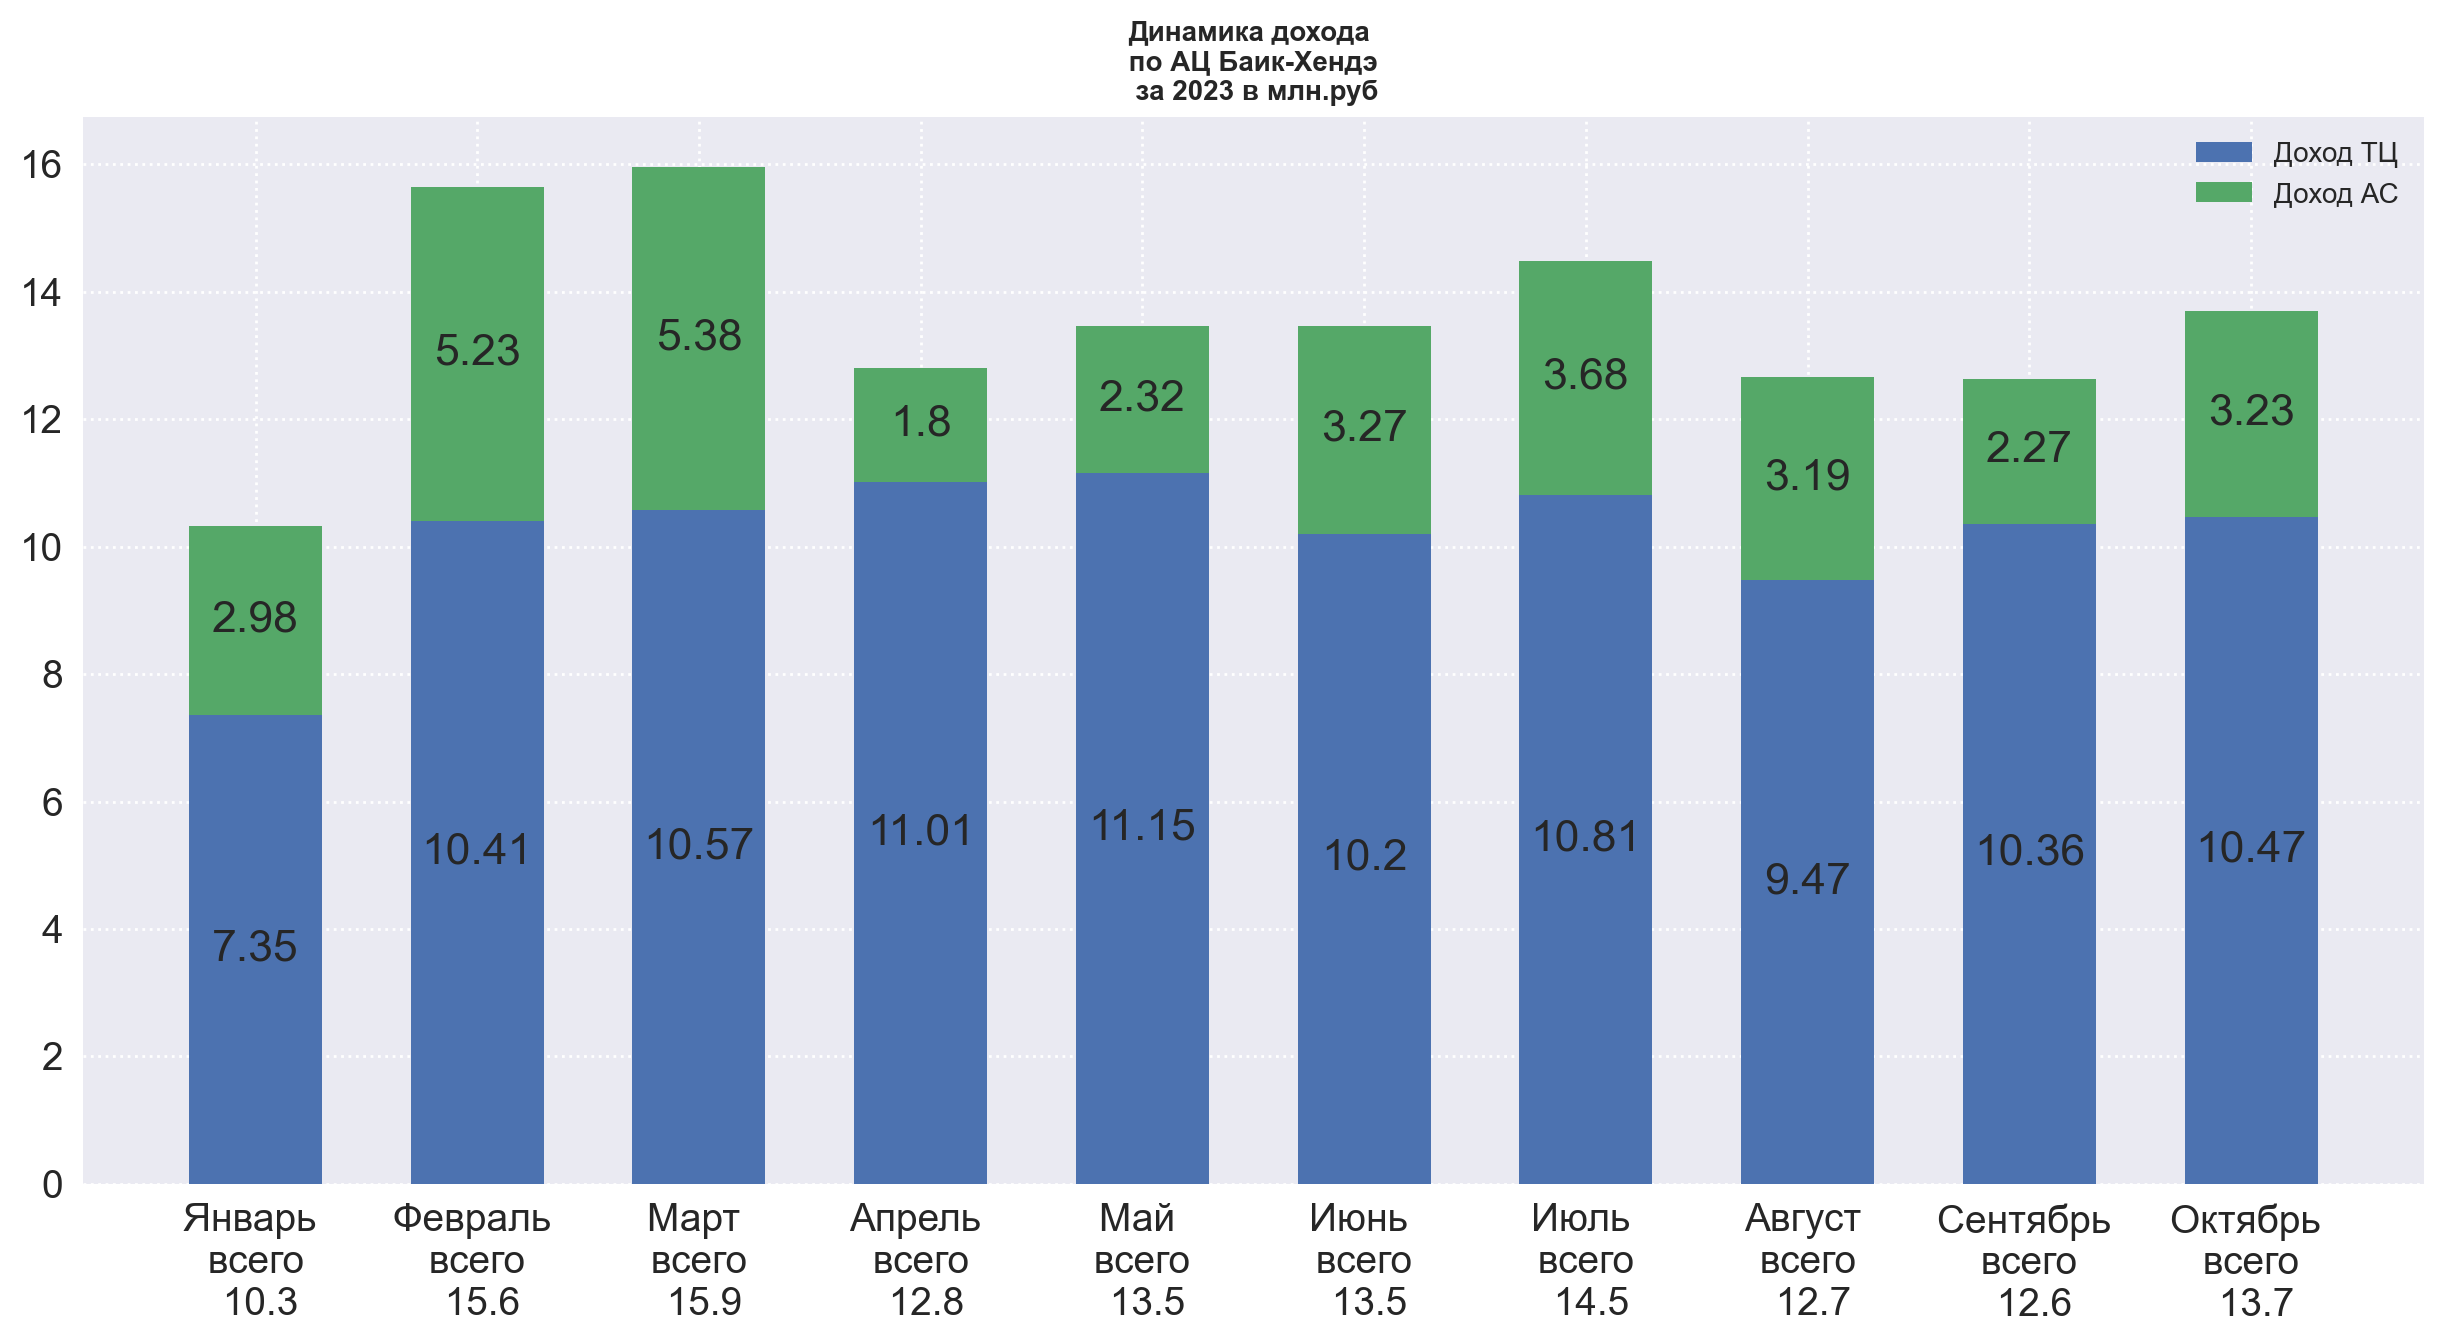

In [1342]:
with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep

    
    month_hisogr_ = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()]  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr_all = [round(float(df_PF[(df_PF['индекс'] == ind_pf_doh )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']]
                                     .fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]
    MMM = [f"{i} \n всего \n {round(y,1)}" for i,y in zip(month_hisogr_, doh_autocentr_all)]
    month_hisogr_ = MMM
    
    doh_autocentr = {
        'Доход ТЦ': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_doh_tc )  & (df_PF['автоцентр'] == name_ac)  
                                                & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
        'Доход АС': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_doh_as )  & (df_PF['автоцентр'] == name_ac)  
                                                & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)])
        
    }
    width = 0.6  # толщина свеч
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),7), dpi=200) # ширина по кол-ву месяцев month_pf
    ax.tick_params(labelsize = 14) # шрифт осей
    plt.rcParams['font.size'] = '16' # шрифт в данных
    bottom = np.zeros(month_pf) # по какому числу месяцев строим # month_pf
    for as_tc, doh_sum in doh_autocentr.items():
        p = ax.bar(month_hisogr_, doh_sum, width, label=as_tc, bottom=bottom)
        bottom += doh_sum

        ax.bar_label(p, label_type='center')

    ax.set_title(f'Динамика дохода \n по АЦ {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf} в млн.руб', fontweight="bold", fontsize = 10)
    ax.grid(True, linestyle=':')  # линии разметки
    ax.legend()
    
    #plt.savefig(f'Динамика дохода по {name_ac}.png') # сохраняет в картинку
    plt.legend()
    
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig('Динамика_дохода_1.png')
    plt.show()
  
    

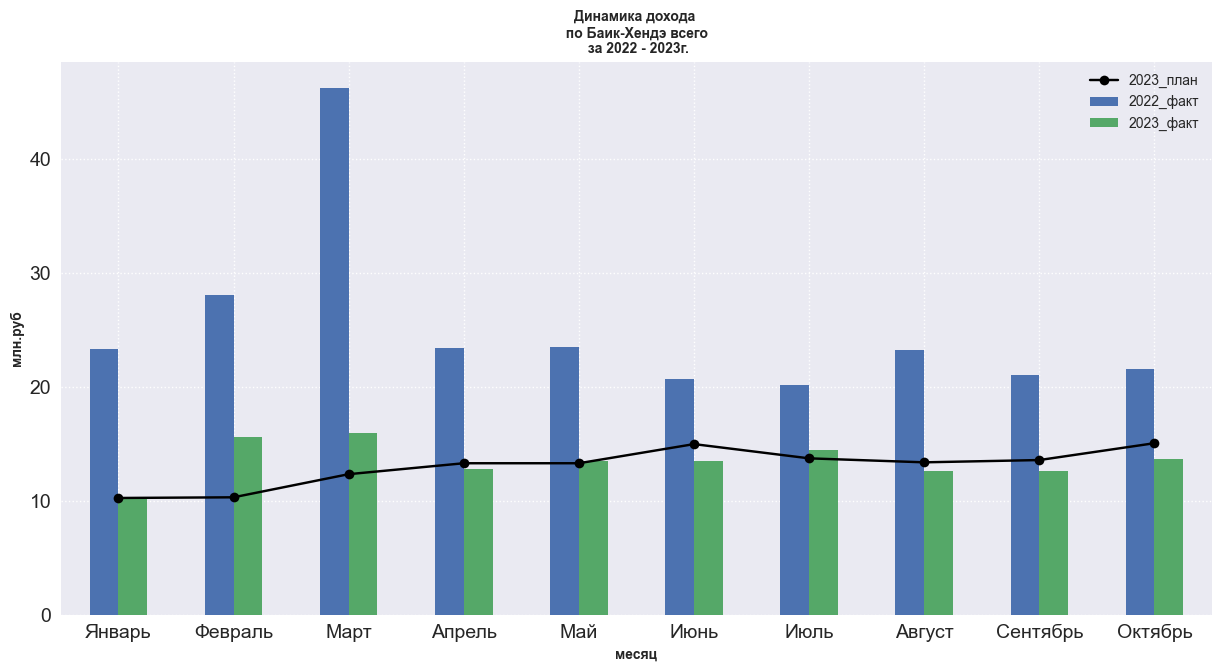

In [1343]:
with plt.style.context('seaborn-v0_8'): # применим стиль
# факт предыдущего года
    left_last_fact = pd.DataFrame(
        {'месяц': [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()],
        f"{year_pf-1}_факт": [round(float(df_PF[(df_PF['индекс'] == ind_pf_doh ) & (df_PF['автоцентр'] == name_ac) & 
                                        (df_PF['год'] == year_pf-1)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]})

    # факт текущего года
    right_first_fact = pd.DataFrame({'месяц': [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()], 
                                    f"{year_pf}_факт": [round(float(df_PF[(df_PF['индекс'] == ind_pf_doh ) & (df_PF['автоцентр'] == name_ac) & 
                                                                    (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]})
    # план текущего года
    right_first_pact = pd.DataFrame(
        {'месяц': [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()],
        f"{year_pf}_план": [round(float(df_PF[(df_PF['индекс'] == ind_pf_doh ) & 
                                        (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['план', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]})

    # джойним предыдущи и текущий + план текущего
    df_last_first = pd.merge(left_last_fact, right_first_fact, how='outer')
    df_last_first_target = pd.merge(df_last_first, right_first_pact, how='outer')

    # строим график
    ax = df_last_first_target[['месяц', f"{year_pf}_план"]].plot(
        x='месяц', linestyle='-', marker='o', figsize=(0.5+(month_pf)*1.2, 7), color='black', fontsize = 9)
    df_last_first_target[['месяц', f"{year_pf-1}_факт", f"{year_pf}_факт"]].plot(x='месяц', kind='bar',
                                                            ax=ax, fontsize = 9)
    ax.tick_params(labelsize = 14) # шрифт осей
    plt.rcParams['font.size'] = '16' # шрифт в данных
    ax.set_title(f'Динамика дохода \n по {spravka_new_name.get(name_ac, name_ac)} всего \n за {year_pf-1} - {year_pf}г.', fontweight="bold", fontsize = 10)
    ax.grid(True, linestyle=":")  # линии разметки
    plt.ylabel('млн.руб',fontsize = 10, fontweight="bold")
    plt.xlabel('месяц',fontsize = 10, fontweight="bold")
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('Динамика_дохода_2.png') # сохряняет в картику
    plt.show()


In [1344]:
f_lst_f_tg_1 = pd.merge(func_IND_podr_year(df_PF, ind_pf_doh, 'факт', year=year_pf-1),
                        func_IND_podr_year(df_PF, ind_pf_doh, 'план', year=year_pf))
f_lst_f_tg_1 = pd.merge(f_lst_f_tg_1, func_IND_podr_year(df_PF, ind_pf_doh, 'факт', year=year_pf))
f_lst_f_tg_1.loc['ИТОГО'] = f_lst_f_tg_1[[f"факт_дох_{year_pf-1}", f"факт_дох_{year_pf}", f"план_дох_{year_pf}"]].sum()
f_lst_f_tg_1['Ф_к_П_%'] = round((f_lst_f_tg_1[f"факт_дох_{year_pf}"] / f_lst_f_tg_1[f"план_дох_{year_pf}"])*100, 1)
f_lst_f_tg_1[f'Ф_{year_pf}_к_{year_pf-1}_%'] = round((f_lst_f_tg_1[f"факт_дох_{year_pf}"] / f_lst_f_tg_1[f"факт_дох_{year_pf-1}"])*100, 1)
f_lst_f_tg_1[f'ДОХ_с_нак_Ф_{year_pf-1}'] = round(f_lst_f_tg_1[f"факт_дох_{year_pf-1}"].cumsum())
f_lst_f_tg_1[f'ДОХ_с_нак_Ф_{year_pf}'] = round(f_lst_f_tg_1[f"факт_дох_{year_pf}"].cumsum())
f_lst_f_tg_1[f'нак_{year_pf}_к_{year_pf-1}_%'] = round((f_lst_f_tg_1[f'ДОХ_с_нак_Ф_{year_pf}'] / f_lst_f_tg_1[f'ДОХ_с_нак_Ф_{year_pf-1}'])*100, 1)

for i in [i for i in f_lst_f_tg_1.columns if '%' in i]:
    f_lst_f_tg_1[i] = f_lst_f_tg_1[i].apply(result_plan)
    
f_lst_f_tg_1 = convertor_zeros(f_lst_f_tg_1)

#удаляем лишнее по последней строке
f_lst_f_tg_1.loc['ИТОГО',f'ДОХ_с_нак_Ф_{year_pf-1}'] = '---'
f_lst_f_tg_1.loc['ИТОГО',f'ДОХ_с_нак_Ф_{year_pf}'] = '---'
f_lst_f_tg_1.loc['ИТОГО',f'нак_{year_pf}_к_{year_pf-1}_%'] = '---'

f_lst_f_tg_1 = f_lst_f_tg_1.fillna(0)
#f_lst_f_tg_1

func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


In [1345]:
df_last_first_target_x = f_lst_f_tg_1.copy()
dfi.export(df_last_first_target_x, 'df_дох_с_накопл.png', dpi=200)
df_last_first_target_x

месяц факт_дох_2022 план_дох_2023 факт_дох_2023    Ф_к_П_%  \
0        Январь        23.315        10.254        10.327  100.7 % ↗   
1       Февраль        28.037        10.313        15.635  151.6 % ↗   
2          Март        46.241        12.336        15.952  129.3 % ↗   
3        Апрель        23.453        13.304        12.817   96.3 % ↘   
4           Май        23.488        13.304        13.461  101.2 % ↗   
5          Июнь        20.683        14.982        13.471   89.9 % ↘   
6          Июль        20.165        13.730        14.491  105.5 % ↗   
7        Август        23.263        13.377        12.661   94.6 % ↘   
8      Сентябрь        21.025        13.583        12.631   93.0 % ↘   
9       Октябрь        21.590        15.062        13.699   91.0 % ↘   
ИТОГО         0       251.261       130.245       135.144  103.8 % ↗   

      Ф_2023_к_2022_% ДОХ_с_нак_Ф_2022 ДОХ_с_нак_Ф_2023 нак_2023_к_2022_%  
0            44.3 % ↘           23.315           10.327          44.3 % ↘  
1            55.8 % ↘           51.353           25.962          50.6 % ↘  
2            34.5 % ↘           97.594           41.914          42.9 % ↘  
3            54.6 % ↘          121.047           54.731          45.2 % ↘  
4            57.3 % ↘          144.535           68.192          47.2 % ↘  
5            65.1 % ↘          165.218           81.663          49.4 % ↘  
6            71.9 % ↘          185.383           96.154          51.9 % ↘  
7            54.4 % ↘          208.646          108.815          52.2 % ↘  
8            60.1 % ↘          229.671          121.446          52.9 % ↘  
9            63.5 % ↘          251.261          135.144          53.8 % ↘  
ИТОГО        53.8 % ↘              ---              ---               ---

In [1346]:

# df_last_first_target_x = f_lst_f_tg[['месяц', f"{year_pf-1}_факт", f"{year_pf}_план", f"{year_pf}_факт"]]
# df_last_first_target_x.loc['ИТОГО'] = df_last_first_target_x[[f"{year_pf-1}_факт", f"{year_pf}_факт", f"{year_pf}_план"]].sum()
# df_last_first_target_x = func_float_df_digit(df_last_first_target_x, float)
# df_last_first_target_x['Ф_к_П_%'] = round((df_last_first_target_x[f"{year_pf}_факт"] / df_last_first_target_x[f"{year_pf}_план"])*100, 1)
# df_last_first_target_x[f'Ф_{year_pf}_к_{year_pf-1}_%'] = round((df_last_first_target_x[f"{year_pf}_факт"] / df_last_first_target_x[f"{year_pf-1}_факт"])*100, 1)
# df_last_first_target_x[f'ДОХ_с_нак_Ф_{year_pf-1}'] = round(df_last_first_target_x[f"{year_pf-1}_факт"].cumsum(),2)
# df_last_first_target_x[f'ДОХ_с_нак_Ф_{year_pf}'] = round(df_last_first_target_x[f"{year_pf}_факт"].cumsum(),2)
# df_last_first_target_x[f'нак_{year_pf}_к_{year_pf-1}_%'] = round((df_last_first_target_x[f'ДОХ_с_нак_Ф_{year_pf}'] / df_last_first_target_x[f'ДОХ_с_нак_Ф_{year_pf-1}'])*100, 1)

# # удаляем лишнее по последней строке
# df_last_first_target_x.loc['ИТОГО',f'ДОХ_с_нак_Ф_{year_pf-1}'] = '---'
# df_last_first_target_x.loc['ИТОГО',f'ДОХ_с_нак_Ф_{year_pf}'] = '---'
# df_last_first_target_x.loc['ИТОГО',f'нак_{year_pf}_к_{year_pf-1}_%'] = '---'

# # выбираем столбцы которые содержат в имени % и применяем функцию для определения выполнения плана
# for i in [i for i in df_last_first_target_x.columns if '%' in i]:
#     df_last_first_target_x[i] = df_last_first_target_x[i].apply(result_plan)

# df_last_first_target_x = df_last_first_target_x.fillna(0)


# dfi.export(df_last_first_target_x, 'df_дох_с_накопл.png', dpi=100)
# df_last_first_target_x

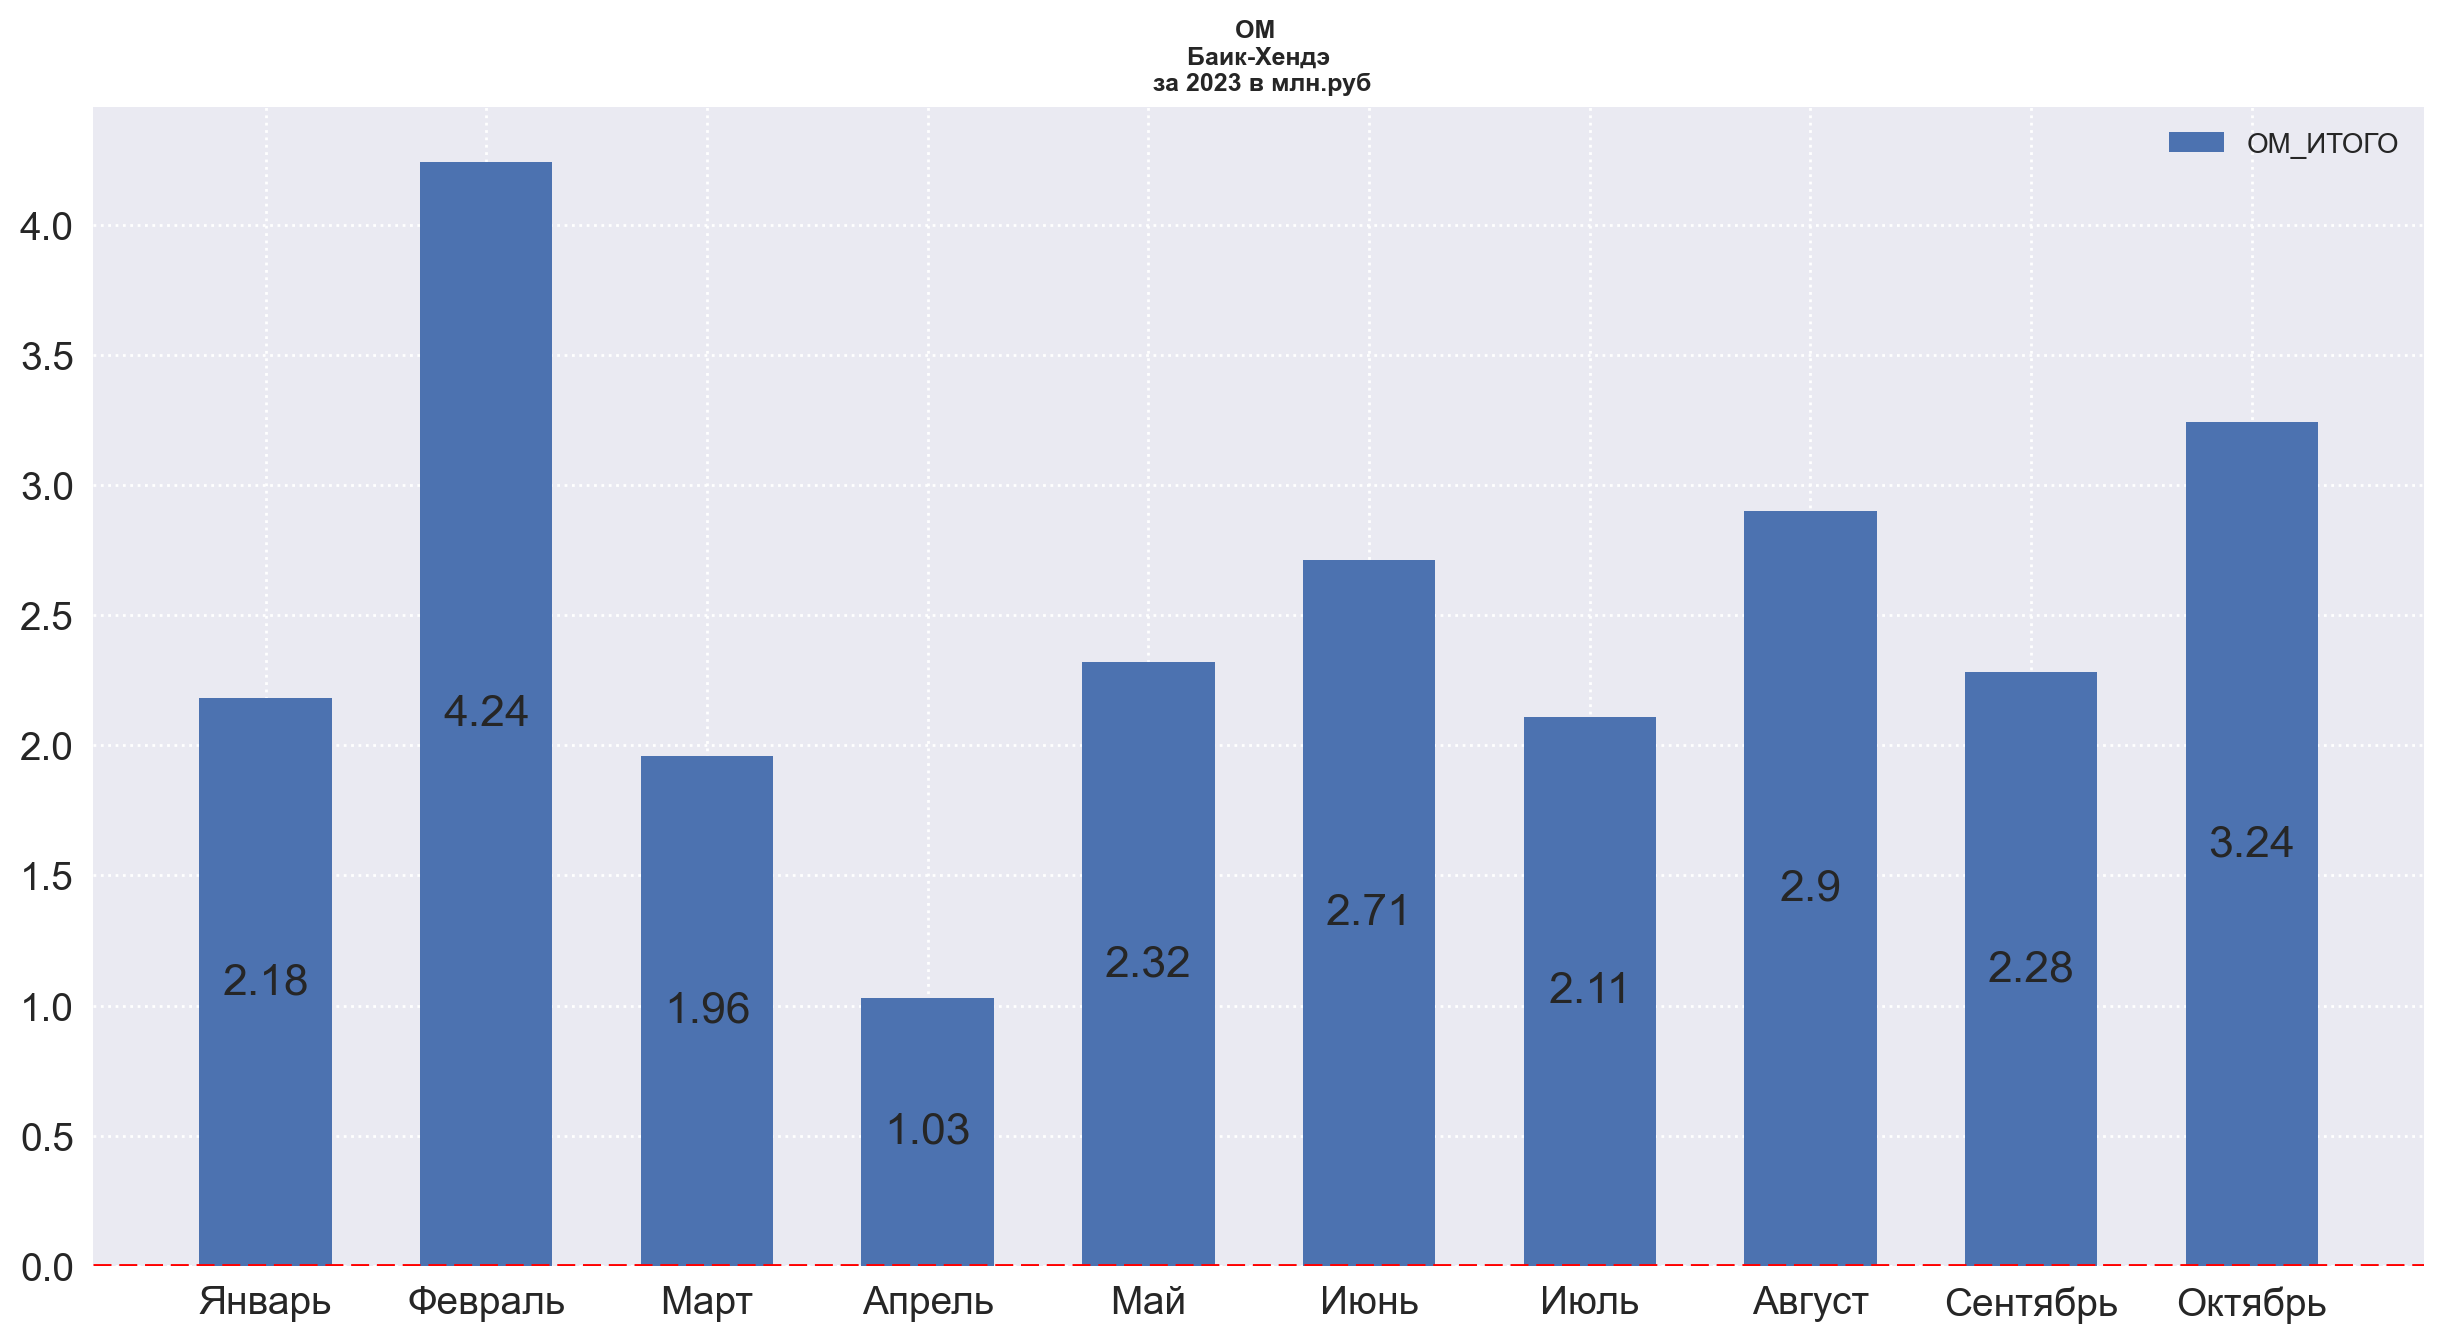

In [1347]:
with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    month_hisogr = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()]  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
        'ОМ_ИТОГО': np.array(
            [round(float(df_PF[(df_PF['индекс'] == om_itog)  
                                                & (df_PF['автоцентр'] == name_ac) 
                                                & (df_PF['год'] == year_pf)][[
                                                    'факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),

    }
    width = 0.6  # толщина свеч

    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),7), dpi=200) # ширина по кол-ву месяцев month_pf
    bottom = np.zeros(month_pf) # по какому числу месяцев строим # month_pf
    ax.tick_params(labelsize = 14) # шрифт осей
    plt.rcParams['font.size'] = '16' # шрифт в данных
    for as_tc, doh_sum in doh_autocentr.items():
        p = ax.bar(month_hisogr, doh_sum, width, label=as_tc, bottom=bottom)
        bottom += doh_sum

        ax.bar_label(p, label_type='center')
    # добавляем ось X
    plt.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'ОМ \n {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf} в млн.руб', fontweight="bold", fontsize = 9)
    ax.grid(True, linestyle=':')  # линии разметки
    ax.legend()

    plt.tight_layout()
    plt.savefig('ОМ_1.png') # сохряняет в картинку
    plt.show()

In [1348]:
om_result_dinamic = dynamic_2_years(df_PF, om_itog)
om_result_dinamic

Дата  факт  план
18251  2022-01-01 15.20 10.50
33590  2022-02-01 17.90 12.10
44131  2022-03-01 29.20  9.40
77524  2022-04-01 10.00 10.00
95236  2022-05-01 11.40  6.00
119605 2022-06-01  6.00  5.50
130370 2022-07-01  8.10  4.70
145648 2022-08-01  9.60  8.30
182533 2022-09-01 10.70  8.30
194385 2022-10-01  5.40  4.90
211067 2022-11-01  6.90  5.00
232116 2022-12-01  3.00  5.00
18252  2023-01-01  2.20  3.20
33589  2023-02-01  4.20  3.30
44129  2023-03-01  2.00  3.80
77523  2023-04-01  1.00  3.80
95237  2023-05-01  2.30  3.80
119604 2023-06-01  2.70  3.90
130369 2023-07-01  2.10  5.00
145647 2023-08-01  2.90  3.60
182551 2023-09-01  2.30  4.50
194384 2023-10-01  3.20  5.50

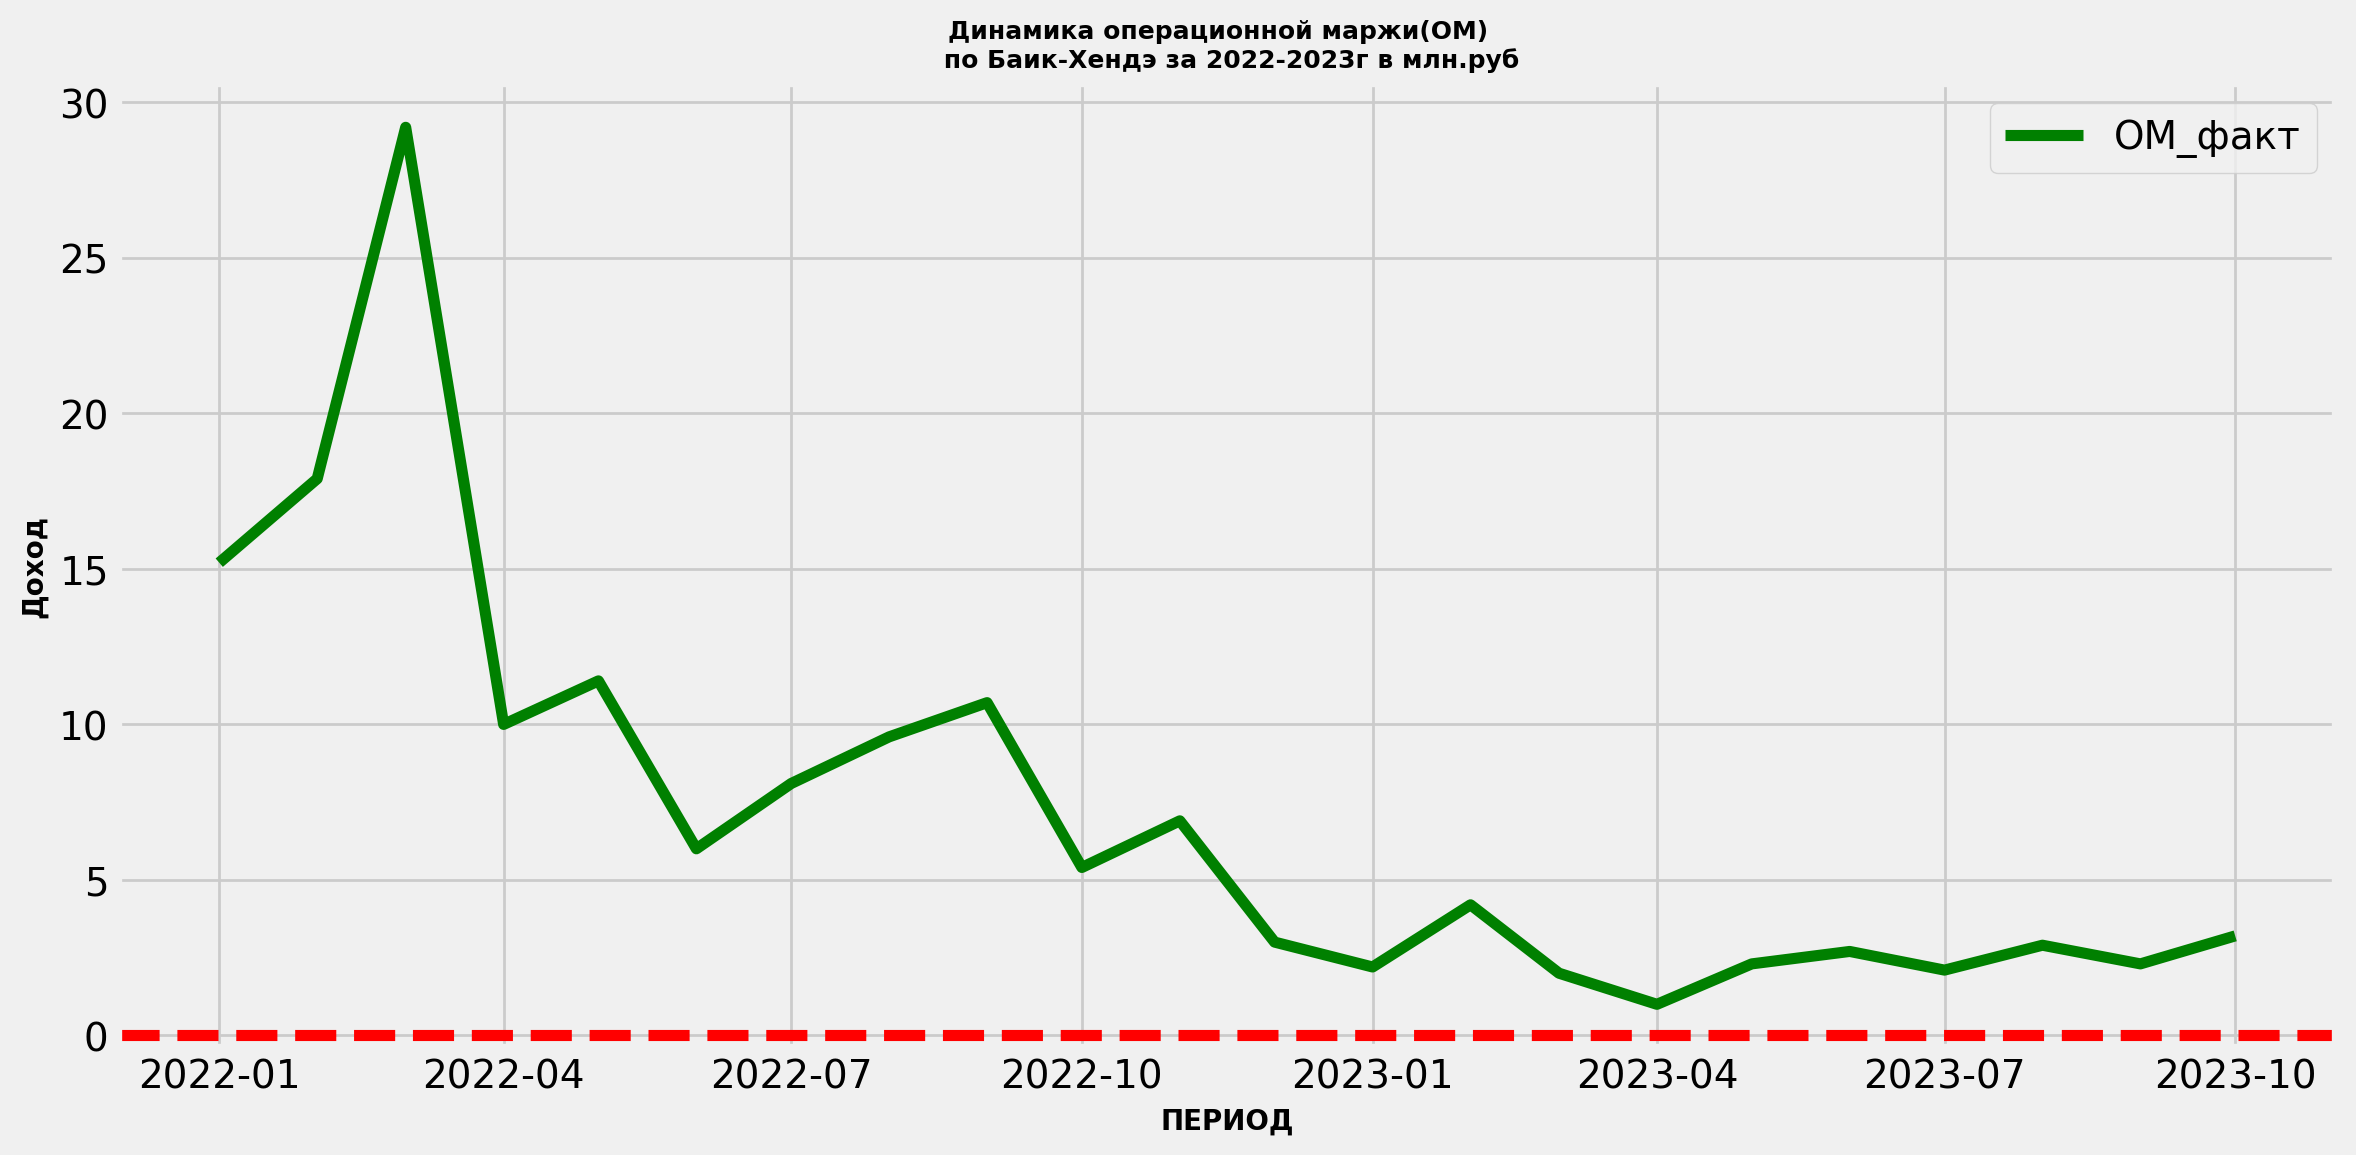

In [1349]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,6), dpi=200) # размер графика
    plt.plot(om_result_dinamic['Дата'], om_result_dinamic['факт'], label='ОМ_факт', color='green')
    #plt.plot(om_result_dinamic['Дата'], om_result_dinamic['план'], label='ОМ_план', color='red') # эту строку убрать
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)
    # добавляем ось X
    plt.axhline(y=0, color='red', linestyle='--')

    plt.legend()
    plt.ylabel('Доход',fontsize = 10, fontweight="bold")
    plt.xlabel('ПЕРИОД',fontsize = 10, fontweight="bold")
    plt.title(f"Динамика операционной маржи(ОМ)  \n по {spravka_new_name.get(name_ac, name_ac)} за {year_pf-1}-{year_pf}г в млн.руб",fontsize = 9, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('ОМ_2.png') # сохряняет в картику
    plt.show()

In [1350]:
# df_PF_xx = df_PF[df_PF.месяц.isin ([i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()])]
# om_result_dinamic_x = df_PF_xx[(df_PF_xx['индекс'] == om_itog )  & (df_PF_xx['автоцентр'] == name_ac) & (df_PF_xx['год'] >= year_pf-1)][['Дата','факт','план', 'год']]
# om_result_dinamic_x['факт'] = om_result_dinamic_x['факт'].apply(mln_x)
# om_result_dinamic_x['план'] = om_result_dinamic_x['план'].apply(mln_x)
# om_result_dinamic_x

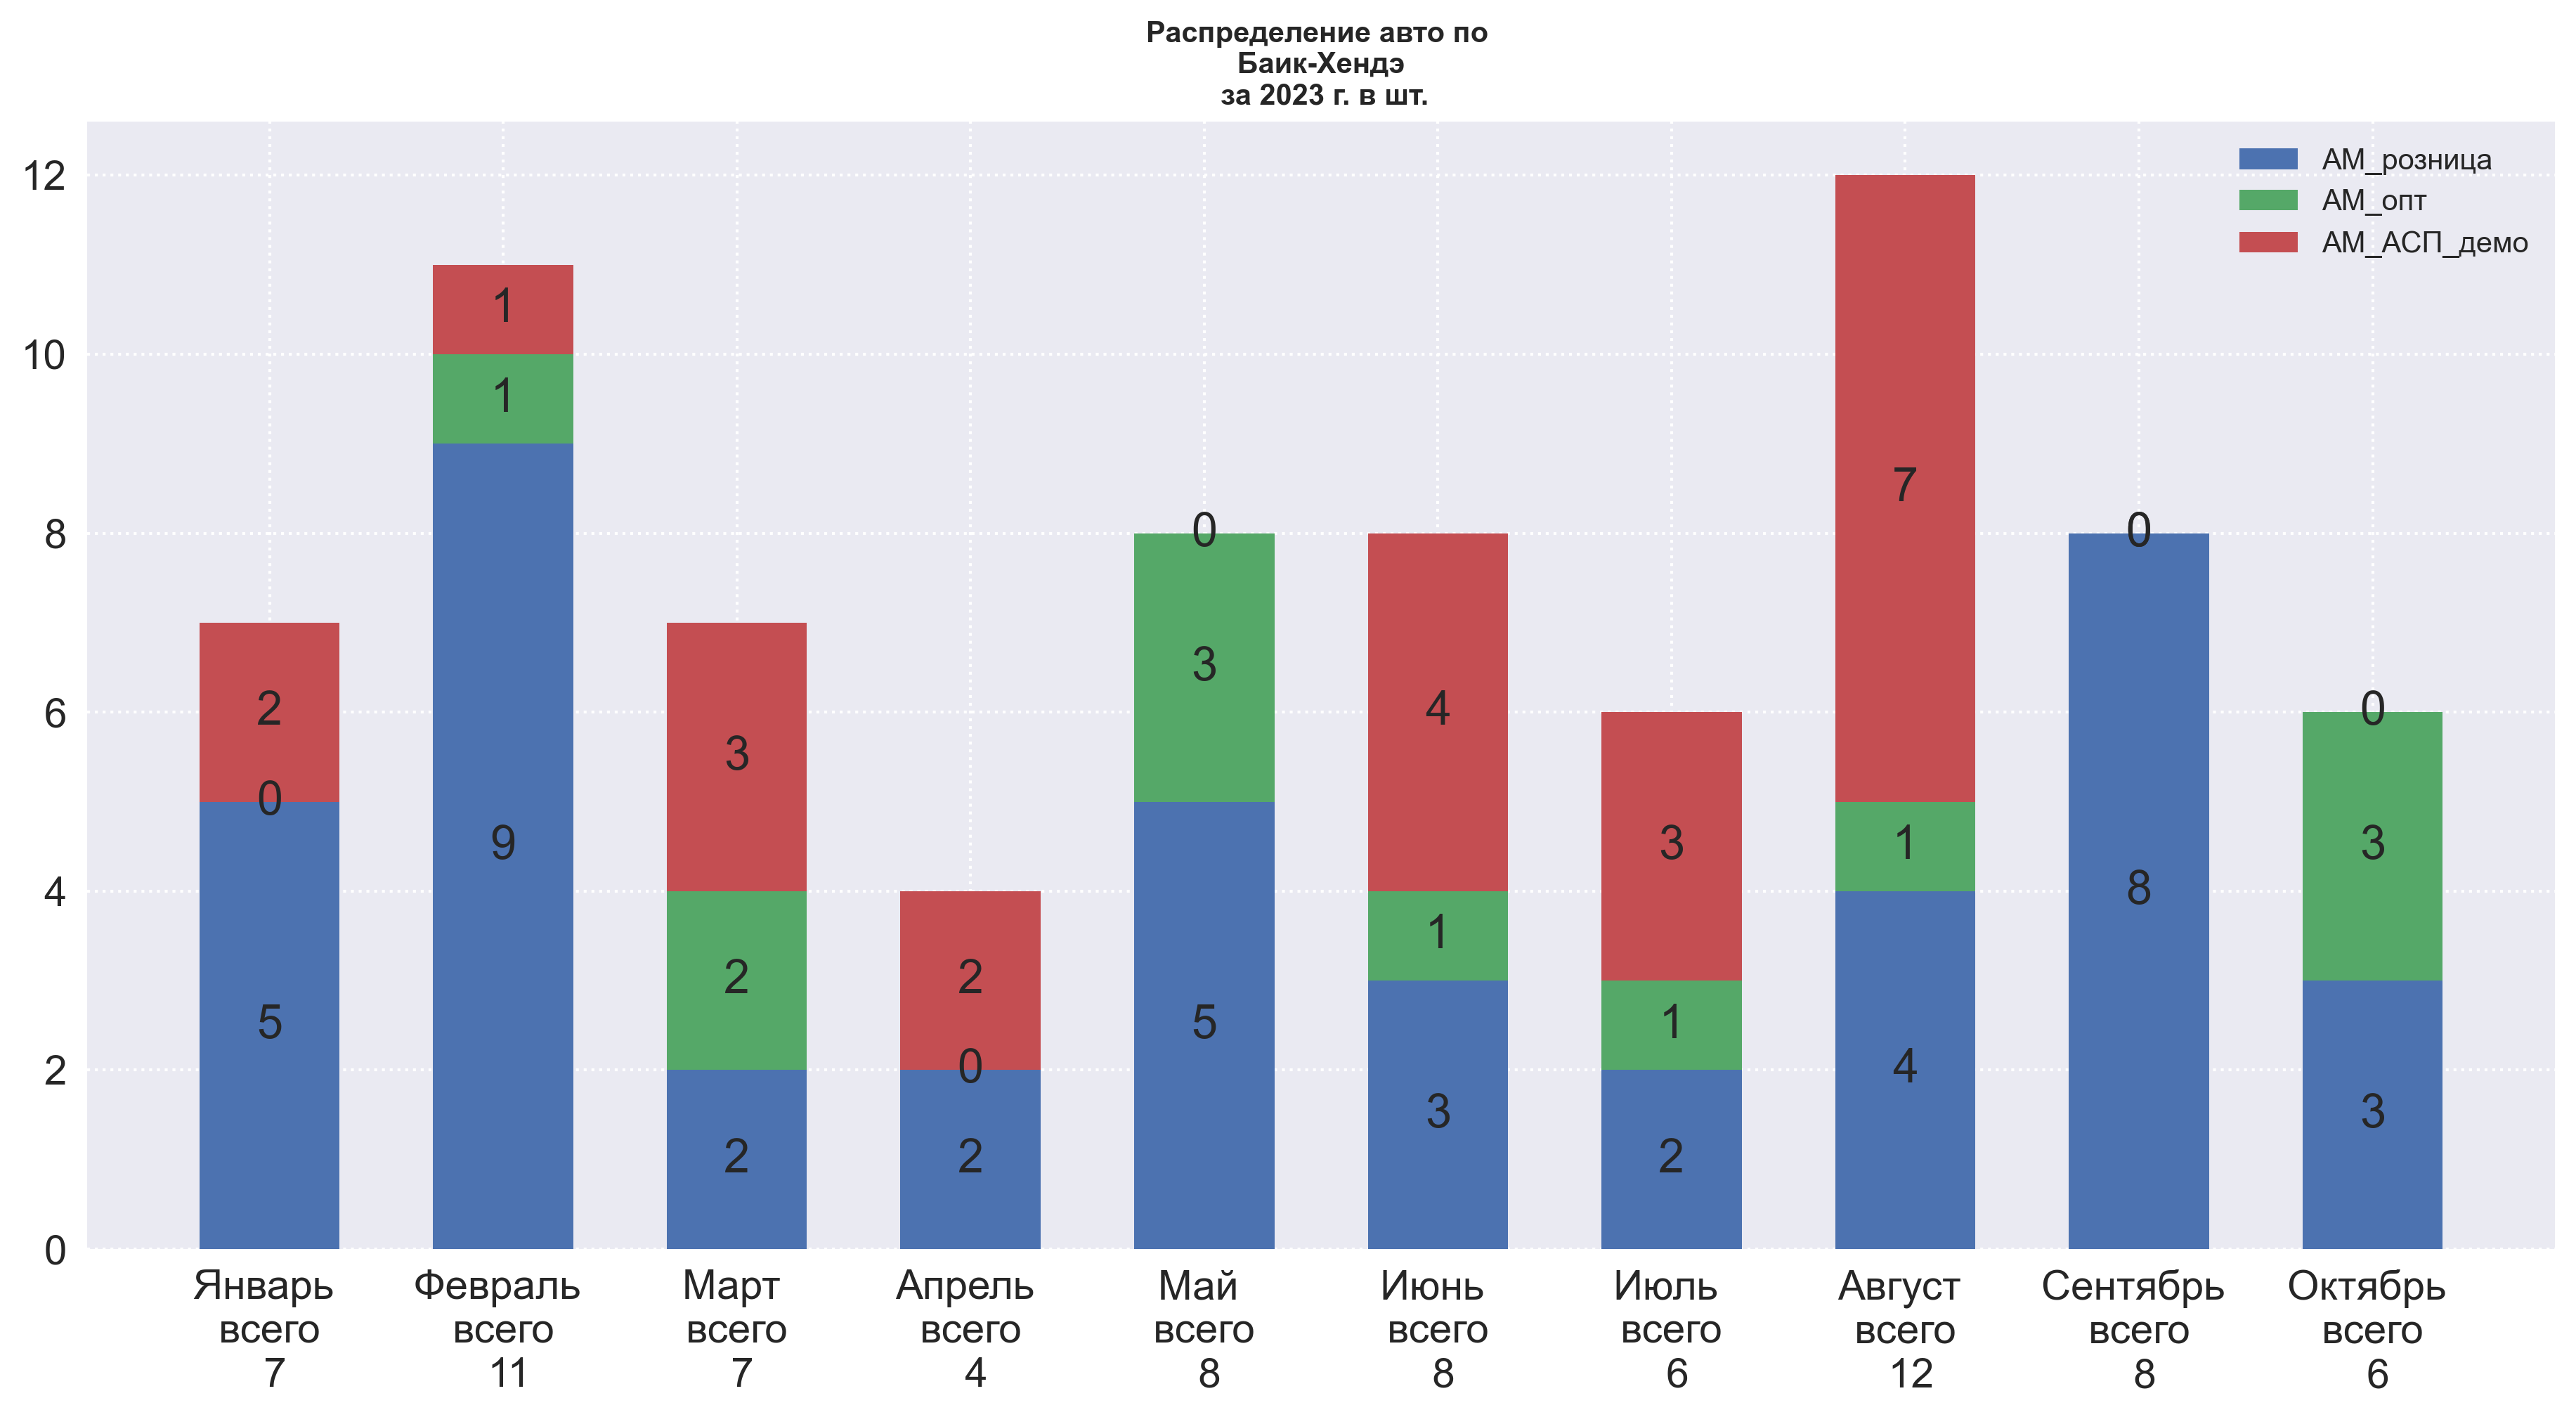

In [1351]:
with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    
    # уникальные месяца
    mmm = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()]  
    # кол-во авто всего 
    itogo_autom = [round(float(df_PF[(df_PF['индекс'] == am_count_itog )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1, 2) for i in range(month_pf)]
    # собираем текст всего кол-во + мес с переносом
    MMM = [f"{i} \n всего \n {round(y)}" for i,y in zip(mmm, itogo_autom)]
    
    
    month_hisogr = MMM  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
        'АМ_розница': np.array([round(float(df_PF[(df_PF['индекс'] == am_new_roz )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1, 2) for i in range(month_pf)]),
        'АМ_опт': np.array([round(float(df_PF[(df_PF['индекс'] == am_new_opt )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1, 2) for i in range(month_pf)]),
        'АМ_АСП_демо': np.array([round(float(df_PF[(df_PF['индекс'] == am_new_by )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1, 2) for i in range(month_pf)])   

    }
    
    doh_autocentr_it = {
        'ИТОГО': np.array([round(float(df_PF[(df_PF['индекс'] == am_count_itog )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].drop_duplicates('месяц').iloc[i,0])/1, 2) for i in range(month_pf)])}
    
    width = 0.6  # толщина свеч
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),7), dpi=300) # ширина по кол-ву месяцев month_pf
    bottom = np.zeros(month_pf) # по какому числу месяцев строим # month_pf
    ax.tick_params(labelsize = 14) # шрифт осей
    plt.rcParams['font.size'] = '16' # шрифт в данных
    for as_tc, doh_sum in doh_autocentr.items():
        p = ax.bar(month_hisogr, doh_sum, width, label=as_tc, bottom=bottom)
        bottom += doh_sum

        ax.bar_label(p, label_type='center')
    


    ax.set_title(f'Распределение авто по \n {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf} г. в шт.', fontweight="bold", fontsize = 10)
    ax.grid(True, linestyle=':')  # линии разметки
    ax.legend()

    plt.tight_layout()
    plt.savefig('Распределение_ам.png') # сохряняет в картику
    plt.show()

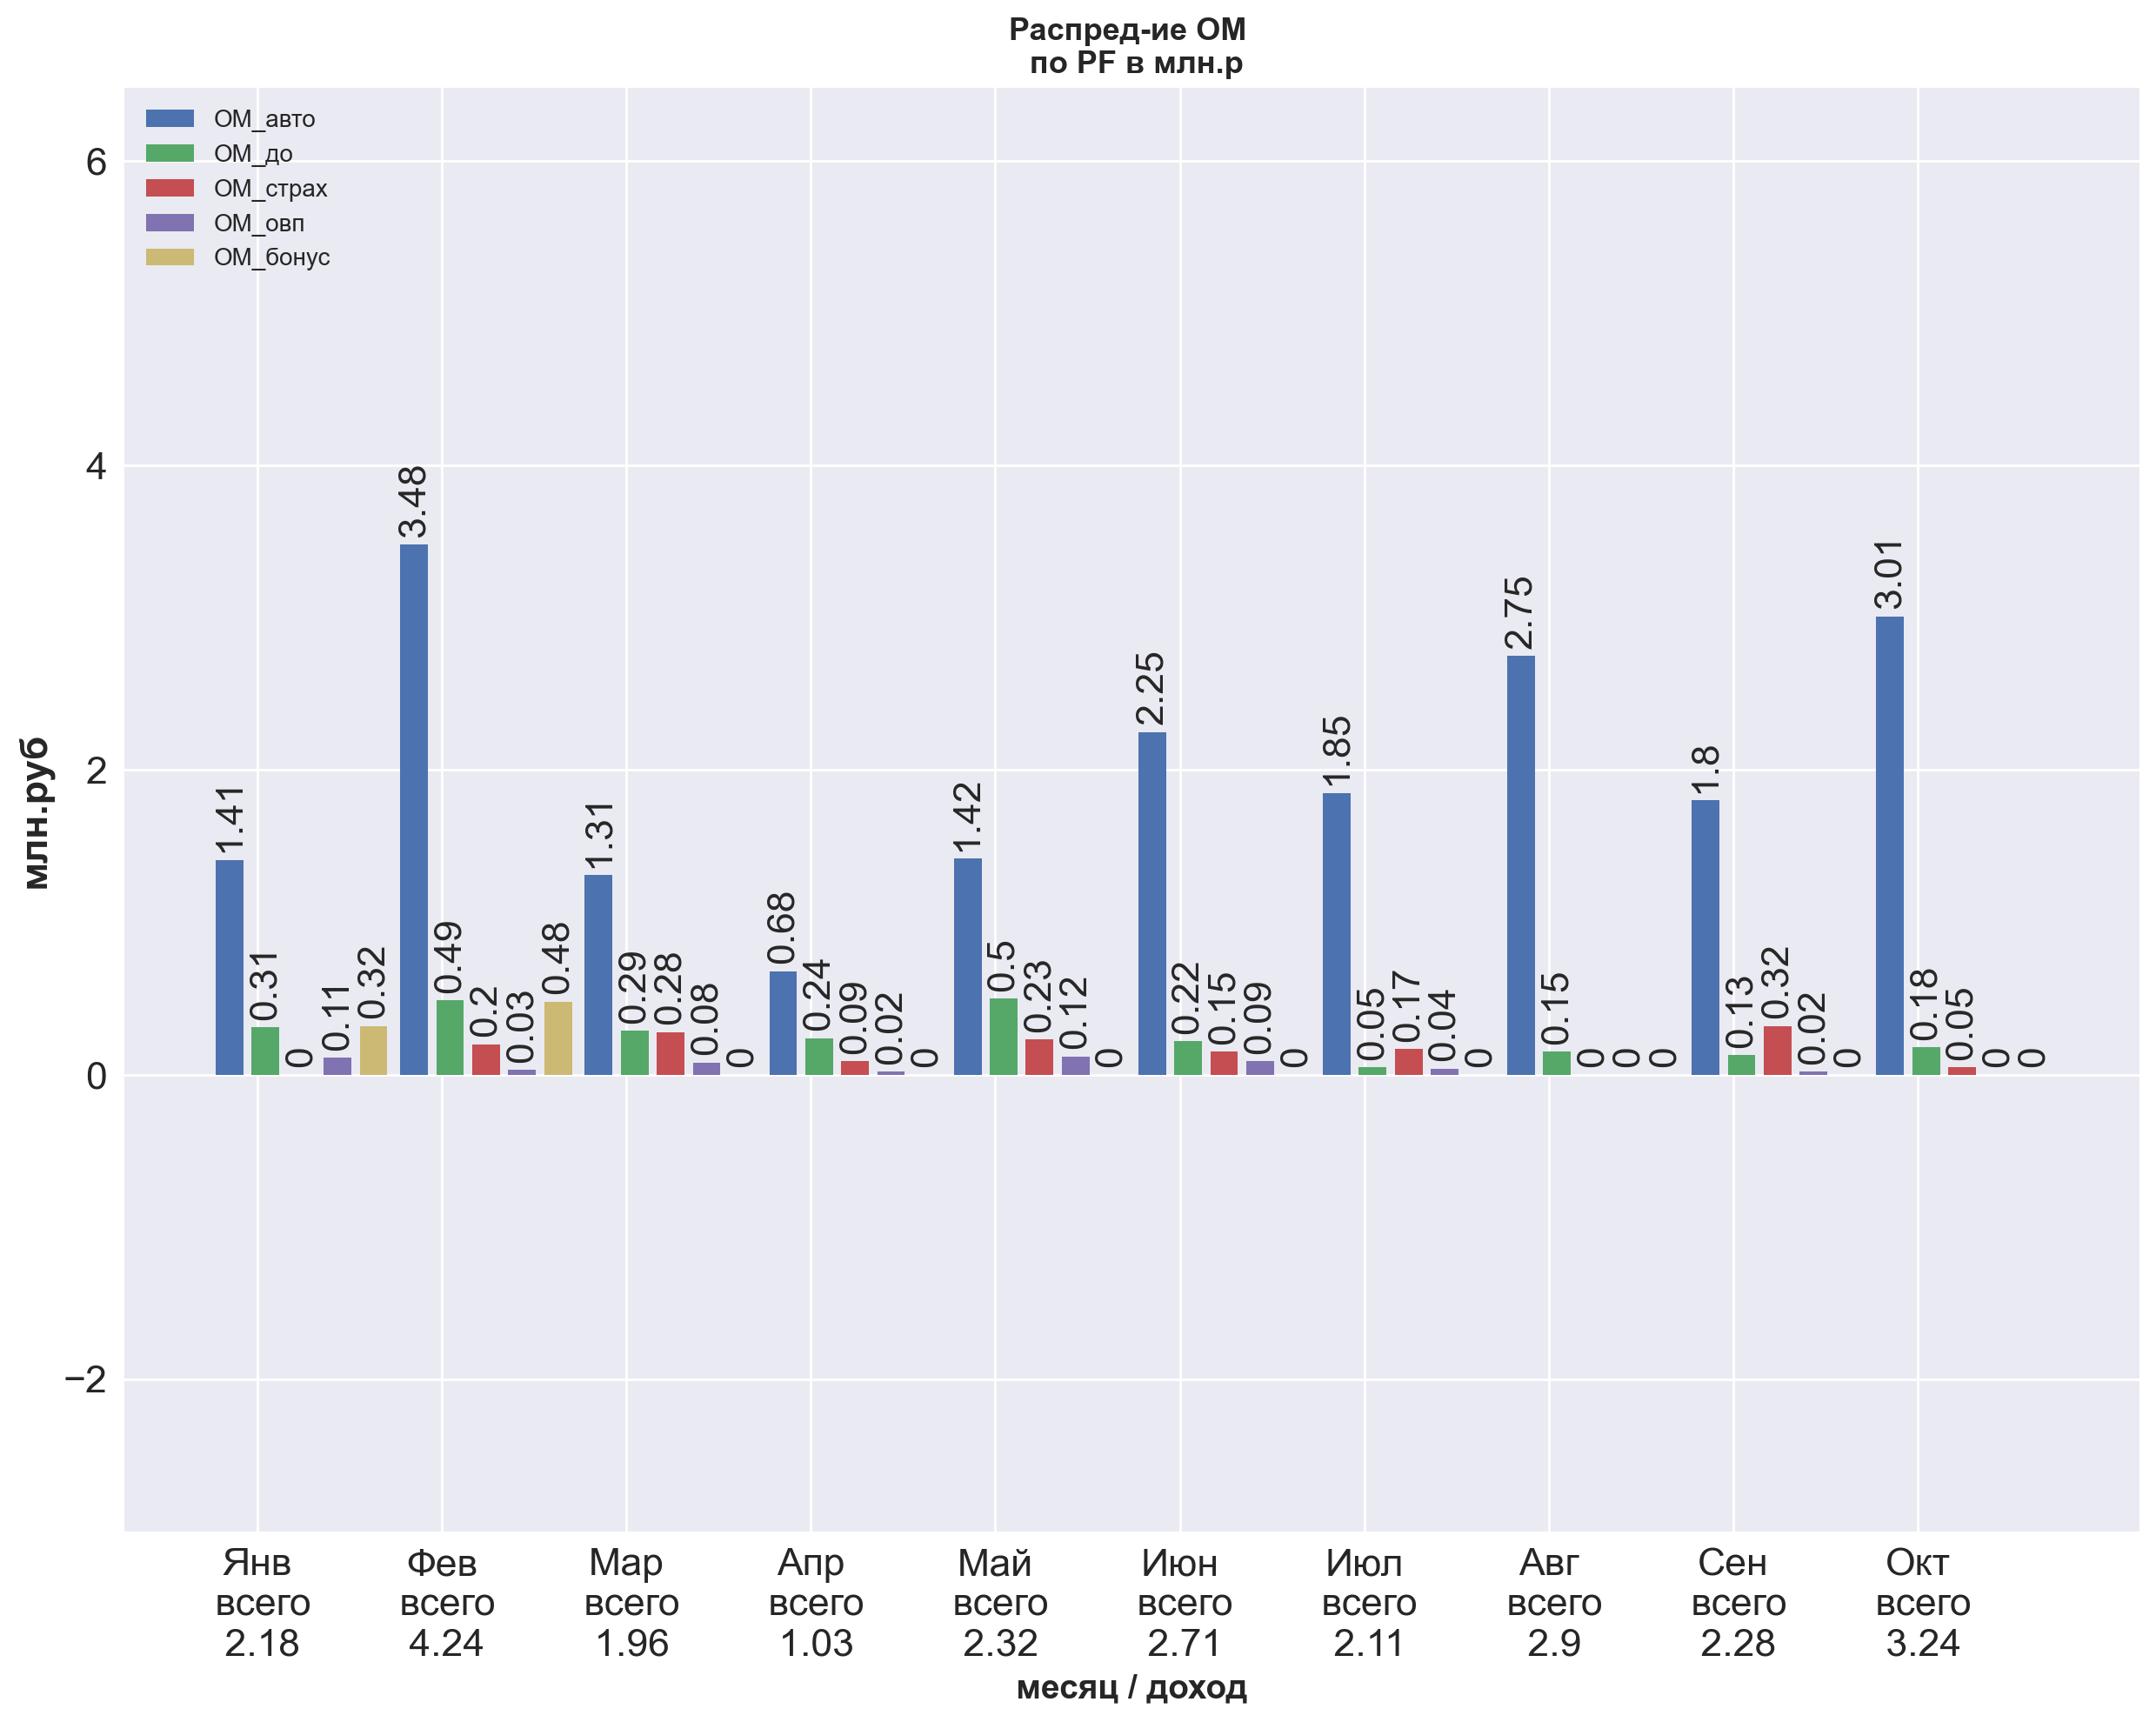

In [1352]:

with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep /seaborn-v0_8
    mmm = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()] 
    itogo_autom = [round(float(df_PF[(df_PF['индекс'] == om_itog )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]
    MMM = [f"{i[0:3]}\n всего\n {round(y,2)}" for i,y in zip(mmm, itogo_autom)]


    month_doh = MMM  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
            'ОМ_авто': np.array([round(float(df_PF[(df_PF['индекс'] == om_auto )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'ОМ_до': np.array([round(float(df_PF[(df_PF['индекс'] == om_do )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'ОМ_страх': np.array([round(float(df_PF[(df_PF['индекс'] == om_strah )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'ОМ_овп': np.array([round(float(df_PF[(df_PF['индекс'] == om_ovp )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'ОМ_бонус': np.array([round(float(df_PF[(df_PF['индекс'] == om_bonus )  & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)])
        }
    
    x = np.arange(len(month_doh))  # the label month
    width = 0.15  # ширина полос 
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),10), dpi=200)
    
    for name_doh, doh_value in doh_autocentr.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, doh_value, width, label=name_doh)
        ax.bar_label(rects, rotation=90, padding=3, fontsize = 16)
        multiplier += 1.3 # растояние между столбцами одной группы

    # скрипт определяющий построение графика по оси y min max для set_ylim
    mx = 0
    mi = 0
    for k,v in doh_autocentr.items():
        if max(v)>mx:
            mx = max(v)
        if min(v)<mi:
            mi = min(v)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('млн.руб', fontsize = 16, fontweight="bold")
    ax.set_title(f'Распред-ие ОМ \n по PF в млн.р', fontweight="bold", fontsize = 13)
    ax.set_xticks(x + width, month_doh)
    ax.legend(loc='upper left', ncols=1) # ncols=1 - столбцы легенды
    ax.set_ylim(mi-3, mx+3) # + корреткировка +2 млн
 

    plt.xticks(rotation=0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('месяц / доход',fontsize = 14, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('ОМ_3.png') # сохряняет в картику
    plt.show()

In [1353]:
print('Распределение доходности ОМ')
# собираем первый фрейм с ОМ
OM_rspred = df_PF[(df_PF['индекс'] == om_itog) & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['месяц', 'факт']].fillna(0).drop_duplicates('месяц')
OM_rspred = OM_rspred.rename(columns={'факт':f'ОМ_{year_pf}'})
#OM_rspred[f'ОМ_{year_pf}'] = OM_rspred[f'ОМ_{year_pf}'].apply(lambda x: round(Decimal(x)/1000000,3))

# к первому фрейму мерджим составные бонусные части
for i in ['НОВДох', '1512', '1513', '1517', '1400', '1510']:
    OM_rspred = pd.merge(OM_rspred, df_PF[(df_PF['индекс'] == i) & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['месяц', 'факт']].fillna(0).drop_duplicates('месяц'))
    OM_rspred = OM_rspred.rename(columns={'факт':f'{i}'})
    OM_rspred[f'{i}'] = OM_rspred[f'{i}'].apply(lambda x: round(Decimal(x)/1000000,3))

# переименовываем
OM_rspred = OM_rspred.rename(columns={'НОВДох':'ОМ_авто', '1512':'ОМ_страх', '1513':'ОМ_овп', '1517':'ОМ_до', '1400':'ОМ_привелегии', '1510':'ОМ_бонус'})

# блок сборки новых авто розница + опт
df_count_rozn =  df_PF[(df_PF['индекс'] == am_new_roz) & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['месяц', 'факт']].fillna(0).drop_duplicates('месяц')
df_count_rozn = df_count_rozn.rename(columns={'факт':'ам_розн'})
df_count_opt =  df_PF[(df_PF['индекс'] == am_new_opt) & (df_PF['автоцентр'] == name_ac) & (df_PF['год'] == year_pf)][['месяц', 'факт']].fillna(0).drop_duplicates('месяц')
df_count_opt = df_count_opt.rename(columns={'факт':'ам_опт'})
df_auto_new = pd.merge(df_count_rozn, df_count_opt, how='left')
df_auto_new['ам_новые(розн_опт)'] = df_auto_new['ам_розн'].apply(lambda x: round(float(x),1)) + df_auto_new['ам_опт'].apply(lambda x: round(float(x),3))
df_auto_new = pd.DataFrame(df_auto_new[['месяц','ам_новые(розн_опт)']])


# обединяем два фрейма
OM_rspred = pd.merge(OM_rspred, df_auto_new, how='left')

# обрезаем табл по строкам без nan и по всем столбцам
OM_rspred['кум_на_1_ам'] = round(OM_rspred[f'ОМ_{year_pf}'] / OM_rspred['ам_новые(розн_опт)'], 2)
OM_rspred.replace([np.inf, -np.inf], np.nan, inplace=True) # убираем ошибки inf
OM_rspred = OM_rspred.iloc[0:month_pf,0:len(OM_rspred.columns)]
OM_rspred[f'ОМ_{year_pf}'] = OM_rspred[f'ОМ_{year_pf}'].apply(lambda x: round(Decimal(x)/1000000,3))
OM_rspred[f'кум_на_1_ам'] = OM_rspred[f'кум_на_1_ам'].apply(lambda x: round(Decimal(x)/1000000,3))
OM_rspred[f'ам_новые(розн_опт)'] = OM_rspred[f'ам_новые(розн_опт)'].apply(lambda x: round(Decimal(x)))
dfi.export(OM_rspred, 'df_Распределение_доходности_ОМ.png', dpi=150)

OM_rspred_tabl = OM_rspred.copy()
OM_rspred


Распределение доходности ОМ


месяц ОМ_2023 ОМ_авто ОМ_страх ОМ_овп  ОМ_до ОМ_привелегии ОМ_бонус  \
0    Январь   2.179   1.407    0.000  0.114  0.306         0.032    0.321   
1   Февраль   4.236   3.484    0.199  0.034  0.487         0.032    0.478   
2      Март   1.962   1.313    0.281  0.080  0.288         0.000    0.000   
3    Апрель   1.033   0.681    0.094  0.022  0.236         0.000    0.000   
4       Май   2.321   1.416    0.226  0.117  0.503         0.060    0.000   
5      Июнь   2.709   2.250    0.147  0.094  0.217         0.000    0.000   
6      Июль   2.111   1.855    0.173  0.037  0.046         0.000    0.000   
7    Август   2.898   2.747    0.000  0.000  0.151         0.000    0.000   
8  Сентябрь   2.277   1.799    0.322  0.025  0.131         0.000    0.000   
9   Октябрь   3.242   3.014    0.048  0.000  0.180         0.000    0.000   

   ам_новые(розн_опт) кум_на_1_ам  
0                   5       0.436  
1                  10       0.424  
2                   4       0.490  
3                   2       0.517  
4                   8       0.290  
5                   4       0.677  
6                   3       0.704  
7                   5       0.580  
8                   8       0.285  
9                   6       0.540

In [1354]:
# блок сборки кумсум
OM_rspred[f'ОМ_накопительно_{year_pf}'] = OM_rspred[f'ОМ_{year_pf}'].astype(float).cumsum()
OM_rspred[f'АМ_накопительно_{year_pf}'] = OM_rspred[f'ам_новые(розн_опт)'].astype(float).cumsum()
OM_rspred_ = OM_rspred.copy()
OM_rspred_ = OM_rspred_[['месяц',f'ОМ_накопительно_{year_pf}', f'АМ_накопительно_{year_pf}']]
OM_rspred_['кум_на_1_ам'] = round(OM_rspred_[f'ОМ_накопительно_{year_pf}'] / OM_rspred_[f'АМ_накопительно_{year_pf}'], 2)
OM_rspred_ = infinity_(OM_rspred_)
OM_rspred_[f'АМ_накопительно_{year_pf}'] = OM_rspred_[f'АМ_накопительно_{year_pf}'].apply(lambda x: round(x))
OM_rspred_[f'ОМ_накопительно_{year_pf}'] = OM_rspred_[f'ОМ_накопительно_{year_pf}'].apply(lambda x: round(Decimal(x), 3))
OM_rspred_.fillna(0)
OM_rspred_['кум_на_1_ам'] = OM_rspred_['кум_на_1_ам'].apply(lambda x: round(Decimal(x), 3))
OM_rspred_nacopl = OM_rspred_.copy()
OM_rspred_


месяц ОМ_накопительно_2023  АМ_накопительно_2023 кум_на_1_ам
0    Январь                2.179                     5       0.440
1   Февраль                6.415                    15       0.430
2      Март                8.377                    19       0.440
3    Апрель                9.410                    21       0.450
4       Май               11.731                    29       0.400
5      Июнь               14.440                    33       0.440
6      Июль               16.551                    36       0.460
7    Август               19.449                    41       0.470
8  Сентябрь               21.726                    49       0.440
9   Октябрь               24.968                    55       0.450

`Сборка дохода плна/факт с разбивкой по подразделениям`

In [1355]:
result_doh_AC = df_PF[(df_PF['индекс'] == ind_pf_doh )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_doh_AC = result_doh_AC.rename(columns={'факт':f'факт_дох_АЦ_{year_pf}', 'план':f'план_дох_АЦ_{year_pf}'})
result_doh_AC

месяц  план_дох_АЦ_2023  факт_дох_АЦ_2023
9848      Январь       10254356.35       10326679.54
31428    Февраль       10313277.61       15635025.01
43696       Март       12335641.46       15952359.81
74110     Апрель       13304198.83       12816708.62
97639        Май       13304198.83       13460778.01
114929      Июнь       14981839.83       13471253.12
128773      Июль       13729982.34       14491239.28
158864    Август       13377126.05       12661160.61
180978  Сентябрь       13582847.81       12630544.46
203868   Октябрь       15061532.62       13698743.80

In [1356]:
result_doh_AS = df_PF[(df_PF['индекс'] == ind_pf_doh_as )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_doh_AS = result_doh_AS.rename(columns={'факт':f'факт_дох_АС_{year_pf}', 'план':f'план_дох_АС_{year_pf}'})
result_doh_AS

месяц  план_дох_АС_2023  факт_дох_АС_2023
10511     Январь        3176491.45        2976564.79
38100    Февраль        3242870.05        5228240.62
45369       Март        3835844.56        5381560.57
80341     Апрель        3818228.33        1803370.02
91324        Май        3818228.33        2315718.00
118009      Июнь        3845108.33        3274355.00
131702      Июль        5142592.50        3683722.95
163322    Август        3801000.00        3191531.19
167546  Сентябрь        4430937.50        2267684.80
201941   Октябрь        5452125.00        3226727.77

In [1357]:
result_doh_TC = df_PF[(df_PF['индекс'] == ind_pf_doh_tc )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_doh_TC = result_doh_TC.rename(columns={'факт':f'факт_дох_ТЦ_{year_pf}', 'план':f'план_дох_ТЦ_{year_pf}'})
result_doh_TC

месяц  план_дох_ТЦ_2023  факт_дох_ТЦ_2023
14979     Январь        7077864.90        7350114.76
27097    Февраль        7070407.56       10406784.39
53413       Март        8499796.89       10570799.24
67259     Апрель        9485970.50       11013338.60
87419        Май        9485970.50       11145060.01
115919      Июнь       11136731.50       10196898.12
138832      Июль        8587389.84       10807516.33
165136    Август        9576126.05        9469629.42
172237  Сентябрь        9151910.31       10362859.66
194528   Октябрь        9609407.62       10472016.03

In [1358]:
result_doh_all = pd.merge(result_doh_AC, result_doh_AS, how='left')
result_doh_all = pd.merge(result_doh_all, result_doh_TC, how='left')
result_doh_all

месяц  план_дох_АЦ_2023  факт_дох_АЦ_2023  план_дох_АС_2023  \
0    Январь       10254356.35       10326679.54        3176491.45   
1   Февраль       10313277.61       15635025.01        3242870.05   
2      Март       12335641.46       15952359.81        3835844.56   
3    Апрель       13304198.83       12816708.62        3818228.33   
4       Май       13304198.83       13460778.01        3818228.33   
5      Июнь       14981839.83       13471253.12        3845108.33   
6      Июль       13729982.34       14491239.28        5142592.50   
7    Август       13377126.05       12661160.61        3801000.00   
8  Сентябрь       13582847.81       12630544.46        4430937.50   
9   Октябрь       15061532.62       13698743.80        5452125.00   

   факт_дох_АС_2023  план_дох_ТЦ_2023  факт_дох_ТЦ_2023  
0        2976564.79        7077864.90        7350114.76  
1        5228240.62        7070407.56       10406784.39  
2        5381560.57        8499796.89       10570799.24  
3        1803370.02        9485970.50       11013338.60  
4        2315718.00        9485970.50       11145060.01  
5        3274355.00       11136731.50       10196898.12  
6        3683722.95        8587389.84       10807516.33  
7        3191531.19        9576126.05        9469629.42  
8        2267684.80        9151910.31       10362859.66  
9        3226727.77        9609407.62       10472016.03

`сборка ЗП с разбивкой по подразделениям`

In [1359]:
result_ZP_itog = df_PF[(df_PF['индекс'] == ind_pf_zp )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_ZP_itog = result_ZP_itog.rename(columns={'факт':f'факт_ЗП_ИТОГО_{year_pf}', 'план':f'план_ЗП_ИТОГО_{year_pf}'})
result_ZP_itog

месяц  план_ЗП_ИТОГО_2023  факт_ЗП_ИТОГО_2023
15112     Январь          3597696.07          4068188.16
25385    Февраль          3601966.28          4294933.12
54423       Март          3850277.87          5555364.87
82806     Апрель          4140596.59          4892408.96
85847        Май          4193652.95          4871969.14
123121      Июнь          4690302.17          4786278.02
140101      Июль          4653007.08          4632039.09
158174    Август          4708861.56          4654988.66
177303  Сентябрь          4568354.85          4489231.67
186974   Октябрь          4934841.98          4729537.98

In [1360]:
result_ZP_AC = df_PF[(df_PF['индекс'] == ind_pf_zp_AC )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_ZP_AC = result_ZP_AC.rename(columns={'факт':f'факт_ЗП_АЦ_{year_pf}', 'план':f'план_ЗП_АЦ_{year_pf}'})
result_ZP_AC

месяц  план_ЗП_АЦ_2023  факт_ЗП_АЦ_2023
14474     Январь        838815.35        894532.80
24785    Февраль        839699.16        831002.71
53986       Март        870034.62        961003.18
75199     Апрель        884562.98        920813.36
90314        Май        884562.98        925480.18
123151      Июнь        909727.60        872451.00
139680      Июль        890949.74        902035.09
157869    Август        885656.89        868287.82
177546  Сентябрь        888742.72        918613.45
187597   Октябрь        910922.99        952258.09

In [1361]:
result_ZP_AS = df_PF[(df_PF['индекс'] == ind_pf_zp_AS )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_ZP_AS = result_ZP_AS.rename(columns={'факт':f'факт_ЗП_АС_{year_pf}', 'план':f'план_ЗП_АС_{year_pf}'})
result_ZP_AS

месяц  план_ЗП_АС_2023  факт_ЗП_АС_2023
14393     Январь        479808.22        978419.88
25998    Февраль        565279.37       1050051.00
54147       Март        603215.55       1932456.00
74485     Апрель        603215.55        759656.00
90575        Май        603215.55       1073527.00
120442      Июнь        603820.35       1001705.02
135160      Июль       1312503.19        884639.00
156189    Август       1091613.38       1004492.04
176712  Сентябрь       1069028.44       1001933.00
189127   Октябрь       1282834.12        793740.32

In [1362]:
result_ZP_TC = df_PF[(df_PF['индекс'] == ind_pf_zp_TC )  & (df_PF['автоцентр'] == name_ac) & 
                          (df_PF['год'] == year_pf) & (df_PF['месяц_digit'] <= month_pf)][['месяц','план','факт']].fillna(0)
result_ZP_TC = result_ZP_TC.rename(columns={'факт':f'факт_ЗП_ТЦ_{year_pf}', 'план':f'план_ЗП_ТЦ_{year_pf}'})
result_ZP_TC

месяц  план_ЗП_ТЦ_2023  факт_ЗП_ТЦ_2023
14727     Январь       2279072.50       2195235.48
26128    Февраль       2196987.74       2413879.41
52182       Март       2377027.70       2661905.69
76647     Апрель       2652818.05       3211939.60
89734        Май       2705874.41       2872961.96
119640      Июнь       3176754.22       2912122.00
144932      Июль       2449554.15       2845365.00
156635    Август       2731591.30       2782208.80
178253  Сентябрь       2610583.70       2568685.22
190063   Октябрь       2741084.87       2983539.57

In [1363]:
result_ZP_all = pd.merge(result_ZP_itog, result_ZP_AC, how='left')
result_ZP_all = pd.merge(result_ZP_all, result_ZP_AS, how='left')
result_ZP_all = pd.merge(result_ZP_all, result_ZP_TC, how='left')

In [1364]:
df_DOX_ZP = pd.merge(result_doh_all, result_ZP_all, how='left')
df_DOX_ZP

месяц  план_дох_АЦ_2023  факт_дох_АЦ_2023  план_дох_АС_2023  \
0    Январь       10254356.35       10326679.54        3176491.45   
1   Февраль       10313277.61       15635025.01        3242870.05   
2      Март       12335641.46       15952359.81        3835844.56   
3    Апрель       13304198.83       12816708.62        3818228.33   
4       Май       13304198.83       13460778.01        3818228.33   
5      Июнь       14981839.83       13471253.12        3845108.33   
6      Июль       13729982.34       14491239.28        5142592.50   
7    Август       13377126.05       12661160.61        3801000.00   
8  Сентябрь       13582847.81       12630544.46        4430937.50   
9   Октябрь       15061532.62       13698743.80        5452125.00   

   факт_дох_АС_2023  план_дох_ТЦ_2023  факт_дох_ТЦ_2023  план_ЗП_ИТОГО_2023  \
0        2976564.79        7077864.90        7350114.76          3597696.07   
1        5228240.62        7070407.56       10406784.39          3601966.28   
2        5381560.57        8499796.89       10570799.24          3850277.87   
3        1803370.02        9485970.50       11013338.60          4140596.59   
4        2315718.00        9485970.50       11145060.01          4193652.95   
5        3274355.00       11136731.50       10196898.12          4690302.17   
6        3683722.95        8587389.84       10807516.33          4653007.08   
7        3191531.19        9576126.05        9469629.42          4708861.56   
8        2267684.80        9151910.31       10362859.66          4568354.85   
9        3226727.77        9609407.62       10472016.03          4934841.98   

   факт_ЗП_ИТОГО_2023  план_ЗП_АЦ_2023  факт_ЗП_АЦ_2023  план_ЗП_АС_2023  \
0          4068188.16        838815.35        894532.80        479808.22   
1          4294933.12        839699.16        831002.71        565279.37   
2          5555364.87        870034.62        961003.18        603215.55   
3          4892408.96        884562.98        920813.36        603215.55   
4          4871969.14        884562.98        925480.18        603215.55   
5          4786278.02        909727.60        872451.00        603820.35   
6          4632039.09        890949.74        902035.09       1312503.19   
7          4654988.66        885656.89        868287.82       1091613.38   
8          4489231.67        888742.72        918613.45       1069028.44   
9          4729537.98        910922.99        952258.09       1282834.12   

   факт_ЗП_АС_2023  план_ЗП_ТЦ_2023  факт_ЗП_ТЦ_2023  
0        978419.88       2279072.50       2195235.48  
1       1050051.00       2196987.74       2413879.41  
2       1932456.00       2377027.70       2661905.69  
3        759656.00       2652818.05       3211939.60  
4       1073527.00       2705874.41       2872961.96  
5       1001705.02       3176754.22       2912122.00  
6        884639.00       2449554.15       2845365.00  
7       1004492.04       2731591.30       2782208.80  
8       1001933.00       2610583.70       2568685.22  
9        793740.32       2741084.87       2983539.57

In [1365]:
df_DOX_ZP = convertor_zeros(df_DOX_ZP)
df_DOX_ZP

месяц не удалось преобразовать


месяц план_дох_АЦ_2023 факт_дох_АЦ_2023 план_дох_АС_2023  \
0    Январь           10.254           10.327            3.176   
1   Февраль           10.313           15.635            3.243   
2      Март           12.336           15.952            3.836   
3    Апрель           13.304           12.817            3.818   
4       Май           13.304           13.461            3.818   
5      Июнь           14.982           13.471            3.845   
6      Июль           13.730           14.491            5.143   
7    Август           13.377           12.661            3.801   
8  Сентябрь           13.583           12.631            4.431   
9   Октябрь           15.062           13.699            5.452   

  факт_дох_АС_2023 план_дох_ТЦ_2023 факт_дох_ТЦ_2023 план_ЗП_ИТОГО_2023  \
0            2.977            7.078            7.350              3.598   
1            5.228            7.070           10.407              3.602   
2            5.382            8.500           10.571              3.850   
3            1.803            9.486           11.013              4.141   
4            2.316            9.486           11.145              4.194   
5            3.274           11.137           10.197              4.690   
6            3.684            8.587           10.808              4.653   
7            3.192            9.576            9.470              4.709   
8            2.268            9.152           10.363              4.568   
9            3.227            9.609           10.472              4.935   

  факт_ЗП_ИТОГО_2023 план_ЗП_АЦ_2023 факт_ЗП_АЦ_2023 план_ЗП_АС_2023  \
0              4.068           0.839           0.895           0.480   
1              4.295           0.840           0.831           0.565   
2              5.555           0.870           0.961           0.603   
3              4.892           0.885           0.921           0.603   
4              4.872           0.885           0.925           0.603   
5              4.786           0.910           0.872           0.604   
6              4.632           0.891           0.902           1.313   
7              4.655           0.886           0.868           1.092   
8              4.489           0.889           0.919           1.069   
9              4.730           0.911           0.952           1.283   

  факт_ЗП_АС_2023 план_ЗП_ТЦ_2023 факт_ЗП_ТЦ_2023  
0           0.978           2.279           2.195  
1           1.050           2.197           2.414  
2           1.932           2.377           2.662  
3           0.760           2.653           3.212  
4           1.074           2.706           2.873  
5           1.002           3.177           2.912  
6           0.885           2.450           2.845  
7           1.004           2.732           2.782  
8           1.002           2.611           2.569  
9           0.794           2.741           2.984

In [1366]:
# def mln_x(x):
#     return round(float(x)/1000000, 3)
# # применим функцию округл до млн к ЗП и ДОХ
# for i in df_DOX_ZP.columns[1:]:
#     df_DOX_ZP[i] = df_DOX_ZP[i].apply(mln_x)

In [1367]:
#df_DOX_ZP.head()

In [1368]:
# df_DOX_ZP['план_дох_АЦ_2023'] = df_DOX_ZP['план_дох_АЦ_2023'].apply(lambda x: round(float(x),3))
# df_DOX_ZP

In [1369]:
df_DOX_ZP

месяц план_дох_АЦ_2023 факт_дох_АЦ_2023 план_дох_АС_2023  \
0    Январь           10.254           10.327            3.176   
1   Февраль           10.313           15.635            3.243   
2      Март           12.336           15.952            3.836   
3    Апрель           13.304           12.817            3.818   
4       Май           13.304           13.461            3.818   
5      Июнь           14.982           13.471            3.845   
6      Июль           13.730           14.491            5.143   
7    Август           13.377           12.661            3.801   
8  Сентябрь           13.583           12.631            4.431   
9   Октябрь           15.062           13.699            5.452   

  факт_дох_АС_2023 план_дох_ТЦ_2023 факт_дох_ТЦ_2023 план_ЗП_ИТОГО_2023  \
0            2.977            7.078            7.350              3.598   
1            5.228            7.070           10.407              3.602   
2            5.382            8.500           10.571              3.850   
3            1.803            9.486           11.013              4.141   
4            2.316            9.486           11.145              4.194   
5            3.274           11.137           10.197              4.690   
6            3.684            8.587           10.808              4.653   
7            3.192            9.576            9.470              4.709   
8            2.268            9.152           10.363              4.568   
9            3.227            9.609           10.472              4.935   

  факт_ЗП_ИТОГО_2023 план_ЗП_АЦ_2023 факт_ЗП_АЦ_2023 план_ЗП_АС_2023  \
0              4.068           0.839           0.895           0.480   
1              4.295           0.840           0.831           0.565   
2              5.555           0.870           0.961           0.603   
3              4.892           0.885           0.921           0.603   
4              4.872           0.885           0.925           0.603   
5              4.786           0.910           0.872           0.604   
6              4.632           0.891           0.902           1.313   
7              4.655           0.886           0.868           1.092   
8              4.489           0.889           0.919           1.069   
9              4.730           0.911           0.952           1.283   

  факт_ЗП_АС_2023 план_ЗП_ТЦ_2023 факт_ЗП_ТЦ_2023  
0           0.978           2.279           2.195  
1           1.050           2.197           2.414  
2           1.932           2.377           2.662  
3           0.760           2.653           3.212  
4           1.074           2.706           2.873  
5           1.002           3.177           2.912  
6           0.885           2.450           2.845  
7           1.004           2.732           2.782  
8           1.002           2.611           2.569  
9           0.794           2.741           2.984

In [1370]:
# блок с ИТОГОМ ЗП И ДОХОД
df_DOX_ZP[f'%_ФЗП_ИТОГО_ПЛАН_{year_pf}'] = round((df_DOX_ZP[f'план_ЗП_ИТОГО_{year_pf}'].astype(float) / df_DOX_ZP[f'план_дох_АЦ_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'%_ФЗП_ИТОГО_ФАКТ_{year_pf}'] = round((df_DOX_ZP[f'факт_ЗП_ИТОГО_{year_pf}'].astype(float)  / df_DOX_ZP[f'факт_дох_АЦ_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'ФЗП_ИТОГО_ВЫПОЛНЕНИЕ_{year_pf}'] = df_DOX_ZP[f'%_ФЗП_ИТОГО_ФАКТ_{year_pf}'].astype(float) - df_DOX_ZP[f'%_ФЗП_ИТОГО_ПЛАН_{year_pf}'].astype(float) 

# блок с  ЗП И ДОХОД АС
df_DOX_ZP[f'%_ФЗП_АС_ПЛАН_{year_pf}'] = round((df_DOX_ZP[f'план_ЗП_АС_{year_pf}'].astype(float)  / df_DOX_ZP[f'план_дох_АС_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'%_ФЗП_АС_ФАКТ_{year_pf}'] = round((df_DOX_ZP[f'факт_ЗП_АС_{year_pf}'].astype(float)  / df_DOX_ZP[f'факт_дох_АС_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'ФЗП_АС_ВЫПОЛНЕНИЕ_{year_pf}'] = df_DOX_ZP[f'%_ФЗП_АС_ФАКТ_{year_pf}'].astype(float)  - df_DOX_ZP[f'%_ФЗП_АС_ПЛАН_{year_pf}'].astype(float) 

# блок с  ЗП И ДОХОД ТЦ
df_DOX_ZP[f'%_ФЗП_ТЦ_ПЛАН_{year_pf}'] = round((df_DOX_ZP[f'план_ЗП_ТЦ_{year_pf}'].astype(float)  / df_DOX_ZP[f'план_дох_ТЦ_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'%_ФЗП_ТЦ_ФАКТ_{year_pf}'] = round((df_DOX_ZP[f'факт_ЗП_ТЦ_{year_pf}'].astype(float)  / df_DOX_ZP[f'факт_дох_ТЦ_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'ФЗП_ТЦ_ВЫПОЛНЕНИЕ_{year_pf}'] = df_DOX_ZP[f'%_ФЗП_ТЦ_ФАКТ_{year_pf}'].astype(float)  - df_DOX_ZP[f'%_ФЗП_ТЦ_ПЛАН_{year_pf}'].astype(float) 

# блок с  ЗП подраздаелений от общего дохода

df_DOX_ZP[f'%_ФЗП_АЦ_ОТ_ОБЩ_ДОХ_{year_pf}'] = round((df_DOX_ZP[f'факт_ЗП_АЦ_{year_pf}'].astype(float)  / df_DOX_ZP[f'факт_дох_АЦ_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'%_ФЗП_АС_ОТ_ОБЩ_ДОХ_{year_pf}'] = round((df_DOX_ZP[f'факт_ЗП_АС_{year_pf}'].astype(float)  / df_DOX_ZP[f'факт_дох_АЦ_{year_pf}'].astype(float) )*100, 2)
df_DOX_ZP[f'%_ФЗП_ТЦ_ОТ_ОБЩ_ДОХ_{year_pf}'] = round((df_DOX_ZP[f'факт_ЗП_ТЦ_{year_pf}'].astype(float)  / df_DOX_ZP[f'факт_дох_АЦ_{year_pf}'].astype(float) )*100, 2)




In [1371]:
df_DOX_ZP

месяц план_дох_АЦ_2023 факт_дох_АЦ_2023 план_дох_АС_2023  \
0    Январь           10.254           10.327            3.176   
1   Февраль           10.313           15.635            3.243   
2      Март           12.336           15.952            3.836   
3    Апрель           13.304           12.817            3.818   
4       Май           13.304           13.461            3.818   
5      Июнь           14.982           13.471            3.845   
6      Июль           13.730           14.491            5.143   
7    Август           13.377           12.661            3.801   
8  Сентябрь           13.583           12.631            4.431   
9   Октябрь           15.062           13.699            5.452   

  факт_дох_АС_2023 план_дох_ТЦ_2023 факт_дох_ТЦ_2023 план_ЗП_ИТОГО_2023  \
0            2.977            7.078            7.350              3.598   
1            5.228            7.070           10.407              3.602   
2            5.382            8.500           10.571              3.850   
3            1.803            9.486           11.013              4.141   
4            2.316            9.486           11.145              4.194   
5            3.274           11.137           10.197              4.690   
6            3.684            8.587           10.808              4.653   
7            3.192            9.576            9.470              4.709   
8            2.268            9.152           10.363              4.568   
9            3.227            9.609           10.472              4.935   

  факт_ЗП_ИТОГО_2023 план_ЗП_АЦ_2023 факт_ЗП_АЦ_2023 план_ЗП_АС_2023  \
0              4.068           0.839           0.895           0.480   
1              4.295           0.840           0.831           0.565   
2              5.555           0.870           0.961           0.603   
3              4.892           0.885           0.921           0.603   
4              4.872           0.885           0.925           0.603   
5              4.786           0.910           0.872           0.604   
6              4.632           0.891           0.902           1.313   
7              4.655           0.886           0.868           1.092   
8              4.489           0.889           0.919           1.069   
9              4.730           0.911           0.952           1.283   

  факт_ЗП_АС_2023 план_ЗП_ТЦ_2023 факт_ЗП_ТЦ_2023  %_ФЗП_ИТОГО_ПЛАН_2023  \
0           0.978           2.279           2.195                  35.09   
1           1.050           2.197           2.414                  34.93   
2           1.932           2.377           2.662                  31.21   
3           0.760           2.653           3.212                  31.13   
4           1.074           2.706           2.873                  31.52   
5           1.002           3.177           2.912                  31.30   
6           0.885           2.450           2.845                  33.89   
7           1.004           2.732           2.782                  35.20   
8           1.002           2.611           2.569                  33.63   
9           0.794           2.741           2.984                  32.76   

   %_ФЗП_ИТОГО_ФАКТ_2023  ФЗП_ИТОГО_ВЫПОЛНЕНИЕ_2023  %_ФЗП_АС_ПЛАН_2023  \
0                  39.39                       4.30               15.11   
1                  27.47                      -7.46               17.42   
2                  34.82                       3.61               15.72   
3                  38.17                       7.04               15.79   
4                  36.19                       4.67               15.79   
5                  35.53                       4.23               15.71   
6                  31.96                      -1.93               25.53   
7                  36.77                       1.57               28.73   
8                  35.54                       1.91               24.13   
9                  34.53                       1.77               23.53  

In [1372]:
# построить линейные графики как выше флан к факту отдельно по подразделениям ИТОГО АС И ТЦ и потом график факт с разбивкой ТЦ

`ссылка на цвета`  
https://datascientyst.com/content/images/2022/10/full-list-named-colors-pandas-python-matplotlib.webp

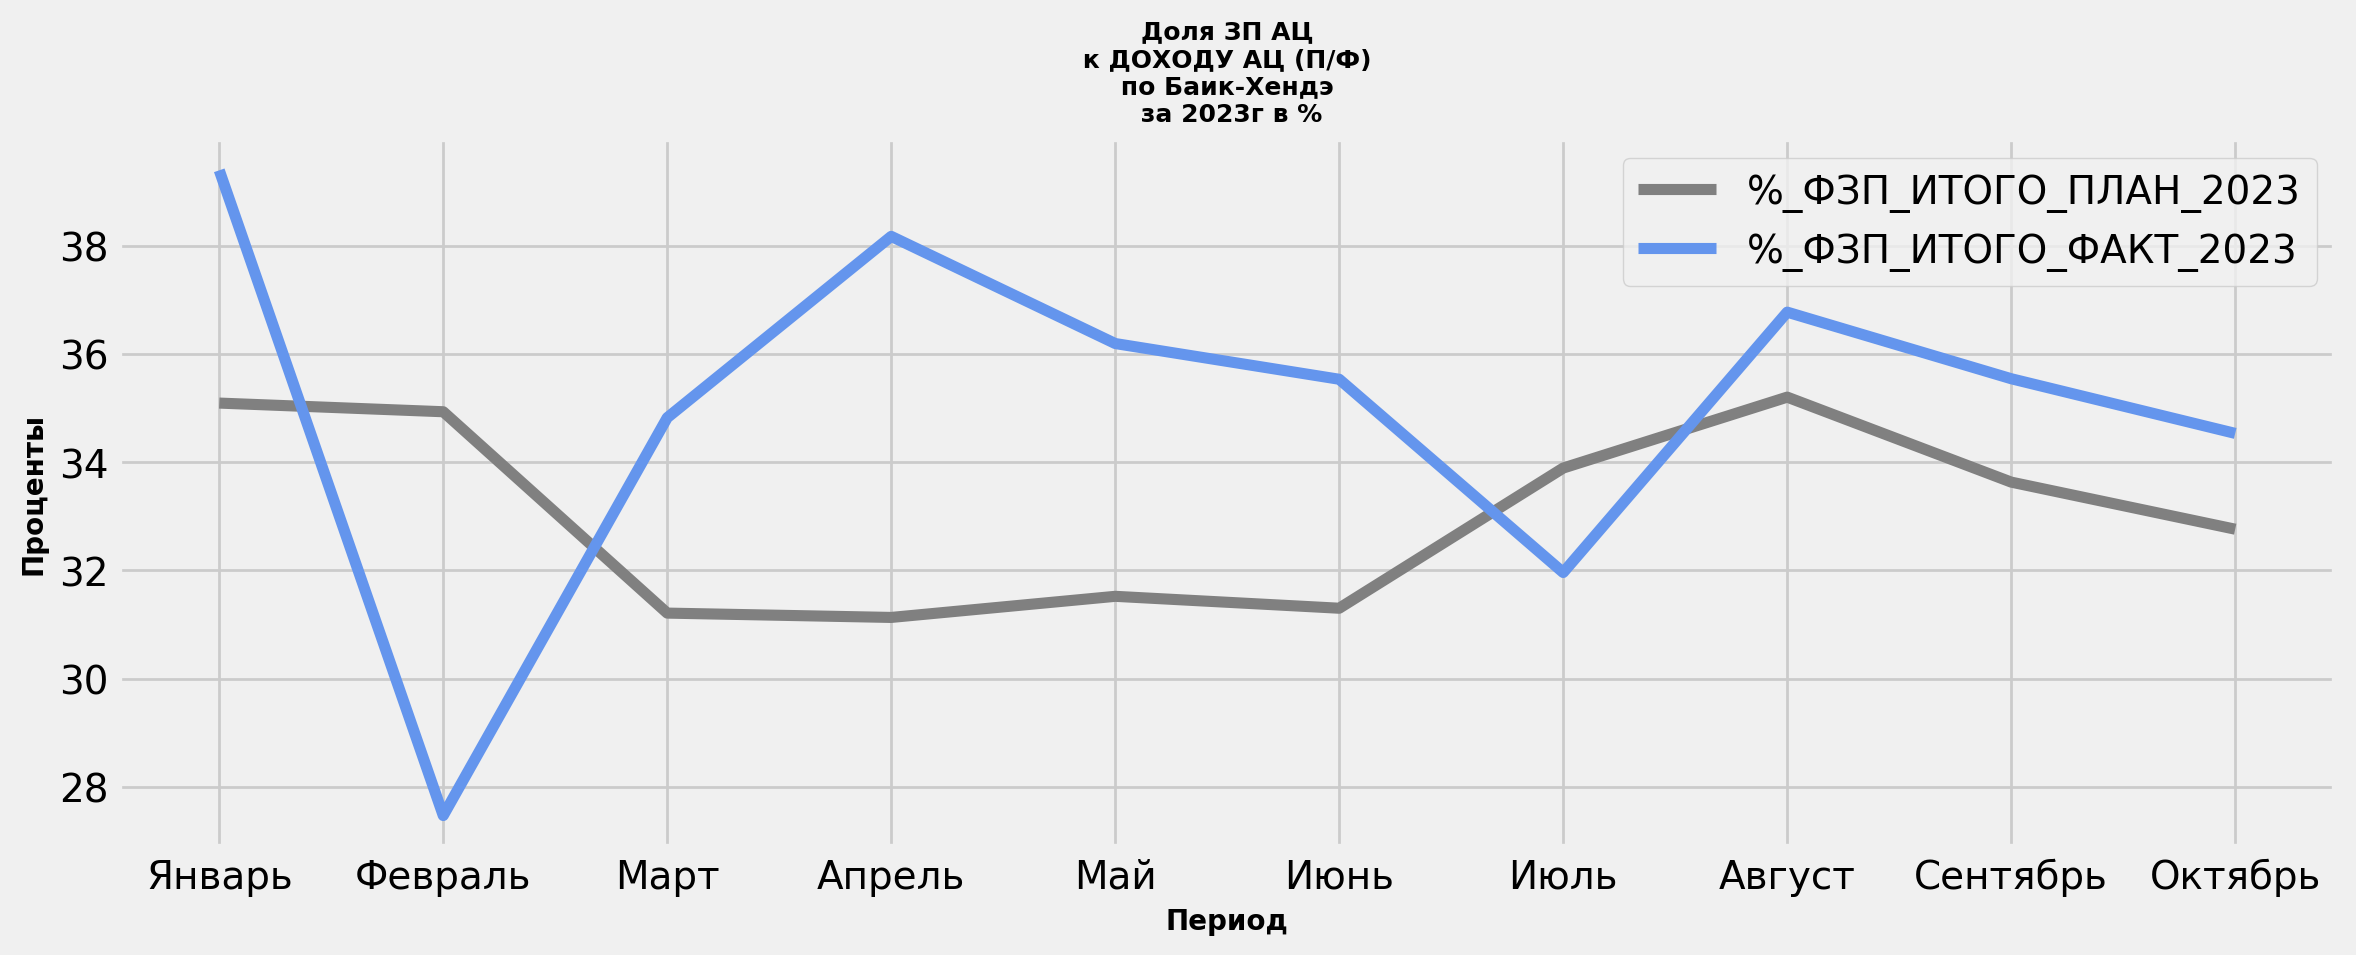

In [1373]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_ИТОГО_ПЛАН_{year_pf}'], label=f'%_ФЗП_ИТОГО_ПЛАН_{year_pf}', color='grey')
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_ИТОГО_ФАКТ_{year_pf}'], label=f'%_ФЗП_ИТОГО_ФАКТ_{year_pf}', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")
    plt.title(f"Доля ЗП АЦ\n к ДОХОДУ АЦ (П/Ф) \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig('Доля_ЗП_АЦ_1.png')
    plt.show()

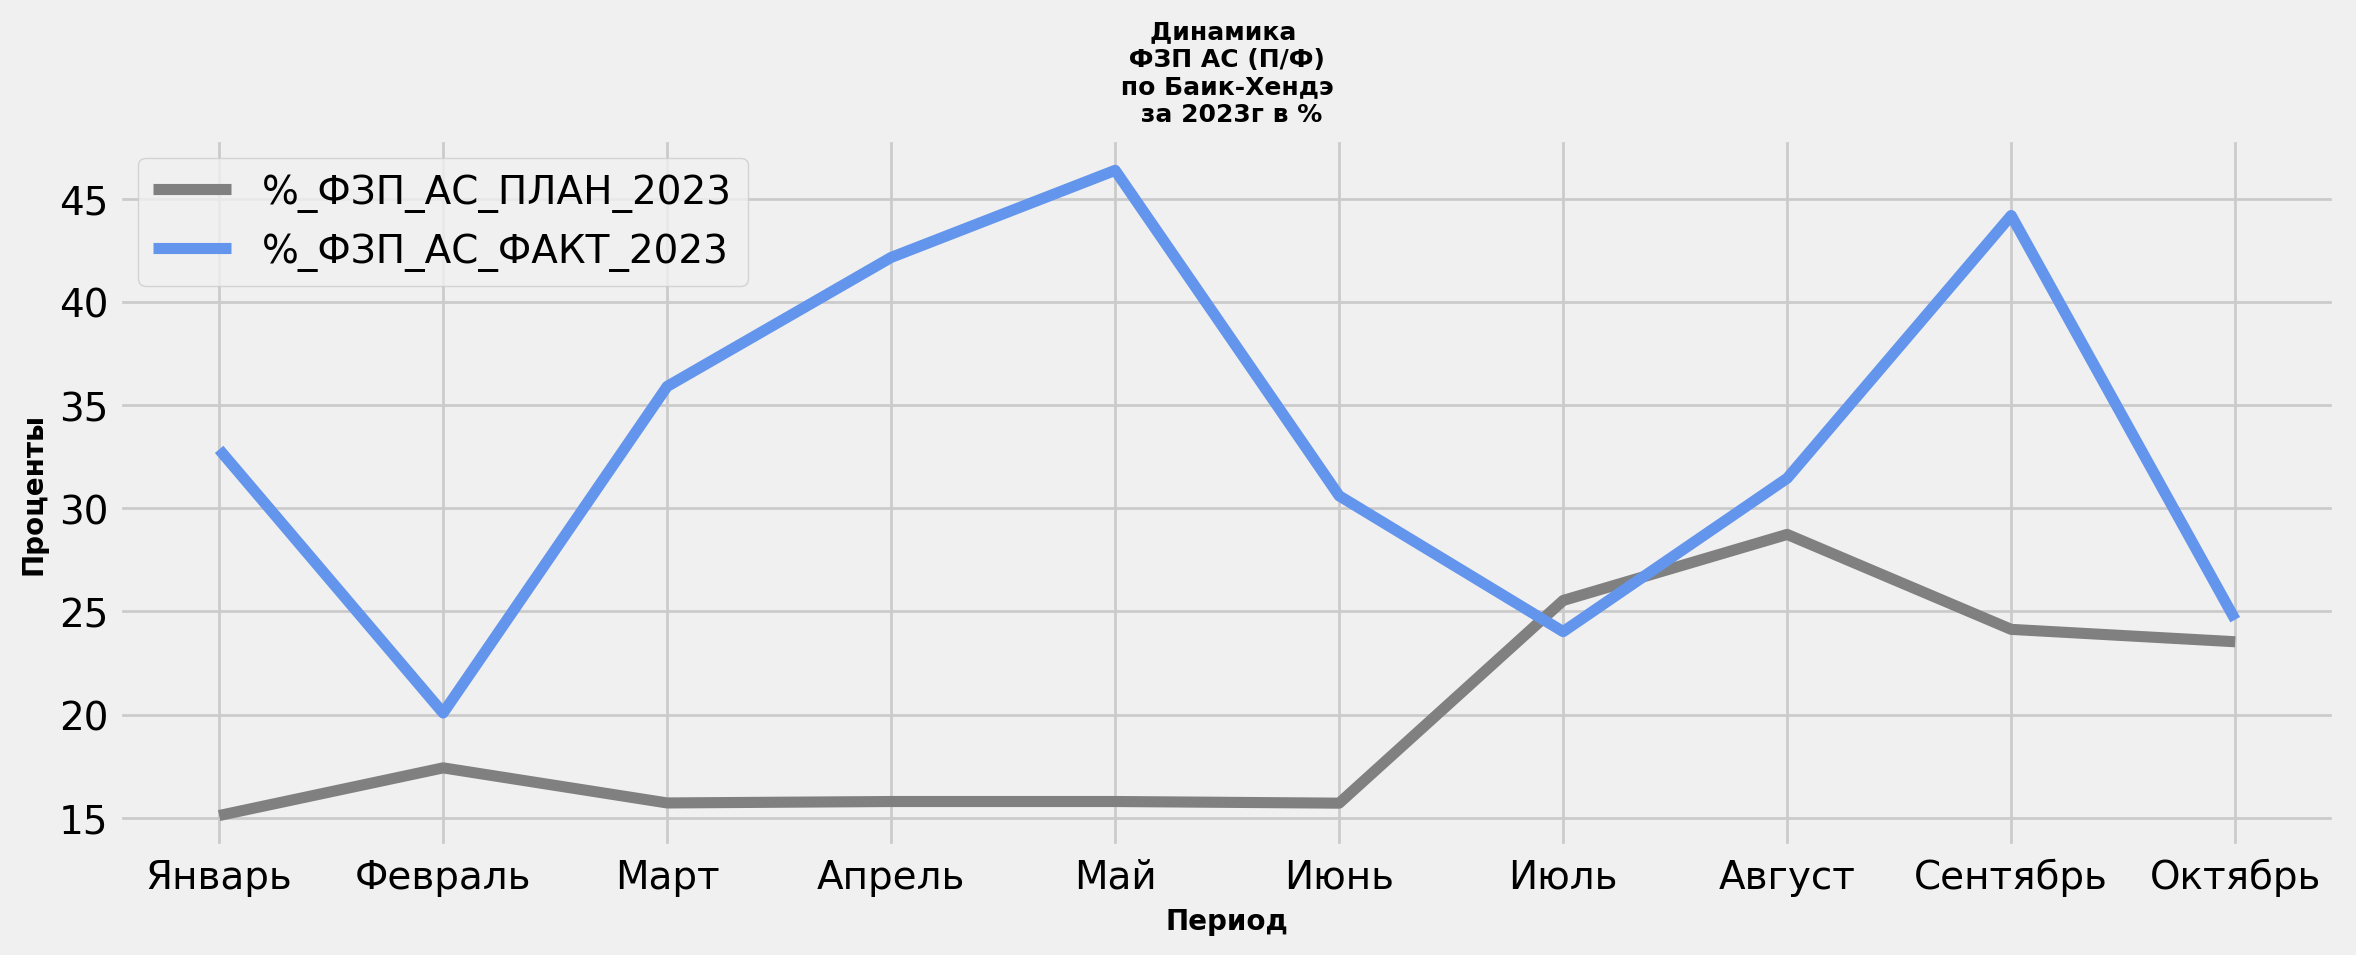

In [1374]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_АС_ПЛАН_{year_pf}'], label=f'%_ФЗП_АС_ПЛАН_{year_pf}', color='grey')
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_АС_ФАКТ_{year_pf}'], label=f'%_ФЗП_АС_ФАКТ_{year_pf}', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")
    plt.title(f"Динамика \n ФЗП АС (П/Ф) \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig('Динамика_ФЗП_АС.png')
    plt.show()

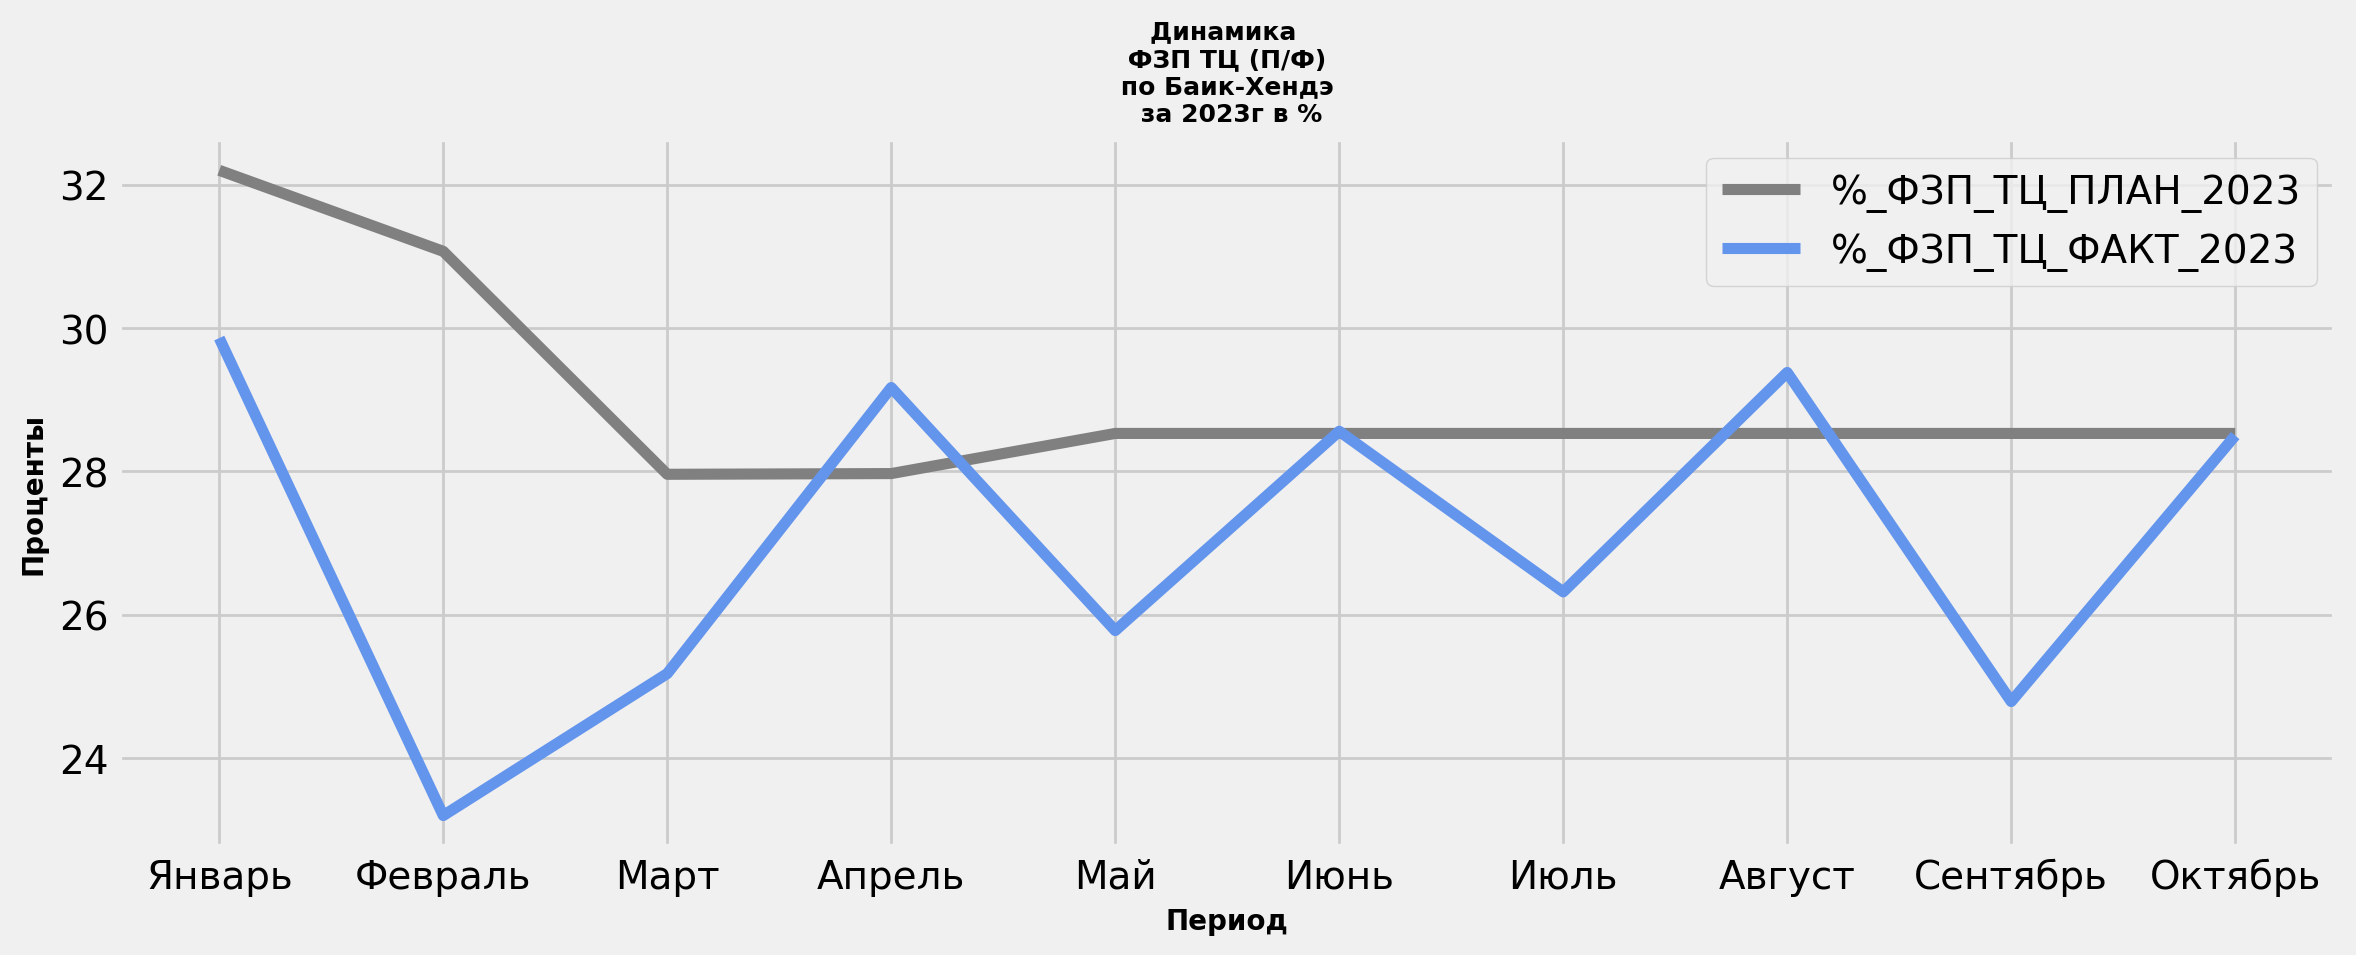

In [1375]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_ТЦ_ПЛАН_{year_pf}'], label=f'%_ФЗП_ТЦ_ПЛАН_{year_pf}', color='grey')
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_ТЦ_ФАКТ_{year_pf}'], label=f'%_ФЗП_ТЦ_ФАКТ_{year_pf}', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"Динамика \n ФЗП ТЦ (П/Ф) \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig('Динамика_ФЗП_ТЦ.png')
    plt.show()

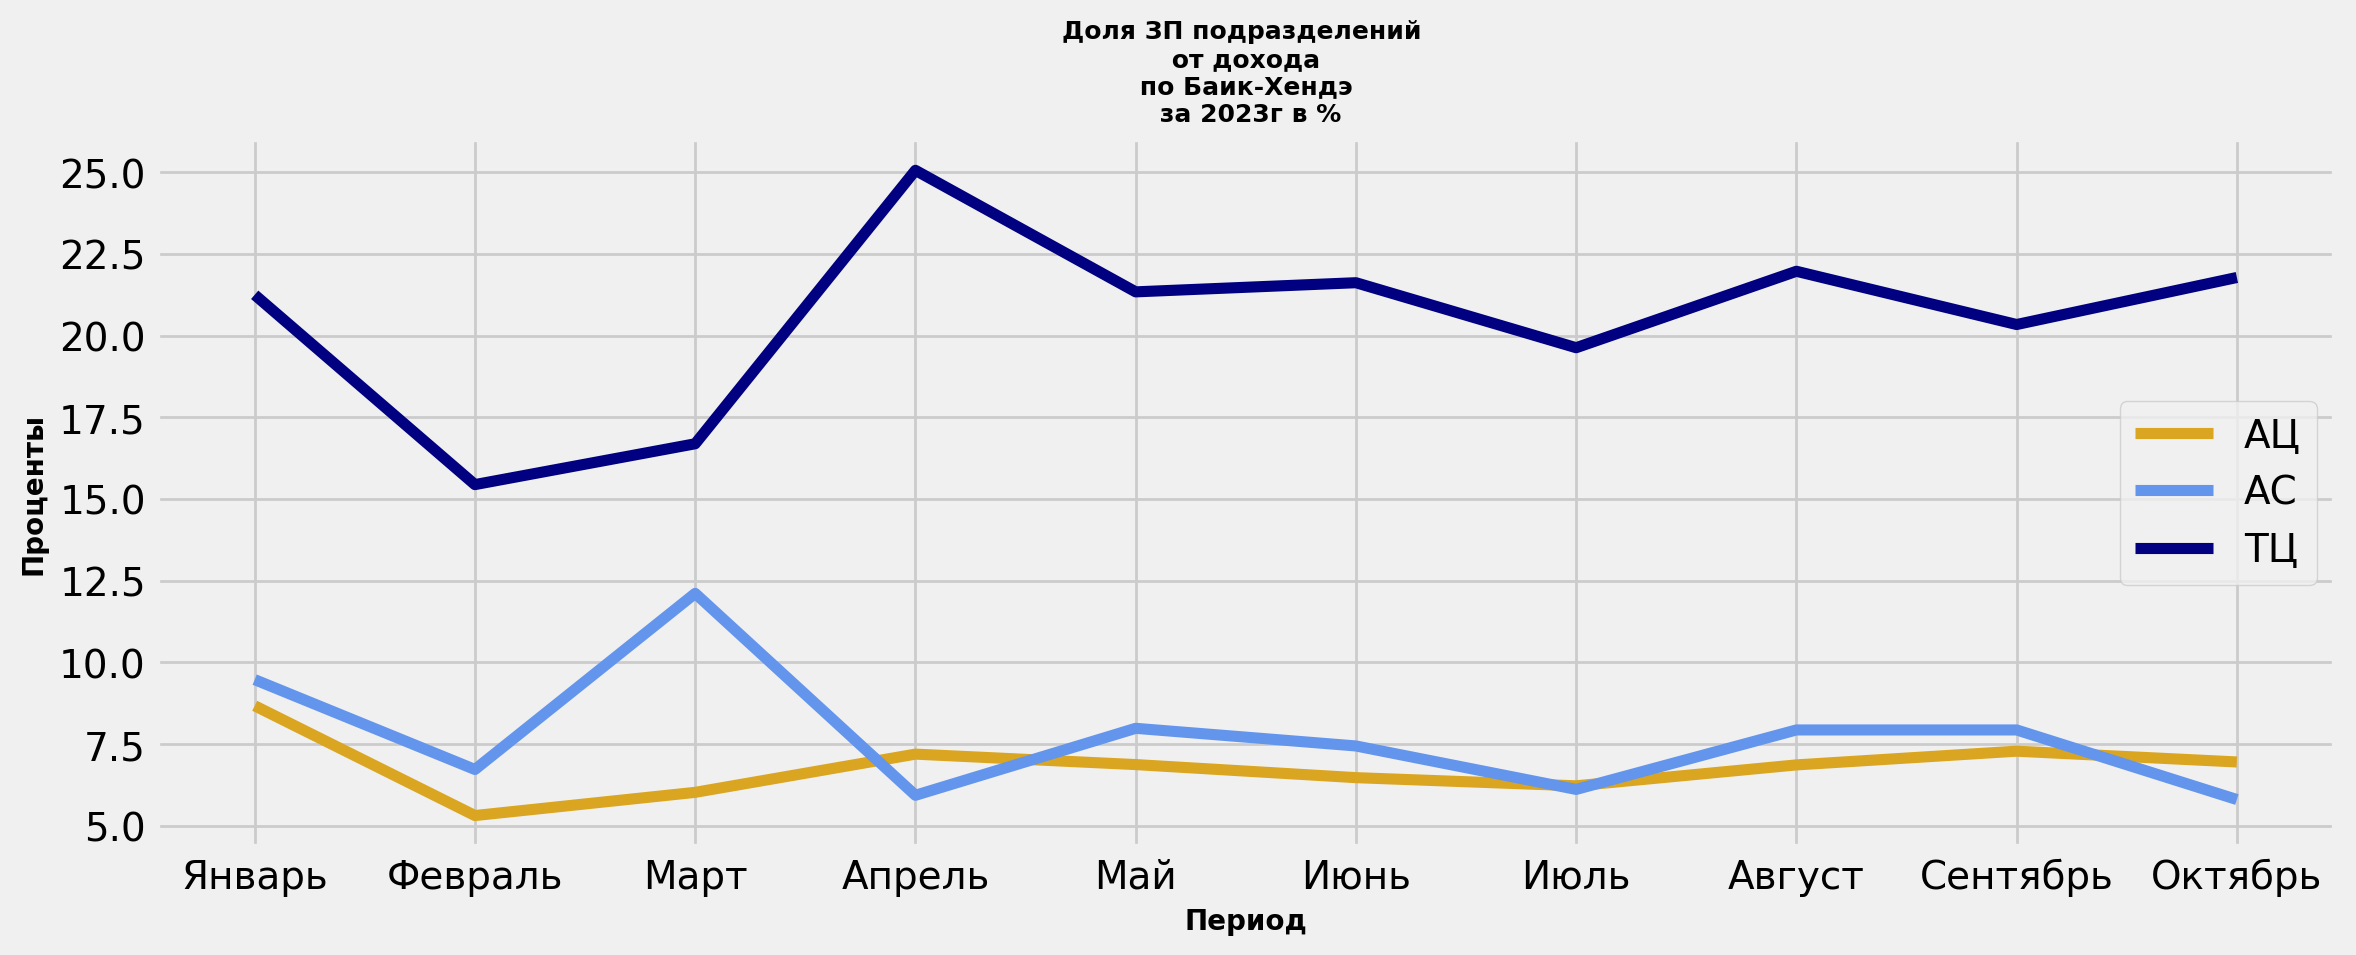

In [1376]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_АЦ_ОТ_ОБЩ_ДОХ_{year_pf}'], label=f'АЦ', color='goldenrod')
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_АС_ОТ_ОБЩ_ДОХ_{year_pf}'], label=f'АС', color='cornflowerblue')
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'%_ФЗП_ТЦ_ОТ_ОБЩ_ДОХ_{year_pf}'], label=f'ТЦ', color='navy')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")
    plt.title(f"Доля ЗП подразделений \n от дохода \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig('Доля_зп_подразделенй_от_дохода.png')
    plt.show()

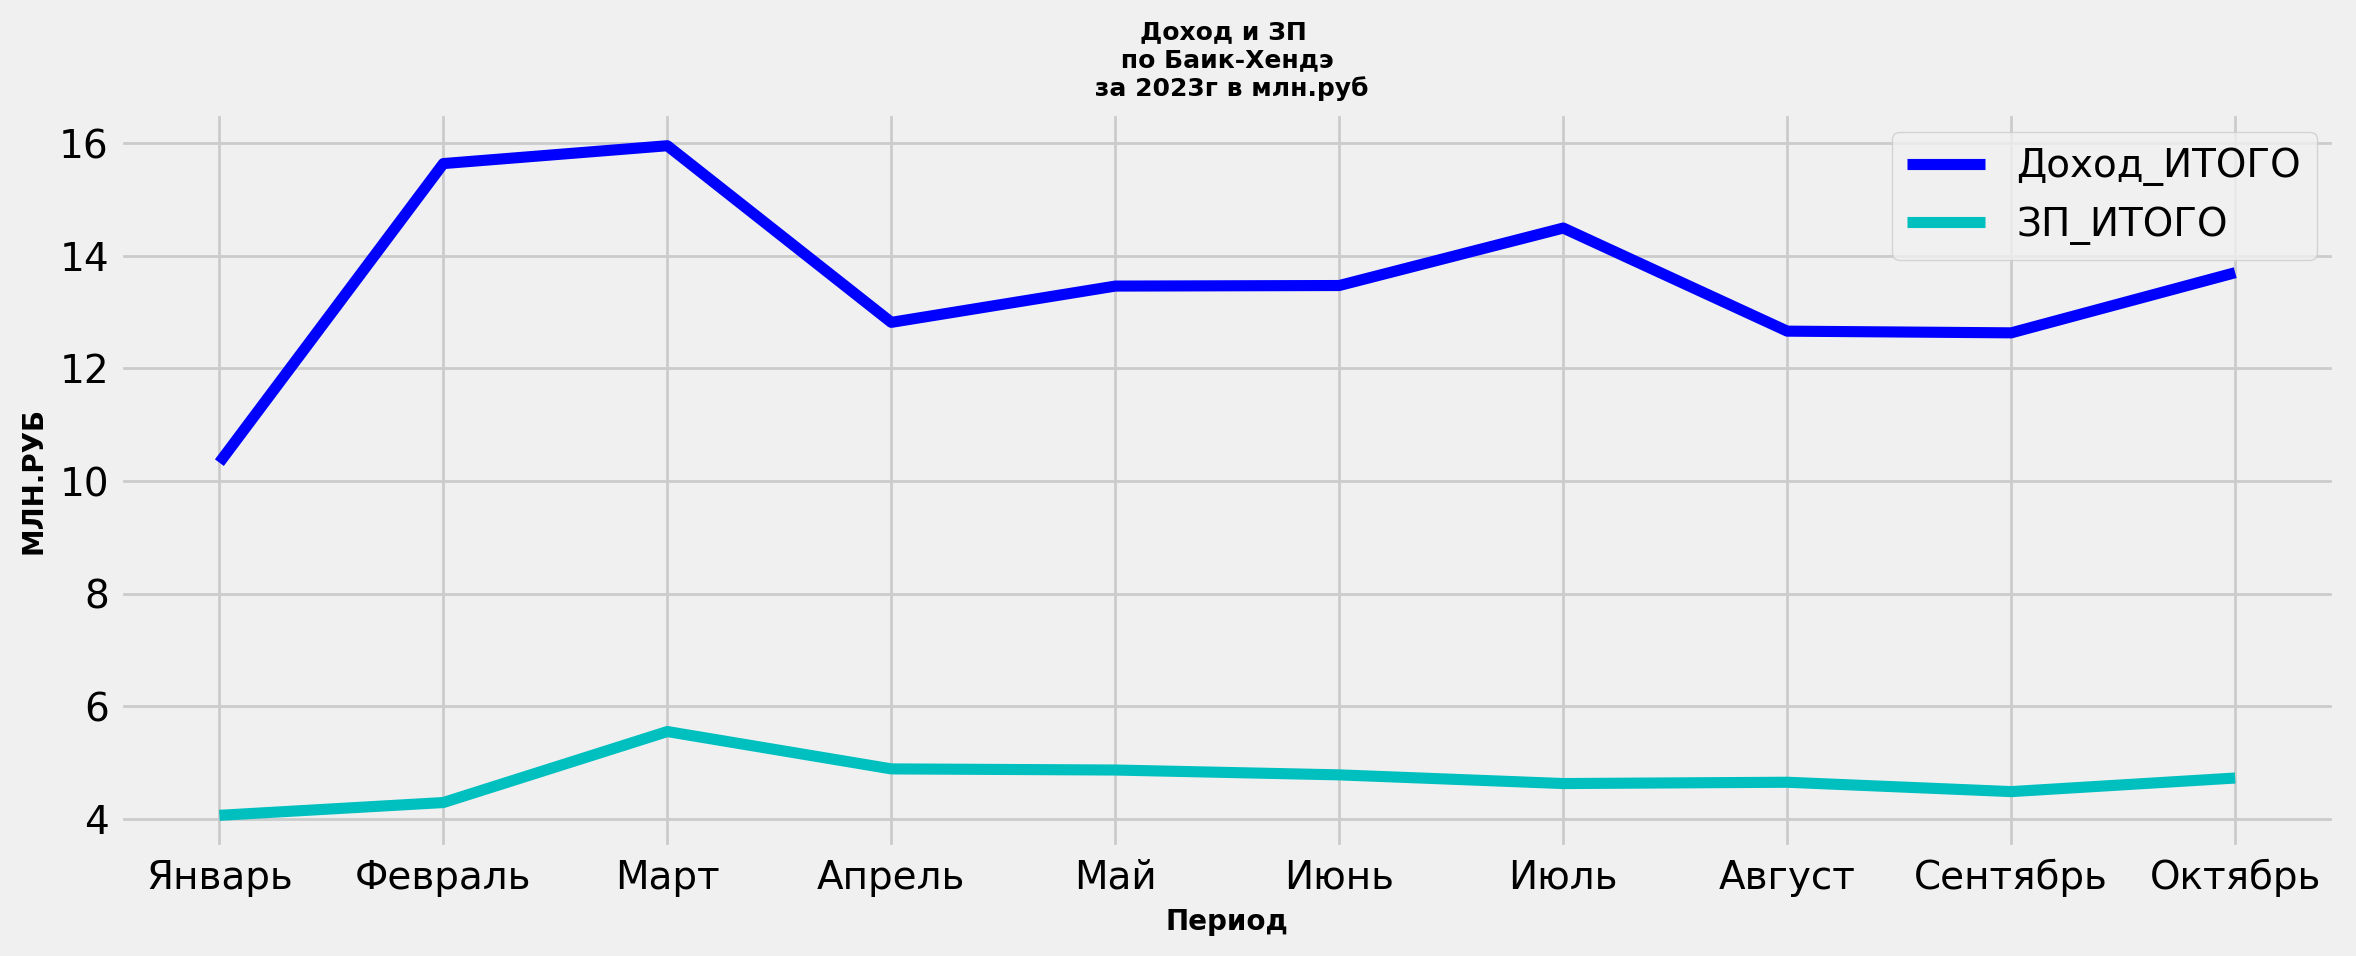

In [1377]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'факт_дох_АЦ_{year_pf}'], label=f'Доход_ИТОГО', color='b')
    plt.plot(df_DOX_ZP['месяц'], df_DOX_ZP[f'факт_ЗП_ИТОГО_{year_pf}'], label=f'ЗП_ИТОГО', color='c')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('МЛН.РУБ',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")
    
    plt.title(f"Доход и ЗП \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в млн.руб",fontsize = 9, fontweight="bold")
    
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig('Доход_к_зп_итого_.png')
    plt.show()

`Здесь ЗП >=85000 из ведомости`

In [1378]:
# округлим значения в ЗП
for i in df_ZP.columns:
    try:
        df_ZP[i] = df_ZP[i].apply(lambda x: round(Decimal(x)))
    except:
        print(i)

ФИО
Должность
Коэф от ст
Подразделение
Отдел
Истоник
Автоцентр
%_карты


In [1379]:
func_limit_ZP(df_ZP)

ФИО ЗП >= 100000            Должность  Оклад  \
9597       Агакишиев Эльдар Ариф-Оглы          Директор АЦ      0   
9598       Кирьянов Максим Николаевич      руководитель АС  60000   
9599          Зенкин Сергей Сергеевич      Руководитель ТЦ      0   
9610               Ройченко Александр         продавец а/м      0   
9615          Власов Андрей Сергеевич  продавец а/м старш.  40000   
9632          Смолин Сергей Сергеевич              механик      0   
9636  Хитров Константин Александрович         начальник МЦ      0   
9638        Зубков Виктор Анатольевич   мастер-консультант      0   
9650     Поветкин Дмитрий Анатольевич        начальник ОЗЧ  40000   
9653        Аринкин Владимир Петрович     начальник склада  32100   

      Рачетная ЗП  Вычет-Премия  Отпуск  Всего начислено   карта  %_карты  \
9597       300000          -982       0           299018  234900    78.60   
9598        69835             0       0           129835  103205    79.50   
9599       240000         -1964       0           238036  165691    69.60   
9610        11054         50000   41649           102703   91239    88.80   
9615        34918         55950       0           130868  125235    95.70   
9632       117984             0       0           115624  111914    96.80   
9636       103132         32100       0           135232  128716    95.20   
9638        85303             0     829           103421   99898    96.60   
9650       158017         13036       0           171053  160420    93.80   
9653        71783         35000       0           106783   37445    35.10   

     Подразделение   Отдел  
9597            АЦ  АЦ.Рук  
9598            АС  АС.Рук  
9599            ТЦ  ТЦ.рук  
9610            АС     ОПА  
9615            АС     ОПА  
9632            ТЦ      МЦ  
9636            ТЦ  ИТР.МЦ  
9638            ТЦ  ИТР.МЦ  
9650            ТЦ     ОЗЧ  
9653            ТЦ     ОЗЧ

`Здесь ЗП к ДОХОДУ в разбивке по подразделениям и подгруппам (ЗП из ВЕДОМОСТИ а не из PF)`

In [1380]:

doh_k_zp_itogo = pd.DataFrame({'Наименование': ['ФЗП_всего_к_дох_всего', 
                                                'ФЗП_РУК_к_дох_всего', 
                                                'ФЗП_АЦ_(без_РУК)_к_дох_всего', 
                                                'ФЗП_ТЦ_к_дох_ТЦ', 
                                                'ФЗП_АС_к_дох_АС'], 
                    'Доход': [func_IND_podr(df_PF, ind_pf_doh), 
                              func_IND_podr(df_PF, ind_pf_doh),
                              func_IND_podr(df_PF, ind_pf_doh),
                              func_IND_podr(df_PF, ind_pf_doh_tc),
                              func_IND_podr(df_PF, ind_pf_doh_as)
                              ],
                    'ФЗП': [func_ZP_podr_month(df_ZP),
                            func_ZP_podr_month(df_ZP, [], ['АЦ.Рук','АС.Рук','ТЦ.Рук']),
                            func_ZP_podr_month(df_ZP, ['АЦ'],['ФО','АЦ.общ']),
                            func_ZP_podr_month(df_ZP, ['ТЦ'], ['МЦ','ИТР.МЦ','ДО','ОЗЧ','КЦ','ИТР.КЦ']),
                            func_ZP_podr_month(df_ZP, ['АС'],['ОПА','АС.общ','ОВП']) ]
                    })

doh_k_zp_itogo = func_float_df_digit(doh_k_zp_itogo, float)
doh_k_zp_itogo['ФЗП_от_ДОХ_%'] = round(doh_k_zp_itogo['ФЗП']/doh_k_zp_itogo['Доход']*100, 2)
doh_k_zp_itogo = convertor_zeros(doh_k_zp_itogo, column=['Доход', 'ФЗП'])
doh_k_zp_itogo

func_float_df_digit: Наименование не преобразован в <class 'float'>


Наименование   Доход    ФЗП  ФЗП_от_ДОХ_%
0         ФЗП_всего_к_дох_всего  13.699  4.712         34.40
1           ФЗП_РУК_к_дох_всего  13.699  0.429          3.13
2  ФЗП_АЦ_(без_РУК)_к_дох_всего  13.699  0.513          3.75
3               ФЗП_ТЦ_к_дох_ТЦ  10.472  2.828         27.00
4               ФЗП_АС_к_дох_АС   3.227  0.704         21.82

In [1381]:

ttime_per = func_IND_podr(df_PF, ind_pf_doh_as) \
    + func_IND_podr(df_PF, om_ovp)\
    - func_IND_podr(df_PF, ind_pf_doh_ovp)\
    - func_IND_podr(df_PF, ind_pf_doh_prch_usl)\
    - func_IND_podr(df_PF, ind_pf_doh_otch_oup)


doh_k_zp_AS = pd.DataFrame({'Наименование': ['ФЗП_АСнов(отдел_ОПА)_к_дох_АСнов', 
                                             'ФЗП_ОВП(отдел_ОВП)_к_дох_ОВП'],
                            'Доход':[ttime_per, 
                                    func_IND_podr(df_PF, ind_pf_doh_as) - ttime_per],
                            'ФЗП': [func_ZP_podr_month(df_ZP, ['АС'], ['ОПА']) ,
                                    func_ZP_podr_month(df_ZP, ['АС'], ['ОВП'])]})

doh_k_zp_AS = func_float_df_digit(doh_k_zp_AS)

doh_k_zp_AS['ФЗП_от_ДОХ_%'] = round(doh_k_zp_AS['ФЗП']/doh_k_zp_AS['Доход']*100, 2)
del ttime_per
doh_k_zp_AS.fillna(0)
doh_k_zp_AS = convertor_zeros(doh_k_zp_AS, column=['Доход', 'ФЗП'])
doh_k_zp_AS

func_float_df_digit: Наименование не преобразован в <class 'float'>


Наименование  Доход    ФЗП  ФЗП_от_ДОХ_%
0  ФЗП_АСнов(отдел_ОПА)_к_дох_АСнов  3.227  0.458         14.19
1      ФЗП_ОВП(отдел_ОВП)_к_дох_ОВП  0.000  0.000           NaN

In [1382]:
doh_k_zp_TC = pd.DataFrame({'Наименование': ['ФЗП_МЦ_к_дох_МЦ', 
                                             'ФЗП_КЦ_к_дох_КЦ', 
                                             'ФЗП_ДО_к_дох_ДО'],
                            'Доход':[func_IND_podr(df_PF, ind_pf_doh_meh),
                                    func_IND_podr(df_PF, ind_pf_doh_kuz),
                                    func_IND_podr(df_PF, ind_pf_doh_do)],
                            'ФЗП': [func_ZP_podr_month(df_ZP, ['ТЦ'],['МЦ', 'ИТР.МЦ']),
                                    func_ZP_podr_month(df_ZP, ['ТЦ'],['КЦ', 'ИТР.КЦ']),
                                    func_ZP_podr_month(df_ZP, ['ТЦ'],['ДО'])
                                    ]})


doh_k_zp_TC = func_float_df_digit(doh_k_zp_TC)

doh_k_zp_TC['ФЗП_от_ДОХ_%'] = round(doh_k_zp_TC['ФЗП']/doh_k_zp_TC['Доход']*100, 2)
doh_k_zp_TC = doh_k_zp_TC.fillna(0)
doh_k_zp_TC = convertor_zeros(doh_k_zp_TC, column=['Доход', 'ФЗП'])
doh_k_zp_TC

func_float_df_digit: Наименование не преобразован в <class 'float'>


Наименование   Доход    ФЗП  ФЗП_от_ДОХ_%
0  ФЗП_МЦ_к_дох_МЦ  10.161  2.192         21.58
1  ФЗП_КЦ_к_дох_КЦ   0.000  0.000          0.00
2  ФЗП_ДО_к_дох_ДО   0.155  0.069         44.48

In [1383]:
doh_k_zp_MC = pd.DataFrame({'Наименование': ['ФЗП_МЦ_к_дох_МЦ', 'ФЗП_механиков_к_дох_МЦ', 'ФЗП_ИТР_МЦ_к_дох_МЦ'],
                            'Доход':[func_IND_podr(df_PF, ind_pf_doh_meh),
                                     func_IND_podr(df_PF, ind_pf_doh_meh),
                                     func_IND_podr(df_PF, ind_pf_doh_meh)],
                            'ФЗП': [func_ZP_podr_month(df_ZP, ['ТЦ'], ['МЦ','ИТР.МЦ']),
                                    func_ZP_podr_month(df_ZP, ['ТЦ'], ['МЦ']),
                                    func_ZP_podr_month(df_ZP, ['ТЦ'], ['ИТР.МЦ'])
                                    ]})

doh_k_zp_MC = func_float_df_digit(doh_k_zp_MC)
doh_k_zp_MC['ФЗП_от_ДОХ_%'] = round(doh_k_zp_MC['ФЗП']/doh_k_zp_MC['Доход']*100, 2)
doh_k_zp_MC = convertor_zeros(doh_k_zp_MC, column=['Доход', 'ФЗП'])
doh_k_zp_MC

func_float_df_digit: Наименование не преобразован в <class 'float'>


Наименование   Доход    ФЗП  ФЗП_от_ДОХ_%
0         ФЗП_МЦ_к_дох_МЦ  10.161  2.192         21.58
1  ФЗП_механиков_к_дох_МЦ  10.161  1.054         10.37
2     ФЗП_ИТР_МЦ_к_дох_МЦ  10.161  1.138         11.20

In [1384]:
doh_k_zp_KC = pd.DataFrame({'Наименование': ['ФЗП_КЦ_к_дох_КЦ', 
                                             'ФЗП_механиков_к_дох_КЦ', 
                                             'ФЗП_ИТР_МЦ_к_дох_КЦ'],
                            'Доход':[func_IND_podr(df_PF, ind_pf_doh_kuz),
                                     func_IND_podr(df_PF, ind_pf_doh_kuz),
                                     func_IND_podr(df_PF, ind_pf_doh_kuz)],
                            'ФЗП': [func_ZP_podr_month(df_ZP, ['ТЦ'], ['КЦ','ИТР.КЦ']),
                                    func_ZP_podr_month(df_ZP, ['ТЦ'], ['КЦ']),
                                    func_ZP_podr_month(df_ZP, ['ТЦ'], ['ИТР.КЦ'])
                                    ]})

doh_k_zp_KC = func_float_df_digit(doh_k_zp_KC)
doh_k_zp_KC['ФЗП_от_ДОХ_%'] = round(doh_k_zp_KC['ФЗП']/doh_k_zp_KC['Доход']*100, 2)
doh_k_zp_KC = doh_k_zp_KC.fillna(0)
doh_k_zp_KC = convertor_zeros(doh_k_zp_KC, column=['Доход', 'ФЗП'])
doh_k_zp_KC

func_float_df_digit: Наименование не преобразован в <class 'float'>


Наименование  Доход    ФЗП  ФЗП_от_ДОХ_%
0         ФЗП_КЦ_к_дох_КЦ  0.000  0.000          0.00
1  ФЗП_механиков_к_дох_КЦ  0.000  0.000          0.00
2     ФЗП_ИТР_МЦ_к_дох_КЦ  0.000  0.000          0.00

`Все то-же ЗП к ДОХОДУ но с начала года`

In [1385]:
doh_itog_k_zp_itog = Indicators('ЗП_итого_к_Доходу_итого', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, [], []), how='left'))
doh_itog_k_zp_itog.rename()
doh_itog_k_zp_itog.info()
convertor_zeros(doh_itog_k_zp_itog.df) # в самом классе df не конверитирован в 0.000 три знака после запятой

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_итого_к_Доходу_итого
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь              10.327           3.977         38.51
1   Февраль              15.635           4.241         27.12
2      Март              15.952           5.443         34.12
3    Апрель              12.817           4.787         37.35
4       Май              13.461           4.856         36.07
5      Июнь              13.471           4.665         34.63
6      Июль              14.491           4.525         31.23
7    Август              12.661           4.549         35.93
8  Сентябрь              12.631           4.365         34.56
9   Октябрь              13.699           4.712         34.40

In [1386]:
doh_itog_k_zp_ruk = Indicators('Доход_итого_к_ЗП_РУК', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, [], ['АЦ.Рук','АС.Рук','ТЦ.Рук']), how='left'))
doh_itog_k_zp_ruk.rename()
doh_itog_k_zp_ruk.info()
convertor_zeros(doh_itog_k_zp_ruk.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
Доход_итого_к_ЗП_РУК
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь              10.327           0.331          3.21
1   Февраль              15.635           0.389          2.49
2      Март              15.952           0.431          2.70
3    Апрель              12.817           0.340          2.65
4       Май              13.461           0.352          2.61
5      Июнь              13.471           0.373          2.77
6      Июль              14.491           0.382          2.64
7    Август              12.661           0.373          2.94
8  Сентябрь              12.631           0.348          2.76
9   Октябрь              13.699           0.429          3.13

In [1387]:
doh_itog_k_zp_AC = Indicators('Доход_итого_к_ЗП_АЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['АЦ'], ['ФО','АЦ.общ']), how='left'))
doh_itog_k_zp_AC.rename()
doh_itog_k_zp_AC.info()
convertor_zeros(doh_itog_k_zp_AC.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
Доход_итого_к_ЗП_АЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь              10.327           0.547          5.30
1   Февраль              15.635           0.500          3.20
2      Март              15.952           0.541          3.39
3    Апрель              12.817           0.558          4.35
4       Май              13.461           0.563          4.18
5      Июнь              13.471           0.509          3.78
6      Июль              14.491           0.537          3.71
7    Август              12.661           0.485          3.83
8  Сентябрь              12.631           0.546          4.32
9   Октябрь              13.699           0.513          3.75

In [1388]:
doh_TC_k_zp_TC = Indicators('ЗП_ТЦ_к_Доходу_ТЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_tc, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['МЦ','ИТР.МЦ','ДО','ОЗЧ','КЦ','ИТР.КЦ']), how='left'))
doh_TC_k_zp_TC.rename()
doh_TC_k_zp_TC.info()
convertor_zeros(doh_TC_k_zp_TC.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_ТЦ_к_Доходу_ТЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               7.350           2.041         27.76
1   Февраль              10.407           2.230         21.43
2      Март              10.571           2.437         23.05
3    Апрель              11.013           3.017         27.40
4       Май              11.145           2.748         24.65
5      Июнь              10.197           2.708         26.56
6      Июль              10.808           2.663         24.64
7    Август               9.470           2.618         27.65
8  Сентябрь              10.363           2.377         22.94
9   Октябрь              10.472           2.828         27.00

In [1389]:
doh_AS_k_zp_AS = Indicators('ЗП_АС_общая_к_Доходу_АС_общему', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_as, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['АС'], ['ОПА','АС.общ','ОВП']), how='left'))
doh_AS_k_zp_AS.rename()
doh_AS_k_zp_AS.info()
convertor_zeros(doh_AS_k_zp_AS.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_АС_общая_к_Доходу_АС_общему
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               2.977           0.896         30.11
1   Февраль               5.228           0.917         17.54
2      Март               5.382           1.799         33.43
3    Апрель               1.803           0.660         36.57
4       Май               2.316           0.962         41.53
5      Июнь               3.274           0.870         26.57
6      Июль               3.684           0.741         20.12
7    Август               3.192           0.879         27.53
8  Сентябрь               2.268           0.893         39.36
9   Октябрь               3.227           0.704         21.82

In [1390]:
# доход АС новых авто и ОВП нужно разделить собираем по новым авто
res_dhs = func_IND_podr_year(df_PF, ind_pf_doh_as, 'факт')
res_dhs = res_dhs.rename(columns={res_dhs.columns[-1] : f"{ind_pf_doh_as}"})

res_om_ovp = func_IND_podr_year(df_PF, om_ovp, 'факт')
res_om_ovp = res_om_ovp.rename(columns={res_om_ovp.columns[-1] : f"{om_ovp}"})

res_dh_ovp = func_IND_podr_year(df_PF, ind_pf_doh_ovp, 'факт')
res_dh_ovp = res_dh_ovp.rename(columns={res_dh_ovp.columns[-1] : f"{ind_pf_doh_ovp}"})

res_dh_prch_ul = func_IND_podr_year(df_PF, ind_pf_doh_prch_usl, 'факт')
res_dh_prch_ul = res_dh_prch_ul.rename(columns={res_dh_prch_ul.columns[-1] : f"{ind_pf_doh_prch_usl}"})

res_dh_otch_ovp = func_IND_podr_year(df_PF, ind_pf_doh_otch_oup, 'факт')
res_dh_otch_ovp = res_dh_otch_ovp.rename(columns={res_dh_otch_ovp.columns[-1] : f"{ind_pf_doh_otch_oup}"})

res_time = pd.merge(res_dhs, res_om_ovp, how='left')
for i in [res_dh_ovp, res_dh_prch_ul, res_dh_otch_ovp]:
    res_time = pd.merge(res_time, i, how='left')
    
res_time['факт_дох_АСнов'] = res_time['220'] + res_time['1513'] - res_time['БуДох'] - res_time['1420'] - res_time['1514']
res_time = res_time[['месяц','факт_дох_АСнов']]
#res_time

func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>


In [1391]:
# отдельно собираем ЗП АС новых ам
res_zp_as_n = func_ZP_podr_all_year(df_ZP, ['АС'], ['ОПА'])

In [1392]:
doh_ASnew_k_zp_ASnew = Indicators('ЗП_АС_нов_к_Доходу_АС_нов', 'итого',
               pd.merge(res_time, 
                        res_zp_as_n, how='left'))
doh_ASnew_k_zp_ASnew.rename()
doh_ASnew_k_zp_ASnew.info()
convertor_zeros(doh_ASnew_k_zp_ASnew.df)

ЗП_АС_нов_к_Доходу_АС_нов
месяц не удалось преобразовать


месяц итого_факт_дох_АСнов Всего начислено  ФЗП_от_ДОХ_%
0    Январь                2.179           0.575         26.41
1   Февраль                4.714           0.587         12.46
2      Март                1.951           1.468         75.27
3    Апрель                1.034           0.362         34.98
4       Май                2.316           0.624         26.94
5      Июнь                2.695           0.584         21.65
6      Июль                2.014           0.447         22.20
7    Август                2.886           0.524         18.16
8  Сентябрь                2.268           0.569         25.08
9   Октябрь                3.227           0.458         14.19

In [1393]:
# собираем доход овп
res_doh_as_ovp =  pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_as, 'факт'), res_time, how='left')
res_doh_as_ovp['доход_ОВП'] = res_doh_as_ovp[f'факт_дох_{year_pf}'] - res_doh_as_ovp['факт_дох_АСнов']
res_doh_as_ovp = res_doh_as_ovp[['месяц','доход_ОВП']]
#res_doh_as_ovp

func_float_df_digit: месяц не преобразован в <class 'float'>


In [1394]:
doh_AS_k_zp_AS_ovp = Indicators('ЗП_АС_овп_к_Доходу_АС_овп', 'итого',
               pd.merge(res_doh_as_ovp, 
                        func_ZP_podr_all_year(df_ZP, ['АС'], ['ОВП']), how='left').fillna(0))
doh_AS_k_zp_AS_ovp.rename()
doh_AS_k_zp_AS_ovp.info()
convertor_zeros(doh_AS_k_zp_AS_ovp.df)

ЗП_АС_овп_к_Доходу_АС_овп
месяц не удалось преобразовать


месяц итого_доход_ОВП Всего начислено  ФЗП_от_ДОХ_%
0    Январь           0.798           0.000          0.00
1   Февраль           0.514           0.000          0.00
2      Март           3.431           0.000          0.00
3    Апрель           0.770           0.000          0.00
4       Май           0.000           0.000          0.00
5      Июнь           0.579           0.000          0.00
6      Июль           1.670           0.000          0.00
7    Август           0.306           0.000          0.00
8  Сентябрь           0.000           0.000          0.00
9   Октябрь           0.000           0.000          0.00

In [1395]:
doh_MC_k_zp_MC = Indicators('ЗП_МЦ_к_Доходу_МЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_meh, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['МЦ', 'ИТР.МЦ']), how='left'))
doh_MC_k_zp_MC.rename()
doh_MC_k_zp_MC.info()
convertor_zeros(doh_MC_k_zp_MC.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_МЦ_к_Доходу_МЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               7.286           1.501         20.60
1   Февраль               8.022           1.526         19.03
2      Март               9.572           1.770         18.49
3    Апрель              10.733           2.309         21.52
4       Май               9.523           2.006         21.07
5      Июнь              10.050           2.036         20.26
6      Июль              10.709           2.051         19.15
7    Август               9.386           1.990         21.21
8  Сентябрь              10.106           1.676         16.59
9   Октябрь              10.161           2.192         21.58

In [1396]:
doh_MC_k_zp_MC_meh = Indicators('ЗП_мех_МЦ_к_Доходу_МЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_meh, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['МЦ']), how='left'))
doh_MC_k_zp_MC_meh.rename()
doh_MC_k_zp_MC_meh.info()
convertor_zeros(doh_MC_k_zp_MC_meh.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_мех_МЦ_к_Доходу_МЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               7.286           0.745         10.23
1   Февраль               8.022           0.688          8.58
2      Март               9.572           0.809          8.46
3    Апрель              10.733           1.083         10.09
4       Май               9.523           0.950          9.98
5      Июнь              10.050           1.033         10.28
6      Июль              10.709           1.035          9.67
7    Август               9.386           0.962         10.25
8  Сентябрь              10.106           0.743          7.35
9   Октябрь              10.161           1.054         10.37

In [1397]:
doh_MC_k_zp_MC_itr = Indicators('ЗП_итр_МЦ_к_Доходу_МЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_meh, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['ИТР.МЦ']), how='left'))
doh_MC_k_zp_MC_itr.rename()
doh_MC_k_zp_MC_itr.info()
convertor_zeros(doh_MC_k_zp_MC_itr.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_итр_МЦ_к_Доходу_МЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               7.286           0.756         10.37
1   Февраль               8.022           0.838         10.45
2      Март               9.572           0.961         10.04
3    Апрель              10.733           1.226         11.43
4       Май               9.523           1.056         11.09
5      Июнь              10.050           1.003          9.98
6      Июль              10.709           1.016          9.49
7    Август               9.386           1.028         10.96
8  Сентябрь              10.106           0.933          9.23
9   Октябрь              10.161           1.138         11.20

In [1398]:
doh_KC_k_zp_KC = Indicators('ЗП_КЦ_к_Доходу_КЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_kuz, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['КЦ', 'ИТР.КЦ']), how='left').fillna(0))
doh_KC_k_zp_KC.rename()
doh_KC_k_zp_KC.info()
convertor_zeros(doh_KC_k_zp_KC.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_КЦ_к_Доходу_КЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               0.005           0.000          0.00
1   Февраль               0.027           0.000          0.00
2      Март               0.000           0.000          0.00
3    Апрель               0.000           0.000          0.00
4       Май               0.022           0.000          0.00
5      Июнь               0.007           0.000          0.00
6      Июль               0.097           0.000          0.00
7    Август               0.046           0.000          0.00
8  Сентябрь               0.000           0.000          0.00
9   Октябрь               0.000           0.000          0.00

In [1399]:
doh_KC_k_zp_KC_meh = Indicators('ЗП_мех_КЦ_к_Доходу_КЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_kuz, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['КЦ']), how='left').fillna(0))
doh_KC_k_zp_KC_meh.rename()
doh_KC_k_zp_KC_meh.info()
convertor_zeros(doh_KC_k_zp_KC_meh.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_мех_КЦ_к_Доходу_КЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               0.005           0.000          0.00
1   Февраль               0.027           0.000          0.00
2      Март               0.000           0.000          0.00
3    Апрель               0.000           0.000          0.00
4       Май               0.022           0.000          0.00
5      Июнь               0.007           0.000          0.00
6      Июль               0.097           0.000          0.00
7    Август               0.046           0.000          0.00
8  Сентябрь               0.000           0.000          0.00
9   Октябрь               0.000           0.000          0.00

In [1400]:
doh_KC_k_zp_KC_itr = Indicators('ЗП_итр_КЦ_к_Доходу_КЦ', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_kuz, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['ИТР.КЦ']), how='left').fillna(0))
doh_KC_k_zp_KC_itr.rename()
doh_KC_k_zp_KC_itr.info()
convertor_zeros(doh_KC_k_zp_KC_itr.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_итр_КЦ_к_Доходу_КЦ
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               0.005           0.000          0.00
1   Февраль               0.027           0.000          0.00
2      Март               0.000           0.000          0.00
3    Апрель               0.000           0.000          0.00
4       Май               0.022           0.000          0.00
5      Июнь               0.007           0.000          0.00
6      Июль               0.097           0.000          0.00
7    Август               0.046           0.000          0.00
8  Сентябрь               0.000           0.000          0.00
9   Октябрь               0.000           0.000          0.00

In [1401]:
doh_DO_k_zp_DO = Indicators('ЗП_ДО_к_Доходу_ДО', 'итого',
               pd.merge(func_IND_podr_year(df_PF, ind_pf_doh_do, 'факт'), 
                        func_ZP_podr_all_year(df_ZP, ['ТЦ'], ['ДО']), how='left'))
doh_DO_k_zp_DO.rename()
doh_DO_k_zp_DO.info()
convertor_zeros(doh_DO_k_zp_DO.df)

func_float_df_digit: месяц не преобразован в <class 'float'>
ЗП_ДО_к_Доходу_ДО
месяц не удалось преобразовать


месяц итого_факт_дох_2023 Всего начислено  ФЗП_от_ДОХ_%
0    Январь               0.261           0.067         25.61
1   Февраль               0.573           0.102         17.86
2      Март               0.346           0.131         37.82
3    Апрель               0.277           0.086         31.05
4       Май               0.614           0.103         16.70
5      Июнь               0.290           0.077         26.44
6      Июль               0.060           0.076        127.25
7    Август               0.188           0.075         39.77
8  Сентябрь               0.130           0.071         54.44
9   Октябрь               0.155           0.069         44.48

`Численность с нарост`

In [1402]:
#Численность ТЦ
pers_count_TC = func_ZP_count_pers(df_ZP, month_pf, ['ТЦ'], [])
#Численность МЦ
pers_count_MC = func_ZP_count_pers(df_ZP, month_pf, [], ['МЦ', 'ИТР.МЦ'])
#Численность КЦ
pers_count_KC = func_ZP_count_pers(df_ZP, month_pf, [], ['КЦ', 'ИТР.КЦ'])
#Численность ДО
pers_count_DO = func_ZP_count_pers(df_ZP, month_pf, [], ['ДО', 'ИТР.ДО'])
#Численность прочие
pers_count_proch = np.array(func_ZP_count_pers(df_ZP, month_pf, ['ТЦ'], [])) - \
    np.array(func_ZP_count_pers(df_ZP, month_pf, [], ['МЦ', 'ИТР.МЦ'])) -\
    np.array(func_ZP_count_pers(df_ZP, month_pf, [], ['КЦ', 'ИТР.КЦ'])) - \
        np.array(func_ZP_count_pers(df_ZP, month_pf, [], ['ДО', 'ИТР.ДО']))
        
#Численность МЦ производственный персонал
pers_count_MC_proizv = func_ZP_count_pers(df_ZP, month_pf, [], ['МЦ'])
#Численность КЦ производственный персонал
pers_count_KC_proizv = func_ZP_count_pers(df_ZP, month_pf, [], ['КЦ'])


In [1403]:
# ОТКУДА БРАТЬ СРЕДНИЙ ЧЕК ???

In [1404]:
month_ = [spravka_month.get(i) for i in df_ZP[(df_ZP['Год'] == year_pf) & (df_ZP['Месяц'] <= month_pf)]['Месяц'].unique()]
df_test = pd.DataFrame({'месяц': month_, 
                        'Численность_ТЦ': pers_count_TC, 
                        'Численность_МЦ': pers_count_MC,
                        'Численность_КЦ': pers_count_KC,
                        'Численность_ДО': pers_count_DO,
                        'Численность_проч': pers_count_proch,
                        'в_тч_Численность_МЦ_произв_перс': pers_count_MC_proizv,
                        'в_тч_Численность_КЦ_произв_перс': pers_count_KC_proizv,
                        'нч_механический': list(func_IND_podr_year(df_PF, ind_pf_nch_meh).iloc[:,1]),
                        'в_тч_ТОиР': list(func_IND_podr_year(df_PF, ind_pf_nch_TO_R).iloc[:,1]),
                        'нч_кузовной': list(func_IND_podr_year(df_PF, ind_pf_nch_kuz).iloc[:,1]),
                        'нч_до': list(func_IND_podr_year(df_PF, ind_pf_nch_do).iloc[:,1]),
                        
                        'ЭТОТ БЛОК ВЫРУЧКИ СКРЫТЬ:': [' ----- ' for i in range(month_pf)],
                        
                        'Выручка_ТЦ': list(func_IND_podr_year(df_PF, ind_pf_revenue_mex_itg).iloc[:,1]),
                        'Выручка_ТЦ_МЕХ_работы': list(func_IND_podr_year(df_PF, ind_pf_revenue_mex_rab).iloc[:,1]),
                        'Выручка_ТЦ_МЕХ_запчасти': list(func_IND_podr_year(df_PF, ind_pf_revenue_mex_zch).iloc[:,1]),
                        'Выручка_ТЦ_КУЗ_работы': list(func_IND_podr_year(df_PF, ind_pf_revenue_kuz_rab).iloc[:,1]),
                        'Выручка_ТЦ_КУЗ_запчасти': list(func_IND_podr_year(df_PF, ind_pf_revenue_kuz_zch).iloc[:,1]),
                        'Выручка_ТЦ_ДО_работы': list(func_IND_podr_year(df_PF, ind_pf_revenue_do_rab).iloc[:,1]),
                        'Выручка_ТЦ_ДО_запчасти': list(func_IND_podr_year(df_PF, ind_pf_revenue_do_zch).iloc[:,1]),
                        'Выручка_ТЦ_продажа_запчасти': list(func_IND_podr_year(df_PF, ind_pf_revenue_real_zch).iloc[:,1]),
                        'Выручка_ТЦ_прочее': list(func_IND_podr_year(df_PF, ind_pf_revenue_proch).iloc[:,1]),
                        'Выручка_Бонус_ТЦ': list(func_IND_podr_year(df_PF, ind_pf_revenue_bonus_TC).iloc[:,1]),
                        'Выручка_ТЦ_прочие_услуги': list(func_IND_podr_year(df_PF, ind_pf_revenue_proch_usl).iloc[:,1]),
                        
                        'ЭТОТ БЛОК ДОХОДА СКРЫТЬ:': [' ----- ' for i in range(month_pf)],
                        
                        'Доход_ТЦ': np.array(list(func_IND_podr_year(df_PF, ind_pf_doh_tc).iloc[:,1])) + np.array(list(func_IND_podr_year(df_PF, ind_pf_doh_bonus_program).iloc[:,1])),
                        'Доход_ТЦ_МЕХ_работы': list(func_IND_podr_year(df_PF, ind_pf_doh_meh_rab).iloc[:,1]),
                        'Доход_ТЦ_МЕХ_запчасти': list(func_IND_podr_year(df_PF, ind_pf_doh_meh_zch).iloc[:,1]),
                        'Доход_ТЦ_КУЗ_работы': list(func_IND_podr_year(df_PF, ind_pf_doh_kuz_rab).iloc[:,1]),
                        'Доход_ТЦ_КУЗ_запчасти': list(func_IND_podr_year(df_PF, ind_pf_doh_kuz_zch).iloc[:,1]),
                        'Доход_ТЦ_ДО_работы': list(func_IND_podr_year(df_PF, ind_pf_doh_do_rab).iloc[:,1]),
                        'Доход_ТЦ_ДО_запчасти': list(func_IND_podr_year(df_PF, ind_pf_doh_do_zch).iloc[:,1]),
                        'Доход_ТЦ_продажа_запчасти': list(func_IND_podr_year(df_PF, ind_pf_doh_real_zch).iloc[:,1]),
                        'Доход_ТЦ_прочее': list(func_IND_podr_year(df_PF, ind_pf_doh_proch_).iloc[:,1]),
                        'Доход_Бонус_ТЦ': list(func_IND_podr_year(df_PF, ind_pf_doh_bonus).iloc[:,1]),
                        'Доход_ТЦ_прочие_услуги': list(func_IND_podr_year(df_PF, ind_pf_doh_prch_usl_TC).iloc[:,1]),
                        'Доход_ТЦ_бонусная_программа': list(func_IND_podr_year(df_PF, ind_pf_doh_bonus_program).iloc[:,1]),
                        'БП_ТЦ': list(func_IND_podr_year(df_PF, ind_pf_balance_profit).iloc[:,1])
                        
                        
                        
                        })
#df_test


# после транспонируем
df_test.T



func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: мес

0           1           2  \
месяц                                Январь     Февраль        Март   
Численность_ТЦ                           35          35          36   
Численность_МЦ                           26          26          27   
Численность_КЦ                            0           0           0   
Численность_ДО                            2           2           2   
Численность_проч                          7           7           7   
в_тч_Численность_МЦ_произв_перс          13          13          14   
в_тч_Численность_КЦ_произв_перс           0           0           0   
нч_механический                     1434.02     1545.46     2139.20   
в_тч_ТОиР                           1407.12     1495.16     2087.50   
нч_кузовной                            4.80       29.40        0.00   
нч_до                                 56.60       95.85       53.30   
ЭТОТ БЛОК ВЫРУЧКИ СКРЫТЬ:            -----       -----       -----    
Выручка_ТЦ                      15305095.70 18127112.17 21326543.27   
Выручка_ТЦ_МЕХ_работы            4317049.87  4749331.40  6241024.29   
Выручка_ТЦ_МЕХ_запчасти          5942029.04  6594499.75  8189211.20   
Выручка_ТЦ_КУЗ_работы               4320.00    26460.00        0.00   
Выручка_ТЦ_КУЗ_запчасти             2250.00     9164.17        0.00   
Выручка_ТЦ_ДО_работы              152656.24   343184.64   203312.02   
Выручка_ТЦ_ДО_запчасти            458682.19   631807.37   372763.58   
Выручка_ТЦ_продажа_запчасти       111381.85   177969.18   141341.87   
Выручка_ТЦ_прочее                4310299.78  3368448.17  5321832.06   
Выручка_Бонус_ТЦ                       0.00  1592871.71        0.00   
Выручка_ТЦ_прочие_услуги            6426.73   633375.78   857058.25   
ЭТОТ БЛОК ДОХОДА СКРЫТЬ:             -----       -----       -----    
Доход_ТЦ                         7312188.75 10359039.39 10536593.24   
Доход_ТЦ_МЕХ_работы              4238633.88  4698473.40  6213534.29   
Доход_ТЦ_МЕХ_запчасти            3047301.46  3323162.42  3358012.59   
Доход_ТЦ_КУЗ_работы                 4320.00    26460.00        0.00   
Доход_ТЦ_КУЗ_запчасти                621.31      912.59        0.00   
Доход_ТЦ_ДО_работы                 76328.12   171592.32   101656.01   
Доход_ТЦ_ДО_запчасти             -121110.01   -85931.88   -43299.93   
Доход_ТЦ_продажа_запчасти          24841.65    48748.58    32150.85   
Доход_ТЦ_прочее                   110677.62    44864.46    85893.18   
Доход_Бонус_ТЦ                         0.00  1592871.71        0.00   
Доход_ТЦ_прочие_услуги            -31499.27   585630.78   822852.25   
Доход_ТЦ_бонусная_программа       -37926.00   -47745.00   -34206.00   
БП_ТЦ                            -331195.81  4911894.28  3644697.15   

                                          3           4           5  \
месяц                                Апрель         Май        Июнь   
Численность_ТЦ                           34          35          35   
Численность_МЦ                           25          26          26   
Численность_КЦ                            0           0           0   
Численность_ДО                            2           2           2   
Численность_проч                          7           7           7   
в_тч_Численность_МЦ_произв_перс          12          13          13   
в_тч_Численность_КЦ_произв_перс           0           0           0   
нч_механический                     2403.78     2118.01     2331.02   
в_тч_ТОиР                           2365.78     2008.81     2193.52   
нч_кузовной                            0.00        7.90        5.50   
нч_до                                 42.30       88.00       44.40   
ЭТОТ БЛОК ВЫРУЧКИ СКРЫТЬ:            -----       -----       -----    
Выручка_ТЦ                      19381445.11 19864364.85 17564259.93   
Выручка_ТЦ_МЕХ_работы            6901796.46  6084322.81  6447924.16   
Выручка_ТЦ_МЕХ_запчасти          8984560.57  9086549.57  7947894.42   
Выручка_ТЦ_КУЗ_работы                  0.00     7110.00     6149.

In [1405]:
df_test['БЛОК_ВЫРУЧКИ :'] = [' ----- ' for i in range(month_pf)]

df_test['Выручка_на_1_сотр'] = round(df_test['Выручка_ТЦ']/df_test['Численность_ТЦ'],1)

# блок выручки МЦ
df_test['БЛОК_ВЫРУЧКИ МЦ :'] = [' ----- ' for i in range(month_pf)]
df_test['Выручка_МЦ_Раб+ЗЧ_на_1_сотр'] = round((df_test['Выручка_ТЦ_МЕХ_работы']+
                                          df_test['Выручка_ТЦ_МЕХ_запчасти']+
                                          df_test['Выручка_ТЦ_продажа_запчасти']+
                                          df_test['Выручка_ТЦ_прочее'])/df_test['Численность_МЦ'],1)
df_test['Выручка_МЦ_Раб+ЗЧ'] = round((df_test['Выручка_ТЦ_МЕХ_работы']+
                                          df_test['Выручка_ТЦ_МЕХ_запчасти']+
                                          df_test['Выручка_ТЦ_продажа_запчасти']+
                                          df_test['Выручка_ТЦ_прочее']),1)
df_test['Выручка_работы_МЦ'] = round(df_test['Выручка_ТЦ_МЕХ_работы'],1)
df_test['Выручка_запчасти_МЦ'] = round((df_test['Выручка_ТЦ_МЕХ_запчасти']+
                                          df_test['Выручка_ТЦ_продажа_запчасти']+
                                          df_test['Выручка_ТЦ_прочее']),1)
df_test['Выручка_прочее_МЦ'] = round(df_test['Выручка_Бонус_ТЦ'] + df_test['Выручка_ТЦ_прочие_услуги'],1)

# блок выручки КЦ
df_test['БЛОК_ВЫРУЧКИ КЦ :'] = [' ----- ' for i in range(month_pf)]
df_test['Выручка_КЦ_Раб+ЗЧ_на_1_сотр'] = round((df_test['Выручка_ТЦ_КУЗ_работы']+
                                          df_test['Выручка_ТЦ_КУЗ_запчасти'])/df_test['Численность_КЦ'],1)
df_test['Выручка_КЦ_Раб+ЗЧ'] = round((df_test['Выручка_ТЦ_КУЗ_работы']+
                                          df_test['Выручка_ТЦ_КУЗ_запчасти']),1)
df_test['Выручка_работы_КЦ'] = round(df_test['Выручка_ТЦ_КУЗ_работы'],1)
df_test['Выручка_запчасти_КЦ'] = round(df_test['Выручка_ТЦ_КУЗ_запчасти'],1)
df_test['Выручка_прочее_КЦ'] = round(0,1)

# блок выручки ДО
df_test['БЛОК_ВЫРУЧКИ ДО :'] = [' ----- ' for i in range(month_pf)]
df_test['Выручка_ДО_Раб+ЗЧ_на_1_сотр'] = round((df_test['Выручка_ТЦ_ДО_работы']+
                                          df_test['Выручка_ТЦ_ДО_запчасти'])/df_test['Численность_ДО'],1)
df_test['Выручка_ДО_Раб+ЗЧ'] = round((df_test['Выручка_ТЦ_ДО_работы']+
                                          df_test['Выручка_ТЦ_ДО_запчасти']),1)
df_test['Выручка_работы_ДО'] = round(df_test['Выручка_ТЦ_ДО_работы'],1)
df_test['Выручка_запчасти_ДО'] = round(df_test['Выручка_ТЦ_ДО_запчасти'],1)
df_test['Выручка_прочее_ДО'] = round(0,1)

# блок дохода ТЦ
df_test['БЛОК_ДОХОДА_ТЦ_МЕХ:'] = [' ----- ' for i in range(month_pf)]
df_test['Доход_МЦ_раб_и_зч_на_1_сотр_пр_перс'] = round((df_test['Доход_ТЦ_МЕХ_работы'] +df_test['Доход_ТЦ_МЕХ_запчасти']) / df_test['в_тч_Численность_МЦ_произв_перс'],1)
df_test['Доход_МЦ_работы_на_1_сотр_пр_перс'] = round(df_test['Доход_ТЦ_МЕХ_работы'] / df_test['в_тч_Численность_МЦ_произв_перс'],1)
df_test['Доход_МЦ_запчасти_на_1_сотр_пр_перс'] = round((df_test['Доход_ТЦ_МЕХ_запчасти'] + df_test['Доход_ТЦ_продажа_запчасти'] + df_test['Доход_ТЦ_прочее']) / df_test['в_тч_Численность_МЦ_произв_перс'],1)
df_test['Доход_ТЦ_на_1_сотр'] = round(df_test['Доход_ТЦ'] / df_test['Численность_ТЦ'],1)

df_test['Доход_МЦ_Раб+ЗЧ'] = round((df_test['Доход_ТЦ_МЕХ_работы']+
                                          df_test['Доход_ТЦ_МЕХ_запчасти']+
                                          df_test['Доход_ТЦ_продажа_запчасти']+
                                          df_test['Доход_ТЦ_прочее']),1)

df_test['Доход_работы_МЦ'] = round(df_test['Доход_ТЦ_МЕХ_работы'],1)
df_test['Доход_запчасти_МЦ'] = round((df_test['Доход_ТЦ_МЕХ_запчасти']+
                                          df_test['Доход_ТЦ_продажа_запчасти']+
                                          df_test['Доход_ТЦ_прочее']),1)
df_test['Доход_прочее_МЦ'] = round(df_test['Доход_Бонус_ТЦ'] + df_test['Доход_ТЦ_прочие_услуги'],1)

# блок дохода КЦ
df_test['БЛОК_ДОХОДА_КЦ:'] = [' ----- ' for i in range(month_pf)]

df_test['Доход_КЦ_Раб+ЗЧ_на_1_сотр'] = round((df_test['Доход_ТЦ_КУЗ_работы']+
                                          df_test['Доход_ТЦ_КУЗ_запчасти'])/df_test['Численность_КЦ'],1)
df_test['Доход_КЦ_Раб+ЗЧ'] = round((df_test['Доход_ТЦ_КУЗ_работы']+
                                          df_test['Доход_ТЦ_КУЗ_запчасти']),1)
df_test['Доход_работы_КЦ'] = round(df_test['Доход_ТЦ_КУЗ_работы'],1)
df_test['Доход_запчасти_КЦ'] = round(df_test['Доход_ТЦ_КУЗ_запчасти'],1)
df_test['Доход_прочее_КЦ'] = round(0,1)

# блок дохода ДО
df_test['БЛОК_ДОХОДА_ДО :'] = [' ----- ' for i in range(month_pf)]
df_test['Доход_ДО_Раб+ЗЧ_на_1_сотр'] = round((df_test['Доход_ТЦ_ДО_работы']+
                                          df_test['Доход_ТЦ_ДО_запчасти'])/df_test['Численность_ДО'],1)
df_test['Доход_ДО_Раб+ЗЧ'] = round((df_test['Доход_ТЦ_ДО_работы']+
                                          df_test['Доход_ТЦ_ДО_запчасти']),1)
df_test['Доход_работы_ДО'] = round(df_test['Доход_ТЦ_ДО_работы'],1)
df_test['Доход_запчасти_ДО'] = round(df_test['Доход_ТЦ_ДО_запчасти'],1)
df_test['Доход_прочее_ДО'] = round(0,1)

df_test['БП_ТЦ_на_1_сотр'] = round(df_test['БП_ТЦ'] / df_test['Численность_ТЦ'],1)
df_test = df_test.apply(infinity_).fillna(0)
#df_test
#df_test.T

In [1406]:
convertor_zeros(df_test, column=['БЛОК_ВЫРУЧКИ :', 'Выручка_на_1_сотр', 'Выручка_МЦ_Раб+ЗЧ_на_1_сотр',
              'Выручка_МЦ_Раб+ЗЧ', 'Выручка_работы_МЦ', 'Выручка_запчасти_МЦ', 'Выручка_прочее_МЦ', 
              'БЛОК_ВЫРУЧКИ КЦ :', 'Выручка_КЦ_Раб+ЗЧ_на_1_сотр', 'Выручка_КЦ_Раб+ЗЧ', 
              'Выручка_работы_КЦ', 'Выручка_запчасти_КЦ', 'Выручка_прочее_КЦ', 'БЛОК_ВЫРУЧКИ ДО :',	
              'Выручка_ДО_Раб+ЗЧ_на_1_сотр', 'Выручка_ДО_Раб+ЗЧ', 'Выручка_работы_ДО',
              'Выручка_запчасти_ДО', 'Выручка_прочее_ДО',
              
              'БЛОК_ДОХОДА_ТЦ_МЕХ:', 'Доход_МЦ_раб_и_зч_на_1_сотр_пр_перс', 
              'Доход_МЦ_работы_на_1_сотр_пр_перс', 'Доход_МЦ_запчасти_на_1_сотр_пр_перс', 
              'Доход_ТЦ_на_1_сотр_пр_перс', 'Доход_ТЦ_на_1_сотр', 'Доход_МЦ_Раб+ЗЧ',
              'Доход_работы_МЦ', 'Доход_запчасти_МЦ', 'Доход_прочее_МЦ', 'БЛОК_ДОХОДА_КЦ:', 
              'Доход_КЦ_Раб+ЗЧ_на_1_сотр', 'Доход_КЦ_Раб+ЗЧ', 'Доход_работы_КЦ',
              'Доход_запчасти_КЦ', 'Доход_прочее_КЦ', 'БЛОК_ДОХОДА_ДО :', 
              'Доход_ДО_Раб+ЗЧ_на_1_сотр', 'Доход_ДО_Раб+ЗЧ', 'Доход_работы_ДО', 'Доход_запчасти_ДО',
              'Доход_прочее_ДО', 'БП_ТЦ', 'БП_ТЦ_на_1_сотр'])

БЛОК_ВЫРУЧКИ : не удалось преобразовать
БЛОК_ВЫРУЧКИ КЦ : не удалось преобразовать
БЛОК_ВЫРУЧКИ ДО : не удалось преобразовать
БЛОК_ДОХОДА_ТЦ_МЕХ: не удалось преобразовать
Доход_ТЦ_на_1_сотр_пр_перс не удалось преобразовать
БЛОК_ДОХОДА_КЦ: не удалось преобразовать
БЛОК_ДОХОДА_ДО : не удалось преобразовать


месяц  Численность_ТЦ  Численность_МЦ  Численность_КЦ  Численность_ДО  \
0    Январь              35              26               0               2   
1   Февраль              35              26               0               2   
2      Март              36              27               0               2   
3    Апрель              34              25               0               2   
4       Май              35              26               0               2   
5      Июнь              35              26               0               2   
6      Июль              35              26               0               2   
7    Август              35              26               0               2   
8  Сентябрь              35              26               0               2   
9   Октябрь              35              26               0               2   

   Численность_проч  в_тч_Численность_МЦ_произв_перс  \
0                 7                               13   
1                 7                               13   
2                 7                               14   
3                 7                               12   
4                 7                               13   
5                 7                               13   
6                 7                               13   
7                 7                               13   
8                 7                               13   
9                 7                               13   

   в_тч_Численность_КЦ_произв_перс  нч_механический  в_тч_ТОиР  нч_кузовной  \
0                                0          1434.02    1407.12         4.80   
1                                0          1545.46    1495.16        29.40   
2                                0          2139.20    2087.50         0.00   
3                                0          2403.78    2365.78         0.00   
4                                0          2118.01    2008.81         7.90   
5                                0          2331.02    2193.52         5.50   
6                                0          2371.01    2187.21        45.30   
7                                0          2005.27    1930.17        25.90   
8                                0          2132.08    2017.28         0.00   
9                                0          2320.07    2293.87         0.00   

   нч_до ЭТОТ БЛОК ВЫРУЧКИ СКРЫТЬ:  Выручка_ТЦ  Выручка_ТЦ_МЕХ_работы  \
0  56.60                    -----  15305095.70             4317049.87   
1  95.85                    -----  18127112.17             4749331.40   
2  53.30                    -----  21326543.27             6241024.29   
3  42.30                    -----  19381445.11             6901796.46   
4  88.00                    -----  19864364.85             6084322.81   
5  44.40                    -----  17564259.93             6447924.16   
6  13.40                    -----  17904030.08             6714980.79   
7  44.80                    -----  16784665.04             6089157.15   
8  33.30                    -----  20169724.24             6241747.07   
9  28.60                    -----  17680447.22             6256796.43   

   Выручка_ТЦ_МЕХ_запчасти  Выручка_ТЦ_КУЗ_работы  Выручка_ТЦ_КУЗ_запчасти  \
0               5942029.04                4320.00                  2250.00   
1               6594499.75               26460.00                  9164.17   
2               8189211.20                   0.00                     0.00   
3               8984560.57                   0.00                     0.00   
4               9086549.57                7110.00                105346.27   
5               7947894.42                6149.00                  5288.05   
6               8760864.02               36930.00                188025.56   
7               8809427.43               23214.00                109071.95   
8               9107915.77                   0.00                     0.00   
9               7901261.26                   0.00                

In [1407]:
#df_test.columns

In [1408]:
lst_dopusk_rev = ('месяц', 'Численность_ТЦ', 'Численность_МЦ', 'Численность_КЦ', 'Численность_ДО', 'Численность_проч', 'в_тч_Численность_МЦ_произв_перс',
              'в_тч_Численность_КЦ_произв_перс', 'нч_механический', 'в_тч_ТОиР', 'нч_кузовной', 'нч_до', 'БЛОК_ВЫРУЧКИ :', 'Выручка_на_1_сотр', 'Выручка_МЦ_Раб+ЗЧ_на_1_сотр',
              'Выручка_МЦ_Раб+ЗЧ', 'Выручка_работы_МЦ', 'Выручка_запчасти_МЦ', 'Выручка_прочее_МЦ', 'БЛОК_ВЫРУЧКИ КЦ :', 'Выручка_КЦ_Раб+ЗЧ_на_1_сотр', 'Выручка_КЦ_Раб+ЗЧ', 
              'Выручка_работы_КЦ', 'Выручка_запчасти_КЦ', 'Выручка_прочее_КЦ', 'БЛОК_ВЫРУЧКИ ДО :',	'Выручка_ДО_Раб+ЗЧ_на_1_сотр', 'Выручка_ДО_Раб+ЗЧ', 'Выручка_работы_ДО',
              'Выручка_запчасти_ДО', 'Выручка_прочее_ДО')
res_x_vr = df_test[[i for i in df_test.columns if i in lst_dopusk_rev]].T

res_x_vr.columns = res_x_vr.iloc[0]
res_x_vr = res_x_vr.iloc[1:]
res_x_vr

месяц                             Январь  Февраль     Март   Апрель      Май  \
Численность_ТЦ                        35       35       36       34       35   
Численность_МЦ                        26       26       27       25       26   
Численность_КЦ                         0        0        0        0        0   
Численность_ДО                         2        2        2        2        2   
Численность_проч                       7        7        7        7        7   
в_тч_Численность_МЦ_произв_перс       13       13       14       12       13   
в_тч_Численность_КЦ_произв_перс        0        0        0        0        0   
нч_механический                  1434.02  1545.46  2139.20  2403.78  2118.01   
в_тч_ТОиР                        1407.12  1495.16  2087.50  2365.78  2008.81   
нч_кузовной                         4.80    29.40     0.00     0.00     7.90   
нч_до                              56.60    95.85    53.30    42.30    88.00   
БЛОК_ВЫРУЧКИ :                    -----    -----    -----    -----    -----    
Выручка_на_1_сотр                  0.437    0.518    0.592    0.570    0.568   
Выручка_МЦ_Раб+ЗЧ_на_1_сотр        0.565    0.573    0.737    0.748    0.663   
Выручка_МЦ_Раб+ЗЧ                 14.681   14.890   19.893   18.698   17.240   
Выручка_работы_МЦ                  4.317    4.749    6.241    6.902    6.084   
Выручка_запчасти_МЦ               10.364   10.141   13.652   11.796   11.155   
Выручка_прочее_МЦ                  0.006    2.226    0.857    0.212    1.506   
БЛОК_ВЫРУЧКИ КЦ :                 -----    -----    -----    -----    -----    
Выручка_КЦ_Раб+ЗЧ_на_1_сотр        0.000    0.000    0.000    0.000    0.000   
Выручка_КЦ_Раб+ЗЧ                  0.007    0.036    0.000    0.000    0.112   
Выручка_работы_КЦ                  0.004    0.026    0.000    0.000    0.007   
Выручка_запчасти_КЦ                0.002    0.009    0.000    0.000    0.105   
Выручка_прочее_КЦ                  0.000    0.000    0.000    0.000    0.000   
БЛОК_ВЫРУЧКИ ДО :                 -----    -----    -----    -----    -----    
Выручка_ДО_Раб+ЗЧ_на_1_сотр        0.306    0.487    0.288    0.236    0.503   
Выручка_ДО_Раб+ЗЧ                  0.611    0.975    0.576    0.471    1.006   
Выручка_работы_ДО                  0.153    0.343    0.203    0.198    0.504   
Выручка_запчасти_ДО                0.459    0.632    0.373    0.273    0.502   
Выручка_прочее_ДО                  0.000    0.000    0.000    0.000    0.000   

месяц                               Июнь     Июль   Август Сентябрь  Октябрь  
Численность_ТЦ                        35       35       35       35       35  
Численность_МЦ                        26       26       26       26       26  
Численность_КЦ                         0        0        0        0        0  
Численность_ДО                         2        2        2        2        2  
Численность_проч                       7        7        7        7        7  
в_тч_Численность_МЦ_произв_перс       13       13       13       13       13  
в_тч_Численность_КЦ_произв_перс        0        0        0        0        0  
нч_механический                  2331.02  2371.01  2005.27  2132.08  2320.07  
в_тч_ТОиР                        2193.52  2187.21  1930.17  2017.28  2293.87  
нч_кузовной                         5.50    45.30    25.90     0.00     0.00  
нч_до                              44.40    13.40    44.80    33.30    28.60  
БЛОК_ВЫРУЧКИ :                    -----    -----    -----    -----    -----   
Выручка_на_1_сотр                  0.502    0.512    0.480    0.576    0.505  
Выручка_МЦ_Раб+ЗЧ_на_1_сотр        0.655    0.673    0.629    0.760    0.656  
Выручка_МЦ_Раб+ЗЧ                 17.035   17.510   16.346   19.761   17.069  
Выручка_работы_МЦ                  6.448    6.715    6.089    6.242    6.257  
Выручка_запчасти_МЦ               10.587   10.795   10.257   13.519   10.812  
Выручка_прочее_МЦ                  0.083    0.077    0.004    0.148    0.252  
БЛОК_ВЫРУЧКИ КЦ : 

In [1409]:
lst_dopusk_doh = ('месяц', 'Численность_ТЦ', 'Численность_МЦ', 'Численность_КЦ', 'Численность_ДО', 'Численность_проч', 'в_тч_Численность_МЦ_произв_перс',
              'в_тч_Численность_КЦ_произв_перс', 'нч_механический', 'в_тч_ТОиР', 'нч_кузовной', 'нч_до', 'БЛОК_ДОХОДА_ТЦ_МЕХ:', 'Доход_МЦ_раб_и_зч_на_1_сотр_пр_перс', 
              'Доход_МЦ_работы_на_1_сотр_пр_перс', 'Доход_МЦ_запчасти_на_1_сотр_пр_перс', 'Доход_ТЦ_на_1_сотр_пр_перс', 'Доход_ТЦ_на_1_сотр', 'Доход_МЦ_Раб+ЗЧ',
              'Доход_работы_МЦ', 'Доход_запчасти_МЦ', 'Доход_прочее_МЦ', 'БЛОК_ДОХОДА_КЦ:', 'Доход_КЦ_Раб+ЗЧ_на_1_сотр', 'Доход_КЦ_Раб+ЗЧ', 'Доход_работы_КЦ',
              'Доход_запчасти_КЦ', 'Доход_прочее_КЦ', 'БЛОК_ДОХОДА_ДО :', 'Доход_ДО_Раб+ЗЧ_на_1_сотр', 'Доход_ДО_Раб+ЗЧ', 'Доход_работы_ДО', 'Доход_запчасти_ДО',
              'Доход_прочее_ДО', 'БП_ТЦ', 'БП_ТЦ_на_1_сотр')


res_x_doh = df_test[[i for i in df_test.columns if i in lst_dopusk_doh]].T
res_x_doh.columns = res_x_doh.iloc[0]
res_x_doh = res_x_doh.iloc[1:]
res_x_doh

месяц                                 Январь  Февраль     Март   Апрель  \
Численность_ТЦ                            35       35       36       34   
Численность_МЦ                            26       26       27       25   
Численность_КЦ                             0        0        0        0   
Численность_ДО                             2        2        2        2   
Численность_проч                           7        7        7        7   
в_тч_Численность_МЦ_произв_перс           13       13       14       12   
в_тч_Численность_КЦ_произв_перс            0        0        0        0   
нч_механический                      1434.02  1545.46  2139.20  2403.78   
в_тч_ТОиР                            1407.12  1495.16  2087.50  2365.78   
нч_кузовной                             4.80    29.40     0.00     0.00   
нч_до                                  56.60    95.85    53.30    42.30   
БП_ТЦ                                 -0.331    4.912    3.645    1.735   
БЛОК_ДОХОДА_ТЦ_МЕХ:                   -----    -----    -----    -----    
Доход_МЦ_раб_и_зч_на_1_сотр_пр_перс    0.560    0.617    0.684    0.894   
Доход_МЦ_работы_на_1_сотр_пр_перс      0.326    0.361    0.444    0.565   
Доход_МЦ_запчасти_на_1_сотр_пр_перс    0.245    0.263    0.248    0.336   
Доход_ТЦ_на_1_сотр                     0.209    0.296    0.293    0.322   
Доход_МЦ_Раб+ЗЧ                        7.421    8.115    9.690   10.814   
Доход_работы_МЦ                        4.239    4.698    6.214    6.784   
Доход_запчасти_МЦ                      3.183    3.417    3.476    4.031   
Доход_прочее_МЦ                       -0.031    2.179    0.823    0.158   
БЛОК_ДОХОДА_КЦ:                       -----    -----    -----    -----    
Доход_КЦ_Раб+ЗЧ_на_1_сотр              0.000    0.000    0.000    0.000   
Доход_КЦ_Раб+ЗЧ                        0.005    0.027    0.000    0.000   
Доход_работы_КЦ                        0.004    0.026    0.000    0.000   
Доход_запчасти_КЦ                      0.001    0.001    0.000    0.000   
Доход_прочее_КЦ                        0.000    0.000    0.000    0.000   
БЛОК_ДОХОДА_ДО :                      -----    -----    -----    -----    
Доход_ДО_Раб+ЗЧ_на_1_сотр             -0.022    0.043    0.029    0.020   
Доход_ДО_Раб+ЗЧ                       -0.045    0.086    0.058    0.041   
Доход_работы_ДО                        0.076    0.172    0.102    0.085   
Доход_запчасти_ДО                     -0.121   -0.086   -0.043   -0.044   
Доход_прочее_ДО                        0.000    0.000    0.000    0.000   
БП_ТЦ_на_1_сотр                       -0.009    0.140    0.101    0.051   

месяц                                    Май     Июнь     Июль   Август  \
Численность_ТЦ                            35       35       35       35   
Численность_МЦ                            26       26       26       26   
Численность_КЦ                             0        0        0        0   
Численность_ДО                             2        2        2        2   
Численность_проч                           7        7        7        7   
в_тч_Численность_МЦ_произв_перс           13       13       13       13   
в_тч_Численность_КЦ_произв_перс            0        0        0        0   
нч_механический                      2118.01  2331.02  2371.01  2005.27   
в_тч_ТОиР                            2008.81  2193.52  2187.21  1930.17   
нч_кузовной                             7.90     5.50    45.30    25.90   
нч_до                                  88.00    44.40    13.40    44.80   
БП_ТЦ                                  2.315    2.142    3.494    0.692   
БЛОК_ДОХОДА_ТЦ_МЕХ:                   -----    -----    -----    -----    
Доход_МЦ_раб_и_зч_на_1_сотр_пр_перс    0.733    0.773    0.824    0.722   
Доход_МЦ_работы_на_1_сотр_пр_перс      0.468    0.482    0.507    0.464   
Доход_МЦ_запчасти_на_1_сотр_пр_перс    0.269    0.294    0.314    0.262   
Доход_ТЦ_на_1_сотр                     0.317    0.290    0.307    0.269   
Доход_МЦ_Раб+ЗЧ         

`Сборка PDF`

In [1410]:
dfi.export(df_last_first_target_x, 'df_styled.png', dpi=150)

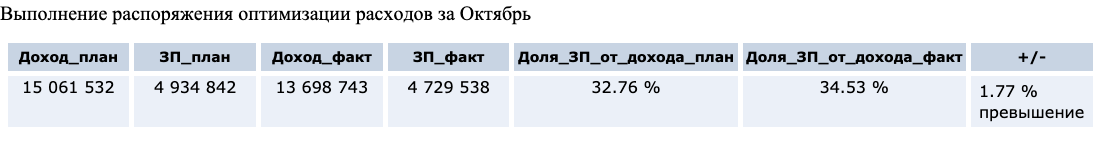

In [1411]:
fig = df2img.plot_dataframe(
      df_table_1,
      print_index=False, # отключает индексы
      col_width=[0.5, 0.5, 0.5, 0.5, 0.9, 0.9, 0.5],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"Выполнение распоряжения оптимизации расходов за {spravka_month.get(month_pf)}",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=14,
        height=20,
        line_width=5,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=5
    ),
      fig_size=(1100, 150),
  )
 
df2img.save_dataframe(fig=fig, filename="df_распоряжение_оптимизации.png")

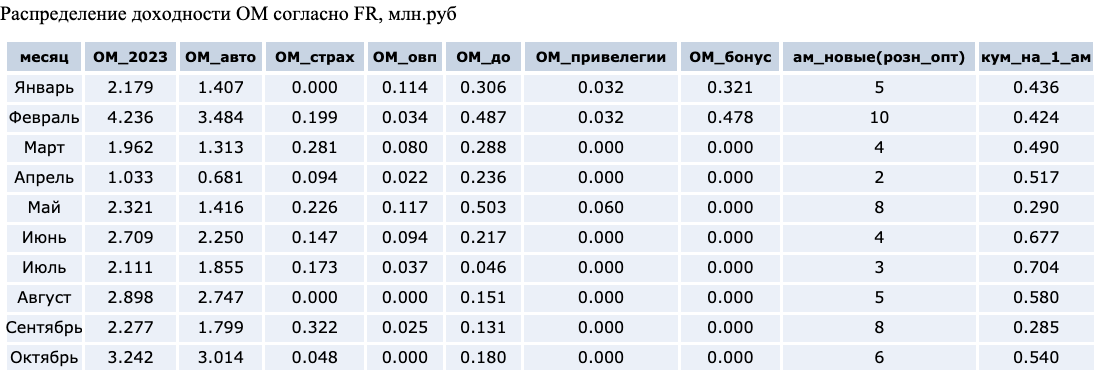

In [1412]:
fig = df2img.plot_dataframe(
      OM_rspred_tabl.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.12, 0.11, 0.13, 0.1, 0.1, 0.2, 0.13, 0.25, 0.15],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Распределение доходности ОМ согласно FR, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=14,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_распределение_дох_ом.png")

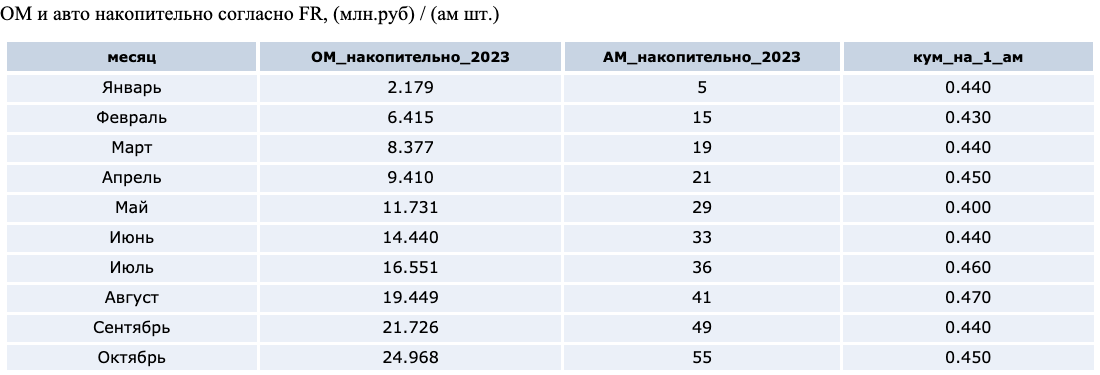

In [1413]:
fig = df2img.plot_dataframe(OM_rspred_nacopl.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.12, 0.11, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="OМ и авто накопительно согласно FR, (млн.руб) / (ам шт.)",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=14,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_распределение_дох_ом_накопительно.png")

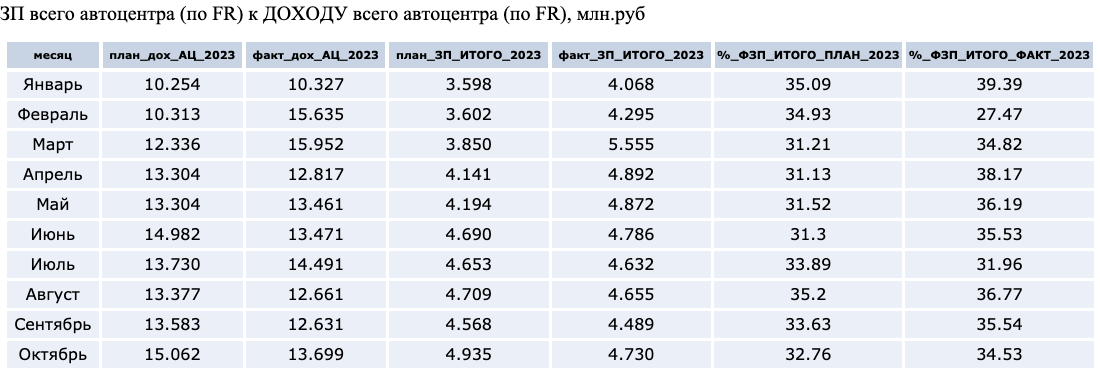

In [1414]:
fig = df2img.plot_dataframe(df_DOX_ZP[['месяц',
                                     f'план_дох_АЦ_{year_pf}',f'факт_дох_АЦ_{year_pf}',
                                     f'план_ЗП_ИТОГО_{year_pf}', f'факт_ЗП_ИТОГО_{year_pf}',
                                    f'%_ФЗП_ИТОГО_ПЛАН_{year_pf}',	f'%_ФЗП_ИТОГО_ФАКТ_{year_pf}']].astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.15, 0.15, 0.17, 0.17, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="ЗП всего автоцентра (по FR) к ДОХОДУ всего автоцентра (по FR), млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=11,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доля_зп_к_доходу_итого.png")

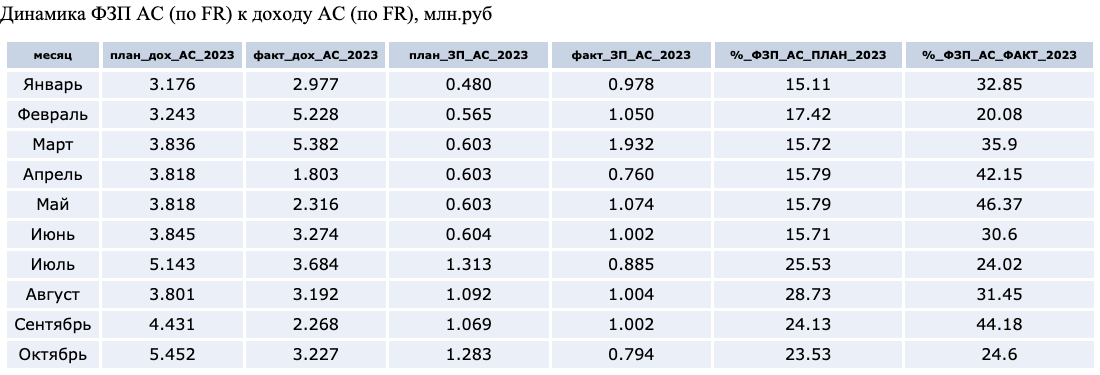

In [1415]:
fig = df2img.plot_dataframe(df_DOX_ZP[['месяц',
           f'план_дох_АС_{year_pf}', f'факт_дох_АС_{year_pf}',
           f'план_ЗП_АС_{year_pf}', f'факт_ЗП_АС_{year_pf}',
           f'%_ФЗП_АС_ПЛАН_{year_pf}',f'%_ФЗП_АС_ФАКТ_{year_pf}']].astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.15, 0.15, 0.17, 0.17, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Динамика ФЗП АС (по FR) к доходу АС (по FR), млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=11,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_динамика_фзп_ас.png")

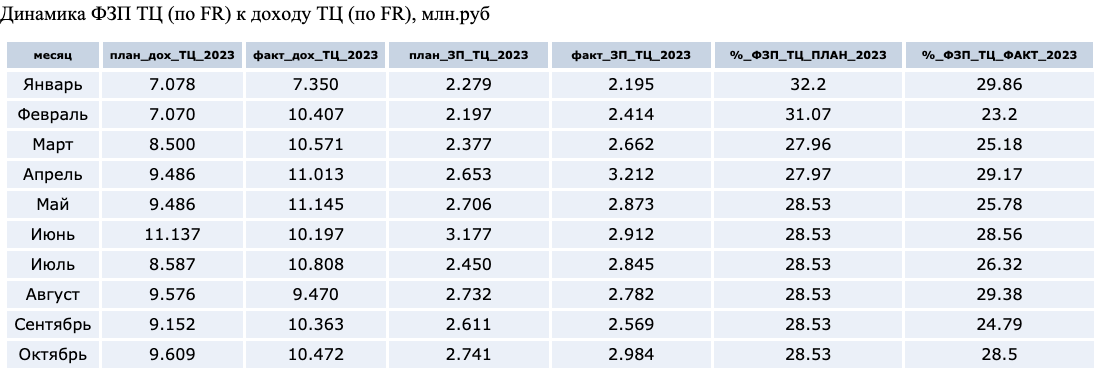

In [1416]:
fig = df2img.plot_dataframe(df_DOX_ZP[['месяц',
           f'план_дох_ТЦ_{year_pf}', f'факт_дох_ТЦ_{year_pf}',
           f'план_ЗП_ТЦ_{year_pf}', f'факт_ЗП_ТЦ_{year_pf}',
           f'%_ФЗП_ТЦ_ПЛАН_{year_pf}',f'%_ФЗП_ТЦ_ФАКТ_{year_pf}']].astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.15, 0.15, 0.17, 0.17, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Динамика ФЗП ТЦ (по FR) к доходу ТЦ (по FR), млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=11,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_динамика_фзп_тц.png")

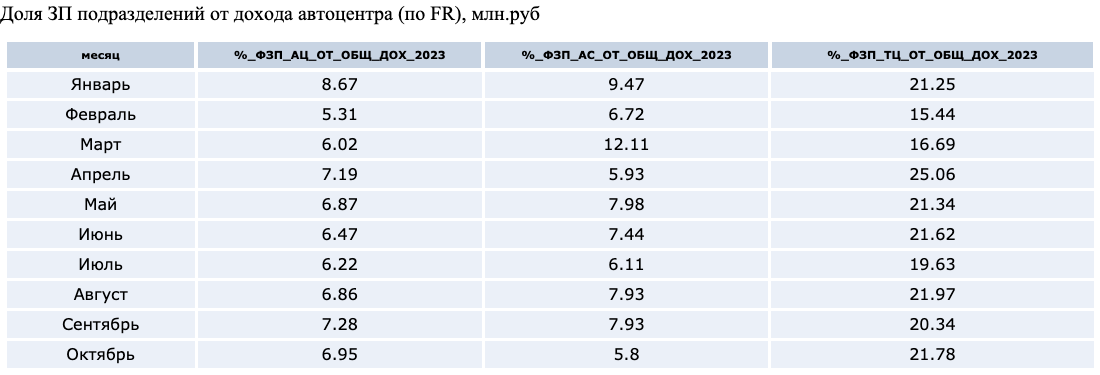

In [1417]:
fig = df2img.plot_dataframe(df_DOX_ZP[['месяц',
           f'%_ФЗП_АЦ_ОТ_ОБЩ_ДОХ_{year_pf}', f'%_ФЗП_АС_ОТ_ОБЩ_ДОХ_{year_pf}',
           f'%_ФЗП_ТЦ_ОТ_ОБЩ_ДОХ_{year_pf}']].astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.15, 0.15, 0.17, 0.17, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Доля ЗП подразделений от дохода автоцентра (по FR), млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=11,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доля_зп_подр_от_дох.png")

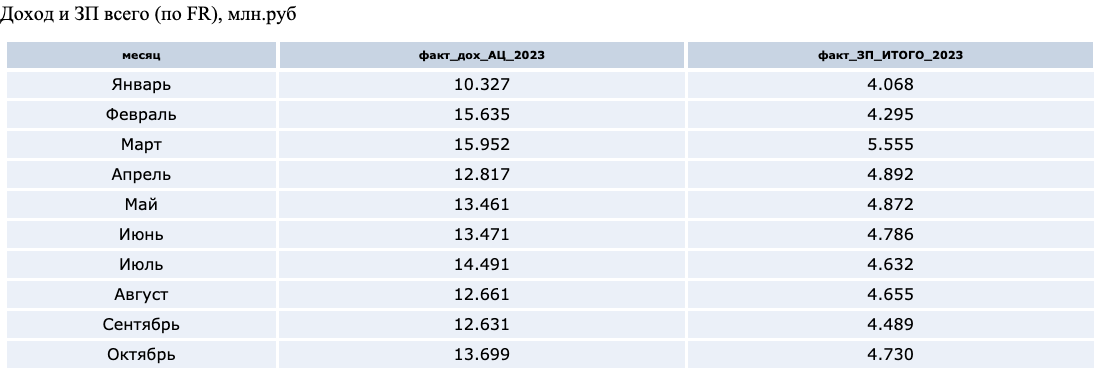

In [1418]:
fig = df2img.plot_dataframe(df_DOX_ZP[['месяц',
           f'факт_дох_АЦ_{year_pf}', f'факт_ЗП_ИТОГО_{year_pf}']].apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.1, 0.15, 0.15, 0.17, 0.17, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Доход и ЗП всего (по FR), млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=11,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_к_зп_итого.png")

In [1419]:
dfi.export(func_limit_ZP(df_ZP, limit=lim_zp_max, podr=['АЦ']), 'df_лимит_зп_ац.png', dpi=150)
dfi.export(func_limit_ZP(df_ZP, limit=lim_zp_max, podr=['АС']), 'df_лимит_зп_ас.png', dpi=150)
dfi.export(func_limit_ZP(df_ZP, limit=lim_zp_max, podr=['ТЦ']), 'df_лимит_зп_тц.png', dpi=150)

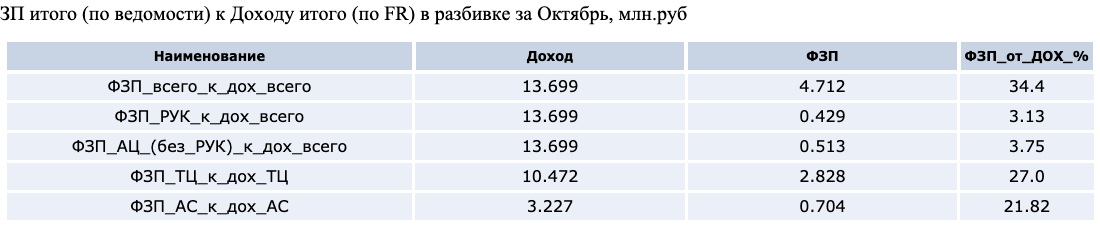

In [1420]:
fig = df2img.plot_dataframe(doh_k_zp_itogo.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП итого (по ведомости) к Доходу итого (по FR) в разбивке за {spravka_month.get(month_pf)}, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 235),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_итого_к_зп_по_ведомости_итого.png")

func_float_df_digit: Наименование не преобразован в <class 'float'>


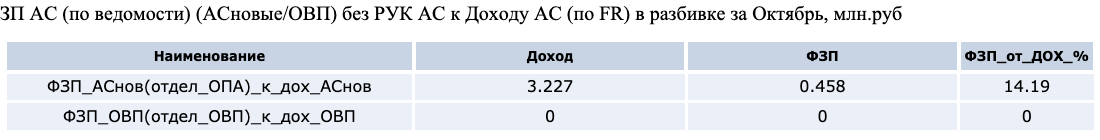

In [1421]:
fig = df2img.plot_dataframe(
      func_float_df_digit(doh_k_zp_AS.fillna(0)),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП АС (по ведомости) (АСновые/ОВП) без РУК АС к Доходу АС (по FR) в разбивке за {spravka_month.get(month_pf)}, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 140),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ас_к_зп_ас_ведомость.png")

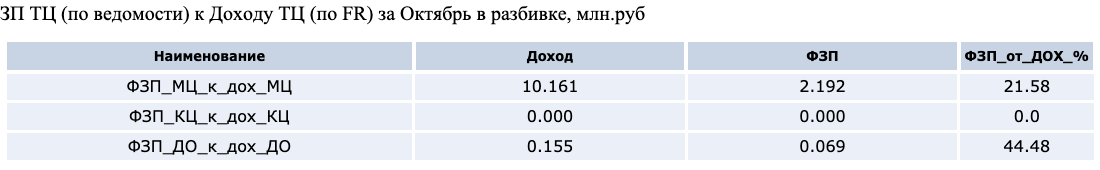

In [1422]:
fig = df2img.plot_dataframe(doh_k_zp_TC.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ (по ведомости) к Доходу ТЦ (по FR) за {spravka_month.get(month_pf)} в разбивке, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 170),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_тц_к_зп_тц_ведомость_разбивка.png")

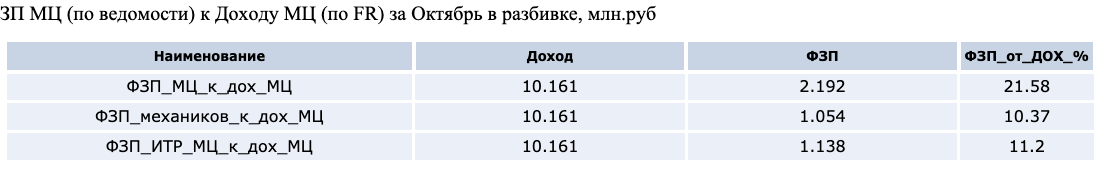

In [1423]:
fig = df2img.plot_dataframe(doh_k_zp_MC.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП МЦ (по ведомости) к Доходу МЦ (по FR) за {spravka_month.get(month_pf)} в разбивке, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 170),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_мц_к_зп_мц_ведомость_разбивка.png")

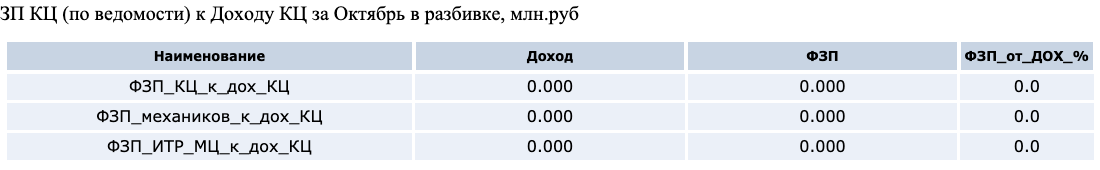

In [1424]:
fig = df2img.plot_dataframe(doh_k_zp_KC.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП КЦ (по ведомости) к Доходу КЦ за {spravka_month.get(month_pf)} в разбивке, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 170),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_кц_к_зп_кц_ведомость_разбивка.png")

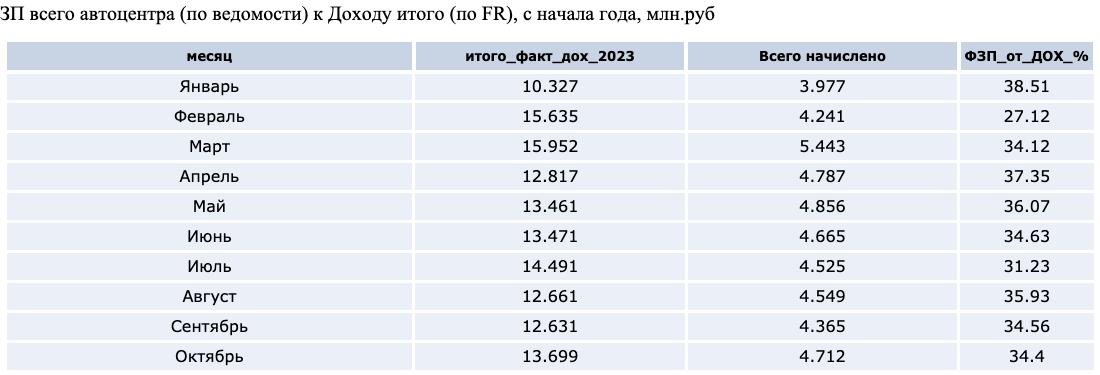

In [1425]:
fig = df2img.plot_dataframe(doh_itog_k_zp_itog.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП всего автоцентра (по ведомости) к Доходу итого (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_итого_к_зп_итого_ведомость_с_н_г.png")

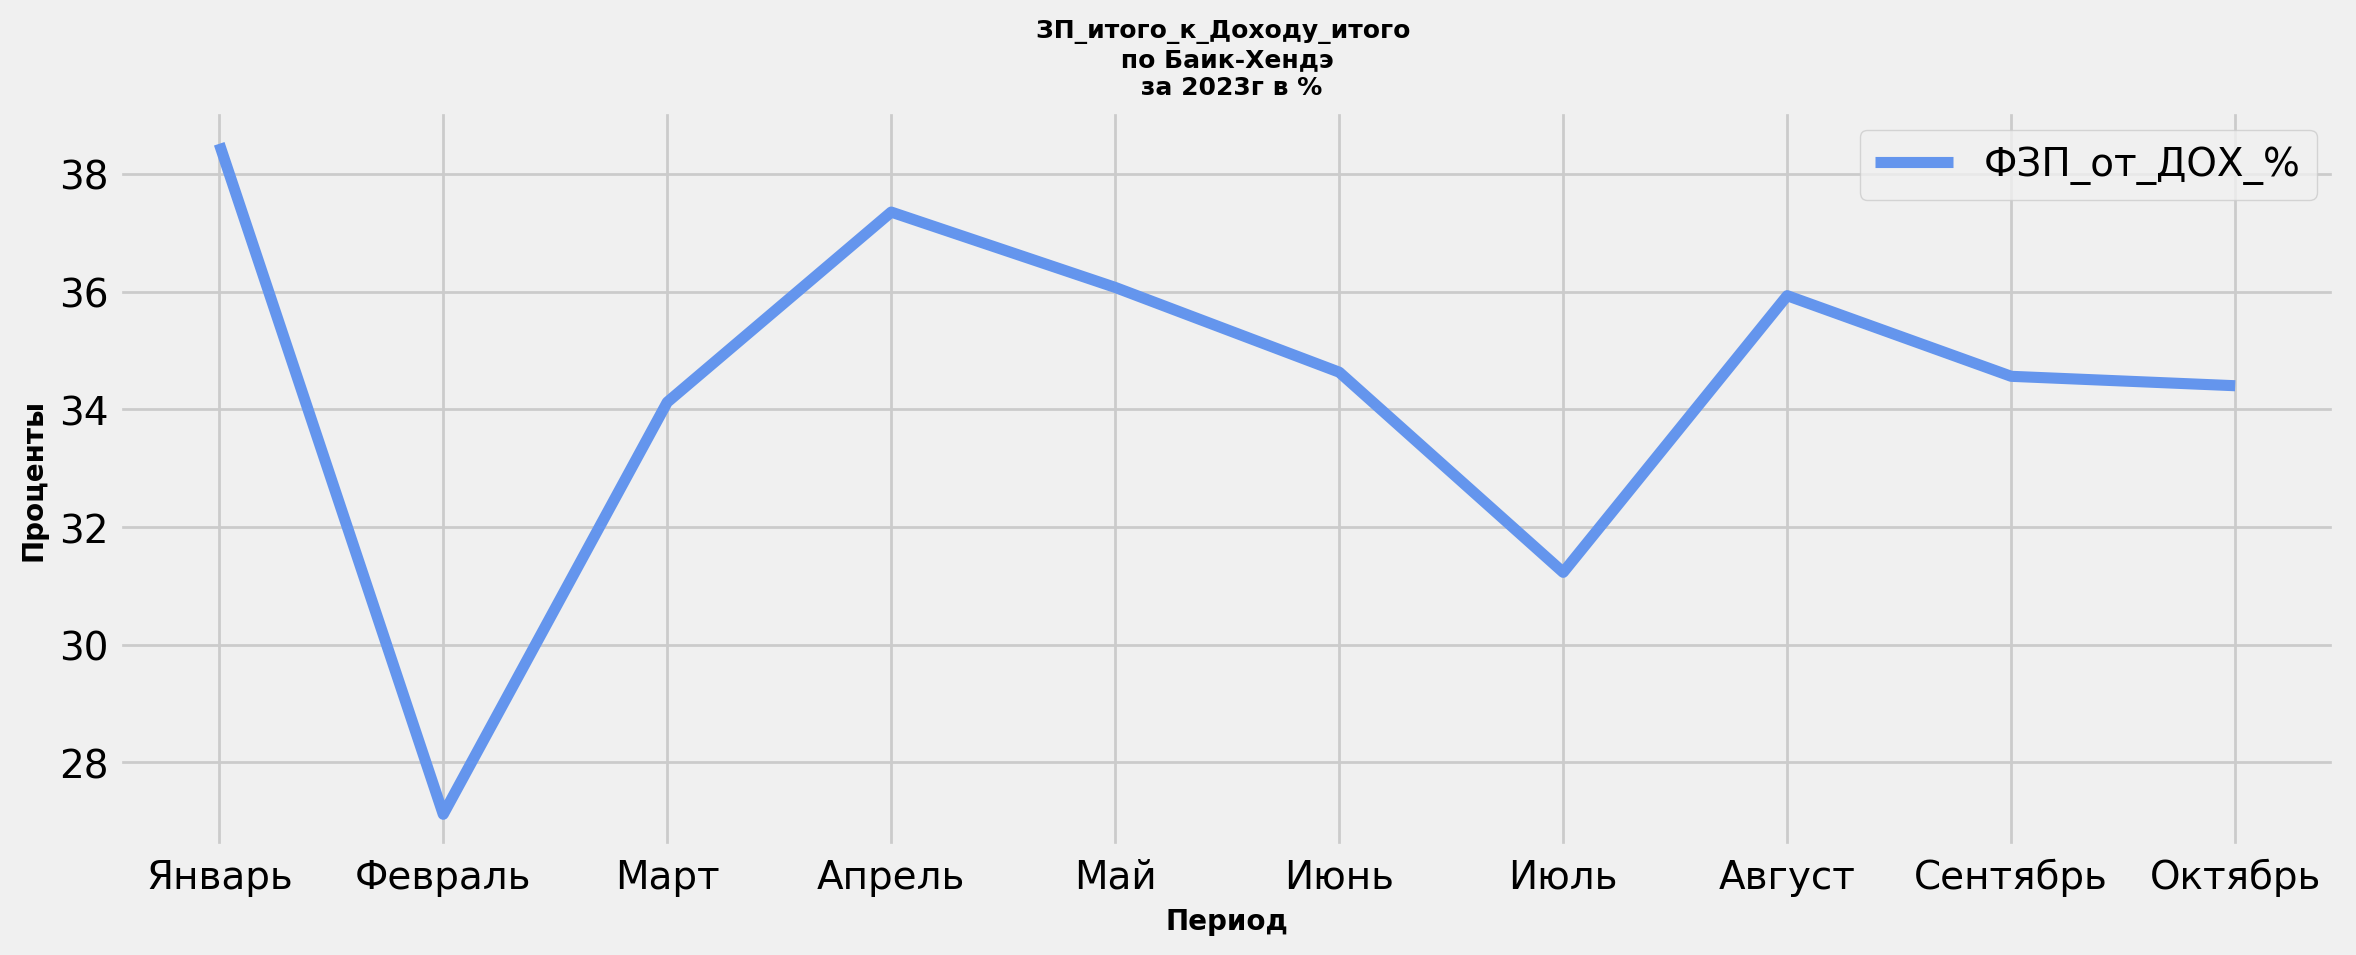

In [1426]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_itog_k_zp_itog.df['месяц'], doh_itog_k_zp_itog.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_itog_k_zp_itog.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_itog_k_zp_itog.name}.png')
    plt.show()

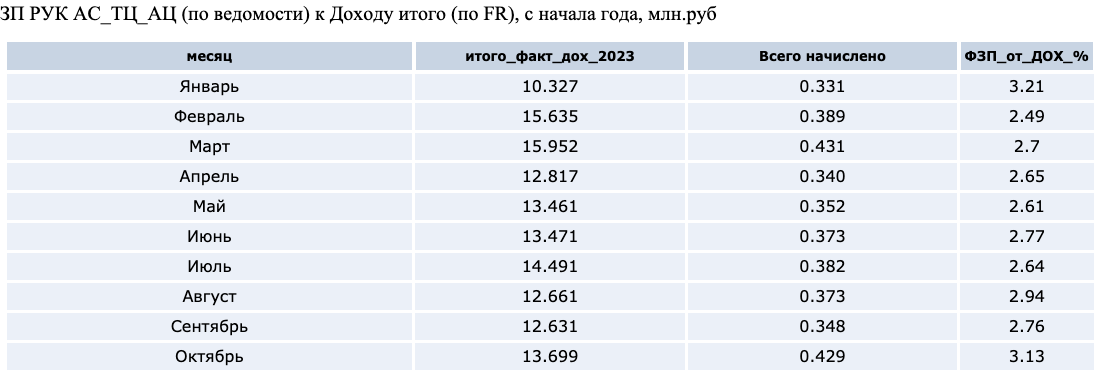

In [1427]:
fig = df2img.plot_dataframe(doh_itog_k_zp_ruk.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП РУК АС_ТЦ_АЦ (по ведомости) к Доходу итого (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_итого_к_зп_РУК_ведомость_с_н_г.png")

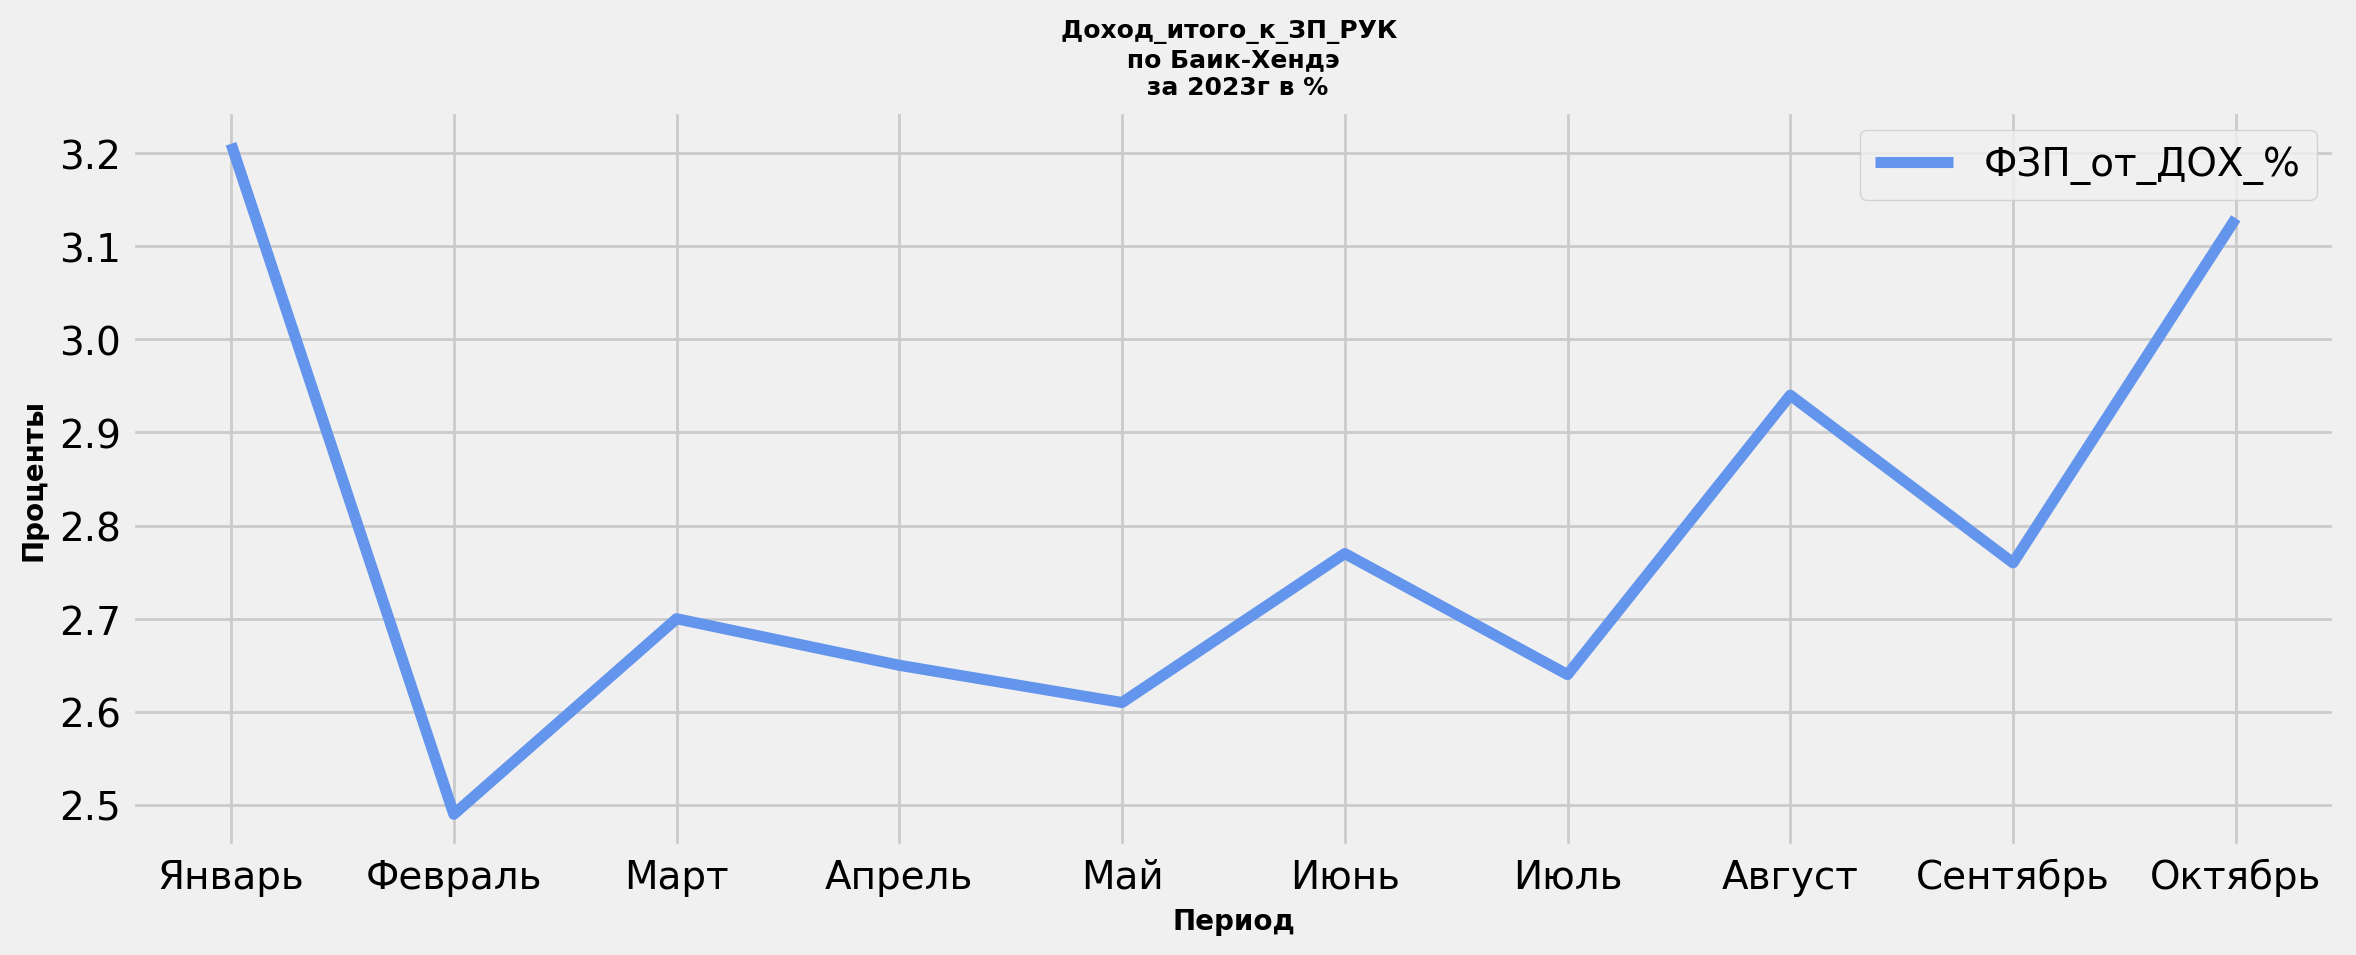

In [1428]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_itog_k_zp_ruk.df['месяц'], doh_itog_k_zp_ruk.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_itog_k_zp_ruk.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_itog_k_zp_ruk.name}.png')
    plt.show()

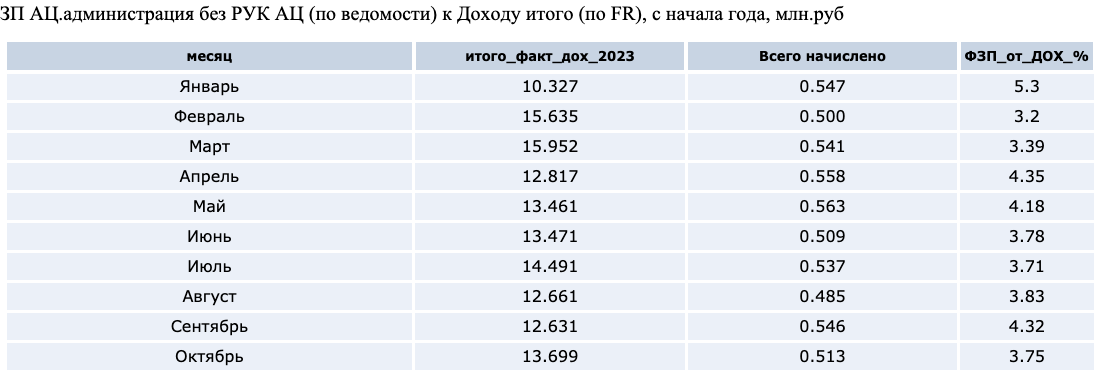

In [1429]:
fig = df2img.plot_dataframe(doh_itog_k_zp_AC.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП АЦ.администрация без РУК АЦ (по ведомости) к Доходу итого (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_итого_к_зп_АЦ_ведомость_с_н_г.png")

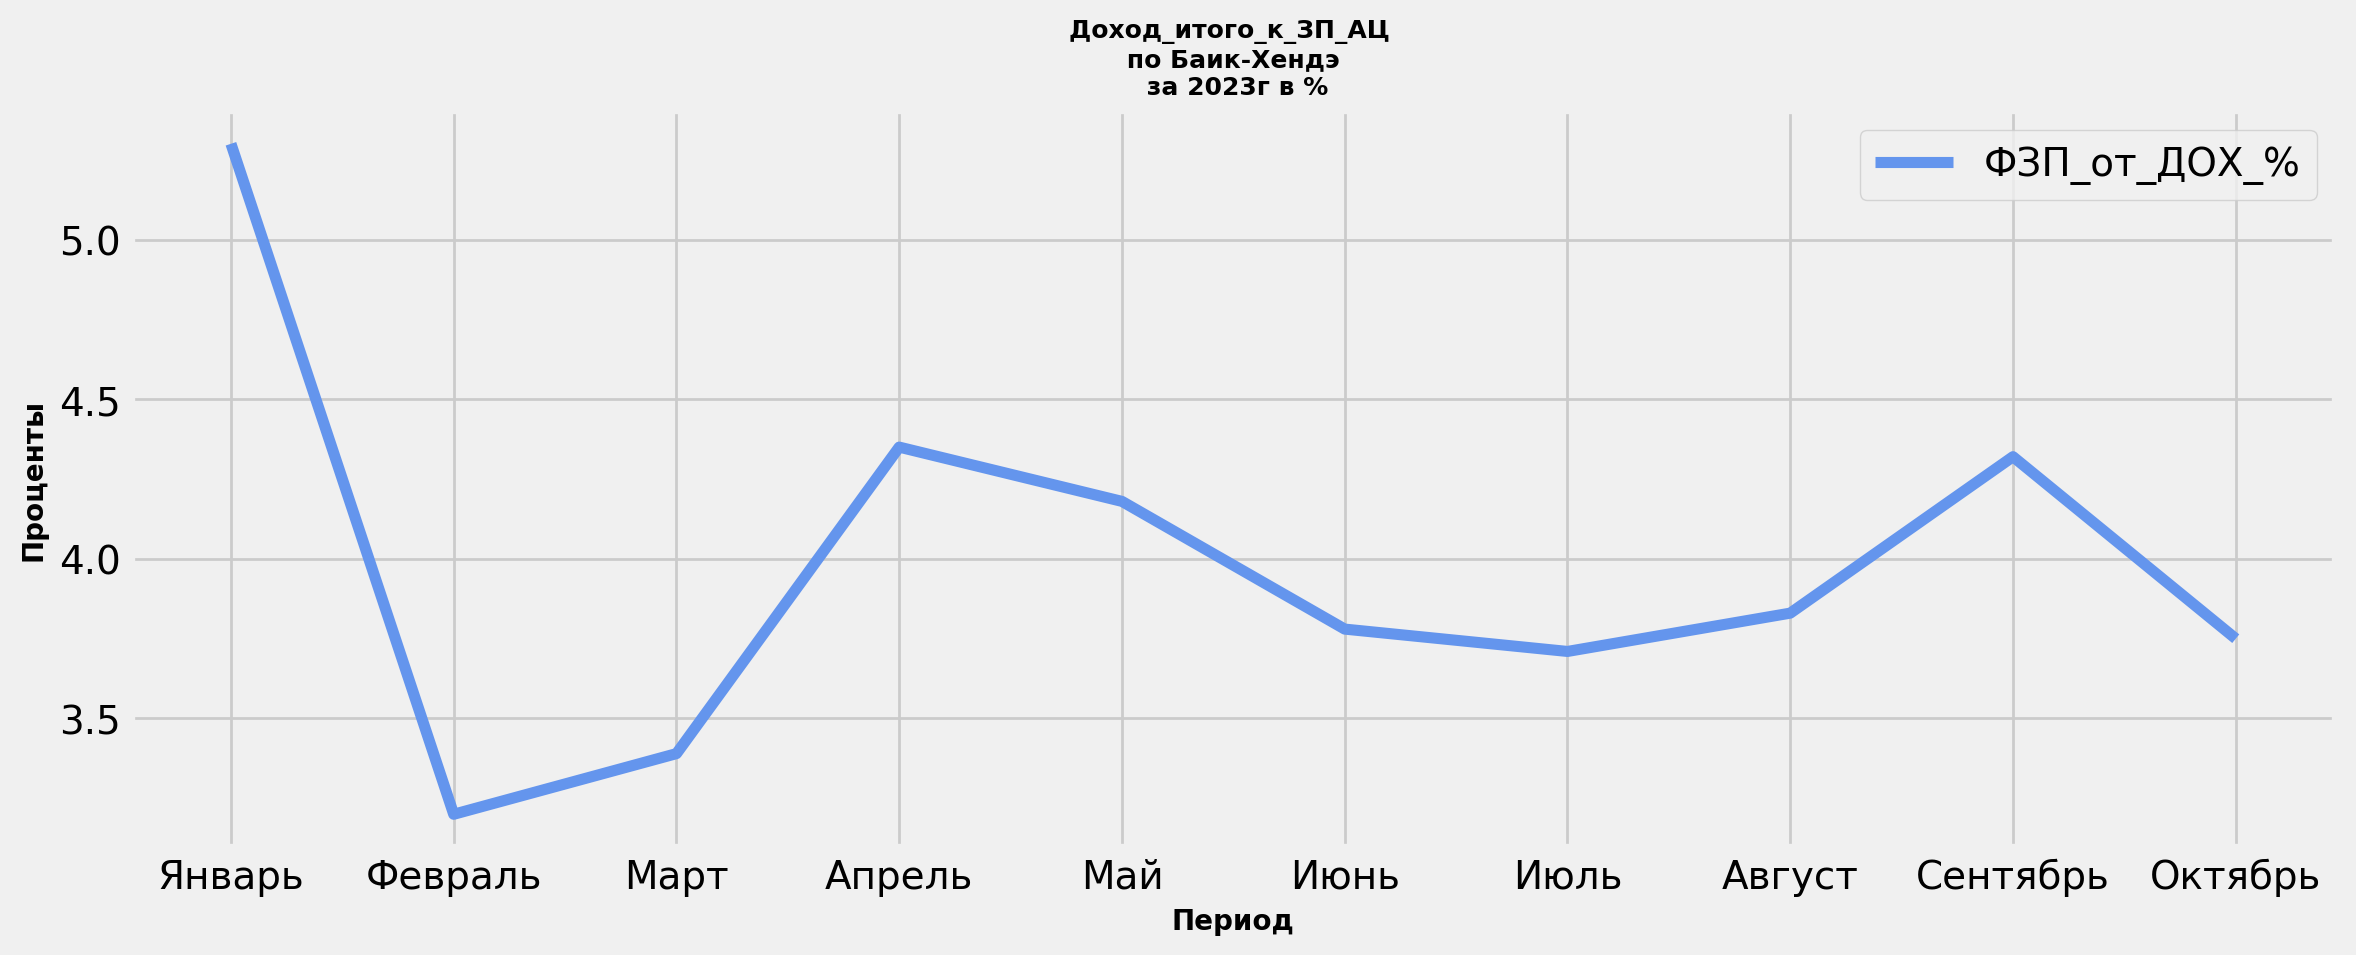

In [1430]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_itog_k_zp_AC.df['месяц'], doh_itog_k_zp_AC.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_itog_k_zp_AC.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_itog_k_zp_AC.name}.png')
    plt.show()

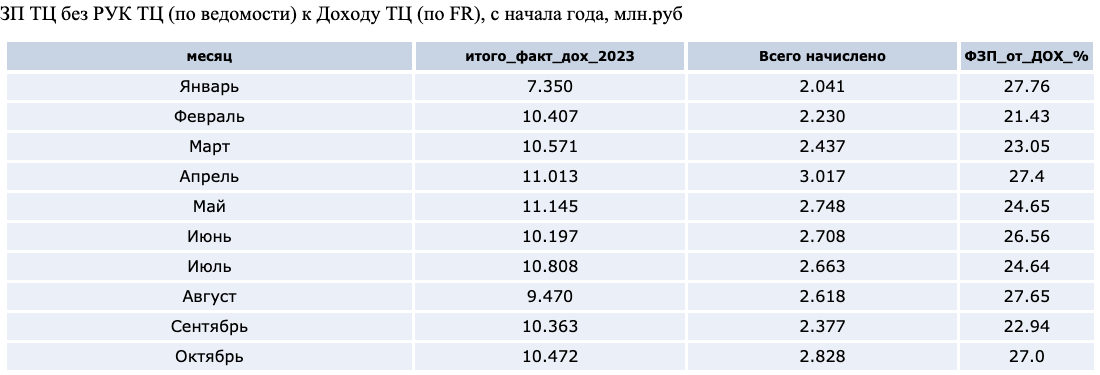

In [1431]:
fig = df2img.plot_dataframe(doh_TC_k_zp_TC.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ без РУК ТЦ (по ведомости) к Доходу ТЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦ_к_зп_ТЦ_ведомость_с_н_г.png")

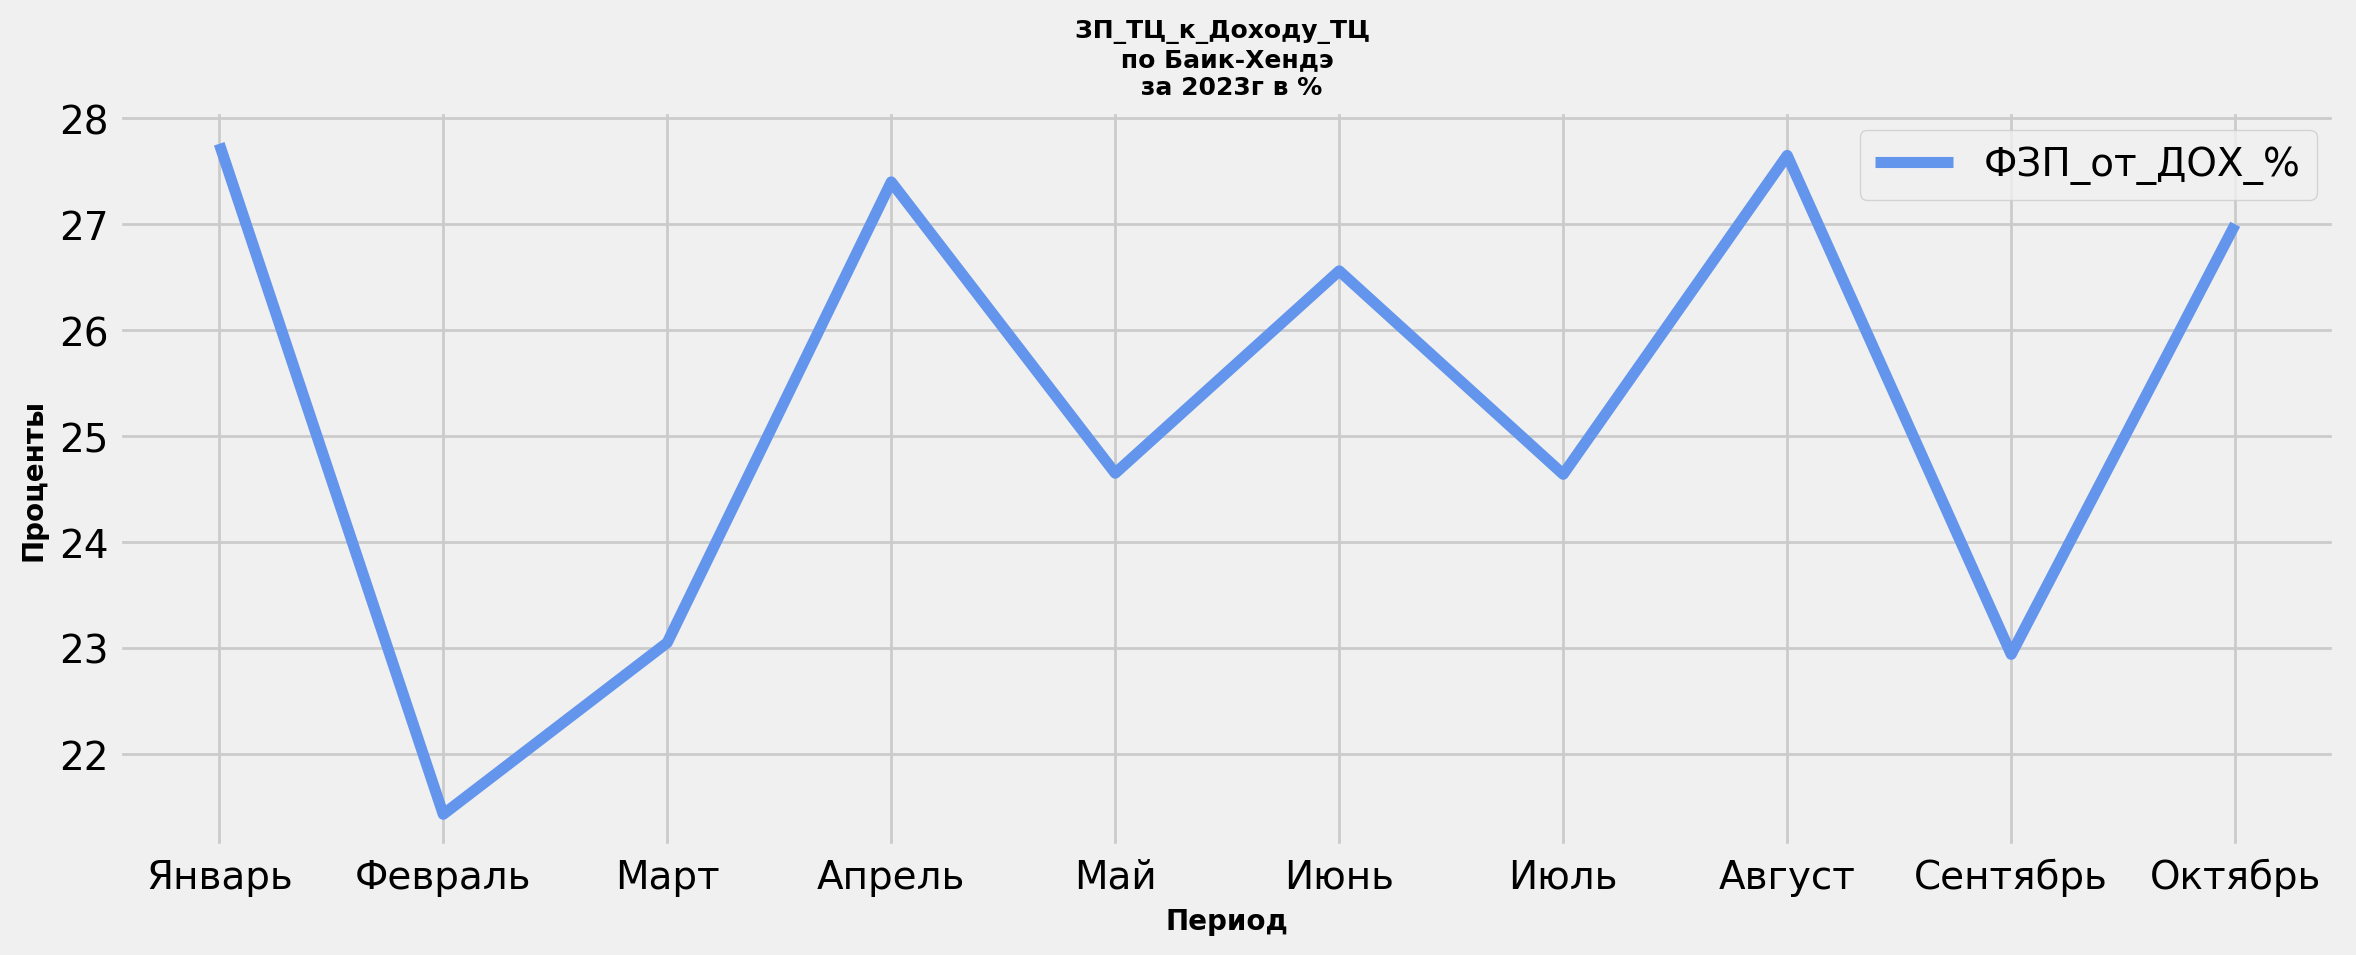

In [1432]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_TC_k_zp_TC.df['месяц'], doh_TC_k_zp_TC.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_TC_k_zp_TC.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_TC_k_zp_TC.name}.png')
    plt.show()

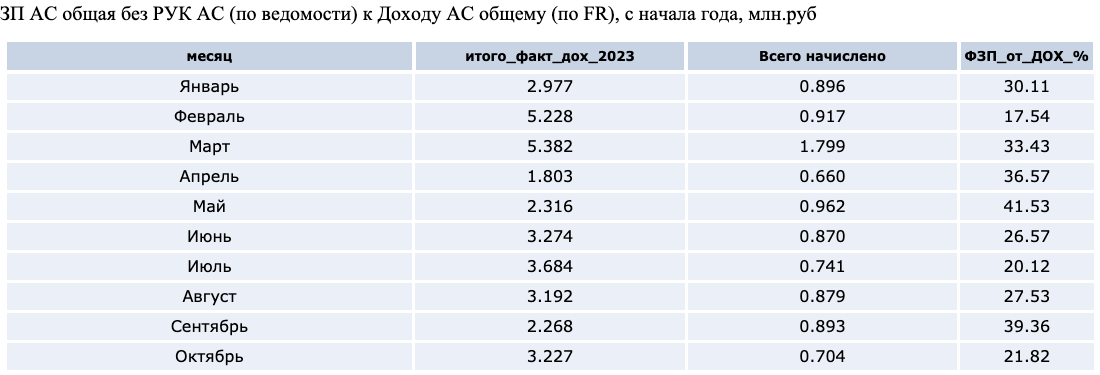

In [1433]:
fig = df2img.plot_dataframe(doh_AS_k_zp_AS.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП АС общая без РУК АС (по ведомости) к Доходу АС общему (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_АСобщ_к_зп_АСобщ_ведомость_с_н_г.png")

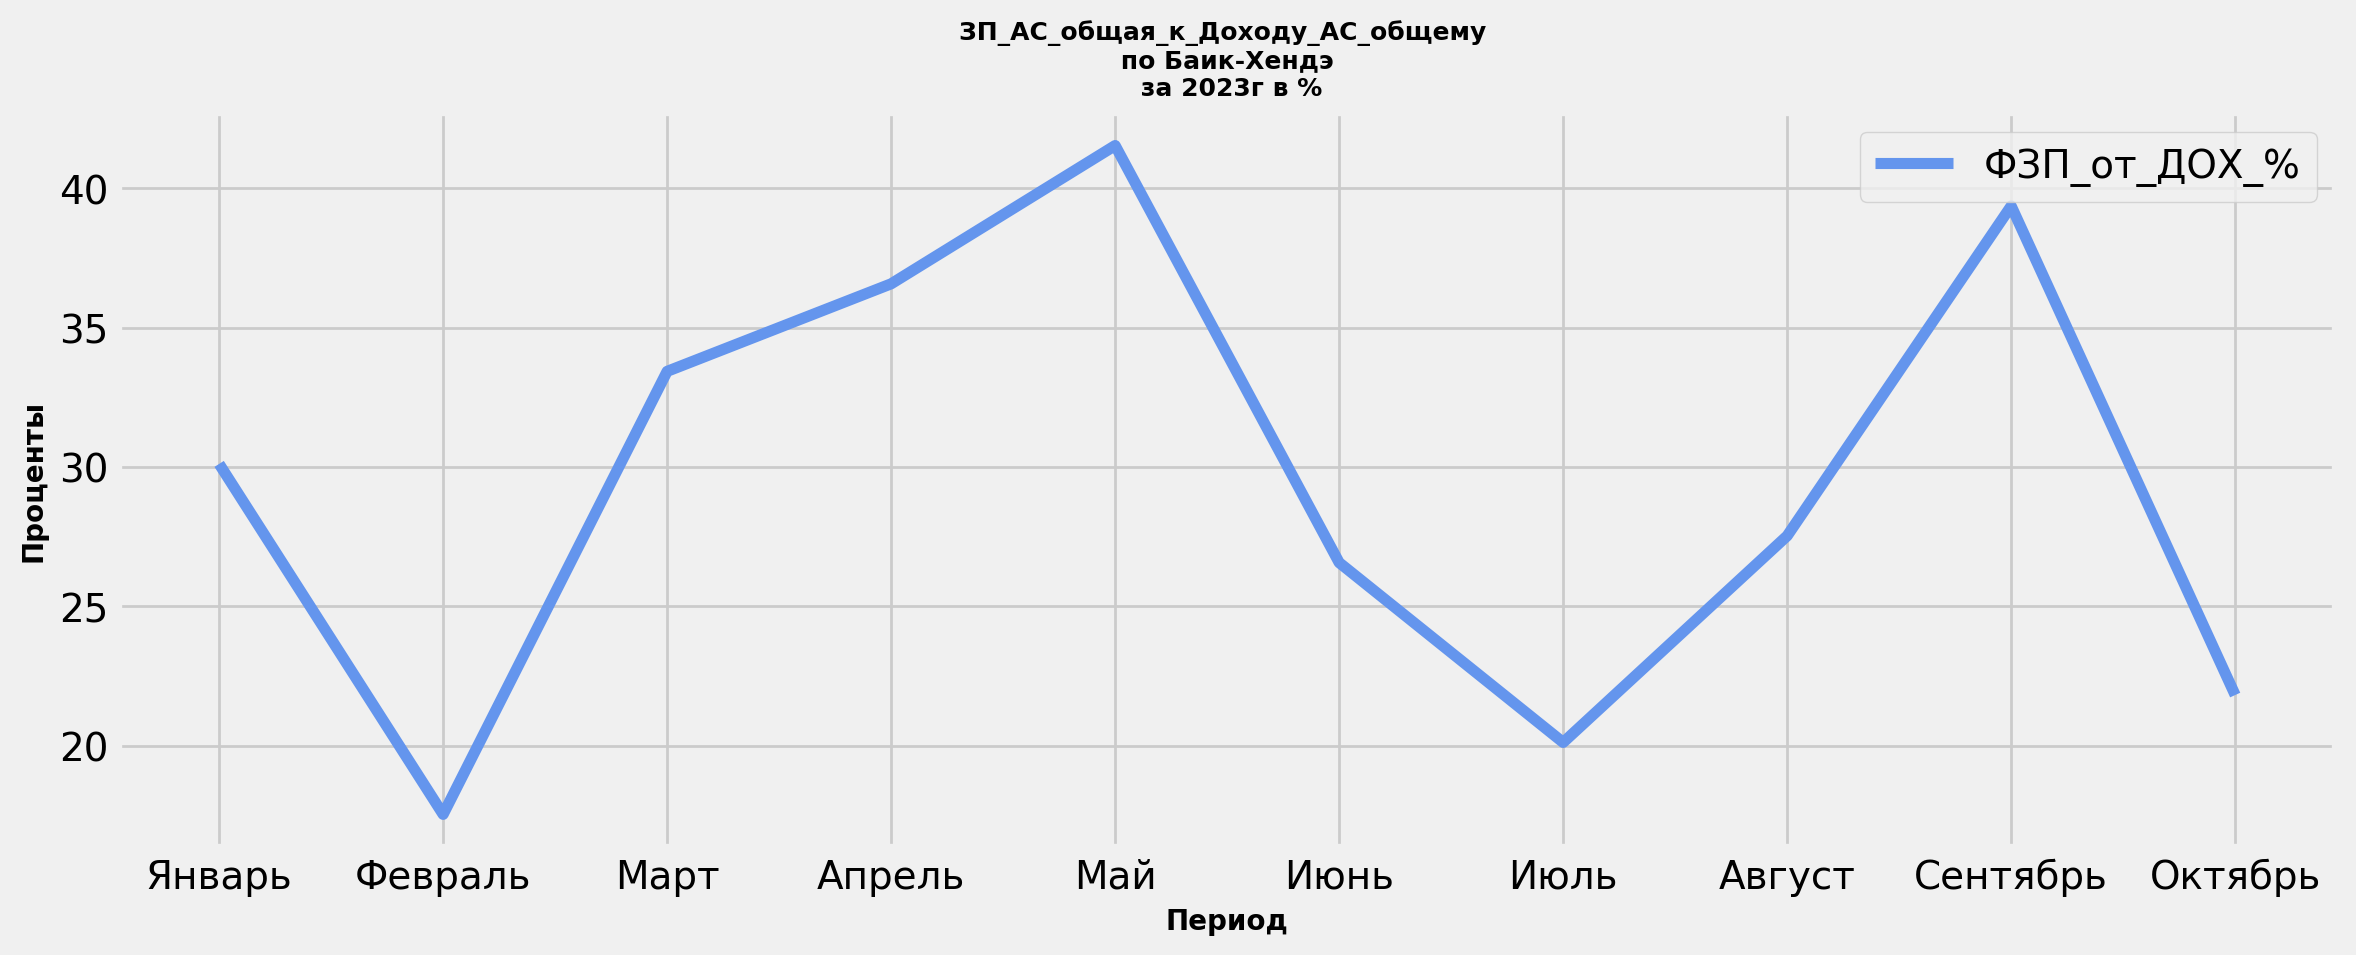

In [1434]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_AS_k_zp_AS.df['месяц'], doh_AS_k_zp_AS.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_AS_k_zp_AS.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_AS_k_zp_AS.name}.png')
    plt.show()

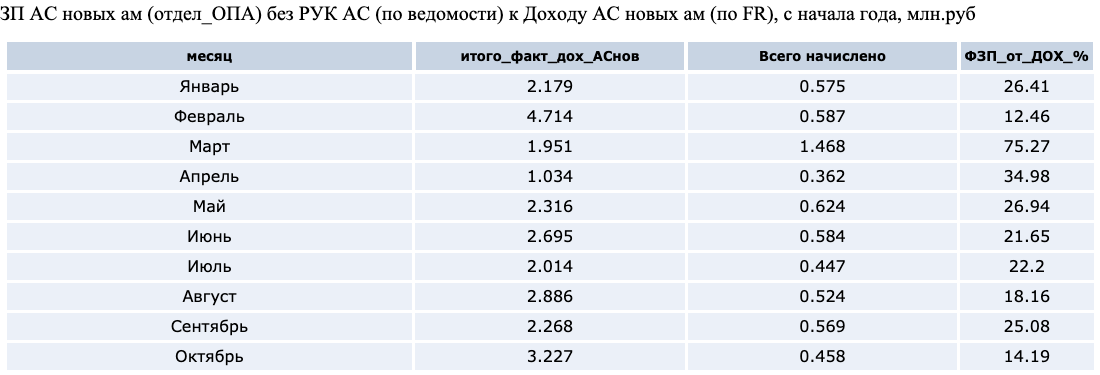

In [1435]:
fig = df2img.plot_dataframe(doh_ASnew_k_zp_ASnew.df.apply(infinity_).apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП АС новых ам (отдел_ОПА) без РУК АС (по ведомости) к Доходу АС новых ам (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_АСнов_к_зп_АСнов_ведомость_с_н_г.png")

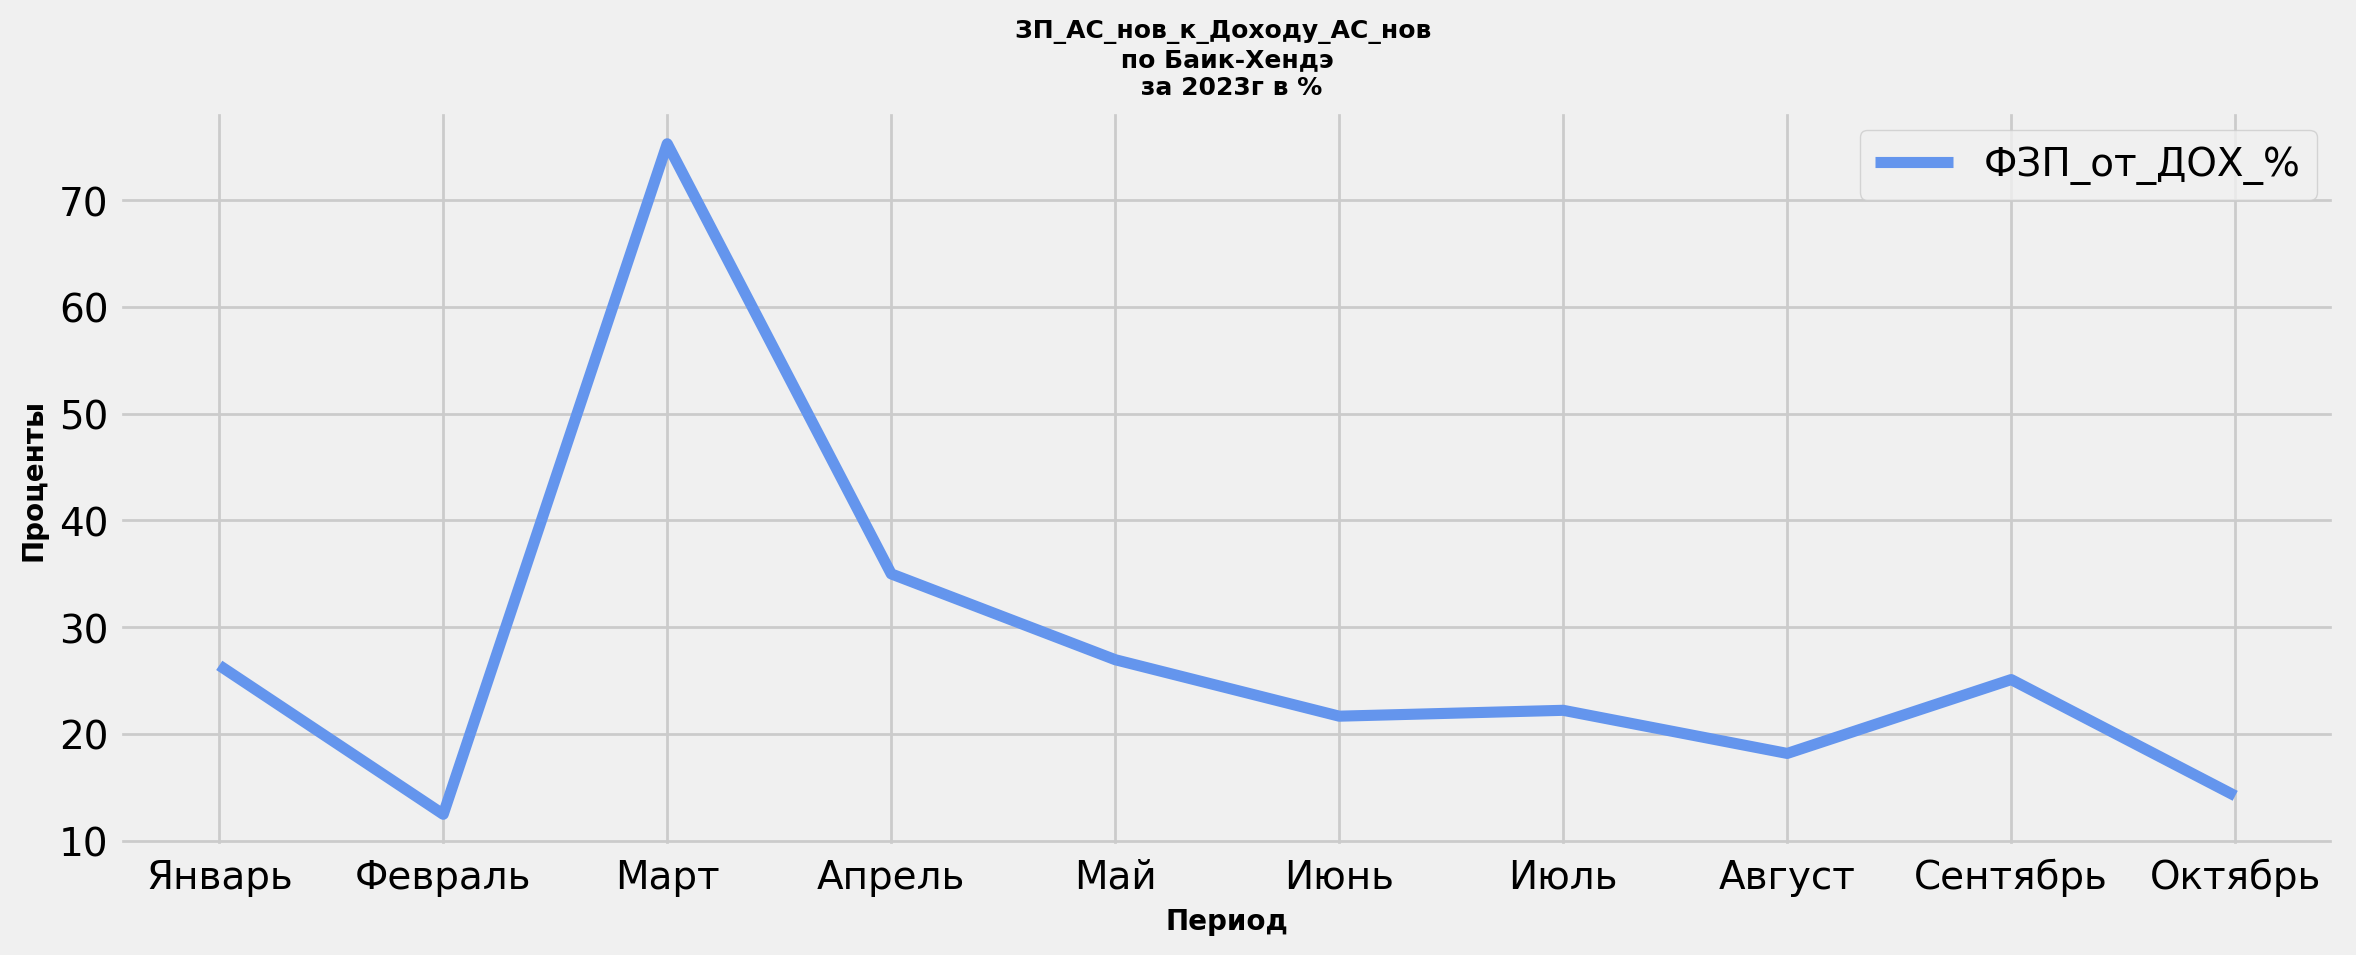

In [1436]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_ASnew_k_zp_ASnew.df['месяц'], doh_ASnew_k_zp_ASnew.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_ASnew_k_zp_ASnew.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_ASnew_k_zp_ASnew.name}.png')
    plt.show()

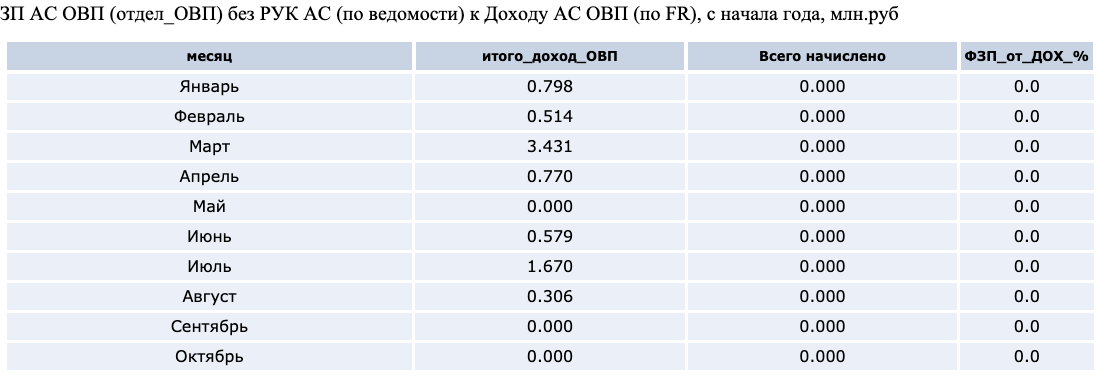

In [1437]:
fig = df2img.plot_dataframe(doh_AS_k_zp_AS_ovp.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП АС ОВП (отдел_ОВП) без РУК АС (по ведомости) к Доходу АС ОВП (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_АСовп_к_зп_АСовп_ведомость_с_н_г.png")

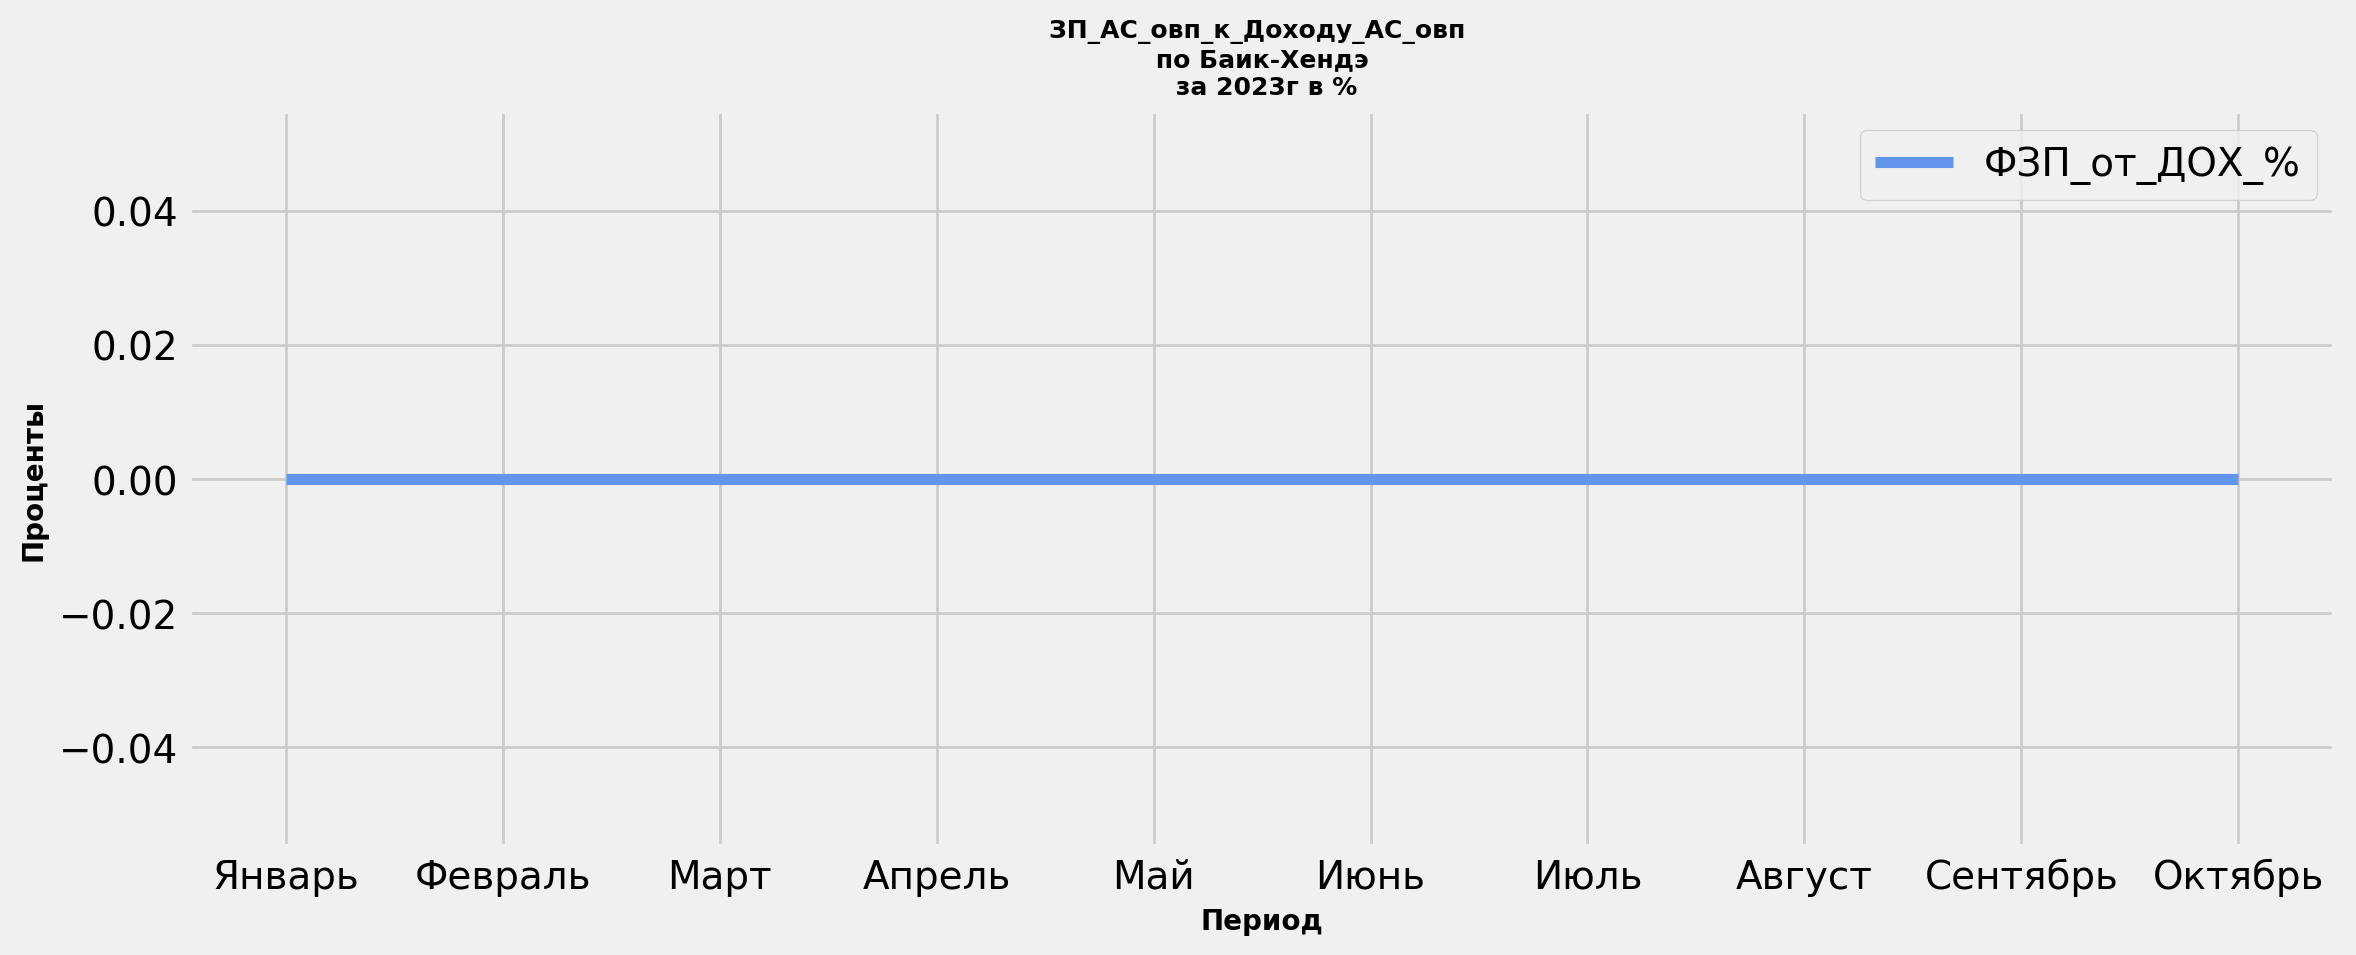

In [1438]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_AS_k_zp_AS_ovp.df['месяц'], doh_AS_k_zp_AS_ovp.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_AS_k_zp_AS_ovp.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_AS_k_zp_AS_ovp.name}.png')
    plt.show()

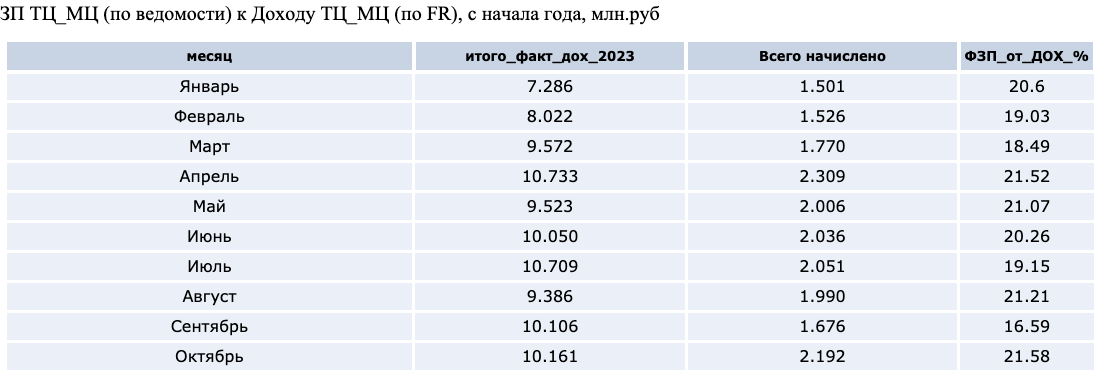

In [1439]:
fig = df2img.plot_dataframe(doh_MC_k_zp_MC.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_МЦ (по ведомости) к Доходу ТЦ_МЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦМЦ_к_зп_ТЦМЦ_ведомость_с_н_г.png")

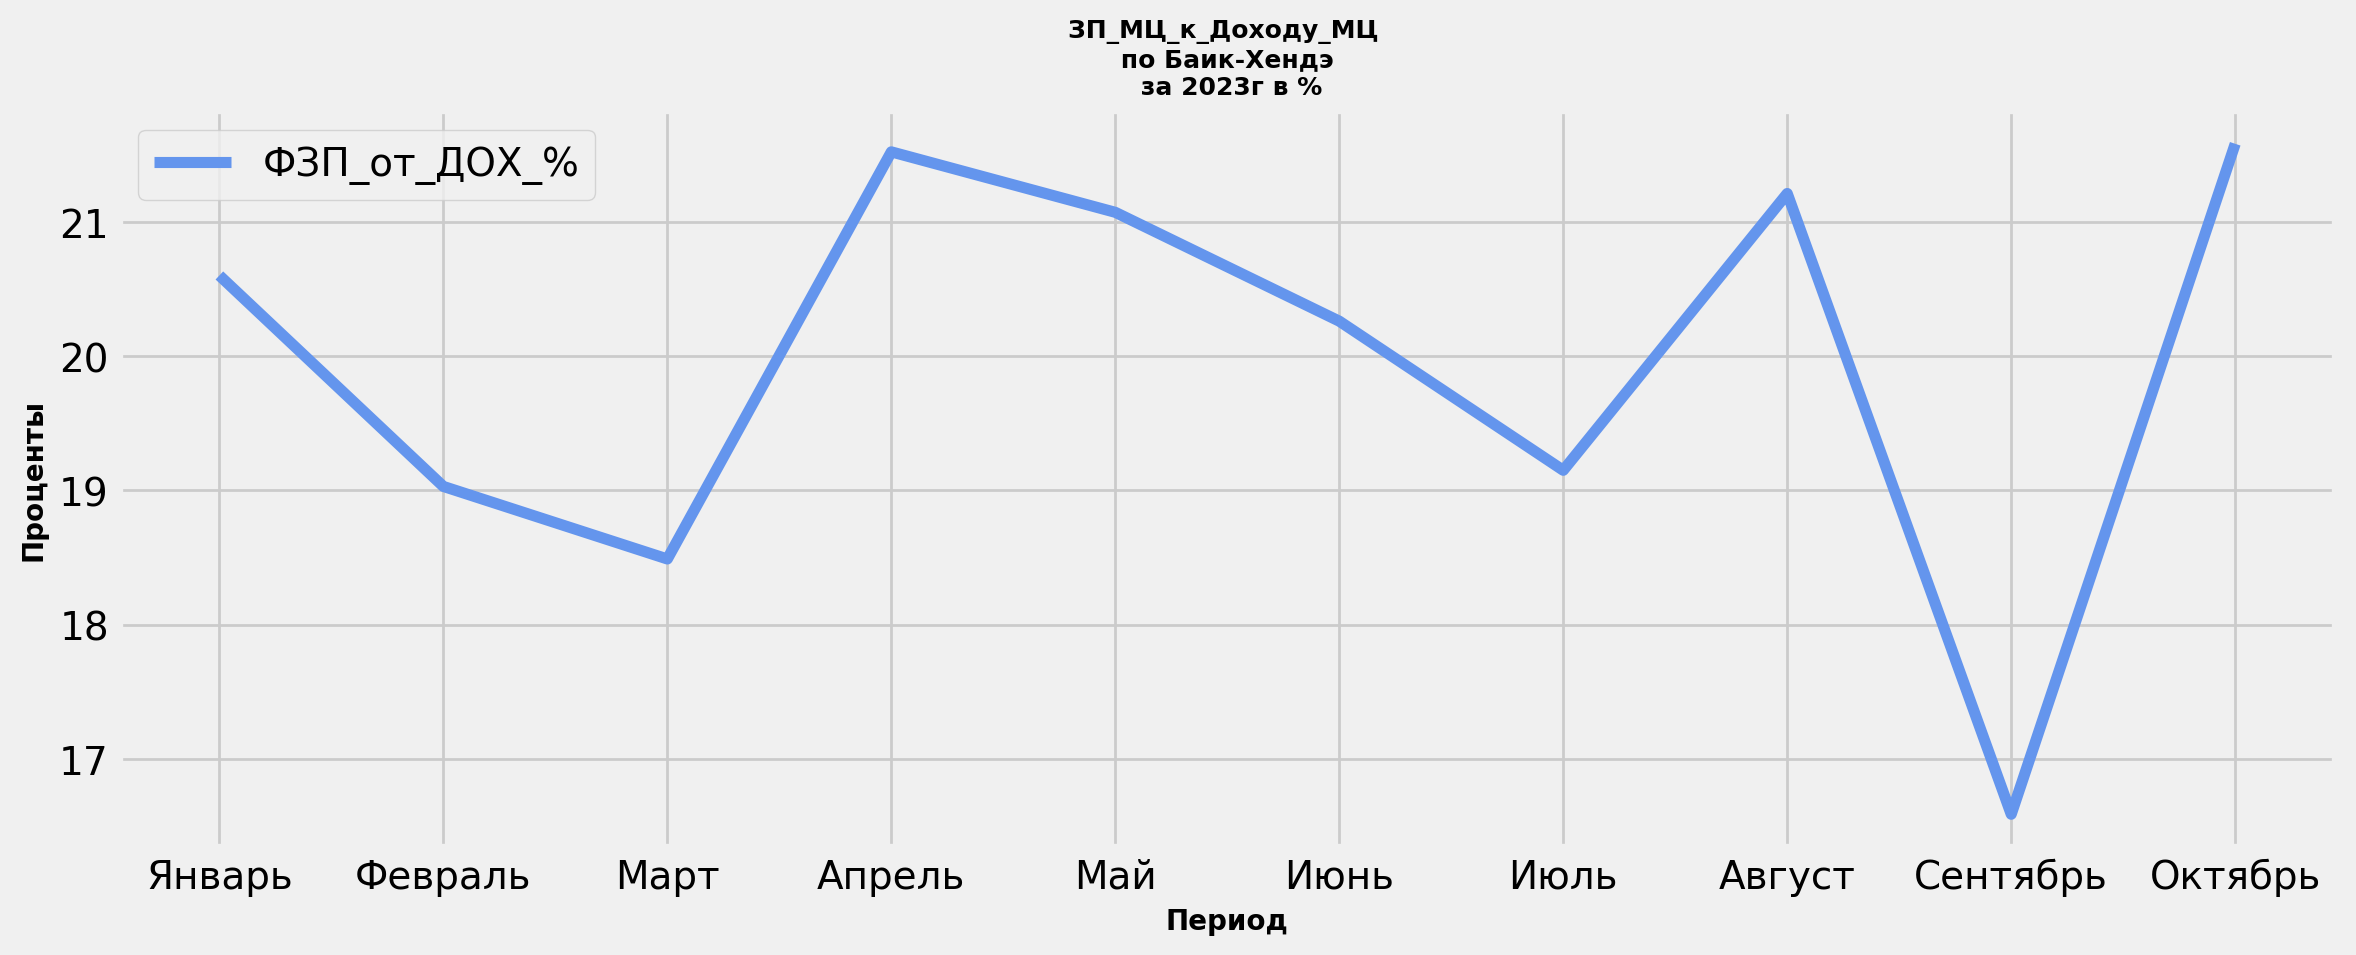

In [1440]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_MC_k_zp_MC.df['месяц'], doh_MC_k_zp_MC.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_MC_k_zp_MC.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_MC_k_zp_MC.name}.png')
    plt.show()

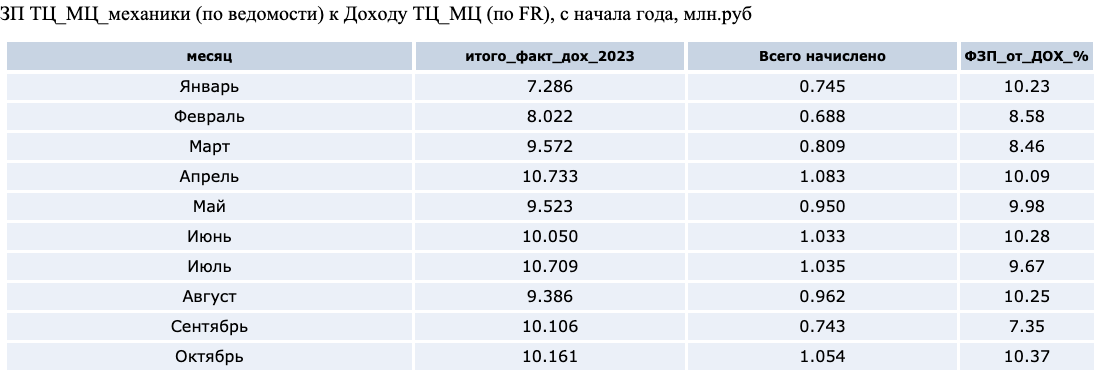

In [1441]:
fig = df2img.plot_dataframe(doh_MC_k_zp_MC_meh.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_МЦ_механики (по ведомости) к Доходу ТЦ_МЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦМЦ_к_зп_ТЦМЦмеханики_ведомость_с_н_г.png")

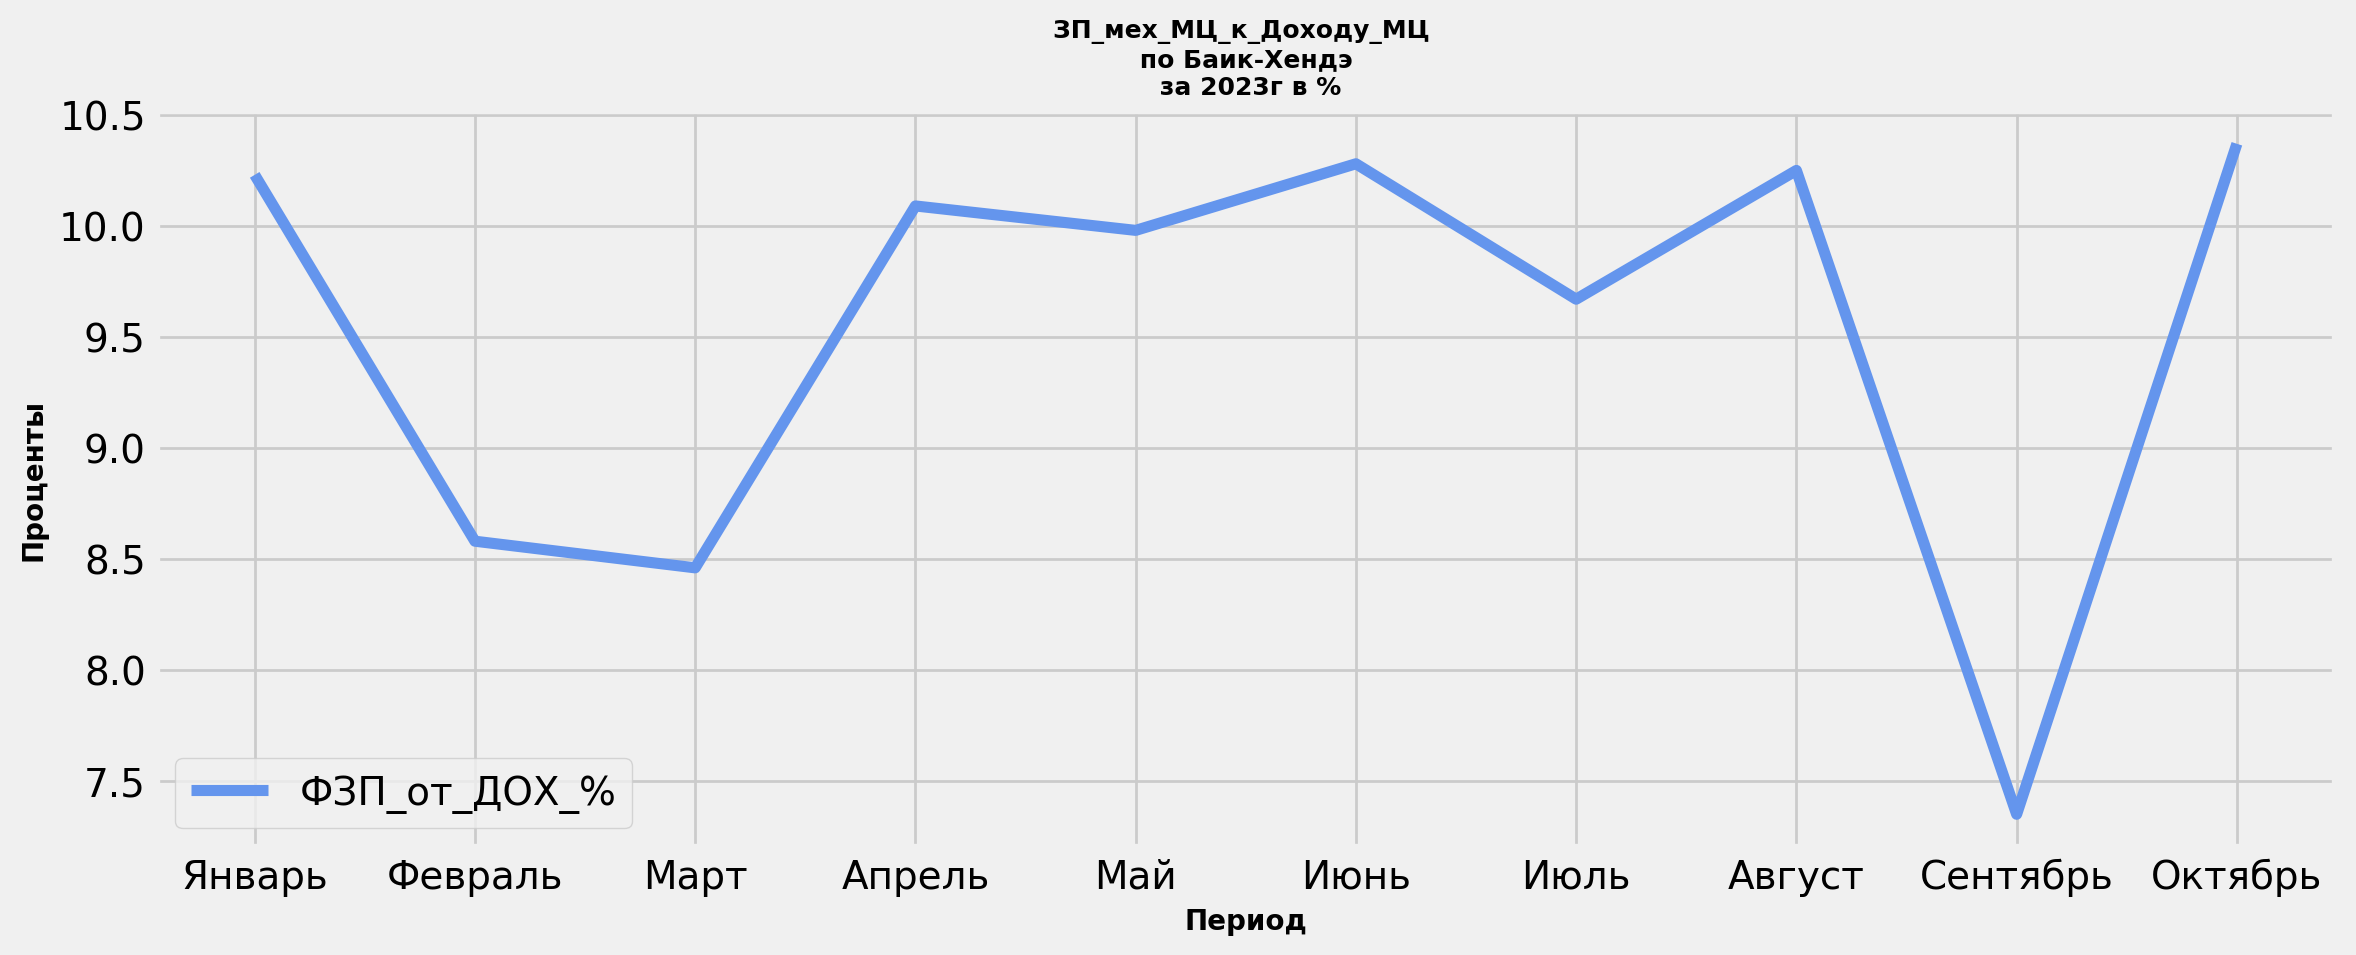

In [1442]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_MC_k_zp_MC_meh.df['месяц'], doh_MC_k_zp_MC_meh.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_MC_k_zp_MC_meh.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_MC_k_zp_MC_meh.name}.png')
    plt.show()

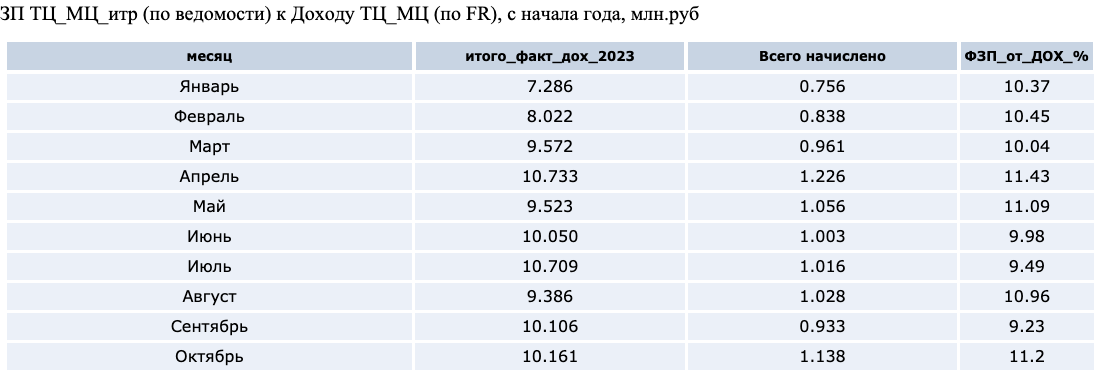

In [1443]:
fig = df2img.plot_dataframe(doh_MC_k_zp_MC_itr.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_МЦ_итр (по ведомости) к Доходу ТЦ_МЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦМЦ_к_зп_ТЦМЦитр_ведомость_с_н_г.png")

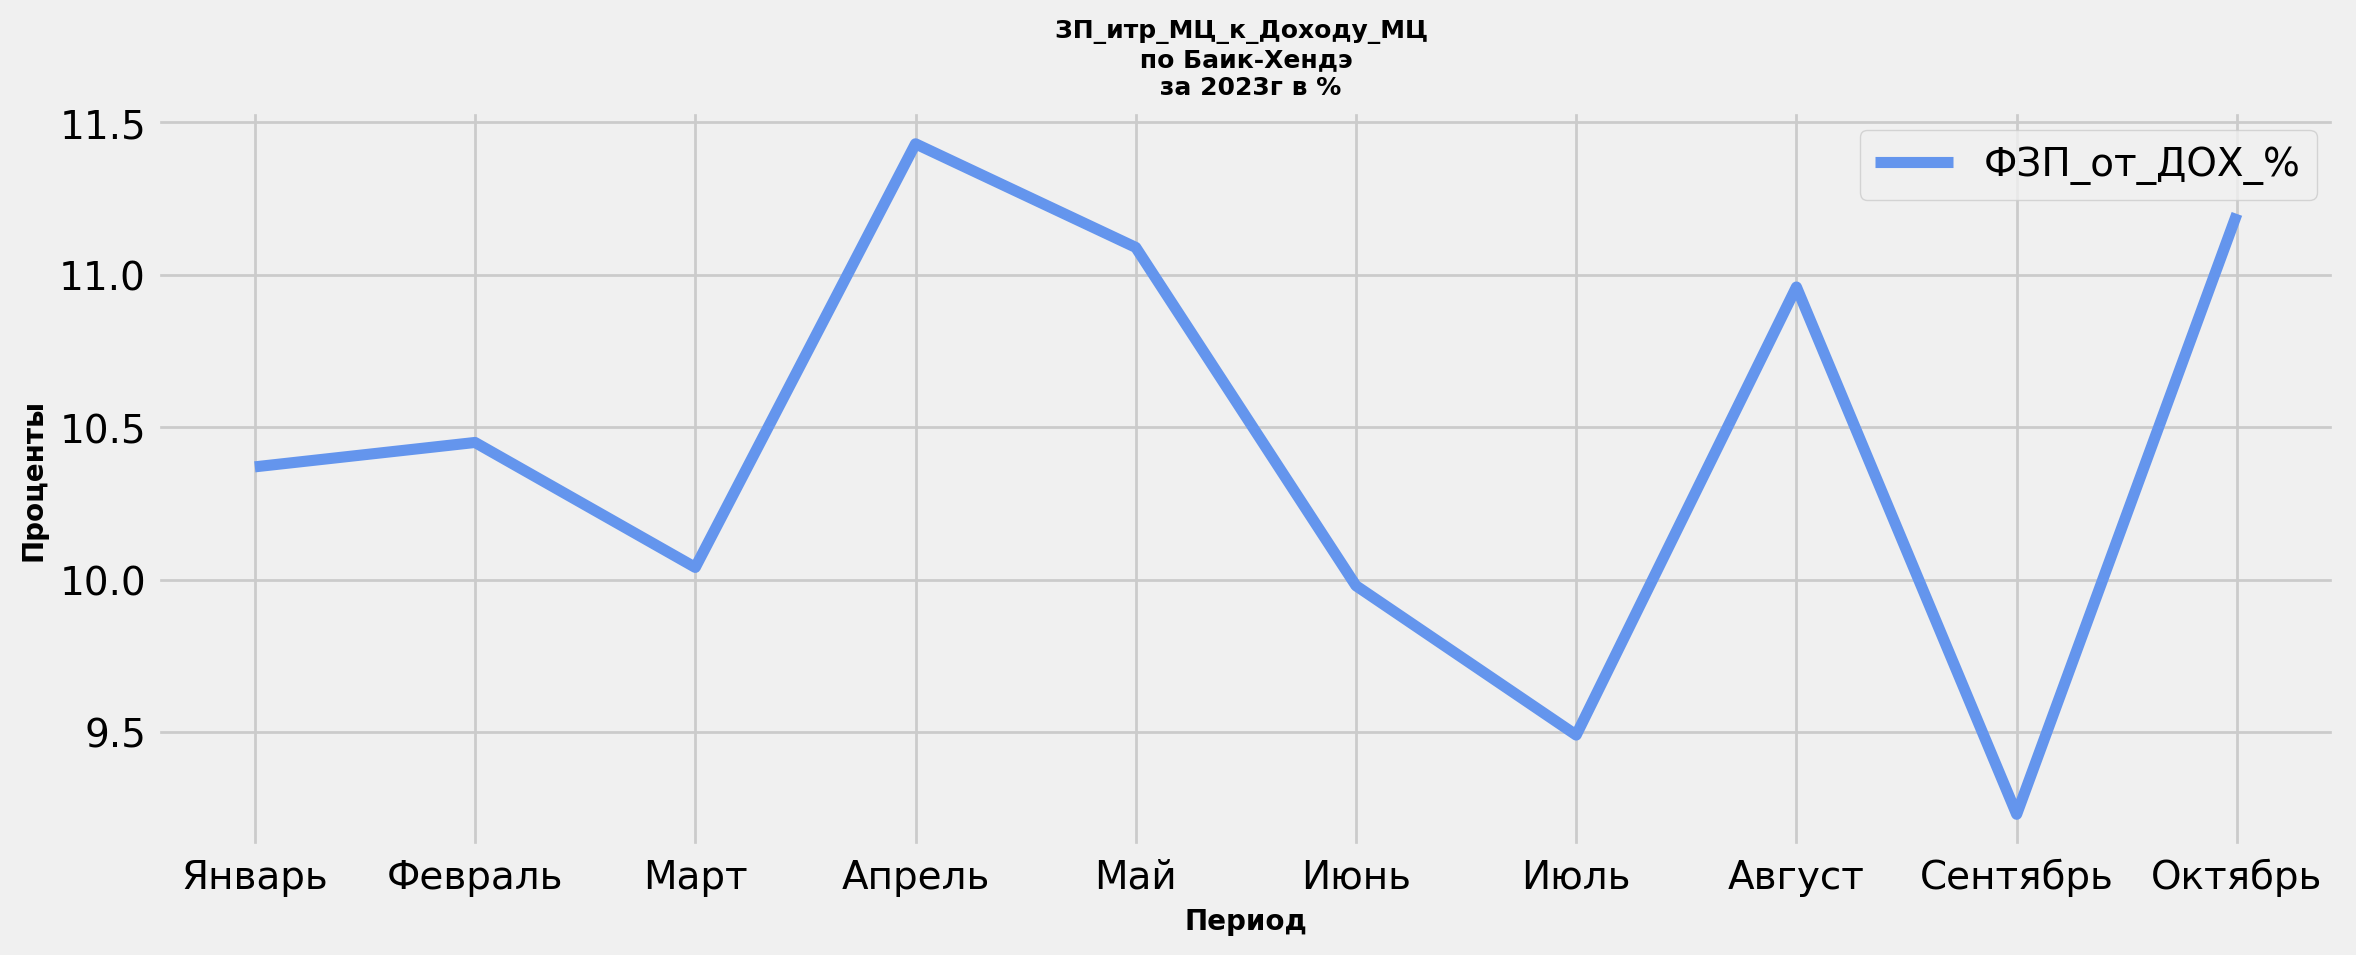

In [1444]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_MC_k_zp_MC_itr.df['месяц'], doh_MC_k_zp_MC_itr.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_MC_k_zp_MC_itr.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_MC_k_zp_MC_itr.name}.png')
    plt.show()

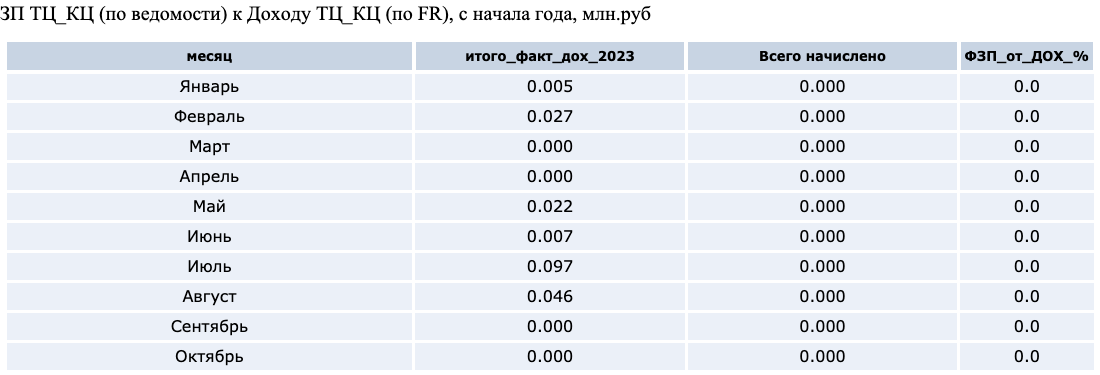

In [1445]:
fig = df2img.plot_dataframe(doh_KC_k_zp_KC.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_КЦ (по ведомости) к Доходу ТЦ_КЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦКЦ_к_зп_ТЦКЦ_ведомость_с_н_г.png")

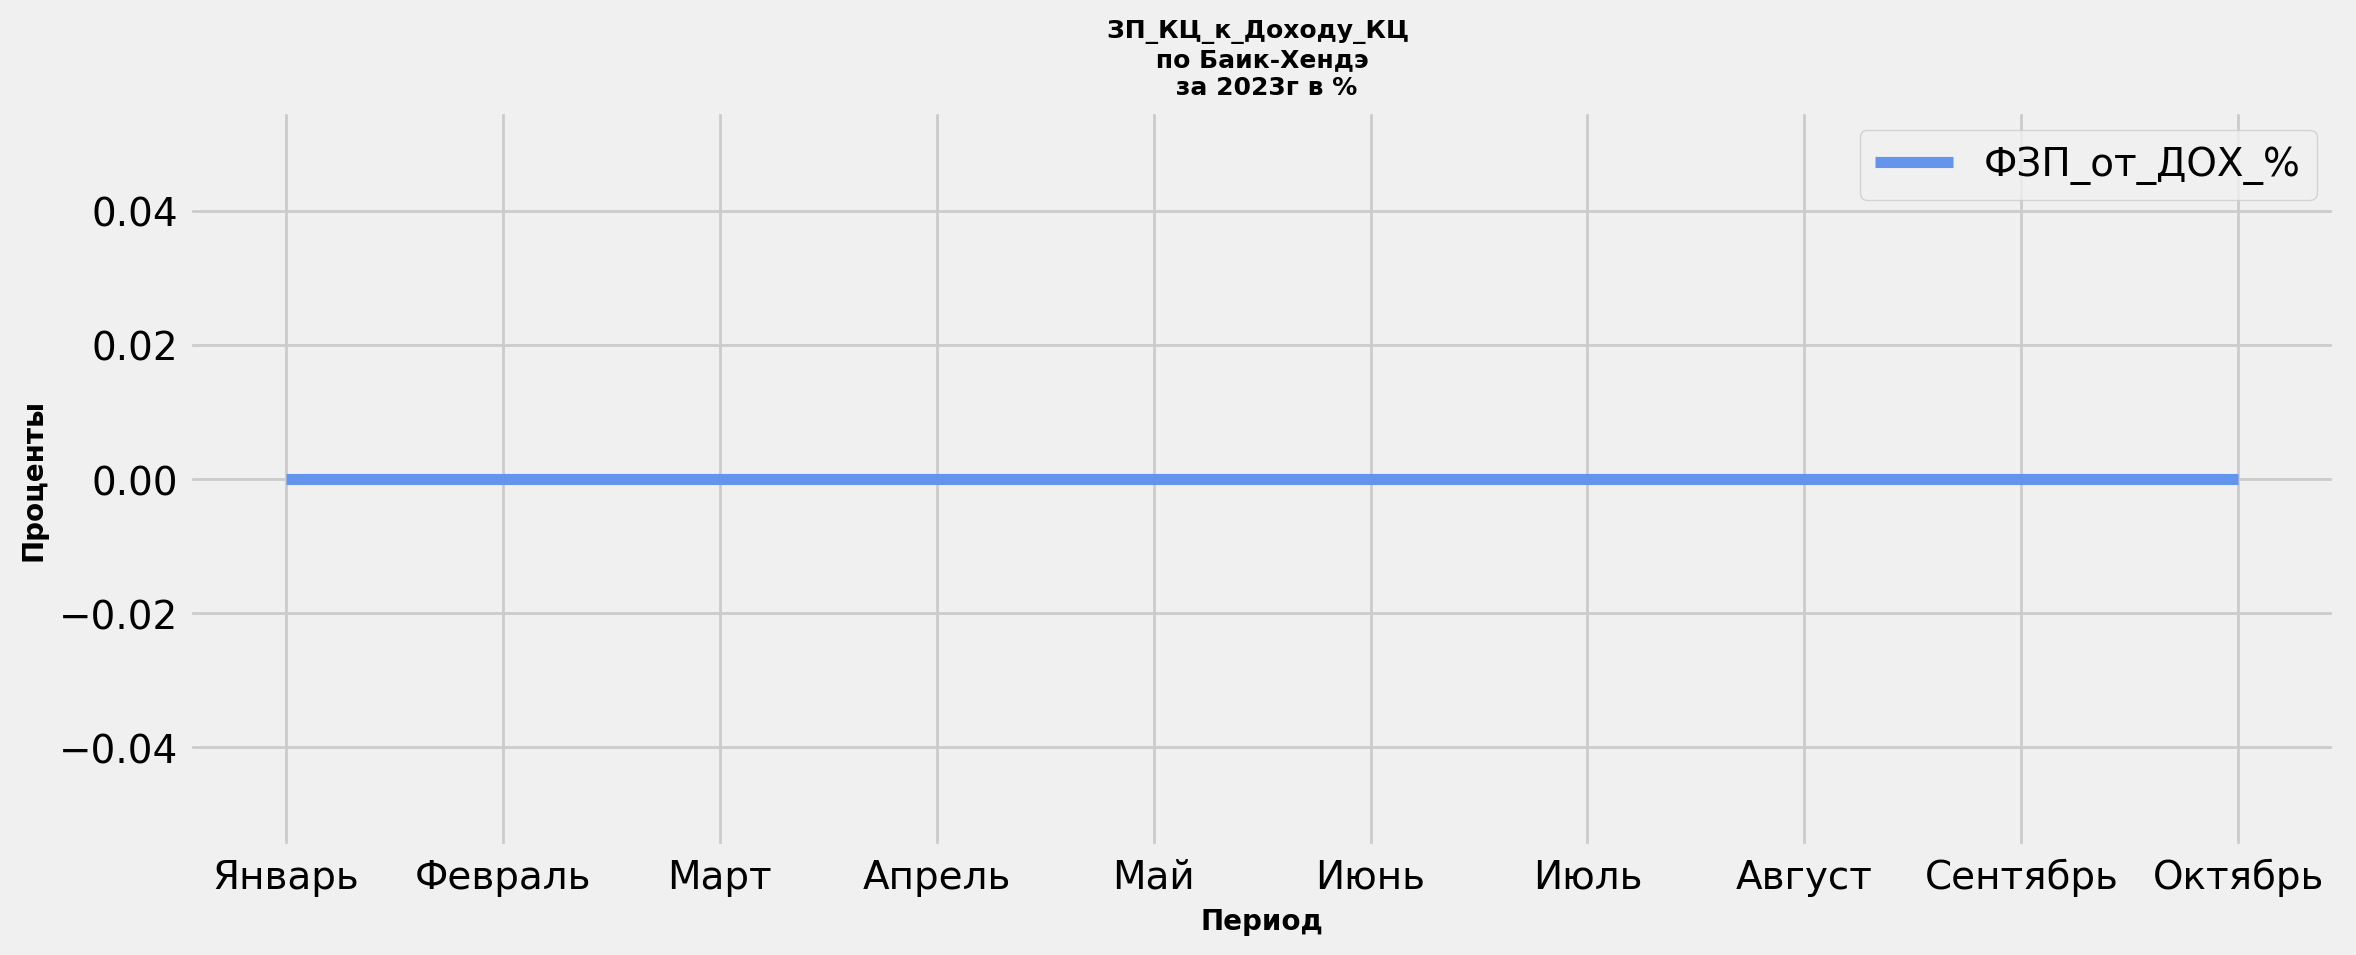

In [1446]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_KC_k_zp_KC.df['месяц'], doh_KC_k_zp_KC.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_KC_k_zp_KC.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_KC_k_zp_KC.name}.png')
    plt.show()

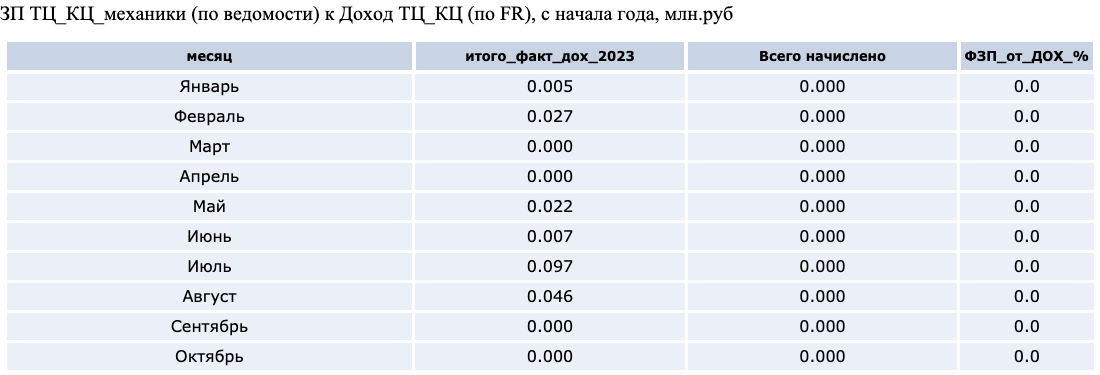

In [1447]:
fig = df2img.plot_dataframe(doh_KC_k_zp_KC_meh.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_КЦ_механики (по ведомости) к Доход ТЦ_КЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦКЦ_к_зп_ТЦКЦмех_ведомость_с_н_г.png")

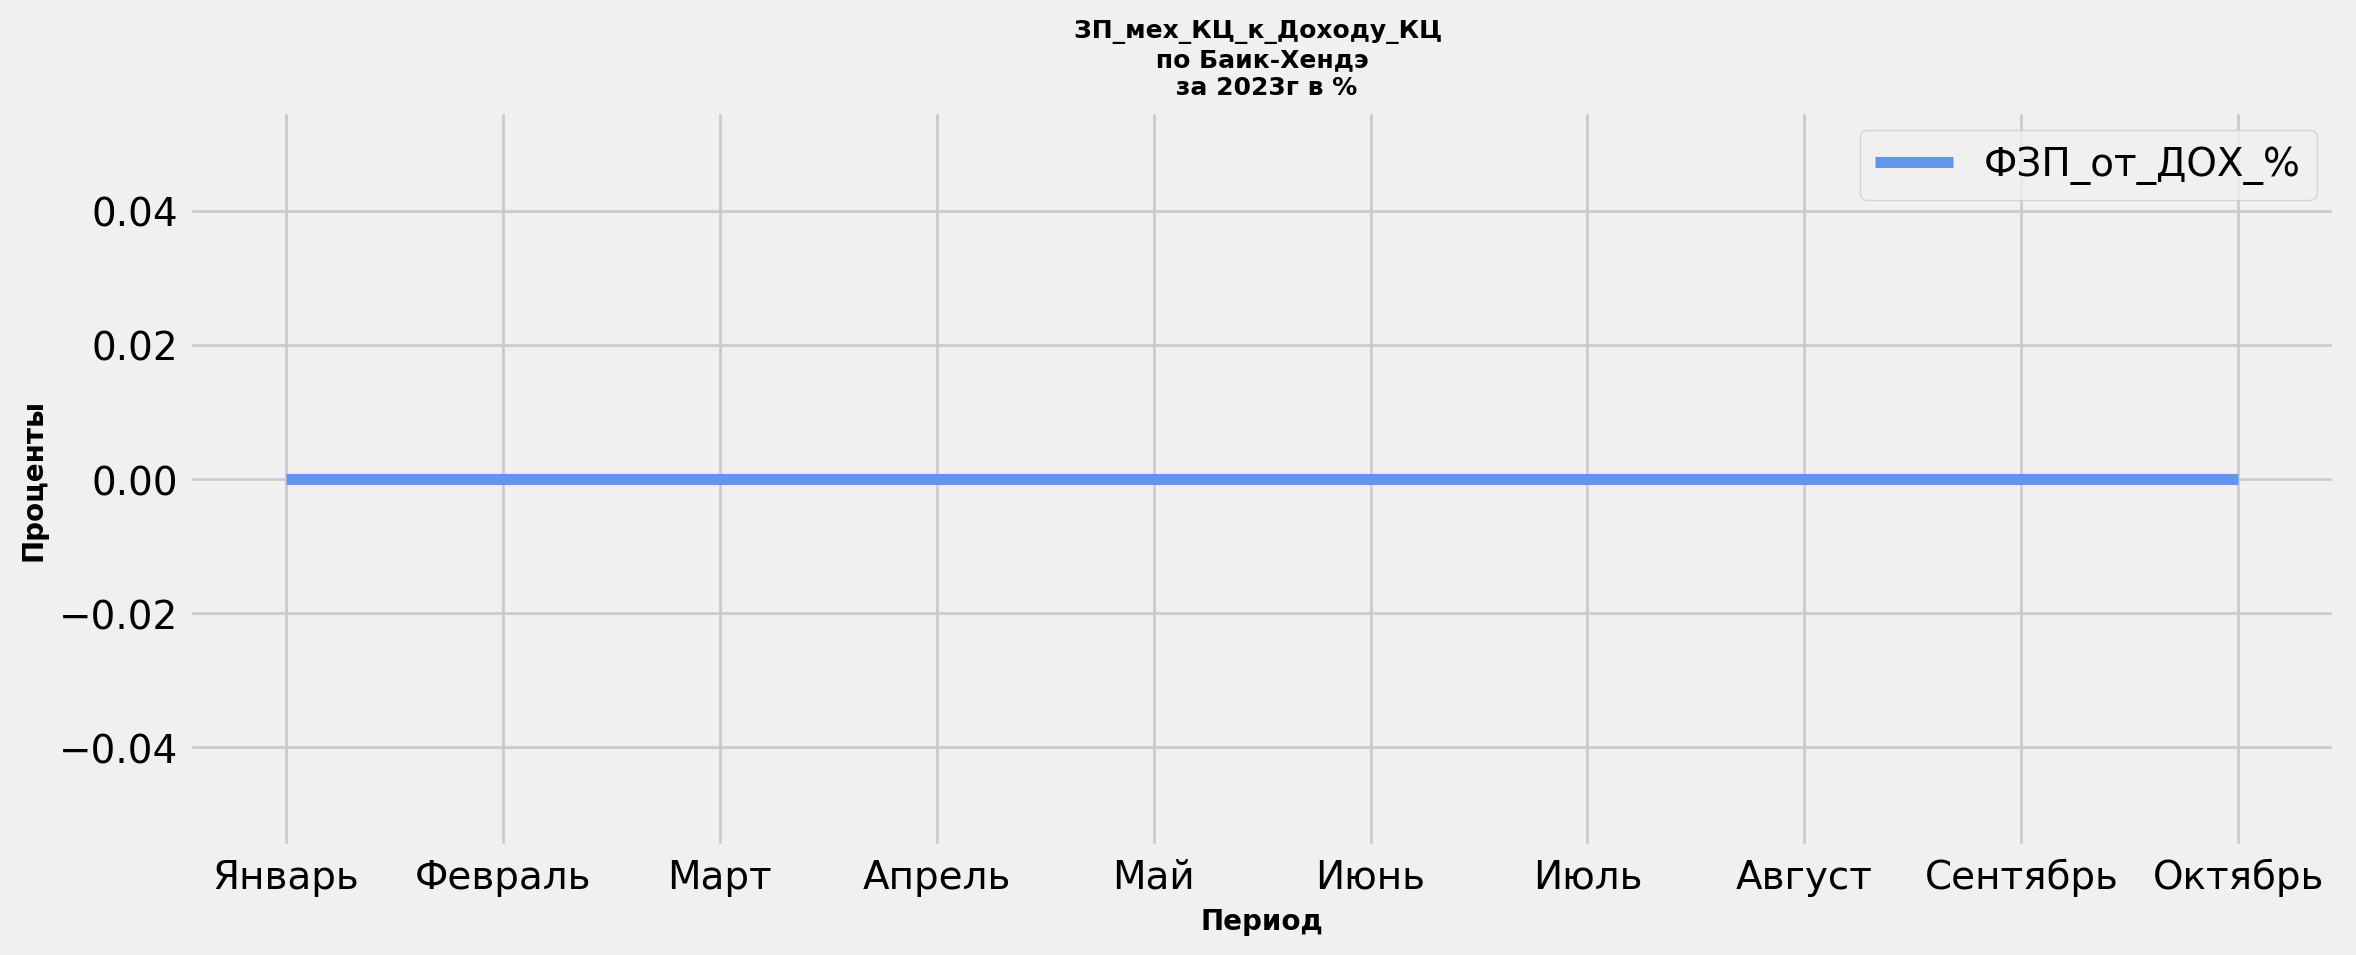

In [1448]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_KC_k_zp_KC_meh.df['месяц'], doh_KC_k_zp_KC_meh.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_KC_k_zp_KC_meh.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_KC_k_zp_KC_meh.name}.png')
    plt.show()

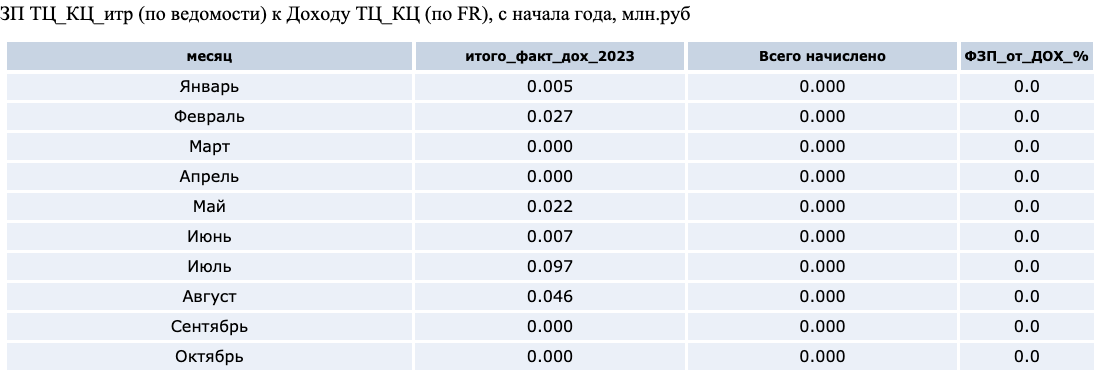

In [1449]:
fig = df2img.plot_dataframe(doh_KC_k_zp_KC_itr.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_КЦ_итр (по ведомости) к Доходу ТЦ_КЦ (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦКЦ_к_зп_ТЦКЦитр_ведомость_с_н_г.png")

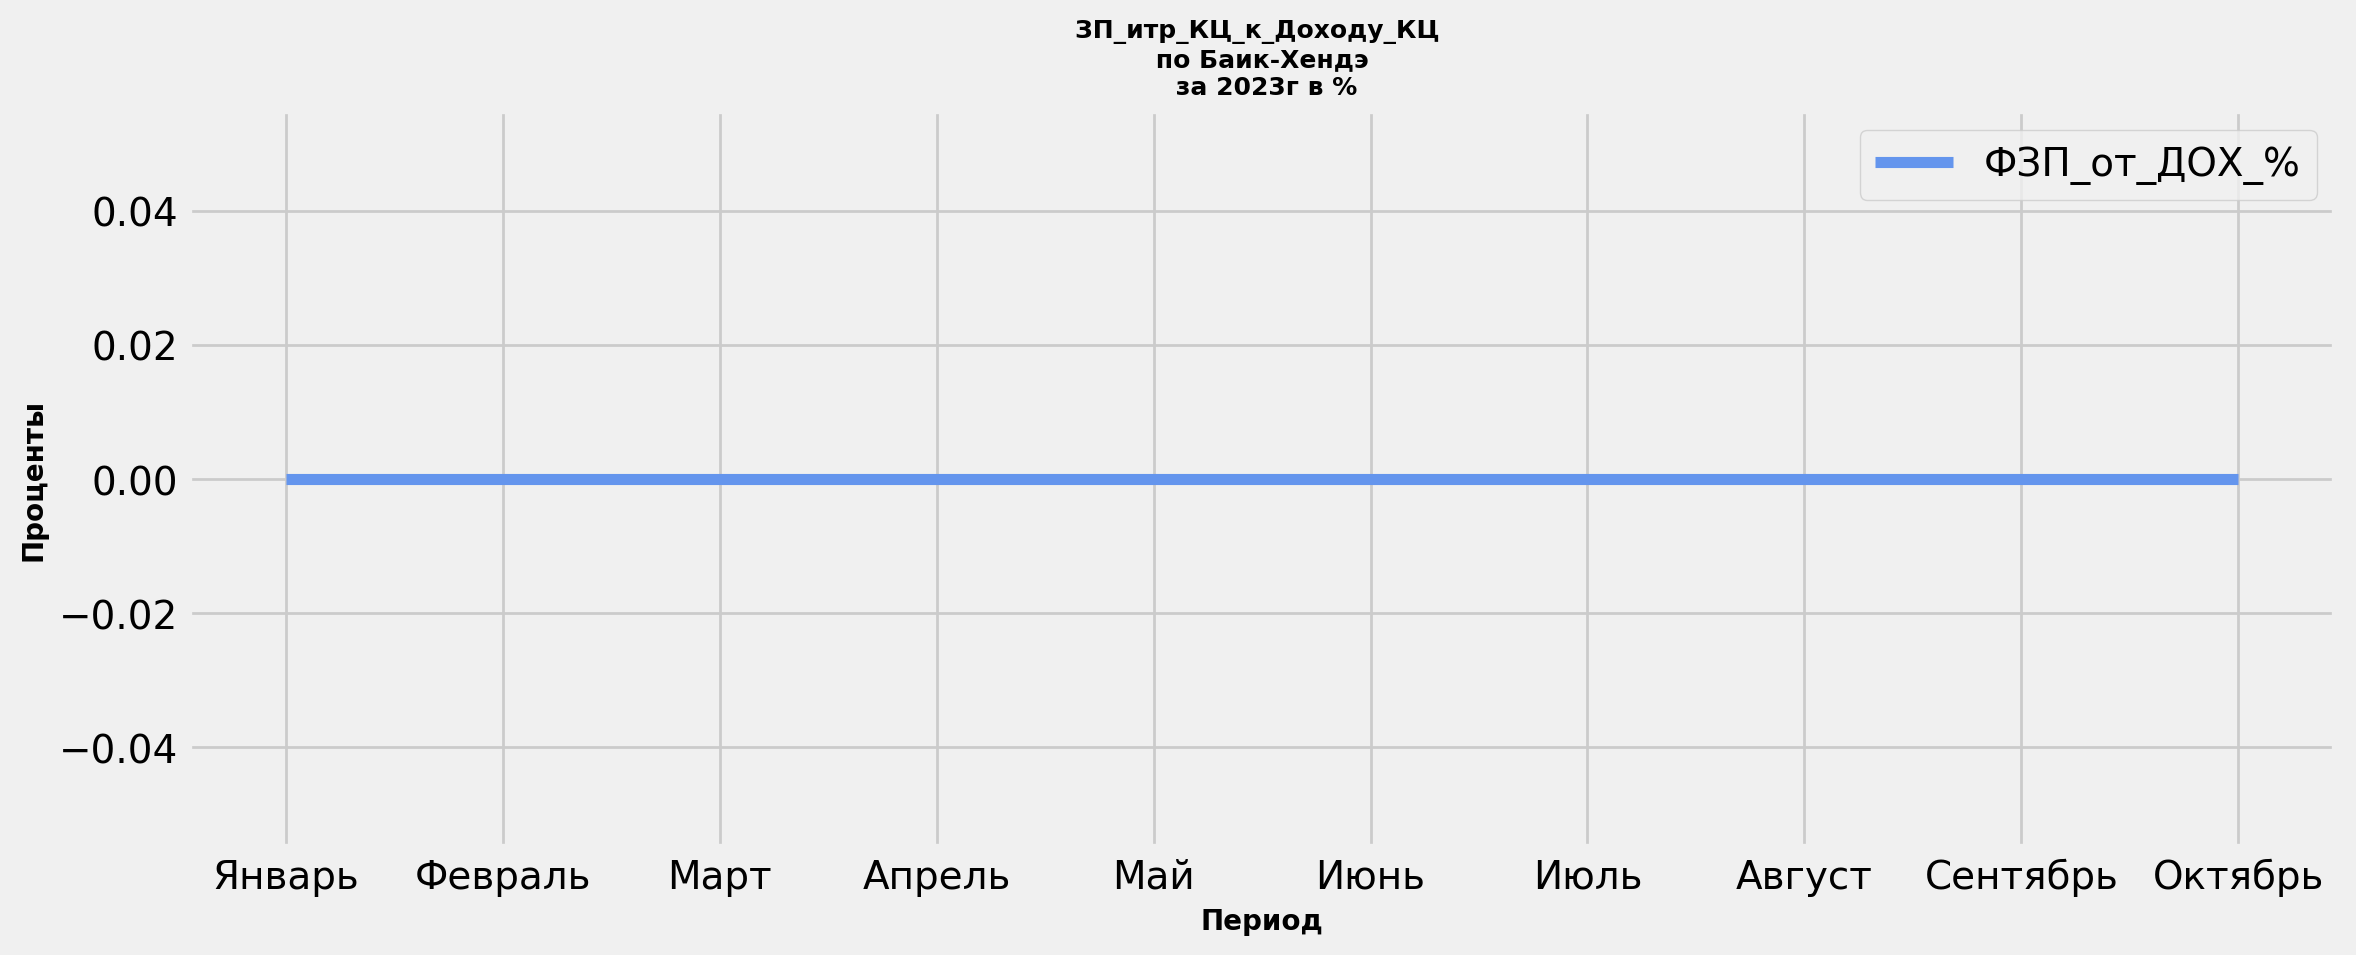

In [1450]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_KC_k_zp_KC_itr.df['месяц'], doh_KC_k_zp_KC_itr.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_KC_k_zp_KC_itr.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_KC_k_zp_KC_itr.name}.png')
    plt.show()

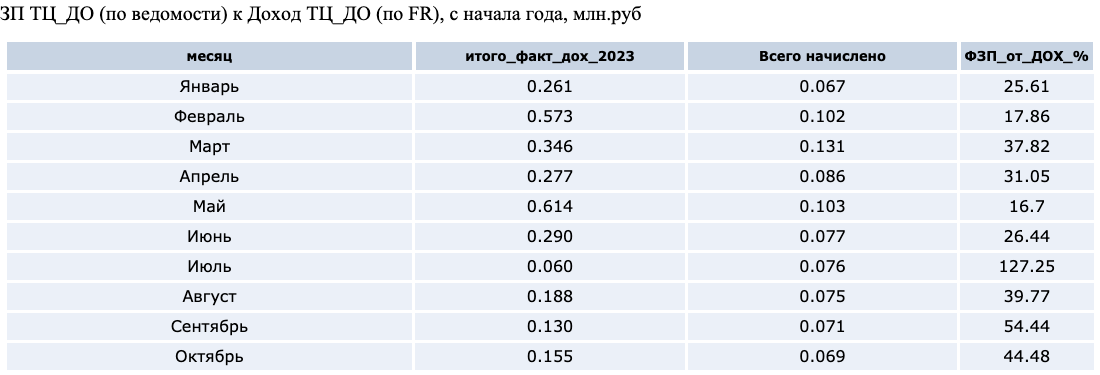

In [1451]:
fig = df2img.plot_dataframe(doh_DO_k_zp_DO.df.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.3, 0.2, 0.2, 0.1],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"ЗП ТЦ_ДО (по ведомости) к Доход ТЦ_ДО (по FR), с начала года, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_доход_ТЦДО_к_зп_ТЦДО_ведомость_с_н_г.png")

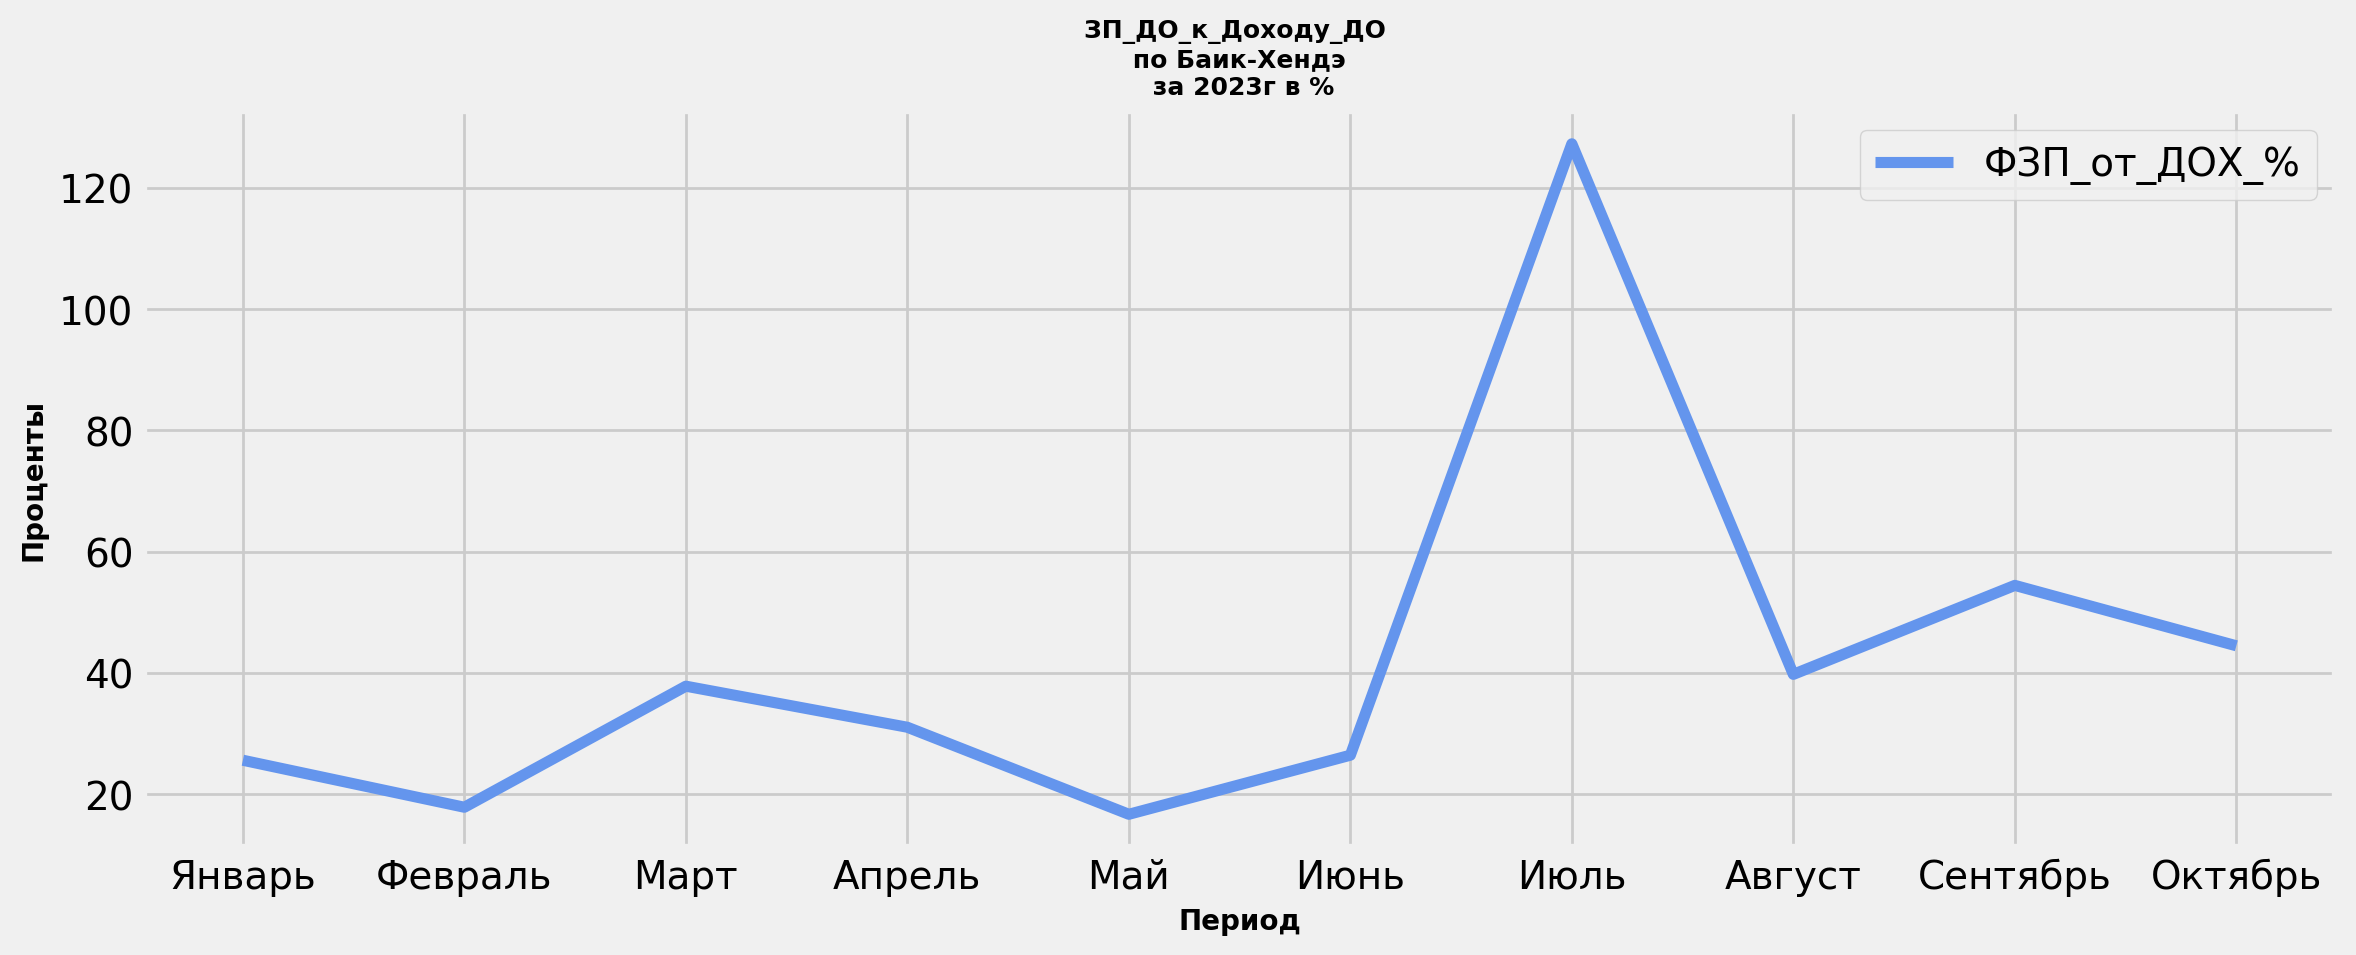

In [1452]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(doh_DO_k_zp_DO.df['месяц'], doh_DO_k_zp_DO.df[f'ФЗП_от_ДОХ_%'], label=f'ФЗП_от_ДОХ_%', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)

    plt.legend()
    plt.ylabel('Проценты',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"{doh_DO_k_zp_DO.name} \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'{doh_DO_k_zp_DO.name}.png')
    plt.show()

In [1453]:
dfi.export(res_x_vr.fillna(0), 'df_результат_деятельности_по_выручке_с_н_г.png', dpi=200)
dfi.export(res_x_doh.fillna(0), 'df_результат_деятельности_по_доходу_с_н_г.png', dpi=200)

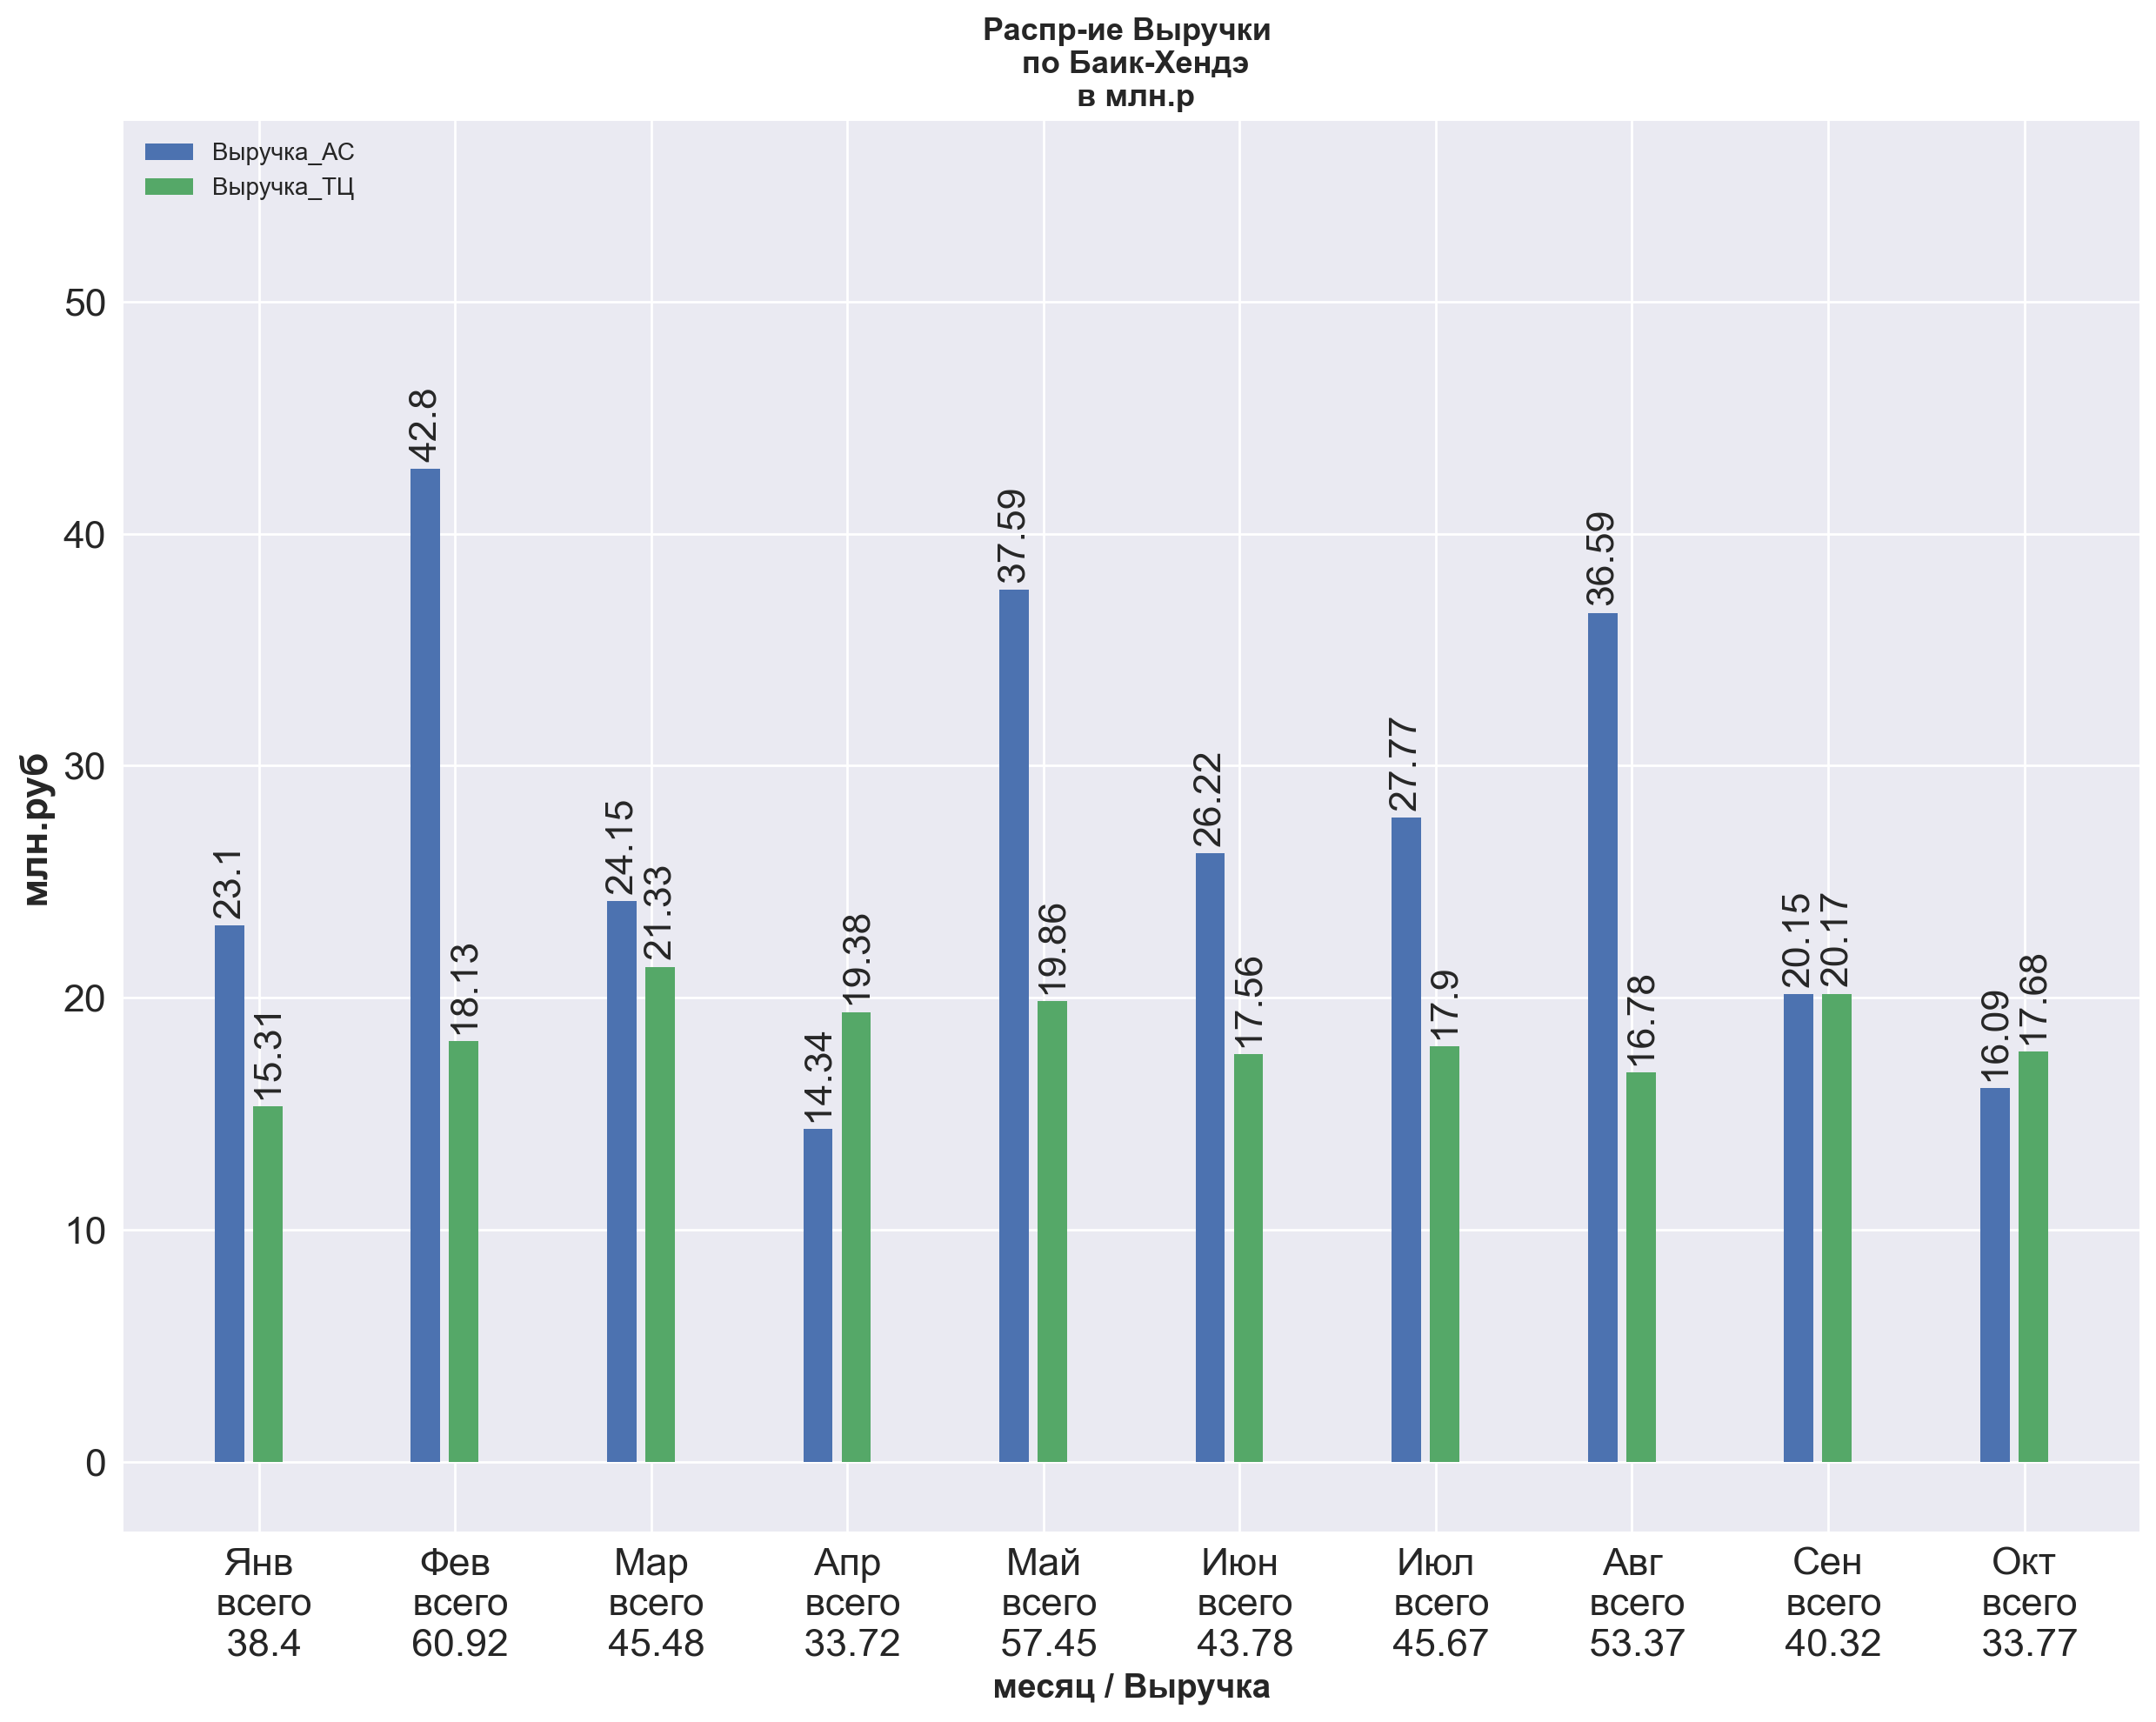

In [1454]:

with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep/seaborn-v0_8
    mmm = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()] 
    itogo_autom = [round(float(df_PF[(df_PF['индекс'] == ind_pf_revenue_all) 
                                     & (df_PF['автоцентр'] == name_ac) 
                                     & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]
    MMM = [f"{i[0:3]}\n всего\n {round(y,2)}" for i,y in zip(mmm, itogo_autom)]

    month_doh = MMM  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
            'Выручка_АС': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_revenue_AS) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'Выручка_ТЦ': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_revenue_mex_itg) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            
        }

    x = np.arange(len(month_doh))  # the label month
    width = 0.15  # ширина полос 
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),10), dpi=200)
    
    for name_doh, doh_value in doh_autocentr.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, doh_value, width, label=name_doh)
        ax.bar_label(rects, rotation=90, padding=3, fontsize = 16)
        multiplier += 1.3 # растояние между столбцами одной группы
    # скрипт определяющий построение графика по оси y min max для set_ylim
    mx = 0
    mi = 0
    for k,v in doh_autocentr.items():
        if max(v)>mx:
            mx = max(v)
        if min(v)<mi:
            mi = min(v)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('млн.руб', fontsize = 16, fontweight="bold")
    ax.set_title(f'Распр-ие Выручки \n по {spravka_new_name.get(name_ac, name_ac)}\n в млн.р', fontweight="bold", fontsize = 13)
    ax.set_xticks(x + width, month_doh)
    ax.legend(loc='upper left', ncols=1) # ncols=1 - столбцы легенды
    ax.set_ylim(mi-3, mx+15) # + корреткировка +2 млн
    
    plt.xticks(rotation=0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('месяц / Выручка',fontsize = 14, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('Выручка_.png') # сохряняет в картику
    plt.show()

In [1455]:
df_revenue_ALL_res = func_IND_podr_year(df_PF, ind_pf_revenue_all, 'факт', 'Выручка')
df_revenue_ALL_res[f'Выручка_с накоплением_{year_pf}'] = df_revenue_ALL_res[f'факт_Выручка_{year_pf}'].cumsum()
df_revenue_ALL_res = convertor_zeros(df_revenue_ALL_res)
df_revenue_ALL_res

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_Выручка_2023 Выручка_с накоплением_2023
6971      Январь            38.401                     38.401
32394    Февраль            60.922                     99.323
51429       Март            45.476                    144.799
65443     Апрель            33.720                    178.519
101345       Май            57.454                    235.973
106799      Июнь            43.785                    279.758
143705      Июль            45.674                    325.432
149280    Август            53.373                    378.805
166512  Сентябрь            40.323                    419.128
201652   Октябрь            33.767                    452.896

In [1456]:
df_revenue_ALL_res_2 = func_IND_podr_year(df_PF, ind_pf_revenue_all, 'факт', 'Выручка', year=year_pf-1)
df_revenue_ALL_res_2[f'Выручка_с накоплением_{year_pf-1}'] = df_revenue_ALL_res_2[f'факт_Выручка_{year_pf-1}'].cumsum()
df_revenue_ALL_res_2 = convertor_zeros(df_revenue_ALL_res_2)
df_revenue_ALL_res_2

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_Выручка_2022 Выручка_с накоплением_2022
6970      Январь           117.346                    117.346
32393    Февраль           135.059                    252.405
51430       Март           160.095                    412.500
65442     Апрель            64.405                    476.905
101346       Май            77.034                    553.939
106795      Июнь            85.850                    639.789
143706      Июль            80.149                    719.937
149290    Август            91.851                    811.789
166511  Сентябрь            71.710                    883.499
201653   Октябрь            55.553                    939.052

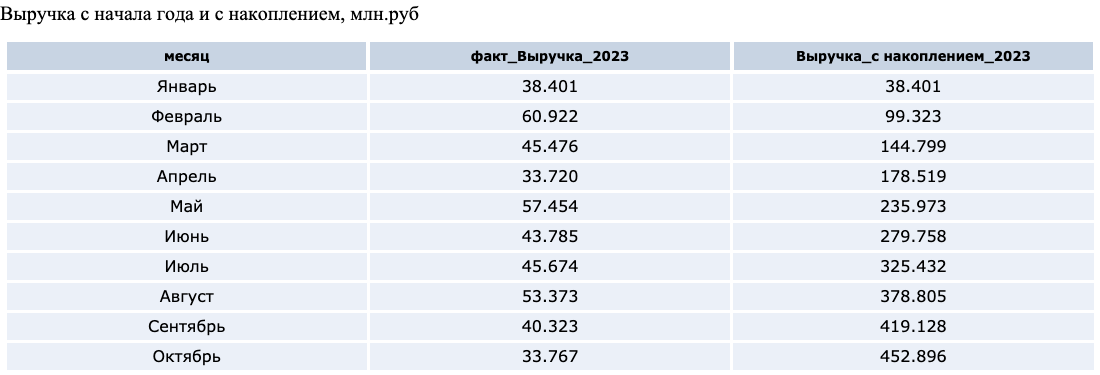

In [1457]:
fig = df2img.plot_dataframe(df_revenue_ALL_res.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.2, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"Выручка с начала года и с накоплением, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_выручка_накопл_с_н_г.png")

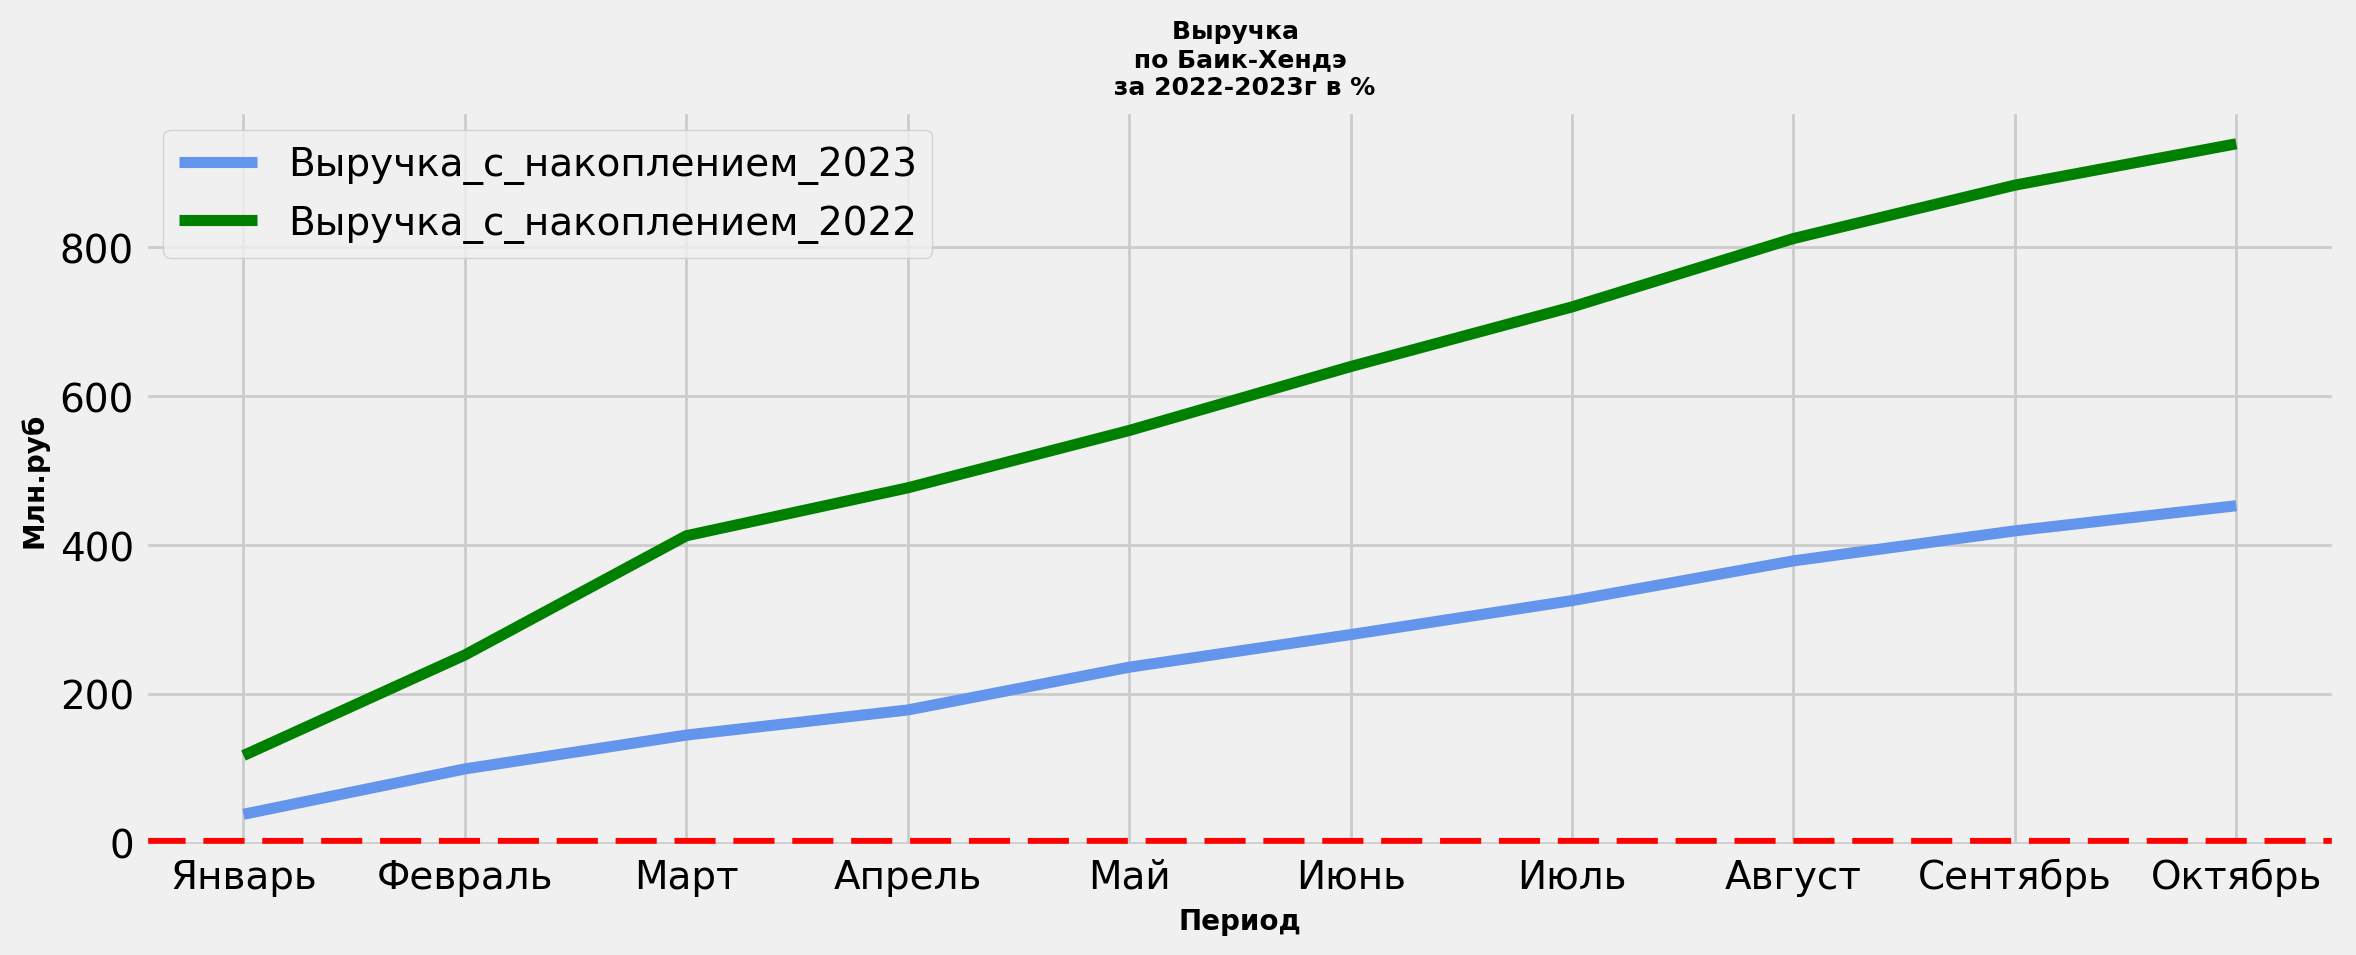

In [1458]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep /seaborn-v0_8
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_revenue_ALL_res['месяц'], 
             df_revenue_ALL_res[f'Выручка_с накоплением_{year_pf}'], 
             label=f'Выручка_с_накоплением_{year_pf}', color='cornflowerblue')
    
    plt.plot(df_revenue_ALL_res_2['месяц'], 
             df_revenue_ALL_res_2[f'Выручка_с накоплением_{year_pf-1}'], 
             label=f'Выручка_с_накоплением_{year_pf-1}', color='green')
    
    plt.xticks(rotation=0)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.legend()
    plt.ylabel('Млн.руб',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"Выручка \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf-1}-{year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'ВЫРУЧКА_с_накопл.png')
    plt.show()

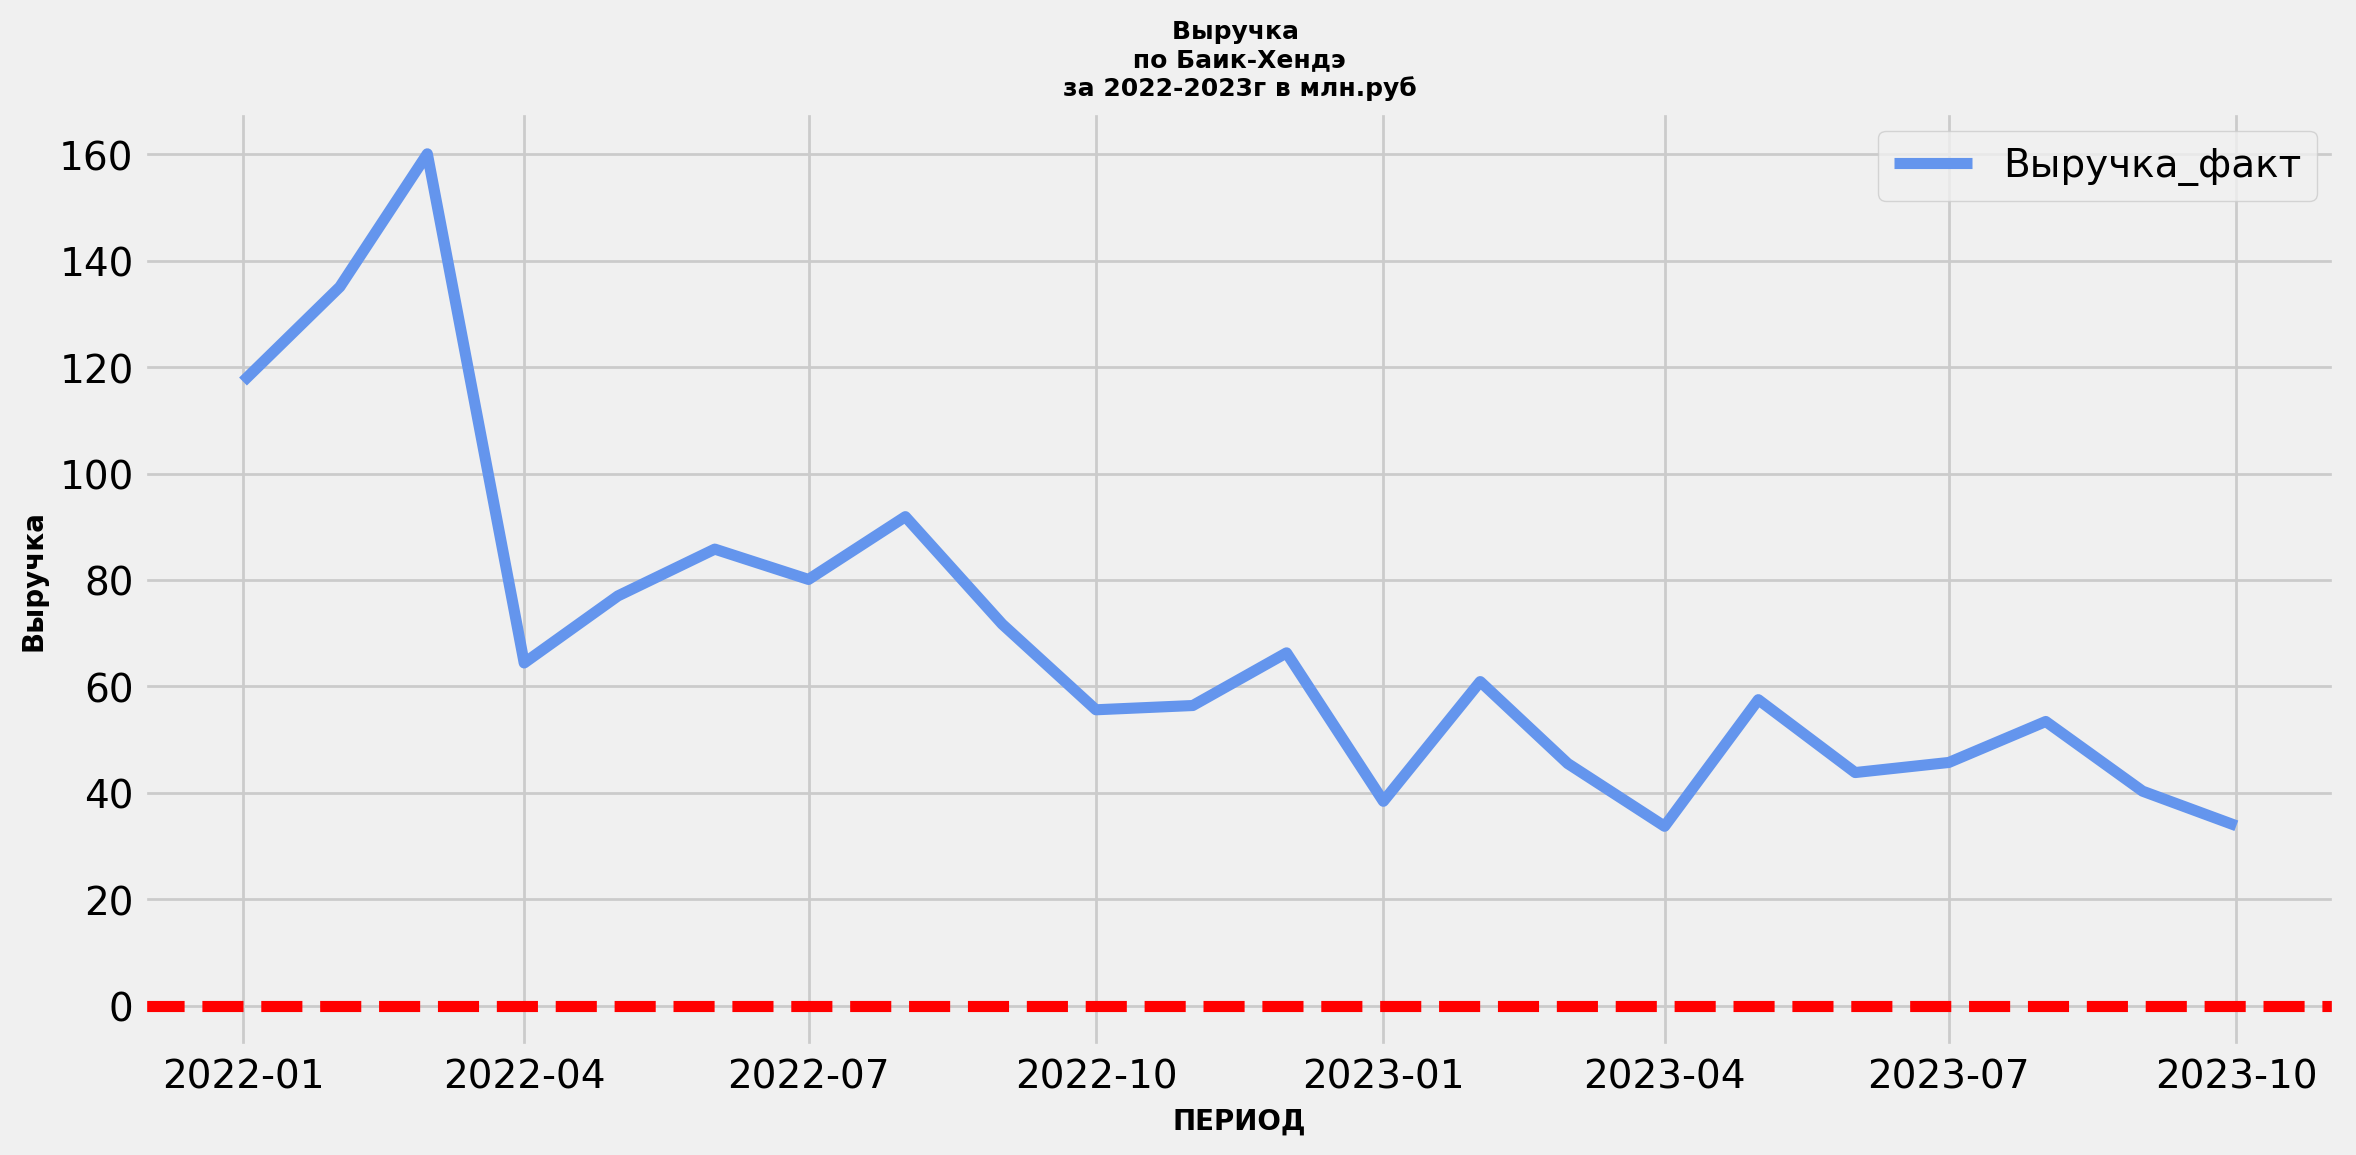

In [1459]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep /seaborn-v0_8
    plt.figure(figsize=(12,6), dpi=200) # размер графика
    plt.plot(dynamic_2_years(df_PF, ind_pf_revenue_all)['Дата'], 
             dynamic_2_years(df_PF, ind_pf_revenue_all)['факт'], 
             label='Выручка_факт', color='cornflowerblue')
    
    #plt.plot(om_result_dinamic['Дата'], om_result_dinamic['план'], label='ОМ_план', color='red') # этустроку убрать
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)
    # добавляем ось X
    plt.axhline(y=0, color='red', linestyle='--')

    plt.legend()
    plt.ylabel('Выручка',fontsize = 10, fontweight="bold")
    plt.xlabel('ПЕРИОД',fontsize = 10, fontweight="bold")
    plt.title(f"Выручка \n по {spravka_new_name.get(name_ac, name_ac)} \nза {year_pf-1}-{year_pf}г в млн.руб",fontsize = 9, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('Выручка_динамика_2_года.png') # сохряняет в картику
    plt.show()

In [1460]:
"БЛОК С РАСХОДАМИ"

'БЛОК С РАСХОДАМИ'

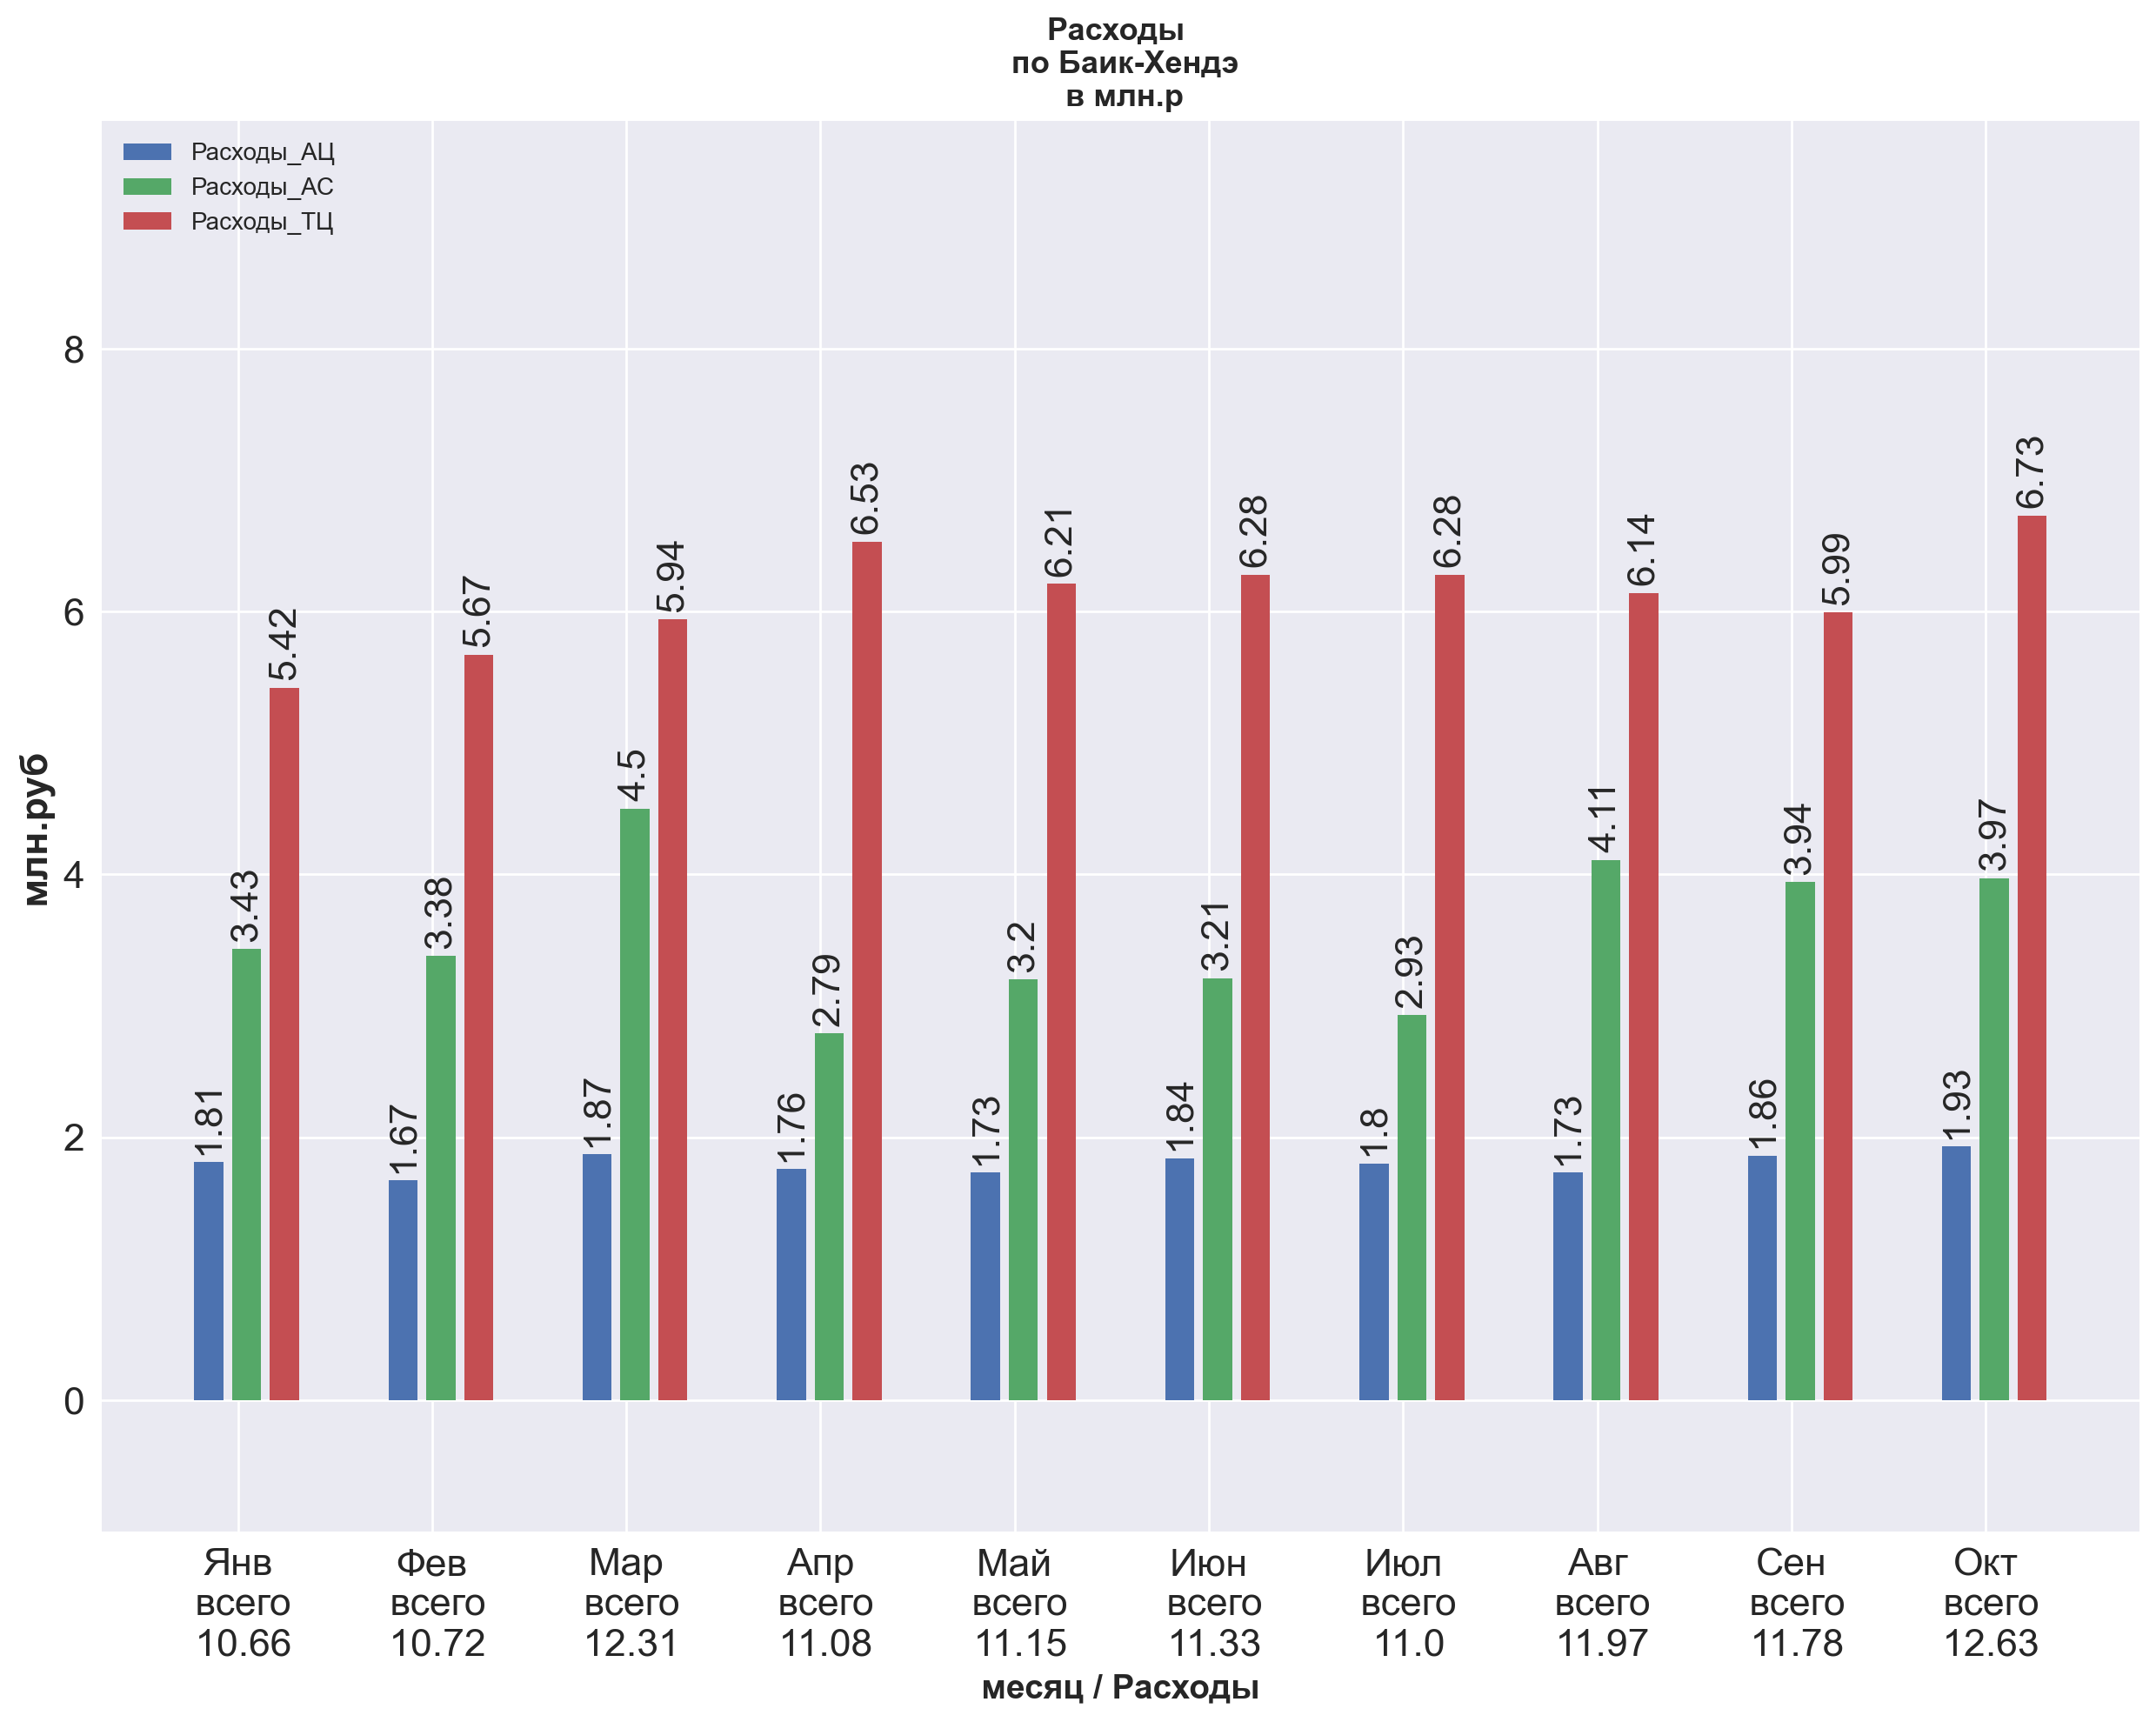

In [1461]:

with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    mmm = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()] 
    itogo_autom = [round(float(df_PF[(df_PF['индекс'] == ind_expenses_all) 
                                     & (df_PF['автоцентр'] == name_ac) 
                                     & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]
    MMM = [f"{i[0:3]}\n всего\n {round(y,2)}" for i,y in zip(mmm, itogo_autom)]

    month_doh = MMM  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
            'Расходы_АЦ': np.array([round(float(df_PF[(df_PF['индекс'] == ind_expenses_AC) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'Расходы_АС': np.array([round(float(df_PF[(df_PF['индекс'] == ind_expenses_AS) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'Расходы_ТЦ': np.array([round(float(df_PF[(df_PF['индекс'] == ind_expenses_TC) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            
        }

    x = np.arange(len(month_doh))  # the label month
    width = 0.15  # ширина полос 
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),10), dpi=200)
    
    for name_doh, doh_value in doh_autocentr.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, doh_value, width, label=name_doh)
        ax.bar_label(rects, rotation=90, padding=3, fontsize = 16)
        multiplier += 1.3 # растояние между столбцами одной группы
    # скрипт определяющий построение графика по оси y min max для set_ylim
    mx = 0
    mi = 0
    for k,v in doh_autocentr.items():
        if max(v)>mx:
            mx = max(v)
        if min(v)<mi:
            mi = min(v)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('млн.руб', fontsize = 16, fontweight="bold")
    ax.set_title(f'Расходы \n по {spravka_new_name.get(name_ac, name_ac)}\n в млн.р', fontweight="bold", fontsize = 13)
    ax.set_xticks(x + width, month_doh)
    ax.legend(loc='upper left', ncols=1) # ncols=1 - столбцы легенды
    ax.set_ylim(mi-1, mx+3) # + корреткировка +2 млн
    
    plt.xticks(rotation=0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('месяц / Расходы',fontsize = 14, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('РАСХОДЫ_.png') # сохряняет в картику
    plt.show()

In [1462]:
df_rash_post = pd.merge(func_IND_podr_year(df_PF, ind = ind_expenses_all, fkt_or_pln = 'факт',ren='ВСЕГО'),
                        func_IND_podr_year(df_PF, ind = ind_expenses_ZP, fkt_or_pln = 'факт',ren='ЗП'))

df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_nalog_fot, fkt_or_pln = 'факт',ren='Налог_ФОТ'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_rent, fkt_or_pln = 'факт',ren='Аренда'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_advertising, fkt_or_pln = 'факт',ren='Реклама'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_connection, fkt_or_pln = 'факт',ren='Связь'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_pzv_njd, fkt_or_pln = 'факт',ren='Пр_нужды'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_hoz_njd, fkt_or_pln = 'факт',ren='Хоз_нужды'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_pc_po, fkt_or_pln = 'факт',ren='Комп_по'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_proch, fkt_or_pln = 'факт',ren='Прочие'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_ub, fkt_or_pln = 'факт',ren='Убытки'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_amrt, fkt_or_pln = 'факт',ren='Амортизация'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_amrt_dop, fkt_or_pln = 'факт',ren='Амортизация_доп'))
df_rash_post = pd.merge(df_rash_post,
                        func_IND_podr_year(df_PF, ind = ind_expenses_security, fkt_or_pln = 'факт',ren='Охрана'))

df_rash_post = df_rash_post.rename(columns={f'факт_ЗП_{year_pf}': 'ЗП', f'факт_Налог_ФОТ_{year_pf}': 'Нал_ФОТ',
                                            f'факт_Аренда_{year_pf}': 'Аренда', f'факт_Реклама_{year_pf}': 'Реклама',
                                            f'факт_Связь_{year_pf}': 'Связь', f'факт_Пр_нужды_{year_pf}': 'Пр_нужд',
                                            f'факт_Хоз_нужды_{year_pf}': 'Хоз_нужд', f'факт_Комп_по_{year_pf}': 'ПК_и_ПО',
                                            f'факт_Прочие_{year_pf}': 'Прочие', f'факт_Убытки_{year_pf}': 'Убытки',
                                            f'факт_Амортизация_{year_pf}': 'Амртз', f'факт_Охрана_{year_pf}': 'Охрана',
                                            f'факт_ВСЕГО_{year_pf}': 'Всего', f'факт_Амортизация_доп_{year_pf}': 'Амртз_доп'})

df_rash_post_percent = df_rash_post.copy()


func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>
func_float_df_digit: месяц не преобразован в <class 'float'>


In [1463]:
df_rash_post = convertor_zeros(df_rash_post)
df_rash_post

месяц не удалось преобразовать


месяц   Всего     ЗП Нал_ФОТ Аренда Реклама  Связь Пр_нужд Хоз_нужд  \
0    Январь  10.658  4.068   1.876  2.619   0.753  0.102   0.695    0.330   
1   Февраль  10.723  4.295   1.720  2.621   0.731  0.118   0.514    0.346   
2      Март  12.308  5.555   2.305  2.583   0.724  0.113   0.340    0.381   
3    Апрель  11.081  4.892   1.737  2.565   0.759  0.117   0.343    0.321   
4       Май  11.146  4.872   1.636  2.480   0.852  0.113   0.582    0.324   
5      Июнь  11.329  4.786   1.872  2.501   0.812  0.113   0.448    0.431   
6      Июль  10.998  4.632   1.715  2.494   0.792  0.123   0.359    0.511   
7    Август  11.969  4.655   1.879  2.533   1.695  0.108   0.339    0.353   
8  Сентябрь  11.782  4.489   2.038  2.488   1.555  0.114   0.372    0.394   
9   Октябрь  12.630  4.730   1.693  2.495   1.610  0.134   1.060    0.359   

  ПК_и_ПО Прочие Убытки  Амртз Амртз_доп Охрана  
0   0.017  0.120  0.026  0.010     0.040  0.000  
1   0.082  0.125  0.132  0.000     0.040  0.000  
2   0.075  0.138  0.054  0.000     0.040  0.000  
3   0.073  0.178  0.058  0.000     0.040  0.000  
4   0.077  0.134  0.036  0.000     0.040  0.000  
5   0.082  0.138  0.093  0.008     0.046  0.000  
6   0.078  0.165  0.082  0.000     0.046  0.000  
7   0.072  0.210  0.078  0.000     0.046  0.000  
8   0.096  0.122  0.067  0.000     0.046  0.000  
9   0.074  0.210  0.107  0.016     0.143  0.000

In [1464]:
drop_colm_post_rsh = [i for i in df_rash_post_percent.columns if i not in ('месяц')]

In [1465]:
for i in df_rash_post_percent.columns:
    if i not in ('месяц', 'Всего'):
        df_rash_post_percent[f'{i}'] = round((df_rash_post_percent[f'{i}']/df_rash_post_percent['Всего'])*100,2)
df_rash_post_percent

месяц       Всего    ЗП  Нал_ФОТ  Аренда  Реклама  Связь  Пр_нужд  \
0    Январь 10657875.35 38.17    17.60   24.58     7.07   0.96     6.52   
1   Февраль 10723130.73 40.05    16.04   24.44     6.82   1.10     4.79   
2      Март 12307662.66 45.14    18.73   20.99     5.88   0.92     2.76   
3    Апрель 11081251.79 44.15    15.67   23.15     6.85   1.05     3.09   
4       Май 11145819.76 43.71    14.68   22.25     7.64   1.01     5.22   
5      Июнь 11329427.91 42.25    16.52   22.07     7.17   1.00     3.95   
6      Июль 10997543.49 42.12    15.60   22.68     7.20   1.12     3.27   
7    Август 11968685.69 38.89    15.70   21.16    14.16   0.91     2.83   
8  Сентябрь 11781802.94 38.10    17.30   21.11    13.20   0.97     3.16   
9   Октябрь 12630042.28 37.45    13.40   19.75    12.75   1.06     8.39   

   Хоз_нужд  ПК_и_ПО  Прочие  Убытки  Амртз  Амртз_доп  Охрана  
0      3.10     0.16    1.13    0.25   0.09       0.38    0.00  
1      3.22     0.77    1.16    1.23   0.00       0.37    0.00  
2      3.10     0.61    1.12    0.44   0.00       0.33    0.00  
3      2.89     0.66    1.61    0.52   0.00       0.36    0.00  
4      2.90     0.69    1.20    0.33   0.00       0.36    0.00  
5      3.80     0.72    1.22    0.82   0.07       0.41    0.00  
6      4.65     0.71    1.50    0.74   0.00       0.42    0.00  
7      2.95     0.60    1.75    0.65   0.00       0.39    0.00  
8      3.34     0.81    1.04    0.57   0.00       0.39    0.00  
9      2.84     0.59    1.66    0.85   0.13       1.13    0.00

In [1466]:
df_rash_post_percent.drop(['Всего'], axis=1, inplace=True)
df_rash_post_percent


месяц    ЗП  Нал_ФОТ  Аренда  Реклама  Связь  Пр_нужд  Хоз_нужд  \
0    Январь 38.17    17.60   24.58     7.07   0.96     6.52      3.10   
1   Февраль 40.05    16.04   24.44     6.82   1.10     4.79      3.22   
2      Март 45.14    18.73   20.99     5.88   0.92     2.76      3.10   
3    Апрель 44.15    15.67   23.15     6.85   1.05     3.09      2.89   
4       Май 43.71    14.68   22.25     7.64   1.01     5.22      2.90   
5      Июнь 42.25    16.52   22.07     7.17   1.00     3.95      3.80   
6      Июль 42.12    15.60   22.68     7.20   1.12     3.27      4.65   
7    Август 38.89    15.70   21.16    14.16   0.91     2.83      2.95   
8  Сентябрь 38.10    17.30   21.11    13.20   0.97     3.16      3.34   
9   Октябрь 37.45    13.40   19.75    12.75   1.06     8.39      2.84   

   ПК_и_ПО  Прочие  Убытки  Амртз  Амртз_доп  Охрана  
0     0.16    1.13    0.25   0.09       0.38    0.00  
1     0.77    1.16    1.23   0.00       0.37    0.00  
2     0.61    1.12    0.44   0.00       0.33    0.00  
3     0.66    1.61    0.52   0.00       0.36    0.00  
4     0.69    1.20    0.33   0.00       0.36    0.00  
5     0.72    1.22    0.82   0.07       0.41    0.00  
6     0.71    1.50    0.74   0.00       0.42    0.00  
7     0.60    1.75    0.65   0.00       0.39    0.00  
8     0.81    1.04    0.57   0.00       0.39    0.00  
9     0.59    1.66    0.85   0.13       1.13    0.00

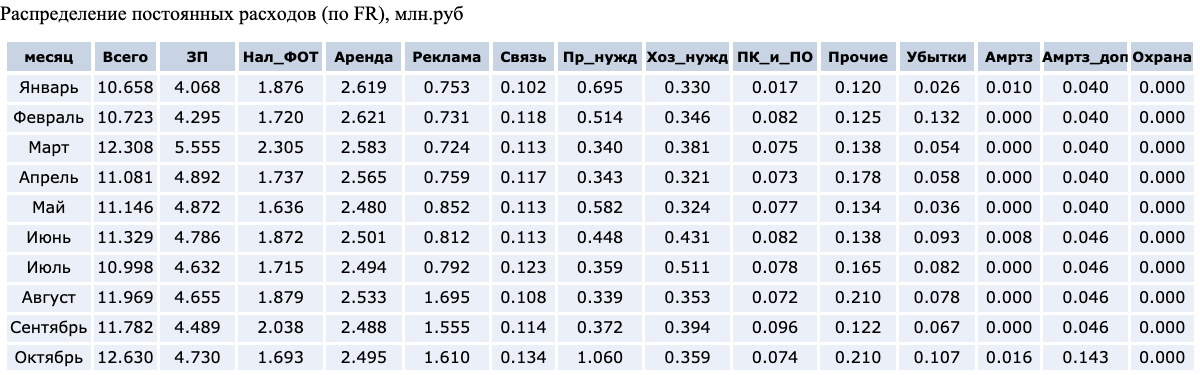

In [1467]:
fig = df2img.plot_dataframe(
      df_rash_post.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.2, 0.15, 0.18, 0.2, 0.18, 0.2, 0.15, 0.2, 0.2, 0.2, 0.18, 0.18, 0.15, 0.2, 0.15],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Распределение постоянных расходов (по FR), млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=14,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1200, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_распределение_постоянных_расходов_млн.png")

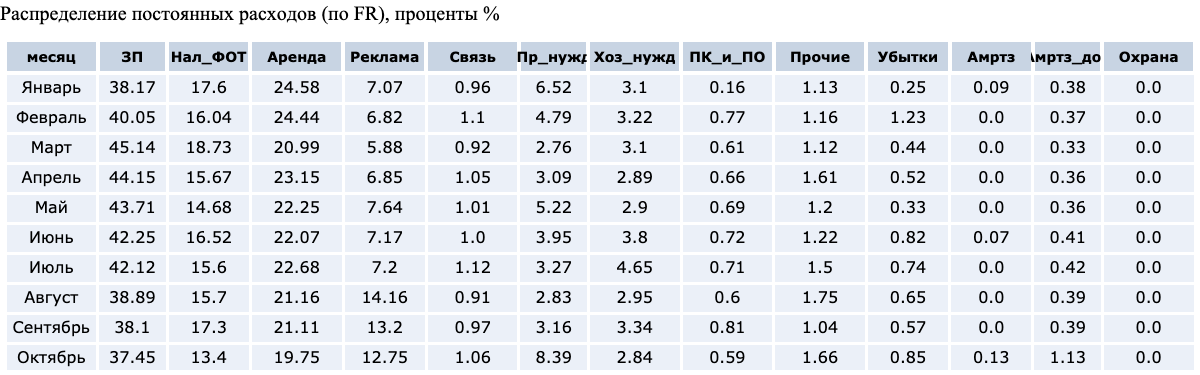

In [1468]:
fig = df2img.plot_dataframe(
      df_rash_post_percent.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.2, 0.15, 0.18, 0.2, 0.18, 0.2, 0.15, 0.2, 0.2, 0.2, 0.18, 0.18, 0.15, 0.2, 0.15],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text="Распределение постоянных расходов (по FR), проценты %",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=14,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1200, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_распределение_постоянных_расходов_процент.png")

In [1469]:
df_expenses_all_res = func_IND_podr_year(df_PF, ind_expenses_all, 'факт', 'РАСХОД')
df_expenses_all_res[f'РАСХОД_с накоплением_{year_pf}'] = df_expenses_all_res[f'факт_РАСХОД_{year_pf}'].cumsum()
df_expenses_all_res = convertor_zeros(df_expenses_all_res)
df_expenses_all_res

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_РАСХОД_2023 РАСХОД_с накоплением_2023
13691     Январь           10.658                    10.658
27805    Февраль           10.723                    21.381
53449       Март           12.308                    33.689
67461     Апрель           11.081                    44.770
87742        Май           11.146                    55.916
113505      Июнь           11.329                    67.245
138078      Июль           10.998                    78.243
165073    Август           11.969                    90.211
170616  Сентябрь           11.782                   101.993
197006   Октябрь           12.630                   114.623

In [1470]:
df_expenses_all_res_2 = func_IND_podr_year(df_PF, ind_expenses_all, 'факт', 'РАСХОД', year=year_pf-1)
df_expenses_all_res_2[f'РАСХОД_с накоплением_{year_pf-1}'] = df_expenses_all_res_2[f'факт_РАСХОД_{year_pf-1}'].cumsum()
df_expenses_all_res_2 = convertor_zeros(df_expenses_all_res_2)
df_expenses_all_res_2

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_РАСХОД_2022 РАСХОД_с накоплением_2022
13703     Январь           14.399                    14.399
27804    Февраль           15.679                    30.078
53448       Март           17.462                    47.540
67460     Апрель           14.450                    61.990
87743        Май           15.037                    77.026
113493      Июнь           13.782                    90.809
138077      Июль           13.715                   104.524
165074    Август           13.257                   117.781
170708  Сентябрь           12.761                   130.542
197005   Октябрь           13.266                   143.808

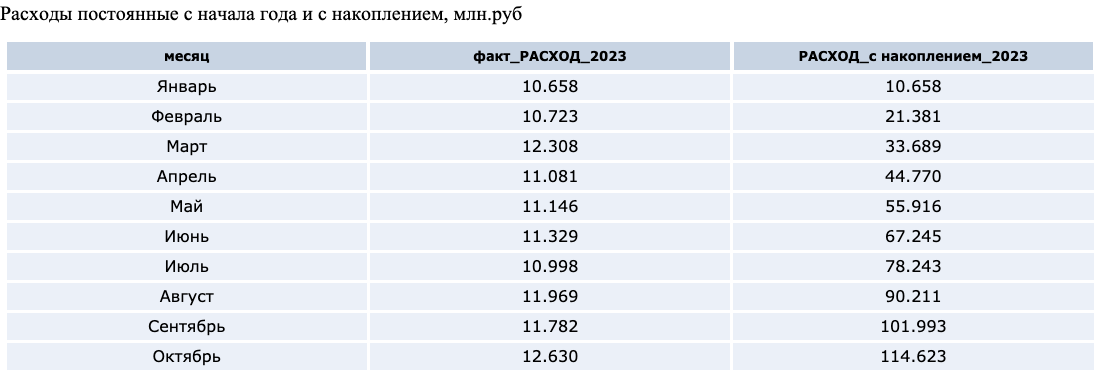

In [1471]:
fig = df2img.plot_dataframe(df_expenses_all_res.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.2, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"Расходы постоянные с начала года и с накоплением, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_расходы_постоянные_накопл_с_н_г.png")

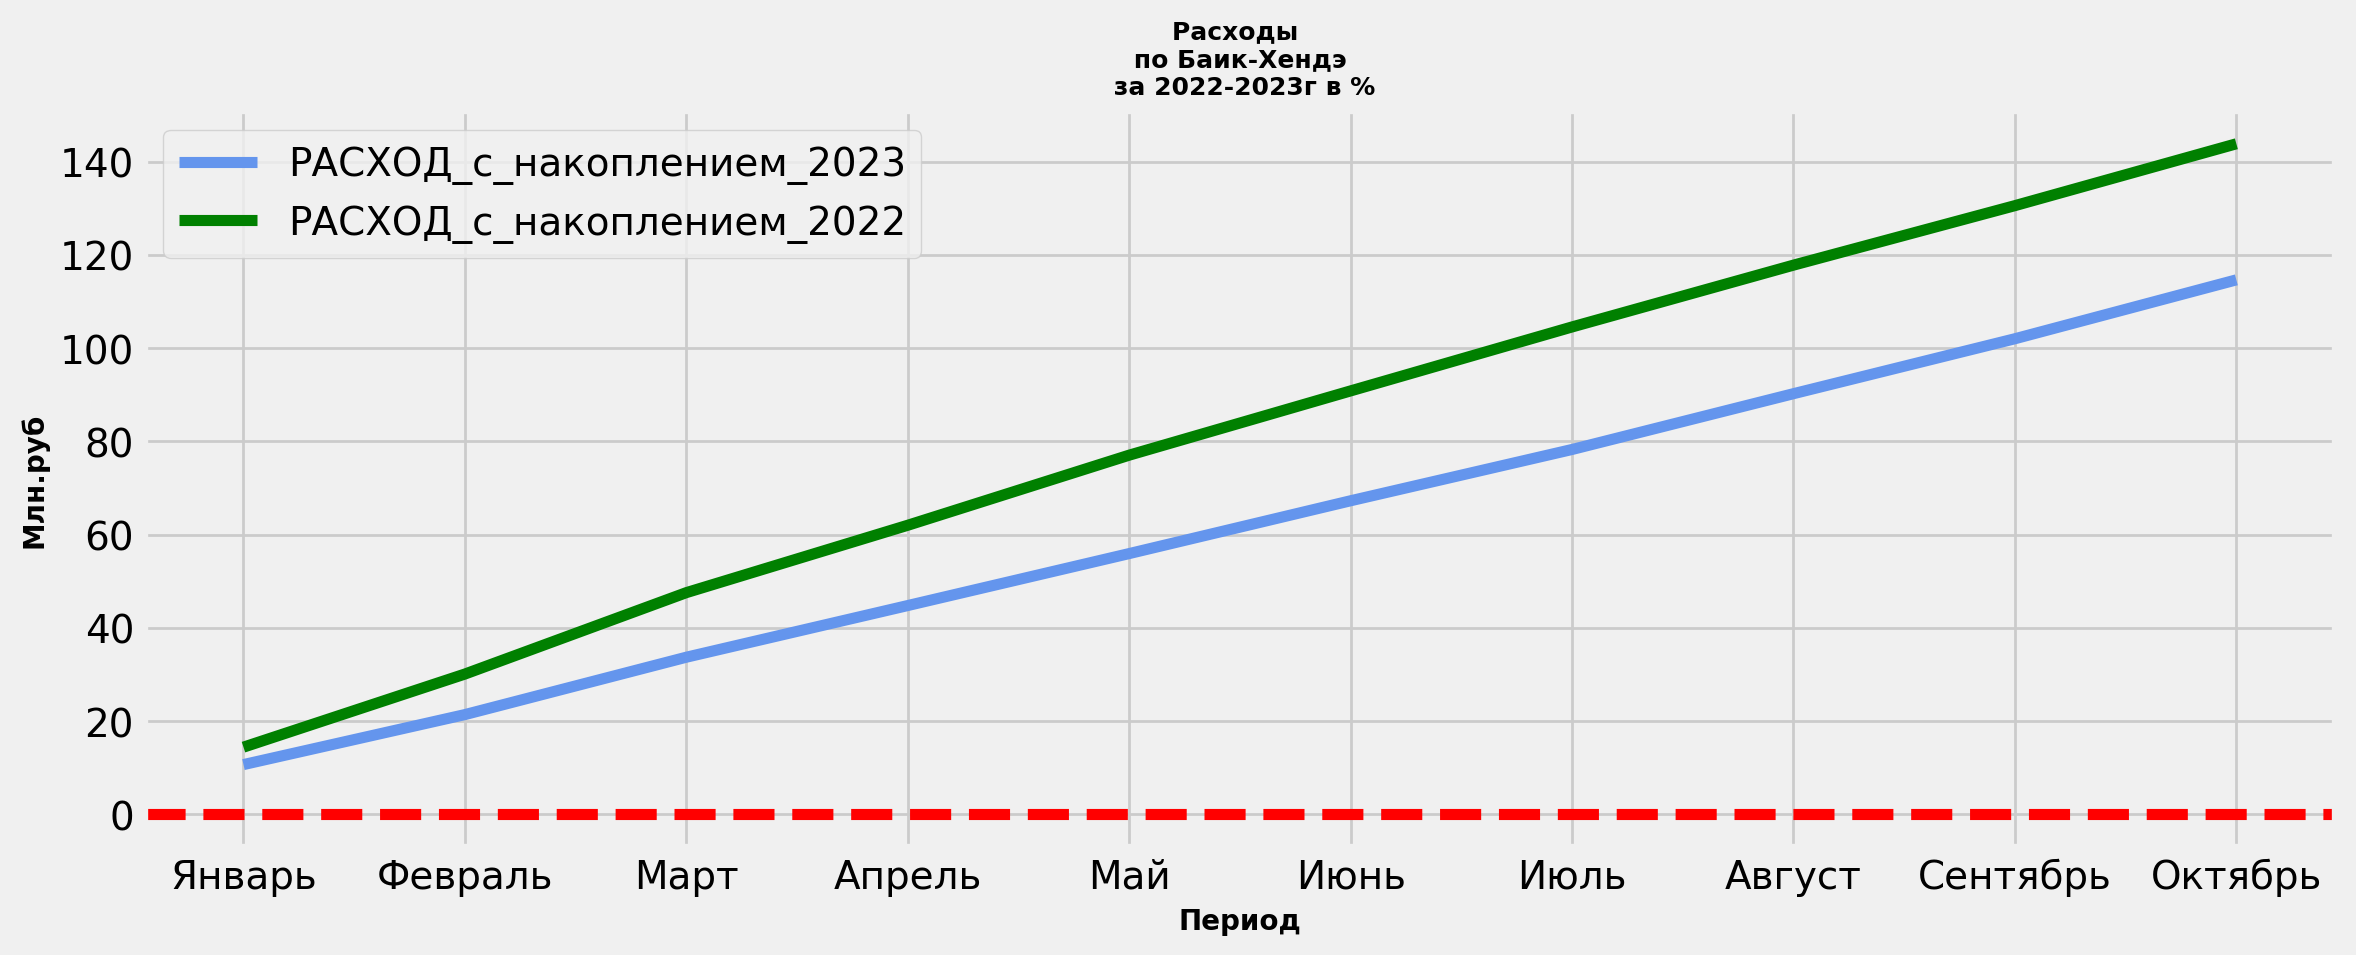

In [1472]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_expenses_all_res['месяц'], 
             df_expenses_all_res[f'РАСХОД_с накоплением_{year_pf}'], 
             label=f'РАСХОД_с_накоплением_{year_pf}', color='cornflowerblue')
    
    plt.plot(df_expenses_all_res_2['месяц'], 
             df_expenses_all_res_2[f'РАСХОД_с накоплением_{year_pf-1}'], 
             label=f'РАСХОД_с_накоплением_{year_pf-1}', color='green')
    
    plt.xticks(rotation=0)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.legend()
    plt.ylabel('Млн.руб',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"Расходы \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf-1}-{year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'РАСХОД_с_накопл.png')
    plt.show()

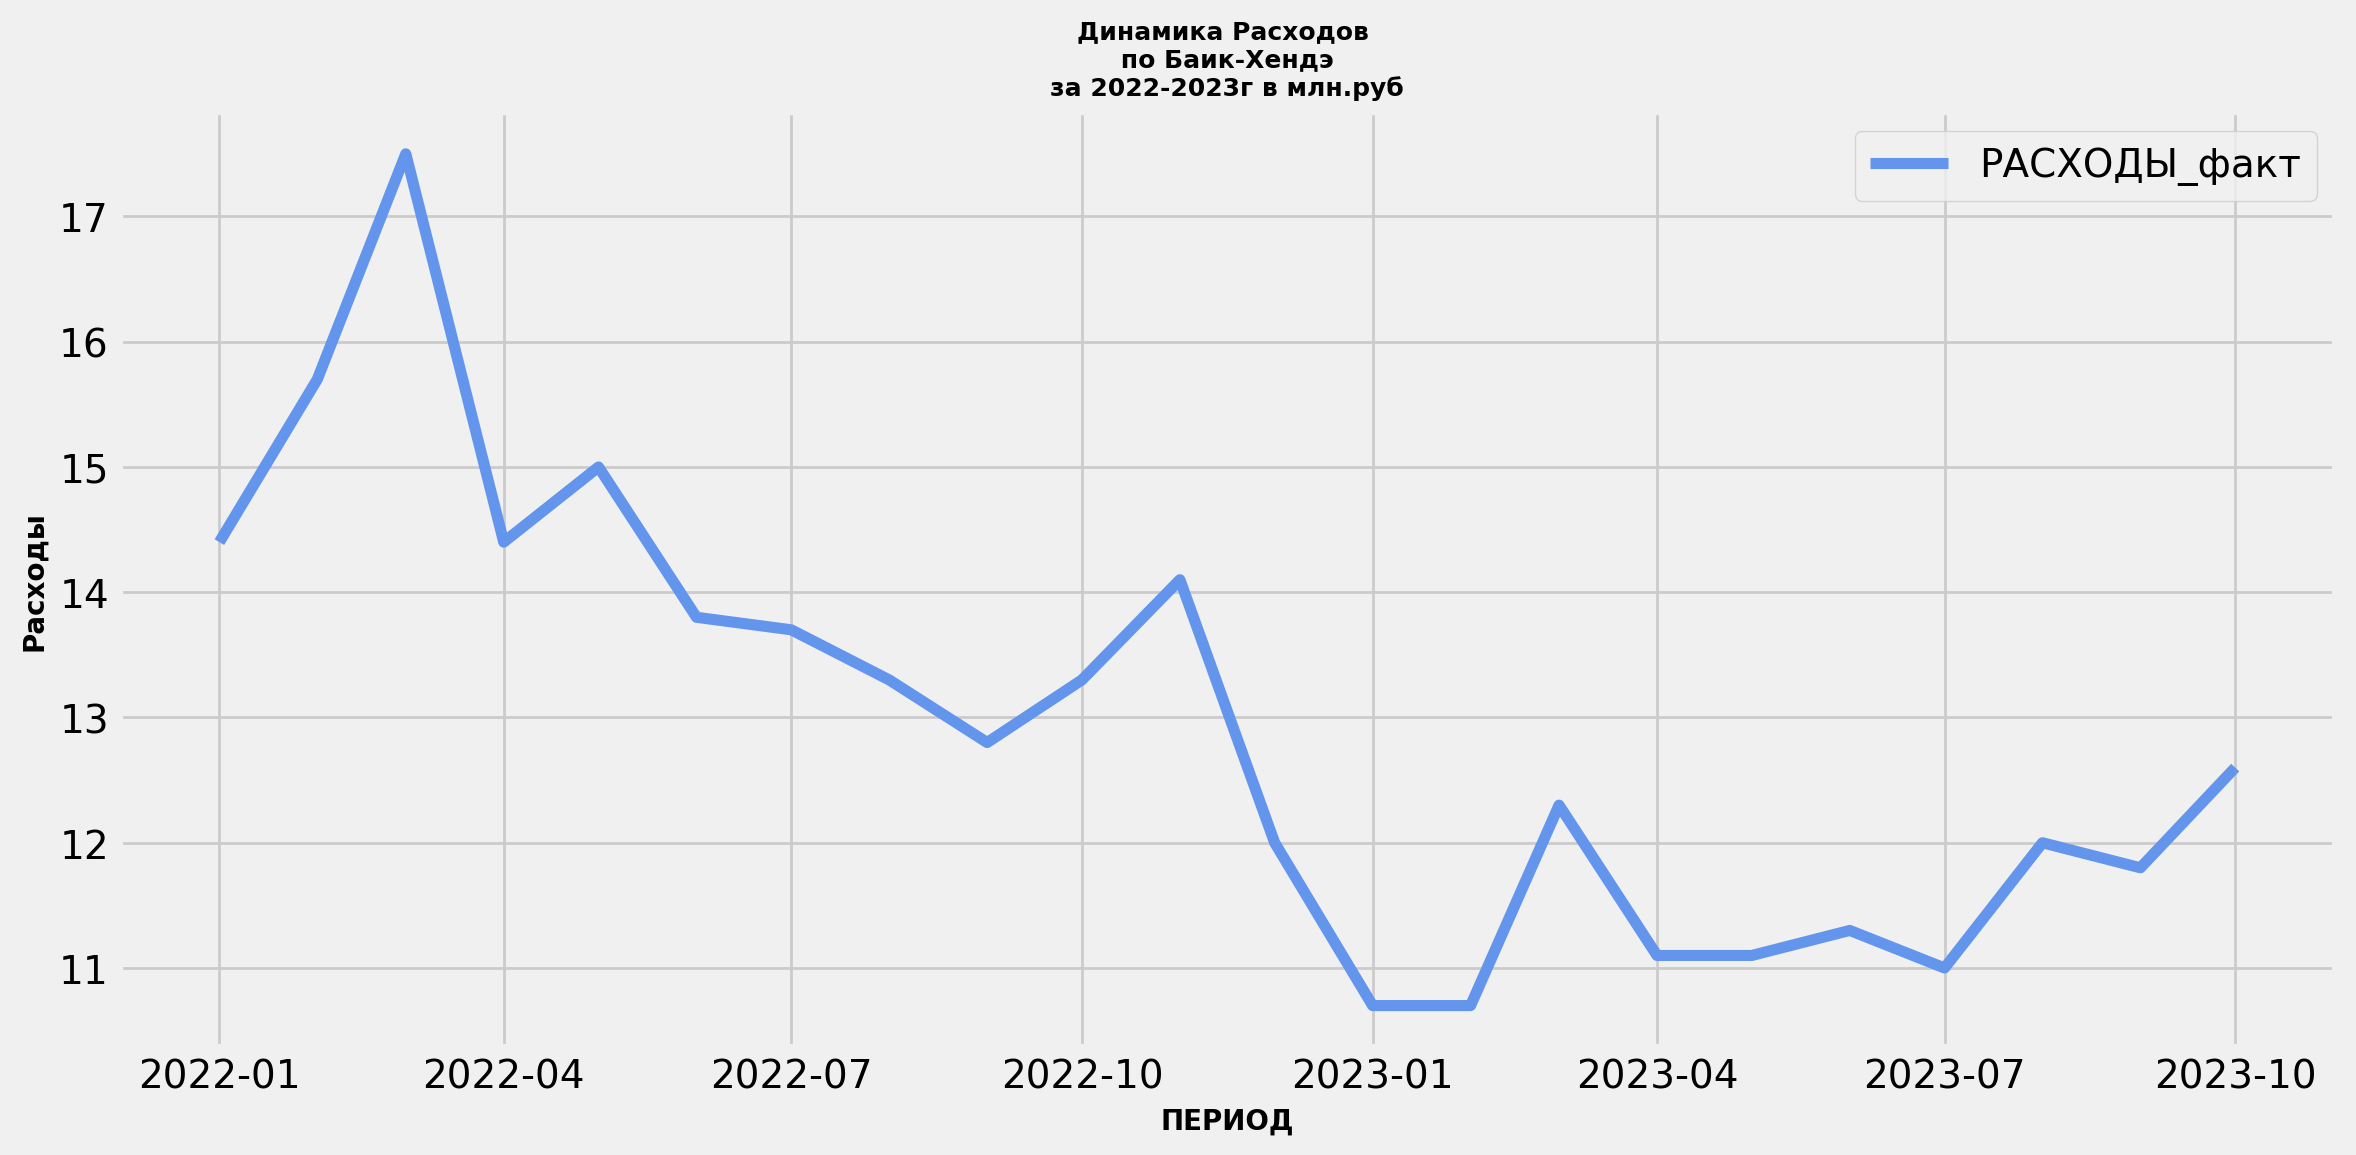

In [1473]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,6), dpi=200) # размер графика
    plt.plot(dynamic_2_years(df_PF, ind_expenses_all)['Дата'], 
             dynamic_2_years(df_PF, ind_expenses_all)['факт'], 
             label='РАСХОДЫ_факт', color='cornflowerblue')
    
    #plt.plot(om_result_dinamic['Дата'], om_result_dinamic['план'], label='ОМ_план', color='red') # этустроку убрать
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)
    # добавляем ось X
    #plt.axhline(y=0, color='red', linestyle='--')

    plt.legend()
    plt.ylabel('Расходы',fontsize = 10, fontweight="bold")
    plt.xlabel('ПЕРИОД',fontsize = 10, fontweight="bold")
    plt.title(f"Динамика Расходов \n по {spravka_new_name.get(name_ac, name_ac)} \nза {year_pf-1}-{year_pf}г в млн.руб",fontsize = 9, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('РАСХОДЫ_динамика_2_года.png') # сохряняет в картику
    plt.show()

In [1474]:
'БЛОК С БАЛАНСОВОЙ И ЧИСТОЙ'

'БЛОК С БАЛАНСОВОЙ И ЧИСТОЙ'

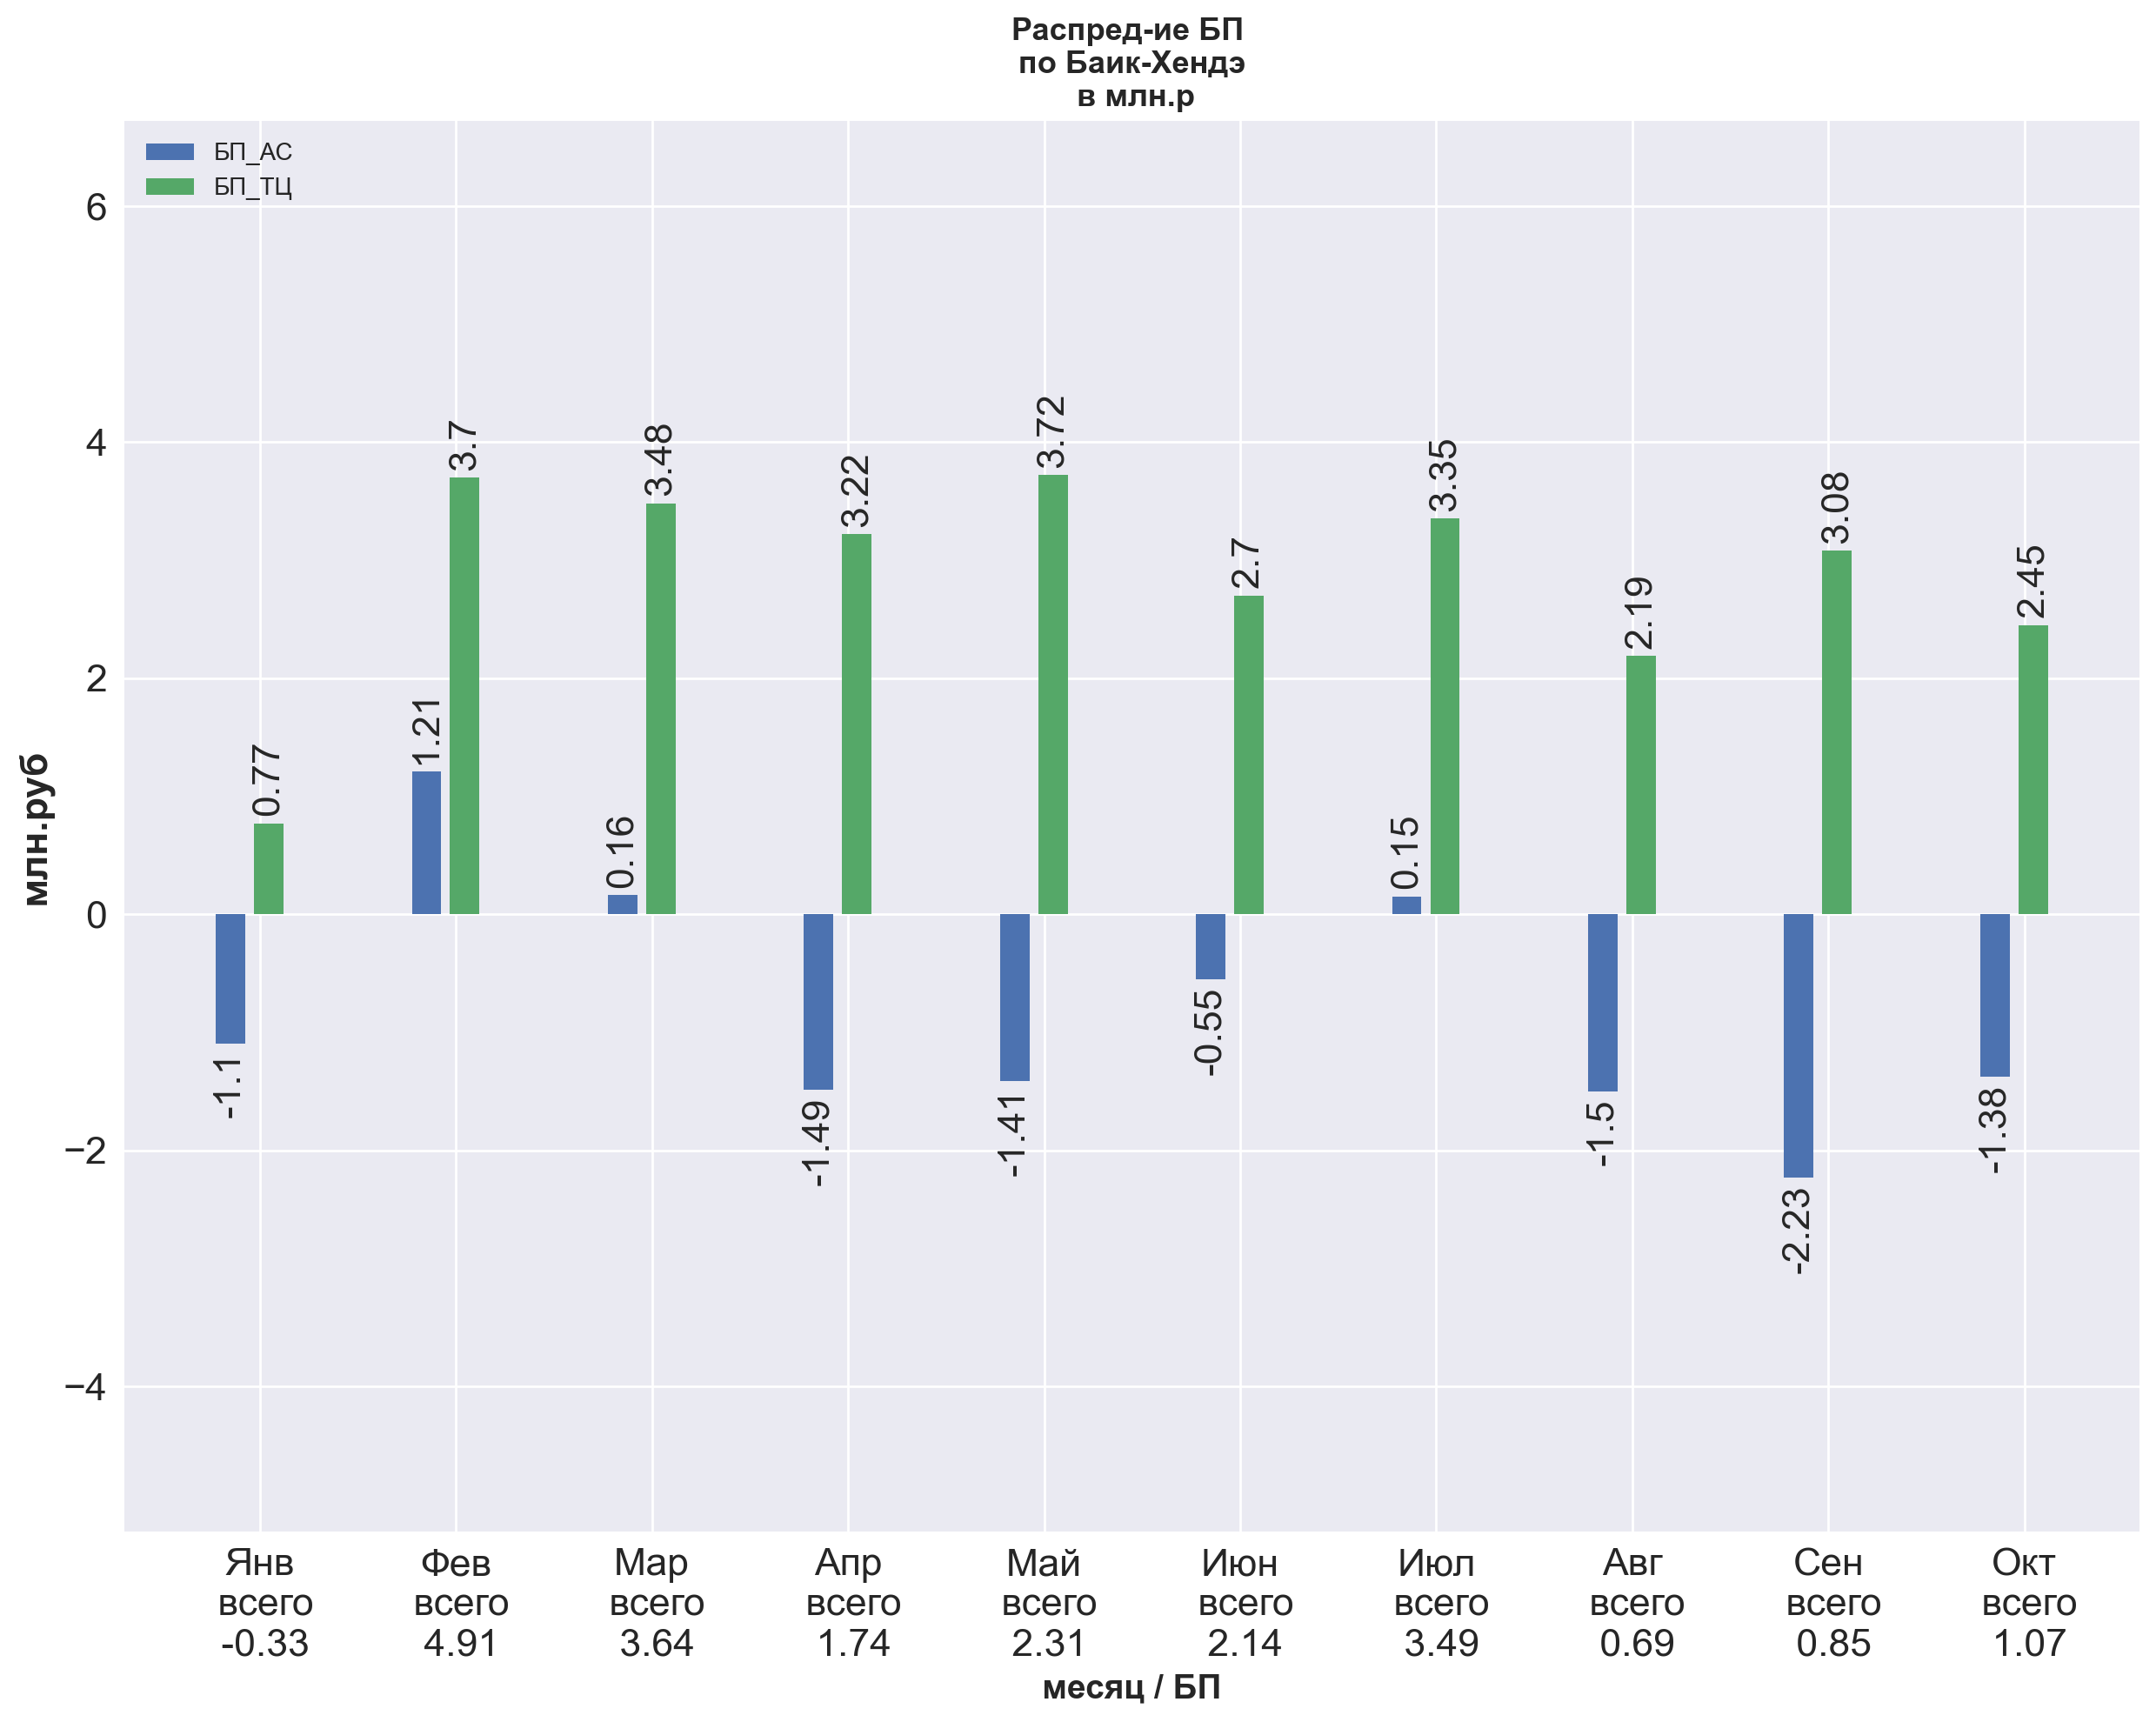

In [1475]:

with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    mmm = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()] 
    itogo_autom = [round(float(df_PF[(df_PF['индекс'] == ind_pf_balance_profit) 
                                     & (df_PF['автоцентр'] == name_ac) 
                                     & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]
    MMM = [f"{i[0:3]}\n всего\n {round(y,2)}" for i,y in zip(mmm, itogo_autom)]

    month_doh = MMM  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
            'БП_АС': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_balance_profit_AS) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'БП_ТЦ': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_balance_profit_TC) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            
        }

    x = np.arange(len(month_doh))  # the label month
    width = 0.15  # ширина полос 
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),10), dpi=200)
    
    for name_doh, doh_value in doh_autocentr.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, doh_value, width, label=name_doh)
        ax.bar_label(rects, rotation=90, padding=3, fontsize = 16)
        multiplier += 1.3 # растояние между столбцами одной группы
    # скрипт определяющий построение графика по оси y min max для set_ylim
    mx = 0
    mi = 0
    for k,v in doh_autocentr.items():
        if max(v)>mx:
            mx = max(v)
        if min(v)<mi:
            mi = min(v)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('млн.руб', fontsize = 16, fontweight="bold")
    ax.set_title(f'Распред-ие БП \n по {spravka_new_name.get(name_ac, name_ac)} \n в млн.р', fontweight="bold", fontsize = 13)
    ax.set_xticks(x + width, month_doh)
    ax.legend(loc='upper left', ncols=1) # ncols=1 - столбцы легенды
    ax.set_ylim(mi-3, mx+3) # + корреткировка +2 млн
    
    plt.xticks(rotation=0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('месяц / БП',fontsize = 14, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('БП_.png') # сохряняет в картику
    plt.show()

In [1476]:
df_ballabce_profit_res = func_IND_podr_year(df_PF, ind_pf_balance_profit, 'факт', 'БП')
df_ballabce_profit_res[f'БП_с накоплением_{year_pf}'] = df_ballabce_profit_res[f'факт_БП_{year_pf}'].cumsum()
df_ballabce_profit_res = convertor_zeros(df_ballabce_profit_res)
df_ballabce_profit_res

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_БП_2023 БП_с накоплением_2023
143       Январь       -0.331                -0.331
37196    Февраль        4.912                 4.581
47974       Март        3.645                 8.225
78393     Апрель        1.735                 9.961
99146        Май        2.315                12.276
104967      Июнь        2.142                14.418
129173      Июль        3.494                17.911
165018    Август        0.692                18.604
182564  Сентябрь        0.849                19.453
196927   Октябрь        1.069                20.521

In [1477]:
df_ballabce_profit_res_2 = func_IND_podr_year(df_PF, ind_pf_balance_profit, 'факт', 'БП', year=year_pf-1)
df_ballabce_profit_res_2[f'БП_с накоплением_{year_pf-1}'] = df_ballabce_profit_res_2[f'факт_БП_{year_pf-1}'].cumsum()
df_ballabce_profit_res_2 = convertor_zeros(df_ballabce_profit_res_2)
df_ballabce_profit_res_2

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_БП_2022 БП_с накоплением_2022
142       Январь        8.916                 8.916
37197    Февраль       12.359                21.275
47973       Март       28.779                50.054
78392     Апрель        9.003                59.057
99039        Май        8.451                67.508
105016      Июнь        6.901                74.409
129174      Июль        6.450                80.859
165019    Август       10.006                90.865
182563  Сентябрь        8.264                99.129
196928   Октябрь        8.324               107.454

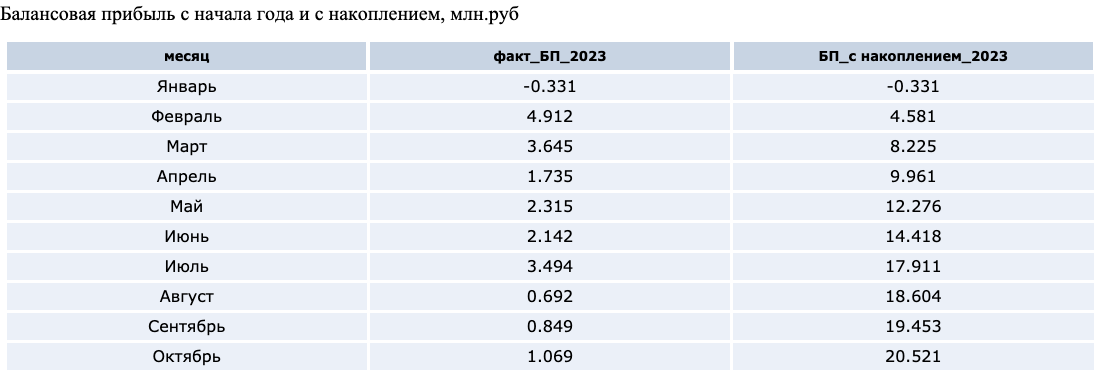

In [1478]:
fig = df2img.plot_dataframe(df_ballabce_profit_res.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.2, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"Балансовая прибыль с начала года и с накоплением, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_балансовая_прибыль_накопл_с_н_г.png")

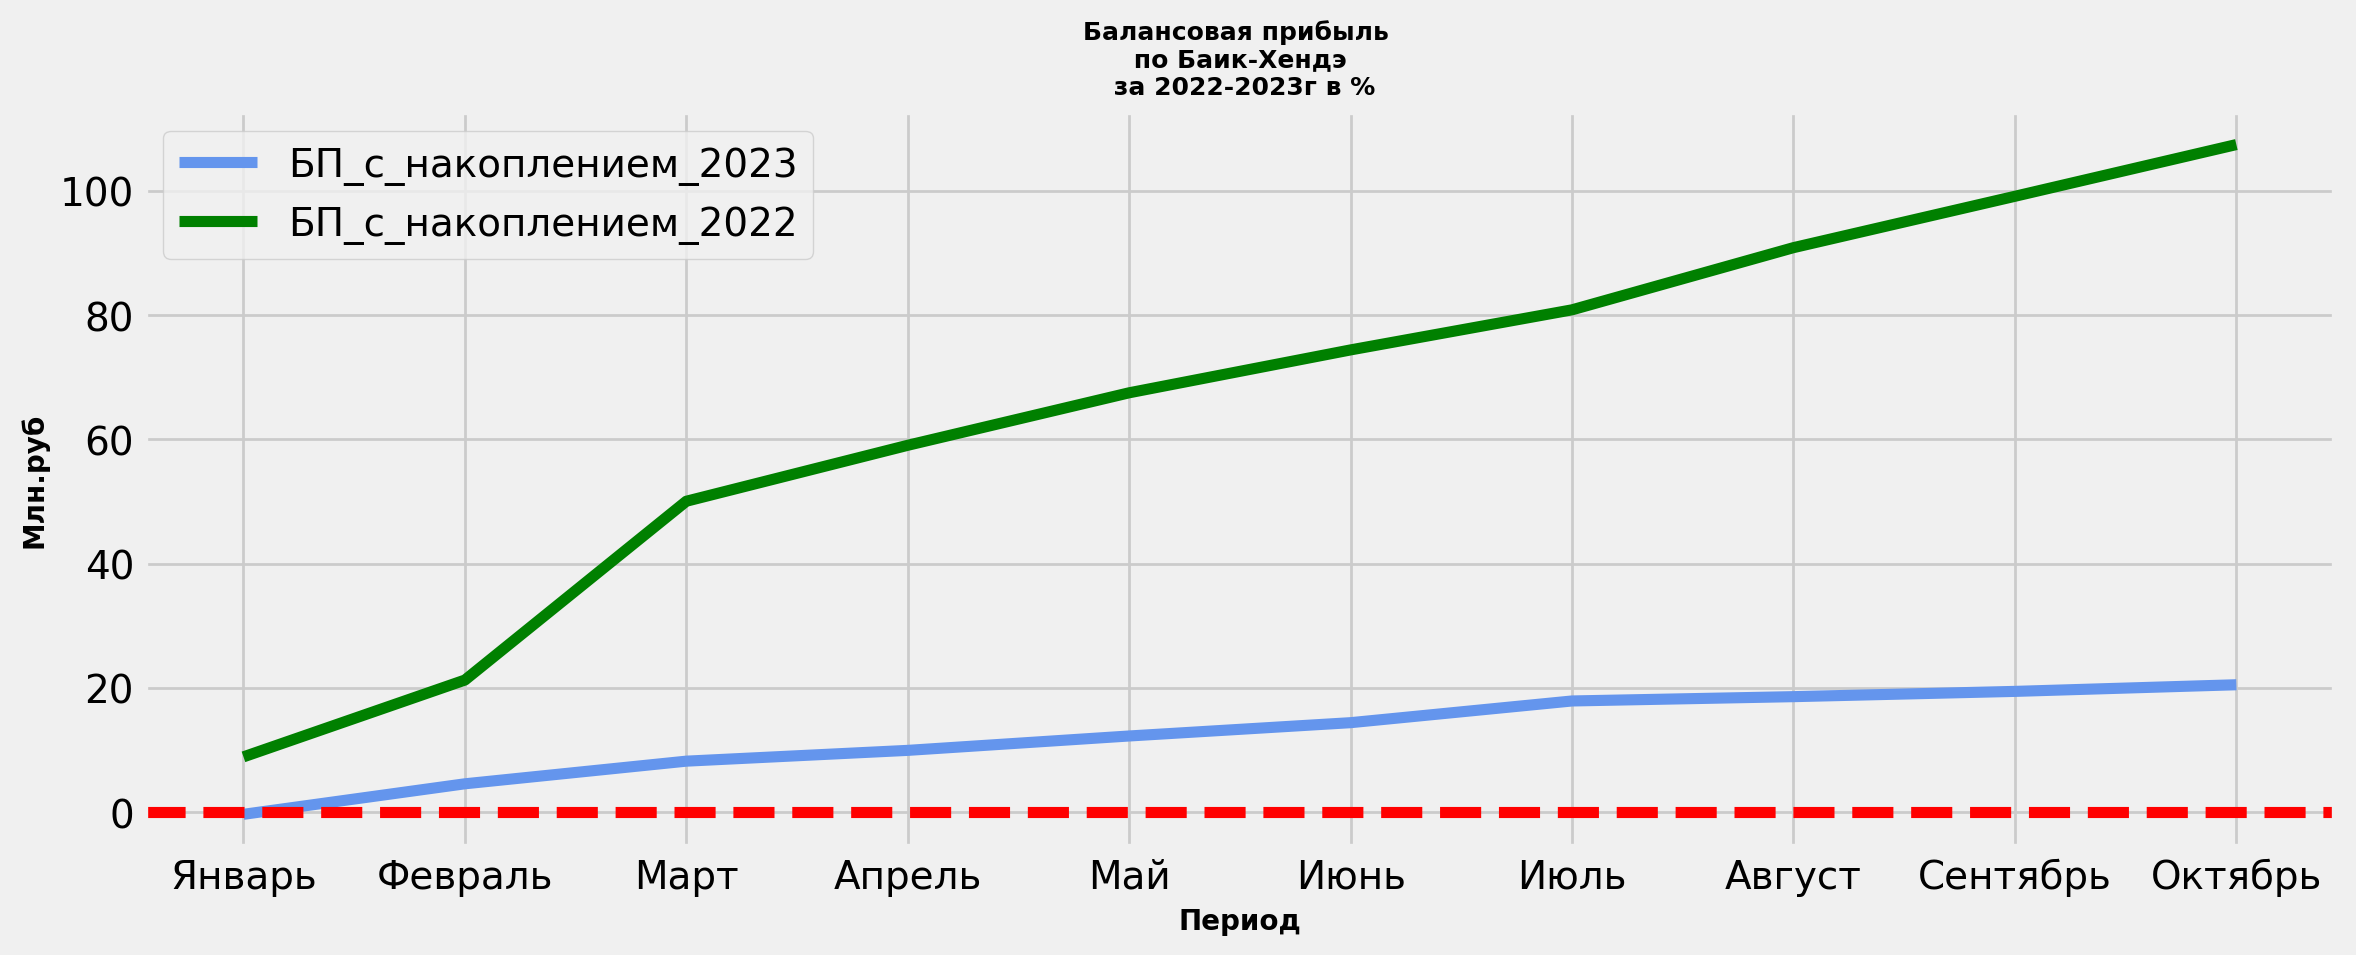

In [1479]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_ballabce_profit_res['месяц'], 
             df_ballabce_profit_res[f'БП_с накоплением_{year_pf}'], 
             label=f'БП_с_накоплением_{year_pf}', color='cornflowerblue')
    
    plt.plot(df_ballabce_profit_res_2['месяц'], 
             df_ballabce_profit_res_2[f'БП_с накоплением_{year_pf-1}'], 
             label=f'БП_с_накоплением_{year_pf-1}', color='green')
    
    plt.xticks(rotation=0)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.legend()
    plt.ylabel('Млн.руб',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"Балансовая прибыль \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf-1}-{year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'БП_с_накопл.png')
    plt.show()

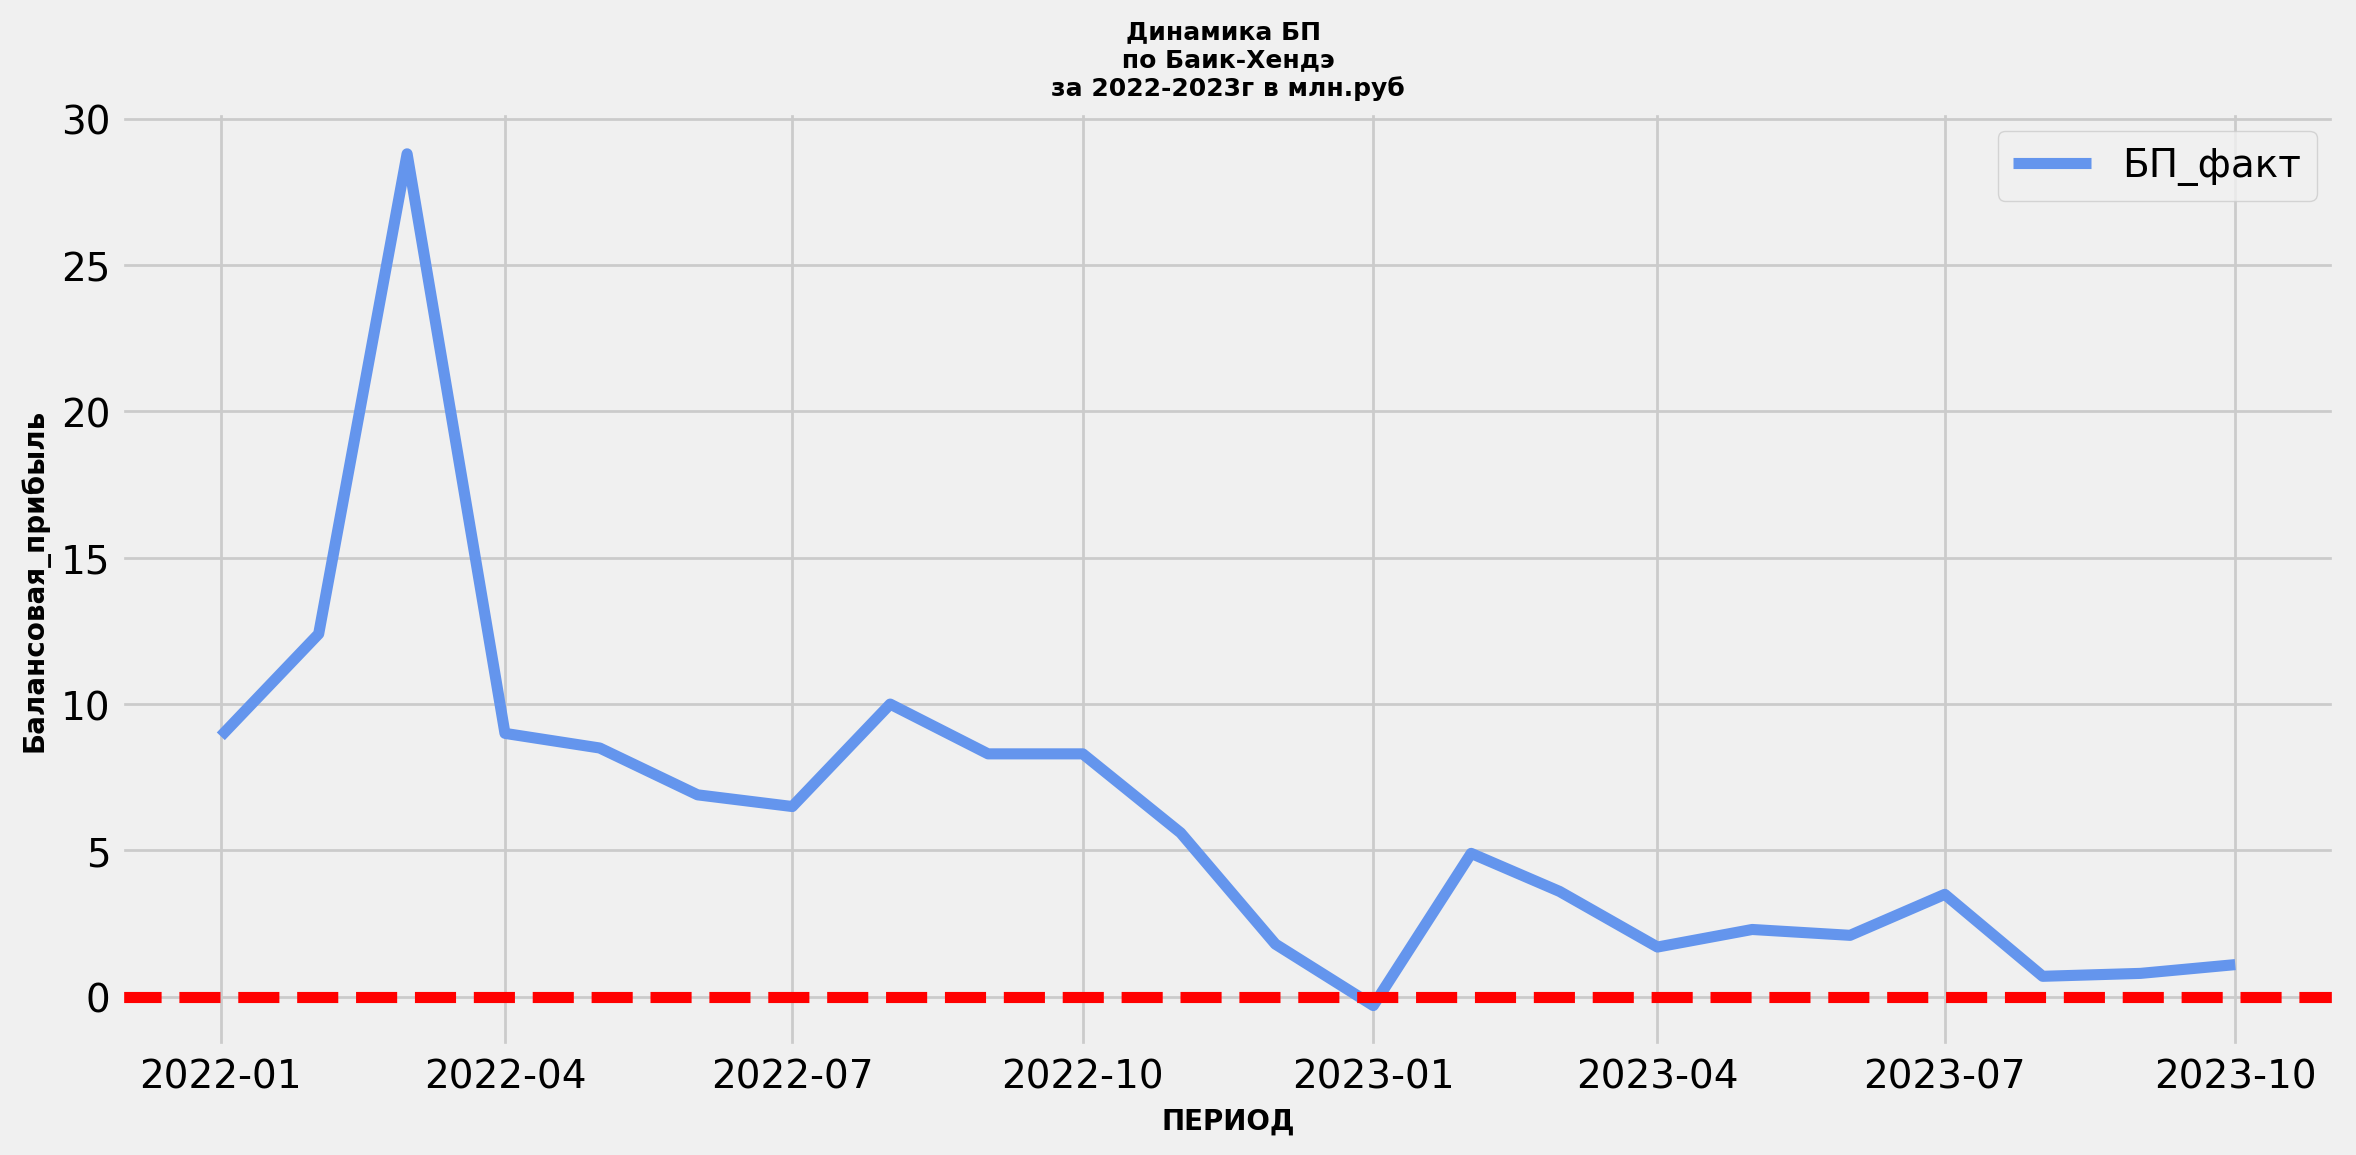

In [1480]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,6), dpi=200) # размер графика
    plt.plot(dynamic_2_years(df_PF, ind_pf_balance_profit)['Дата'], 
             dynamic_2_years(df_PF, ind_pf_balance_profit)['факт'], 
             label='БП_факт', color='cornflowerblue')
    
    #plt.plot(om_result_dinamic['Дата'], om_result_dinamic['план'], label='ОМ_план', color='red') # этустроку убрать
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)
    # добавляем ось X
    plt.axhline(y=0, color='red', linestyle='--')

    plt.legend()
    plt.ylabel('Балансовая_прибыль',fontsize = 10, fontweight="bold")
    plt.xlabel('ПЕРИОД',fontsize = 10, fontweight="bold")
    plt.title(f"Динамика БП \n по {spravka_new_name.get(name_ac, name_ac)} \nза {year_pf-1}-{year_pf}г в млн.руб",fontsize = 9, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('БП_динамика_2_года.png') # сохряняет в картику
    plt.show()

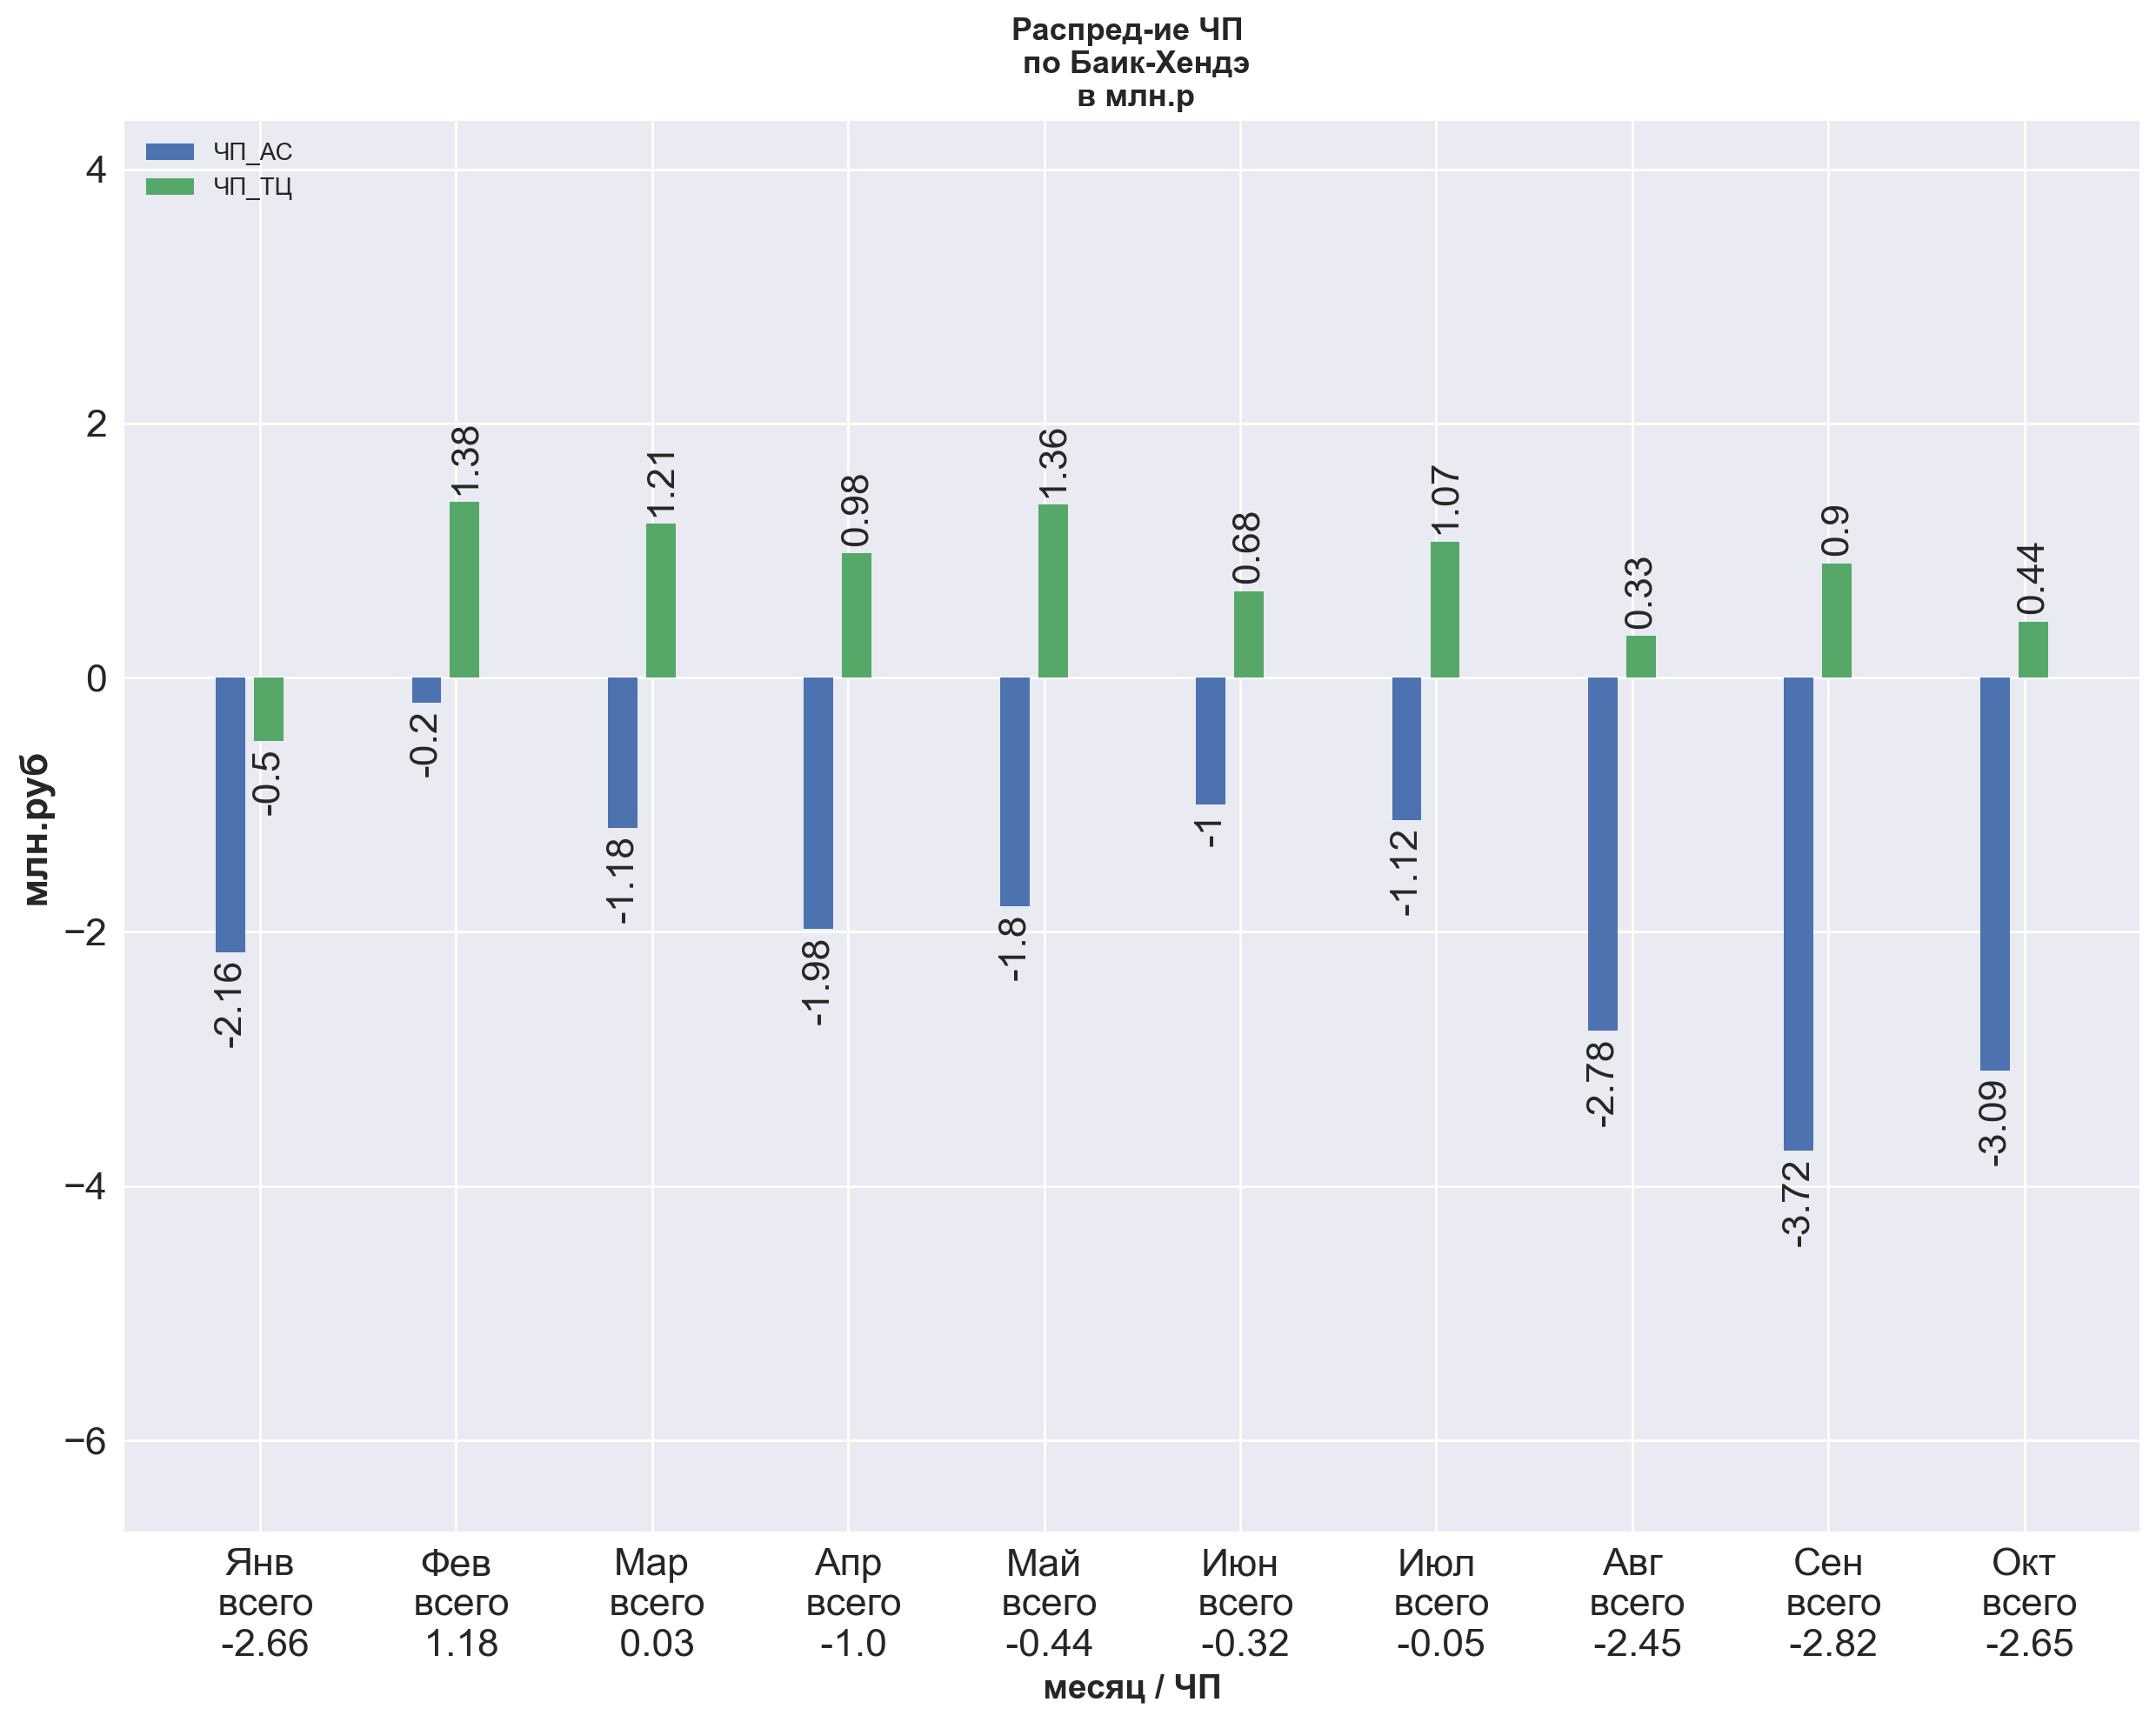

In [1481]:

with plt.style.context('seaborn-v0_8'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    mmm = [i for i in df_PF[df_PF['месяц_digit']<= month_pf]['месяц'].unique()] 
    itogo_autom = [round(float(df_PF[(df_PF['индекс'] == ind_pf_net_profit ) 
                                     & (df_PF['автоцентр'] == name_ac) 
                                     & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]
    MMM = [f"{i[0:3]}\n всего\n {round(y,2)}" for i,y in zip(mmm, itogo_autom)]

    month_doh = MMM  # фильтруем df по месяцу отчета выбираем месяца
    doh_autocentr = {
            'ЧП_АС': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_net_profit_AS) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            'ЧП_ТЦ': np.array([round(float(df_PF[(df_PF['индекс'] == ind_pf_net_profit_TC) 
                                                 & (df_PF['автоцентр'] == name_ac) 
                                                 & (df_PF['год'] == year_pf)][['факт', 'месяц']].fillna(0).drop_duplicates('месяц').iloc[i,0])/1000000, 2) for i in range(month_pf)]),
            
        }

    x = np.arange(len(month_doh))  # the label month
    width = 0.15  # ширина полос 
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(0.5+(month_pf*1.2),10), dpi=200)
    
    for name_doh, doh_value in doh_autocentr.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, doh_value, width, label=name_doh)
        ax.bar_label(rects, rotation=90, padding=3, fontsize = 16)
        multiplier += 1.3 # растояние между столбцами одной группы
    # скрипт определяющий построение графика по оси y min max для set_ylim
    mx = 0
    mi = 0
    for k,v in doh_autocentr.items():
        if max(v)>mx:
            mx = max(v)
        if min(v)<mi:
            mi = min(v)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('млн.руб', fontsize = 16, fontweight="bold")
    ax.set_title(f'Распред-ие ЧП \n по {spravka_new_name.get(name_ac, name_ac)}\n в млн.р', fontweight="bold", fontsize = 13)
    ax.set_xticks(x + width, month_doh)
    ax.legend(loc='upper left', ncols=1) # ncols=1 - столбцы легенды
    ax.set_ylim(mi-3, mx+3) # + корреткировка +2 млн
    
    plt.xticks(rotation=0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('месяц / ЧП',fontsize = 14, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('ЧП_.png') # сохряняет в картику
    plt.show()

In [1482]:
df_profit_res = func_IND_podr_year(df_PF, ind_pf_net_profit, 'факт', 'ЧП')
df_profit_res[f'ЧП_с накоплением_{year_pf}'] = df_profit_res[f'факт_ЧП_{year_pf}'].cumsum()
df_profit_res = convertor_zeros(df_profit_res)
df_profit_res

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_ЧП_2023 ЧП_с накоплением_2023
1087      Январь       -2.663                -2.663
37341    Февраль        1.184                -1.479
48408       Март        0.030                -1.449
77002     Апрель       -0.996                -2.445
95733        Май       -0.443                -2.888
104415      Июнь       -0.317                -3.206
128339      Июль       -0.051                -3.257
147847    Август       -2.450                -5.706
179563  Сентябрь       -2.815                -8.522
196014   Октябрь       -2.652               -11.173

In [1483]:
df_profit_res_2 = func_IND_podr_year(df_PF, ind_pf_net_profit, 'факт', 'ЧП', year=year_pf-1)
df_profit_res_2[f'ЧП_с накоплением_{year_pf-1}'] = df_profit_res_2[f'факт_ЧП_{year_pf-1}'].cumsum()
df_profit_res_2 = convertor_zeros(df_profit_res_2)
df_profit_res_2

func_float_df_digit: месяц не преобразован в <class 'float'>
месяц не удалось преобразовать


месяц факт_ЧП_2022 ЧП_с накоплением_2022
1086      Январь        3.325                 3.325
37342    Февраль        4.924                 8.248
48407       Март       15.016                23.265
77231     Апрель        3.294                26.558
95734        Май        2.754                29.312
104414      Июнь        1.978                31.290
128338      Июль        1.795                33.085
147681    Август        3.948                37.033
179576  Сентябрь        3.080                40.112
196013   Октябрь        3.073                43.185

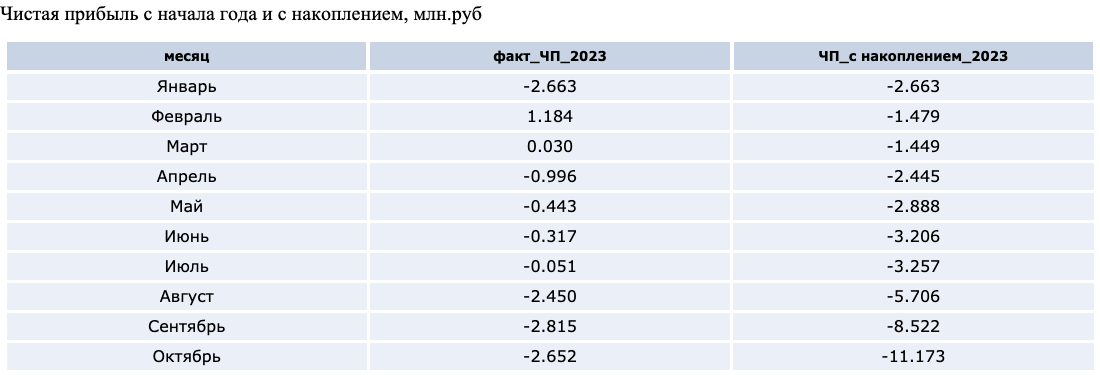

In [1484]:
fig = df2img.plot_dataframe(df_profit_res.apply(infinity_).fillna(0).astype(str),
      print_index=False, # отключает индексы
      col_width=[0.2, 0.2, 0.2],  # ширина колонок
      title=dict(
          font_color="black",
          font_family="Times New Roman",
          font_size=20,
          text=f"Чистая прибыль с начала года и с накоплением, млн.руб",
          x=0,
          xanchor="left",
      ),
      tbl_header=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=13,
        height=20,
        line_width=4,
    ),
      tbl_cells=dict(
        align="center",
        fill_color="light gray",
        font_color="black",
        font_size=16,
        height=30,
        line_width=3
    ),
      fig_size=(1100, 75+(30*month_pf)),
  )
df2img.save_dataframe(fig=fig, filename="df_чистая_прибыль_накопл_с_н_г.png")

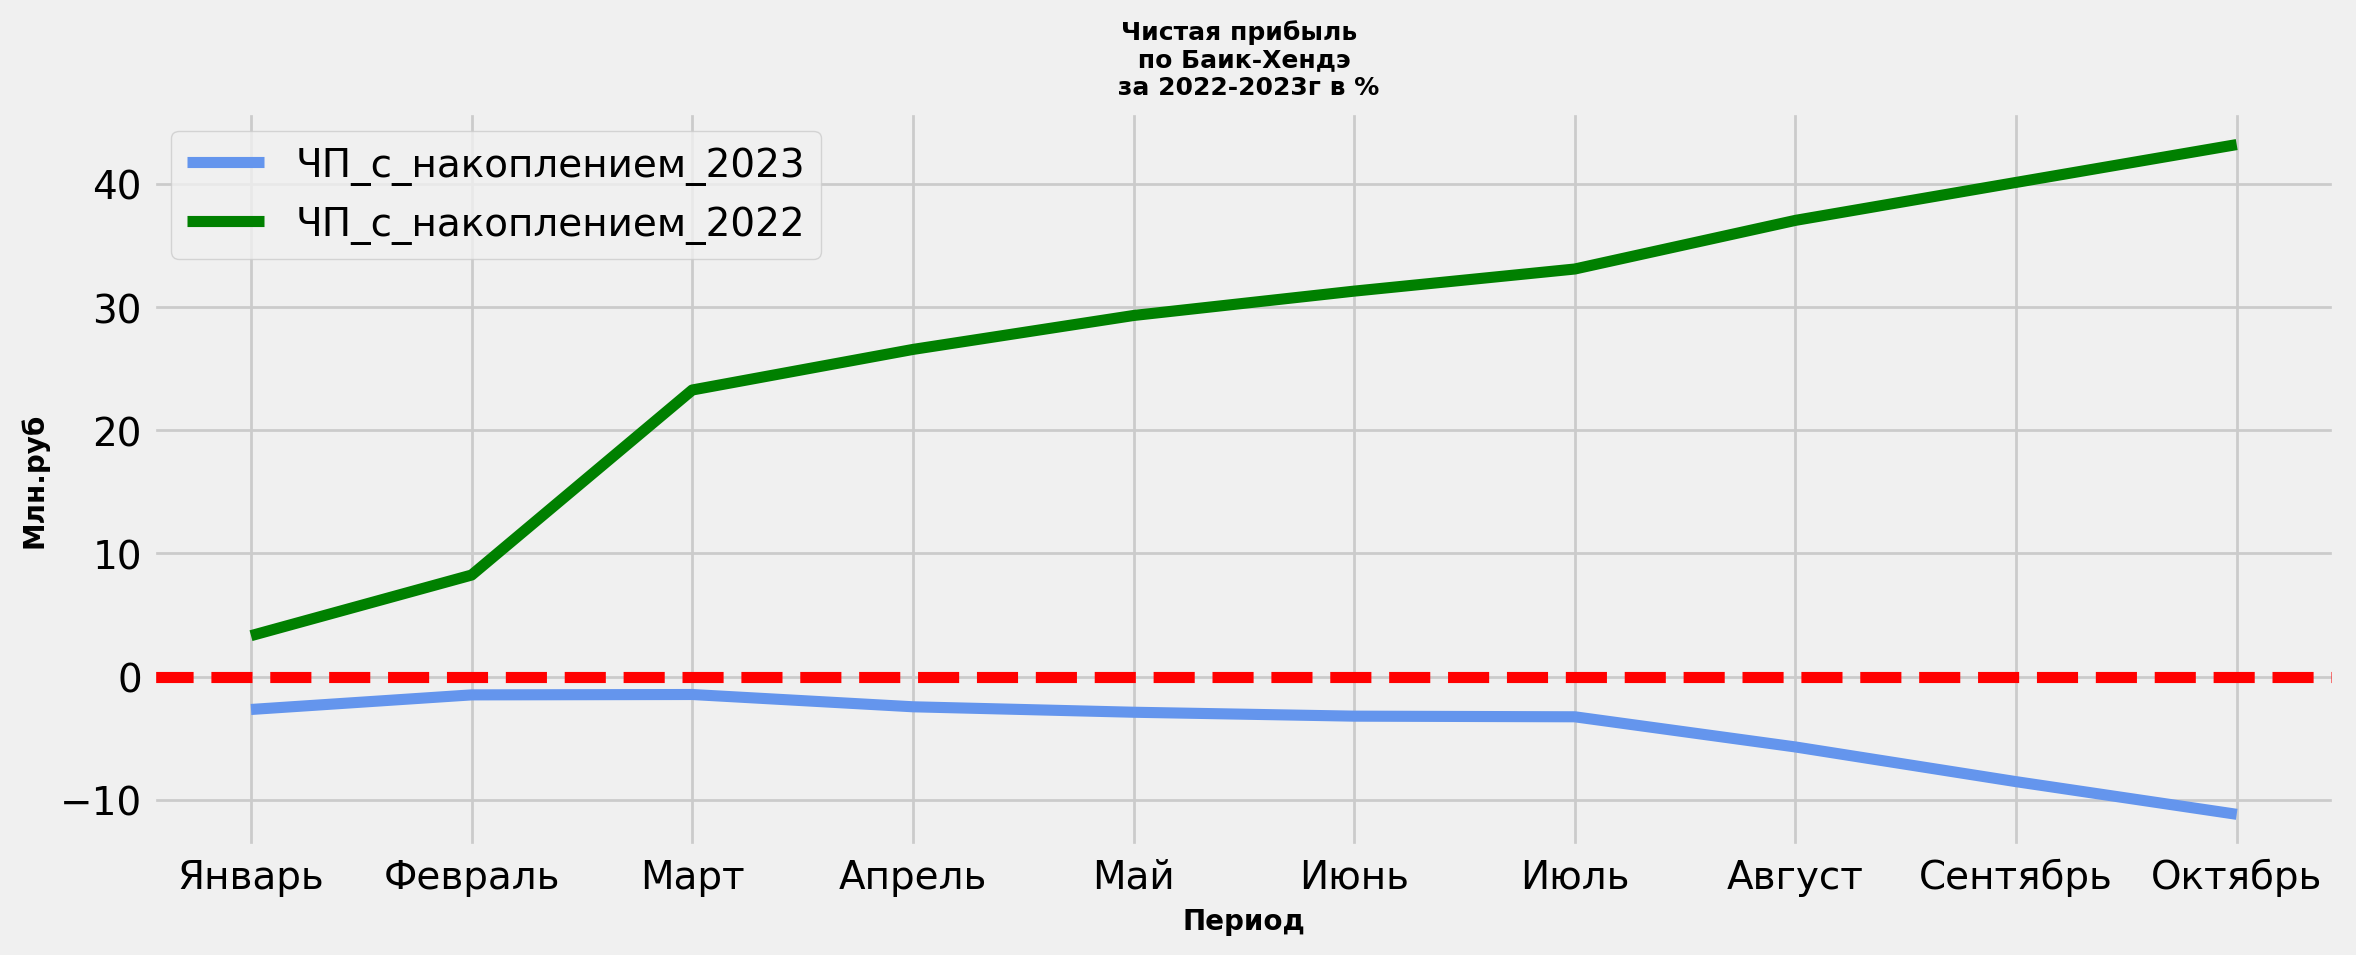

In [1485]:
with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,5), dpi=200) # размер графика
    plt.plot(df_profit_res['месяц'], df_profit_res[f'ЧП_с накоплением_{year_pf}'], 
             label=f'ЧП_с_накоплением_{year_pf}', color='cornflowerblue')
    plt.plot(df_profit_res_2['месяц'], df_profit_res_2[f'ЧП_с накоплением_{year_pf-1}'], 
             label=f'ЧП_с_накоплением_{year_pf-1}', color='green')
 
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.legend()
    plt.ylabel('Млн.руб',fontsize = 10, fontweight="bold")
    plt.xlabel('Период',fontsize = 10, fontweight="bold")

    plt.title(f"Чистая прибыль \n по {spravka_new_name.get(name_ac, name_ac)} \n за {year_pf-1}-{year_pf}г в %",fontsize = 9, fontweight="bold")
    plt.tight_layout() # вмещает все в сохраняемую картику
    plt.savefig(f'ЧП_с_накопл.png')
    plt.show()

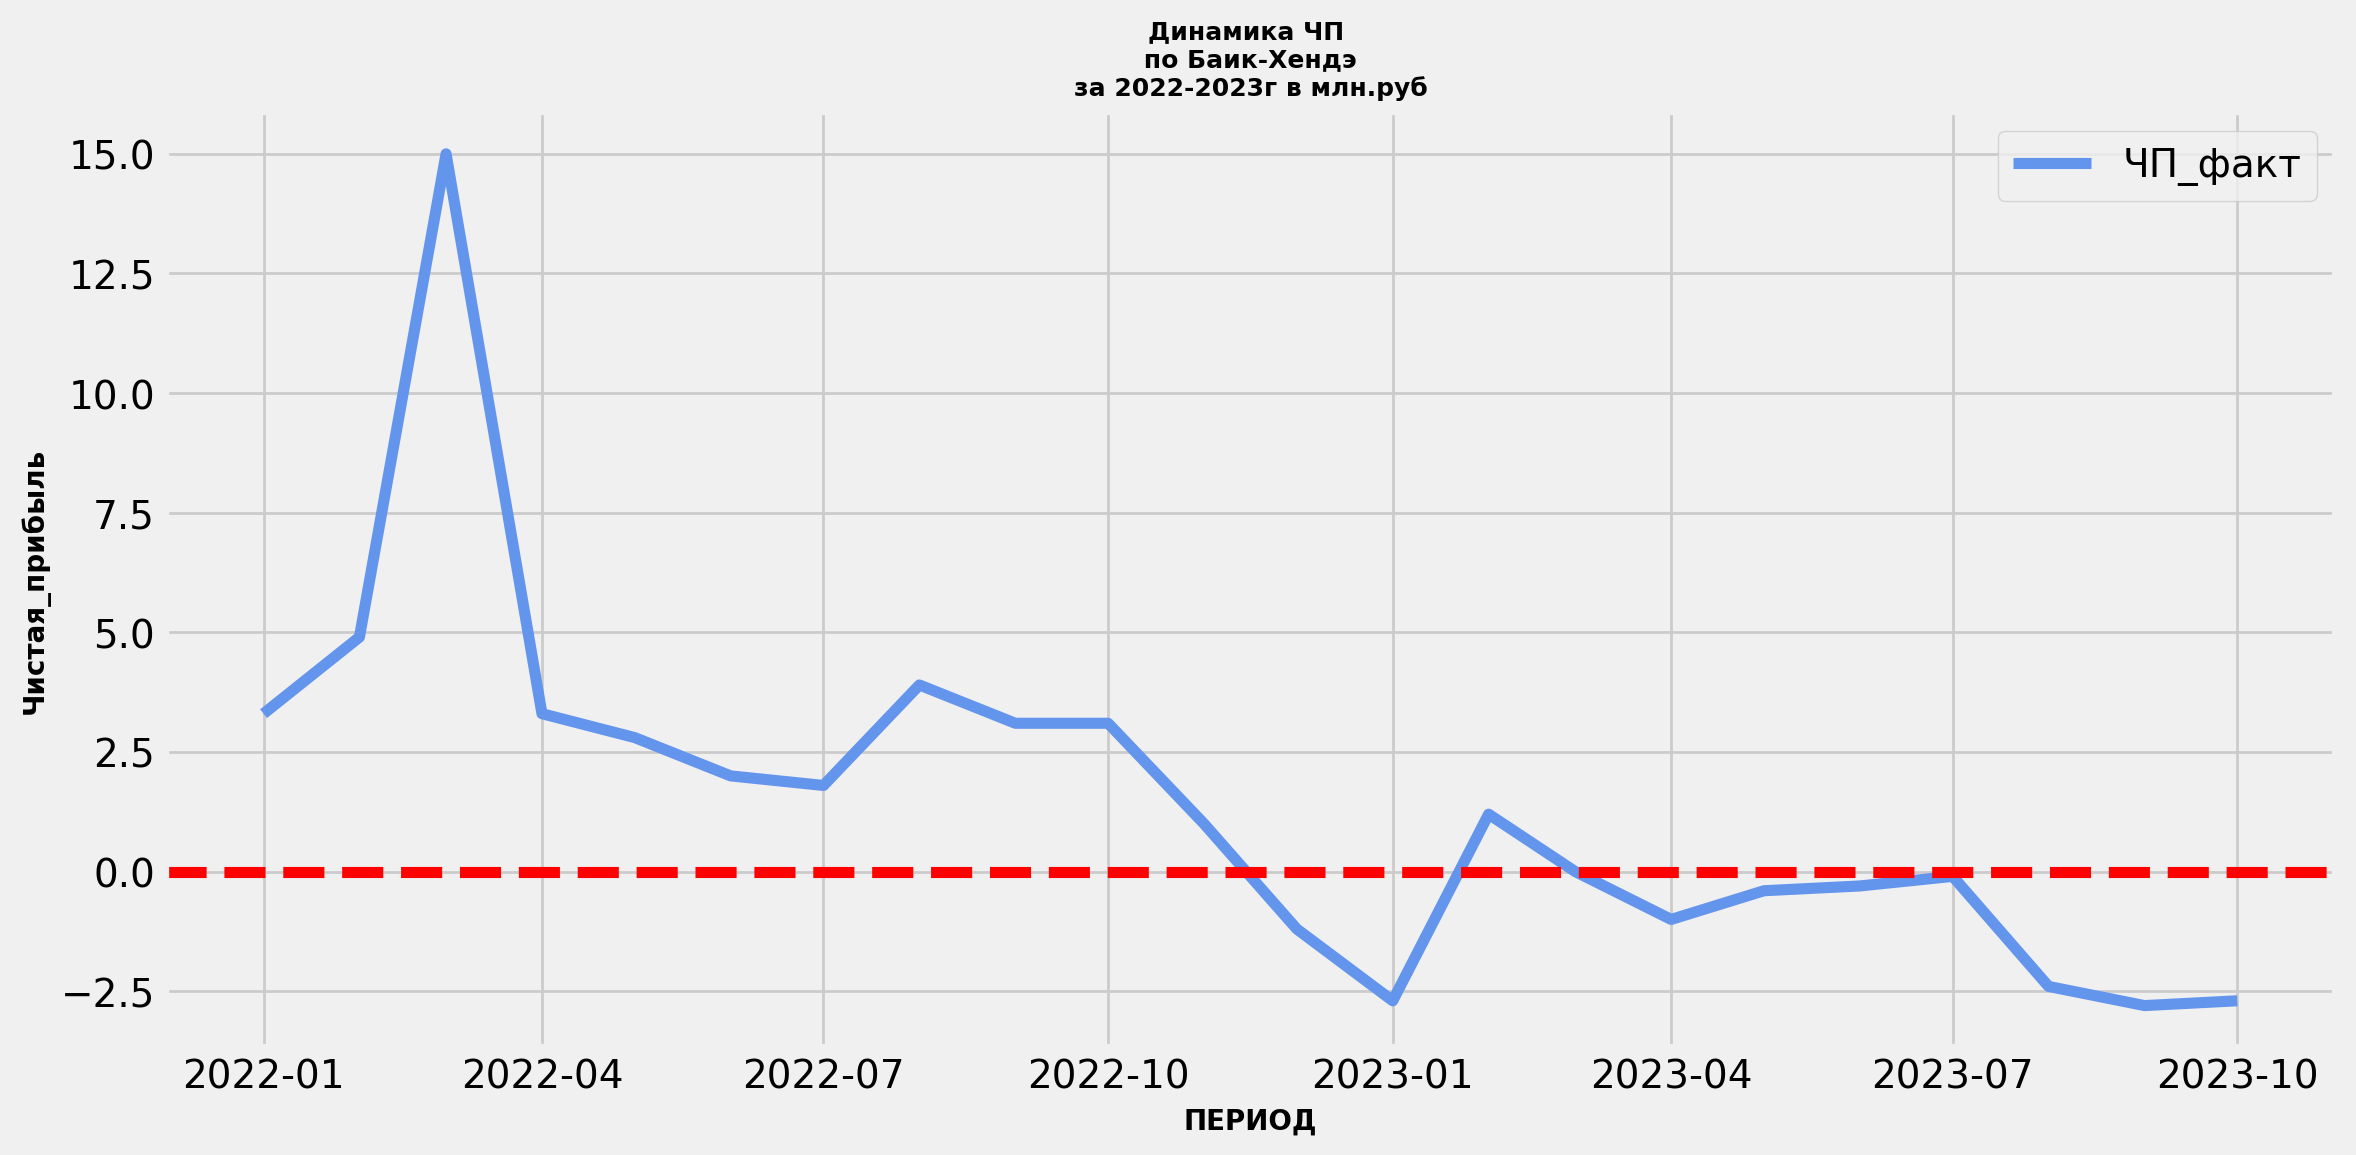

In [1486]:

with plt.style.context('fivethirtyeight'): # применим стиль bmh / fivethirtyeight / seaborn-deep
    plt.figure(figsize=(12,6), dpi=200) # размер графика
    plt.plot(dynamic_2_years(df_PF, ind_pf_net_profit)['Дата'], 
             dynamic_2_years(df_PF, ind_pf_net_profit)['факт'], 
             label='ЧП_факт', color='cornflowerblue')
    
    # градус подписей по оси Х
    plt.xticks(rotation=0)
    # добавляем ось X
    plt.axhline(y=0, color='red', linestyle='--')

    plt.legend()
    plt.ylabel('Чистая_прибыль',fontsize = 10, fontweight="bold")
    plt.xlabel('ПЕРИОД',fontsize = 10, fontweight="bold")
    plt.title(f"Динамика ЧП \n по {spravka_new_name.get(name_ac, name_ac)} \nза {year_pf-1}-{year_pf}г в млн.руб",fontsize = 9, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig('ЧП_динамика_2_года.png') # сохряняет в картику
    plt.show()

In [1487]:

pdf = FPDF() # создаем объект класса
font_dir = font_dir # путь к папке со шрифтами
pdf.add_page() # создаем страницу
pdf.add_font(family="Serif", style="", fname=f"{font_dir}/DejaVuSansCondensed.ttf", uni=True)
pdf.set_font(family="Serif", size=12) 

# оглавление титульник
pdf.cell(200, 10, txt=f'Анализ деятельности АЦ {spravka_new_name.get(name_ac, name_ac)} за {spravka_month.get(min(spravka_month.keys()))}-{spravka_month.get(month_pf)} {year_pf}г', align='C', ln=1)

pdf.set_font(family="Serif", size=8) 
#pdf.ln() 
pdf.image('df_распоряжение_оптимизации.png', h=25, w=180)
                
pdf.set_font(family="Serif", size=10) 
#pdf.ln() 
pdf.image('Динамика_дохода_1.png', h=100, w=18*month_pf)

pdf.image('Динамика_дохода_2.png', h=100, w=18*month_pf)
pdf.ln()   
pdf.ln() 
pdf.ln() 
pdf.ln()  

pdf.set_font(family="Serif", size=12)
pdf.cell(200, 10, txt=f'Динамика дохода с накоплением, в млн.руб', align='C')
pdf.ln()

pdf.image('df_дох_с_накопл.png', h=8+(5*df_last_first_target_x.count()[0]), w=190)########
  
pdf.image('ОМ_1.png', h=120, w=18*month_pf) 
pdf.image('ОМ_2.png', h=80, w=180)            
pdf.image('ОМ_3.png', h=120, w=17*month_pf)        
pdf.image('df_распределение_дох_ом.png', h=20+(5*month_pf), w=180)                       
pdf.image('df_распределение_дох_ом_накопительно.png', h=20+(5*month_pf), w=180)     
        
pdf.image('Распределение_ам.png', h=120, w=18*month_pf)             

pdf.image('df_доля_зп_к_доходу_итого.png', h=20+(5*month_pf), w=180)             
pdf.image('Доля_ЗП_АЦ_1.png', h=80, w=180) # если график линейный динамику не ставим             
         
pdf.image('df_динамика_фзп_ас.png', h=20+(5*month_pf), w=180)             
pdf.image('Динамика_ФЗП_АС.png', h=80, w=180) # если график линейный динамику не ставим  
      
pdf.image('df_динамика_фзп_тц.png', h=20+(5*month_pf), w=180)             
pdf.image('Динамика_ФЗП_ТЦ.png', h=90, w=180) # если график линейный динамику не ставим  
           
pdf.image('df_доля_зп_подр_от_дох.png', h=20+(5*month_pf), w=180)             
pdf.image('Доля_зп_подразделенй_от_дохода.png', h=90, w=180) # если график линейный динамику не ставим  
          
pdf.image('df_доход_к_зп_итого.png', h=20+(5*month_pf), w=180)             
pdf.image('Доход_к_зп_итого_.png', h=90, w=180) # если график линейный динамику не ставим  
########### 

pdf.image('df_лимит_зп_ац.png', h=8+(5*func_limit_ZP(df_ZP, lim_zp_max, ['АЦ']).count()[0]), w=190)             
pdf.image('df_лимит_зп_ас.png', h=8+(5*func_limit_ZP(df_ZP, lim_zp_max, ['АС']).count()[0]), w=190)             
pdf.image('df_лимит_зп_тц.png', h=8+(5*func_limit_ZP(df_ZP, lim_zp_max, ['ТЦ']).count()[0]), w=190)             
               
pdf.image('df_доход_итого_к_зп_по_ведомости_итого.png', h=15+(5*doh_k_zp_itogo.count()[0]), w=180)                         
pdf.image('df_доход_ас_к_зп_ас_ведомость.png', h=15+(5*doh_k_zp_AS.count()[0]), w=180)                         
pdf.image('df_доход_тц_к_зп_тц_ведомость_разбивка.png', h=15+(5*doh_k_zp_TC.count()[0]), w=180)                         
pdf.image('df_доход_мц_к_зп_мц_ведомость_разбивка.png', h=15+(5*doh_k_zp_MC.count()[0]), w=180)                         
pdf.image('df_доход_кц_к_зп_кц_ведомость_разбивка.png', h=15+(5*doh_k_zp_KC.count()[0]), w=180)                     
pdf.image('df_доход_итого_к_зп_итого_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_itog_k_zp_itog.name}.png', h=80, w=180) # если график линейный динамику не ставим         
pdf.image('df_доход_итого_к_зп_РУК_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_itog_k_zp_ruk.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_итого_к_зп_АЦ_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_itog_k_zp_AC.name}.png', h=80, w=180) # если график линейный динамику не ставим          
pdf.image('df_доход_ТЦ_к_зп_ТЦ_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_TC_k_zp_TC.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_АСобщ_к_зп_АСобщ_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_AS_k_zp_AS.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_АСнов_к_зп_АСнов_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_ASnew_k_zp_ASnew.name}.png', h=80, w=180) # если график линейный динамику не ставим  
     
pdf.image('df_доход_АСовп_к_зп_АСовп_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_AS_k_zp_AS_ovp.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_ТЦМЦ_к_зп_ТЦМЦ_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_MC_k_zp_MC.name}.png', h=80, w=180) # если график линейный динамику не ставим             
pdf.image('df_доход_ТЦМЦ_к_зп_ТЦМЦмеханики_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_MC_k_zp_MC_meh.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_ТЦМЦ_к_зп_ТЦМЦитр_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_MC_k_zp_MC_itr.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_ТЦКЦ_к_зп_ТЦКЦ_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_KC_k_zp_KC.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_ТЦКЦ_к_зп_ТЦКЦмех_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_KC_k_zp_KC_meh.name}.png', h=80, w=180) # если график линейный динамику не ставим            
pdf.image('df_доход_ТЦКЦ_к_зп_ТЦКЦитр_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'{doh_KC_k_zp_KC_itr.name}.png', h=80, w=180) # если график линейный динамику не ставим           
pdf.image('df_доход_ТЦДО_к_зп_ТЦДО_ведомость_с_н_г.png', h=20+(5*month_pf), w=180)              
pdf.image(f'{doh_DO_k_zp_DO.name}.png', h=80, w=180) # если график линейный динамику не ставим  

pdf.image('df_результат_деятельности_по_выручке_с_н_г.png', h=190, w=50+(10*month_pf))             
pdf.image('df_результат_деятельности_по_доходу_с_н_г.png', h=190, w=50+(10*month_pf))             

pdf.image('Выручка_.png', h=120, w=17*month_pf)
pdf.image('df_выручка_накопл_с_н_г.png', h=20+(5*month_pf), w=180) 
pdf.image(f'ВЫРУЧКА_с_накопл.png', h=80, w=180) # если график линейный динамику не ставим 
pdf.image('Выручка_динамика_2_года.png', h=80, w=180)  

pdf.image('РАСХОДЫ_.png', h=120, w=17*month_pf) 
pdf.image('df_распределение_постоянных_расходов_млн.png', h=20+(5*month_pf), w=180) 
pdf.image('df_распределение_постоянных_расходов_процент.png', h=20+(5*month_pf), w=180) 
pdf.image('df_расходы_постоянные_накопл_с_н_г.png', h=20+(5*month_pf), w=180) 
pdf.image(f'РАСХОД_с_накопл.png', h=80, w=180) # если график линейный динамику не ставим 
pdf.image('РАСХОДЫ_динамика_2_года.png', h=80, w=180) 
       
pdf.image('БП_.png', h=120, w=17*month_pf)           
pdf.image('df_балансовая_прибыль_накопл_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'БП_с_накопл.png', h=80, w=180) # если график линейный динамику не ставим  
pdf.image('БП_динамика_2_года.png', h=80, w=180)   

pdf.image('ЧП_.png', h=120, w=17*month_pf)           
pdf.image('df_чистая_прибыль_накопл_с_н_г.png', h=20+(5*month_pf), w=180)             
pdf.image(f'ЧП_с_накопл.png', h=80, w=180) # если график линейный динамику не ставим  
pdf.image('ЧП_динамика_2_года.png', h=80, w=180)            

    
pdf.ln() 
pdf.output('table.pdf')